In [355]:
import matplotlib.pyplot as plt
import wrapper_for_data as wrap
import analysis_for_data as analysis
import exponential_median as exp_median
import noise_addition_for_smooth_sens as ss_median
import binary_search_median as bisearch_median
import fancy_bs_median as fancy_bs
import cdf_median as cdf_median
import bs_cdf_median
import grad_descent_median as gd_median
import publicCI as pub
import run_CI_algs as run_cis
import imp
import common
import numpy as np
import scipy.stats as st

In [344]:
imp.reload(wrap)
imp.reload(analysis)
imp.reload(common)
imp.reload(run_cis)
imp.reload(exp_median)
imp.reload(cdf_median)
imp.reload(bisearch_median)
imp.reload(bs_cdf_median)

<module 'bs_cdf_median' from '/Users/jayshreesarathy/Documents/Research/DPMED/dpmedian/experiments/bs_cdf_median.py'>

In [356]:
# Common for running/plotting
alg_index = [('Expmedian_naive','ExpMechUnion'), #0
             ('Expmedian','ExpMech'), #1
             ('CDFmedian_naive', 'CDFPostProcessUnion'), #2
             ('CDFmedian', 'CDFPostProcess'), #3
             ('CDFBSmedian', 'CDF+BinSearch'), #4
             ('AdaBSCDFmedian', 'BinSearch+CDF'), #5
             ('BSmedian_sep_reuse_queries', 'BinSearch'), #6
             ('AdaBSmedian_sep', 'NoisyBinSearch'), #7
             ('Nonpriv_lognormal', 'Nonprivate Lognormal'), #8  
             ('', 'Nonprivate Nonparametric')] #9

# Eg. set of all algorithms
all_indices = [i for i in range(len(alg_index))]
algs_all = [alg_index[i][0] for i in all_indices[:-1]]
alg_names_all = [alg_index[i][1] for i in all_indices]
print(algs_all)
print(alg_names_all)

# Colors 
colors = ['magenta',
          'indianred',
          'orange',
          'pink',
          'yellow',
          'darkseagreen',
          'skyblue',
          'mediumpurple',
          'aquamarine', # change this?
          'darkslategray']
colors_all = [colors[i] for i in range(len(all_indices))]
print(colors_all)

# Styles
# -.^ --o :v -.* -.
# '///' '--', '...','\///', 'xxx', '\\\\'
styles=[{'color':'magenta', 'linestyle':'-', 'marker':'^', 'hatch':'++'}, #n
        {'color':'indianred', 'linestyle':'-.', 'marker':'^', 'hatch':'///'}, #
        {'color':'orange', 'linestyle':'-', 'marker':'o', 'hatch':'**'}, #n
        {'color':'pink', 'linestyle':'--', 'marker':'o', 'hatch':'--'}, #
        {'color':'yellow', 'linestyle':'-', 'marker':'^', 'hatch':'///'},
        {'color':'darkseagreen', 'linestyle':':', 'marker':'v', 'hatch':'...'}, #
        {'color':'skyblue', 'linestyle':'-', 'marker':'^', 'hatch':'///'},
        {'color':'mediumpurple', 'linestyle':'-.', 'marker':'*', 'hatch':'xxx'}, #
        {'color':'aquamarine', 'linestyle':'-.', 'marker':'^', 'hatch':'++'}, # change this?
        {'color':'darkslategray', 'linestyle':'-', 'marker':'.', 'hatch':'\\\\'} #
       ]
styles_all = [styles[i] for i in range(len(all_indices))]
print(styles_all)


# Save directory
dir_path = '../../figs'

# Create save paths for figures
def conf_str(alpha):
    if (type(alpha) is list) or (type(alpha) is np.ndarray):
        return 'alpha'
    else:
        return str(int(100-100*alpha))

def coverage_save_paths(dir_path, dataset_name, param_string, alpha): # revised):
    # Coverage for all algs
    save_path1 = '%s/coverage-%s/coverage-%s-%s-all-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    # Coverage for main body algs
    save_path2 = '%s/coverage-%s/coverage-%s-%s-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    # Coverage for naive vs. new algs
    save_path3 = '%s/coverage-%s/coverage-%s-%s-naive-v-new-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    save_paths = [save_path1, save_path2, save_path3]
    return save_paths

def width_save_paths(dir_path, dataset_name, param_string, alpha):
    # Relative widths for all algs
    save_path1 = '%s/widths-%s/rel-width-%s-%s-all-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    save_path2 = '%s/widths-%s/rel-width-boxplots-%s-%s-all-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    # Widths for all algs
    save_path3 = '%s/widths-%s/width-%s-%s-all-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    save_path4 = '%s/widths-%s/width-boxplots-%s-%s-all-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    # Relative widths for main body algs
    save_path5 = '%s/widths-%s/rel-width-%s-%s-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    save_path6 = '%s/widths-%s/rel-width-boxplots-%s-%s-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)    
    # Relative widths for naive vs. new algs
    save_path7 = '%s/widths-%s/rel-width-boxplots-%s-%s-naive-v-new-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    save_paths = [save_path1, save_path2, save_path3, save_path4, save_path5, save_path6, save_path7]
    return save_paths

def legend_save_path(dir_path, algs, plot_type, color):
    # algs = 'main' or 'naive-v-new', plot_type = 'line' or 'box', color = 'color' or 'blackwhite'   
    # blackwhite means readable in black and white, aka textured but can also have color
    save_path = '%s/%s_%s_%s-revised-labels.pdf' % (dir_path, algs, plot_type, color)
    return save_path

['Expmedian_naive', 'Expmedian', 'CDFmedian_naive', 'CDFmedian', 'CDFBSmedian', 'AdaBSCDFmedian', 'BSmedian_sep_reuse_queries', 'AdaBSmedian_sep', 'Nonpriv_lognormal']
['ExpMechUnion', 'ExpMech', 'CDFPostProcessUnion', 'CDFPostProcess', 'CDF+BinSearch', 'BinSearch+CDF', 'BinSearch', 'NoisyBinSearch', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
['magenta', 'indianred', 'orange', 'pink', 'yellow', 'darkseagreen', 'skyblue', 'mediumpurple', 'aquamarine', 'darkslategray']
[{'color': 'magenta', 'linestyle': '-', 'marker': '^', 'hatch': '++'}, {'color': 'indianred', 'linestyle': '-.', 'marker': '^', 'hatch': '///'}, {'color': 'orange', 'linestyle': '-', 'marker': 'o', 'hatch': '**'}, {'color': 'pink', 'linestyle': '--', 'marker': 'o', 'hatch': '--'}, {'color': 'yellow', 'linestyle': '-', 'marker': '^', 'hatch': '///'}, {'color': 'darkseagreen', 'linestyle': ':', 'marker': 'v', 'hatch': '...'}, {'color': 'skyblue', 'linestyle': '-', 'marker': '^', 'hatch': '///'}, {'color': 'mediumpur

Saving legend to  ../../figs/naive-v-new_line_plot_blackwhite-revised-labels.pdf


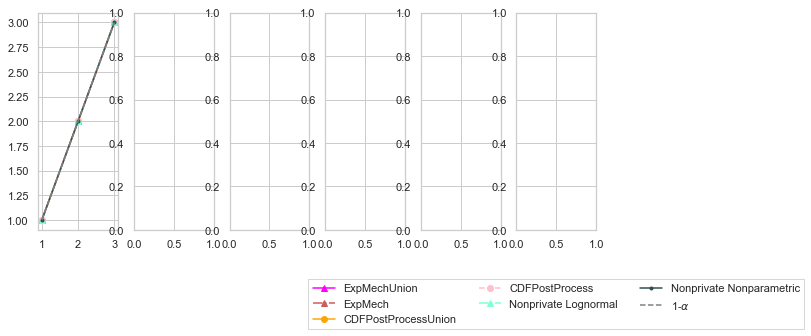

In [358]:
# Legend for line plots
fig, ax = plt.subplots(1, 6, figsize=(10,4))
x =  [1, 2, 3]
y1 = [1, 2, 3]

legend_indices_names = [0, 1, 2, 3, 8, 9]
alg_names = [alg_index[i][1] for i in legend_indices_names]
alg_colors = [colors[i] for i in legend_indices_names]
alg_styles = [styles[i] for i in legend_indices_names]

# Create the sub-plots, assigning a different color for each line.
# Also store the line objects created
handles = []
for i in range(len(alg_names)):
    line = ax[0].plot(x, y1, linestyle=alg_styles[i]['linestyle'], marker=alg_styles[i]['marker'], c=alg_styles[i]['color'], label=alg_names[i])[0]
    handles.append(line)
    
baseline_name = r'1-$\alpha$'
alg_names.append(baseline_name)
baseline = ax[0].plot(x, y1, linestyle='--', marker='', c='gray', label=baseline_name)[0]
handles.append(baseline)

# Create and save the legend
legend = plt.legend(handles = handles, labels=alg_names, loc='upper center', 
             bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=3)
save_path = legend_save_path(dir_path, 'naive-v-new', 'line_plot', 'blackwhite')
analysis.export_legend(legend, save_path)

Saving legend to  ../../figs/naive-v-new_box_plot_blackwhite-revised-labels.pdf


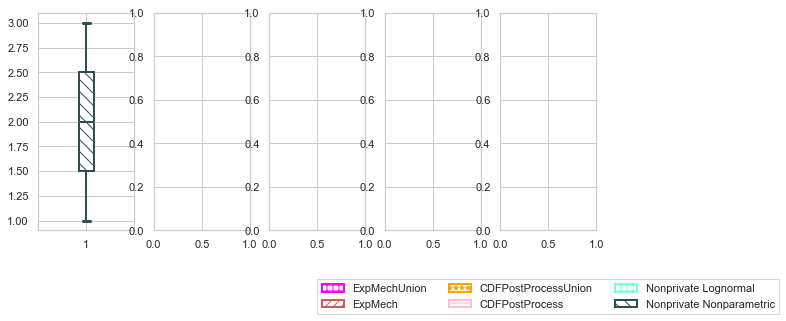

In [257]:
# Legend for box plots
fig, ax = plt.subplots(1, 5, figsize=(10,4))
x =  [1, 2, 3]
y1 = [1, 2, 3]

legend_indices_names = [0, 1, 2, 3, 8, 9]
alg_names = [alg_index[i][1] for i in legend_indices_names]
alg_colors = [colors[i] for i in legend_indices_names]
alg_styles = [styles[i] for i in legend_indices_names]

# Create the sub-plots, assigning a different color for each line.
# Also store the line objects created
handles = []
for i in range(len(alg_names)):
    bp = ax[0].boxplot(y1, patch_artist=True)
    hatch = alg_styles[i]['hatch']
    fill_color = 'white'
    outline_color = alg_styles[i]['color']
    
    plt.setp(bp['caps'], color=outline_color, linewidth=3.0, linestyle='-')
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians']:
        plt.setp(bp[element], color=outline_color, linewidth=2.0)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)  
        patch.set(hatch=hatch, edgecolor=outline_color)
    handles.append(bp['boxes'][0])

# Create the legend
legend = plt.legend(handles = handles, labels=alg_names, loc='upper center', 
             bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=3)
save_path = legend_save_path(dir_path, 'naive-v-new', 'box_plot', 'blackwhite')
analysis.export_legend(legend, save_path)

##  Baseline lognormal data 

In [111]:
# Baseline data for widths 
# Only use this data when parameter is not part of data!
# Otherwise, use lognormal_v1 for n and lognormal_v2 for data_scale)
dataset_name='lognormal_v0'
data_center = 0.5
data_scale = 1.0
n = int(1000)
num_datasets = 1000

for j in range(num_datasets):
    dataset = np.array(st.lognorm.rvs(data_scale, loc=data_center, size=n))
    save_path = 'data/%s_%s.npy' % (dataset_name, str(j))
    np.save(save_path, dataset)
    
true_median = st.lognorm.median(data_scale, loc=data_center)
print(true_median)

1.5


In [ ]:
# Baseline data for coverage 
# Do not use this data for widths!
dataset_name='lognormal_cov'
data_center = 0.5
data_scale = 1.0
n = int(1000)
num_datasets = 10000 # 10,000 datasets to reduce Monte Carlo error

for j in range(num_datasets):
    dataset = np.array(st.lognorm.rvs(data_scale, loc=data_center, size=n))
    save_path = 'data/%s_%s.npy' % (dataset_name, str(j))
    np.save(save_path, dataset)
    
true_median = st.lognorm.median(data_scale, loc=data_center)

In [386]:
# Some coverage plots use flatter dist
# May use this data to compare on widths
dataset_name='lognormal_flat'
data_center = 0.5
data_scale = 5.0
n = int(1000)
num_datasets = 10000 # 10,000 datasets to reduce Monte Carlo error

for j in range(num_datasets):
    dataset = np.array(st.lognorm.rvs(data_scale, loc=data_center, size=n))
    print(np.median(dataset))
    save_path = 'data/%s_%s.npy' % (dataset_name, str(j))
    np.save(save_path, dataset)
    
true_median = st.lognorm.median(data_scale, loc=data_center)

1.949579484217027
1.1860212793596707
1.3238489881555653
1.678716151306233
1.5192915756300533
1.3433146140413408
1.4411922337231555
1.5282080834460972
1.671912669794498
2.036967340948456
1.6937915965173136
1.386454743977482
1.796001135933217
1.6624271015384613
1.403739465137891
1.6664624107785393
1.5054336086408493
1.69123916801323
1.5111442989536699
1.7070627589828495
1.2311939557107945
1.5015365145054522
1.3220645799615502
1.4828034515482016
1.352678148124593
1.6734233702407857
1.388091607518605
1.311812044228832
1.4292125269986156
1.4257776662168438
1.6551183894669297
1.4817043295987786
1.214777723236577
1.2826292623183706
1.6487365646896268
1.867908664805076
1.7985759017202678
1.3625910625582422
1.4624821866968971
1.90201889026075
1.1330977453658622
2.04194477580549
1.3257948330374894
1.7232761467279596
1.4451314524270962
1.2303881078730146
1.5342921786967296
1.4153717833181765
1.6240555660131402
1.5842441140111747
1.89771549568614
1.5457289545038628
1.4346754779161814
1.42923191540

1.6122647380640092
1.6274739034292567
1.4842322539528858
1.630378735063712
1.1278615996235977
1.5086431444281851
1.4133015381310563
1.7417858017648986
1.9086251952819882
1.3694081144832353
1.4816208780443767
1.865661412157928
1.697016446311324
1.79223941258181
1.3576743049827509
1.7413175425506988
1.6468410099291633
1.3477018459074293
1.3712643724016462
1.4450179891334738
2.023559244661216
1.5238996956906259
1.3450507899781996
1.3927967317276428
1.8843261759194565
1.4649757487077606
1.6565640610049472
1.5514957901166546
1.392891416350099
1.5386379903521608
1.7782292707469467
1.3830025417975391
1.3923673715925808
1.4285266313951563
1.39872114454475
1.5761766531072423
1.9001225975546376
1.4218782624950626
1.5011989978607971
1.3486286169737416
1.694146312317018
1.4958899386306745
1.5778176387837506
1.7477302087417437
1.3017570741781275
1.620687598057469
1.3973647563222538
1.626588850336875
1.23004933567411
1.498893061234746
1.6905819242192472
1.4925792439068717
1.2951097811558134
1.433112

1.4975312599160224
1.6311286981598379
1.525840677460267
1.7272804589516384
1.3528549372089702
1.3870991723765451
1.38548471499898
1.4137869437103547
1.4700600486426518
1.4188186640657925
1.6388815919598185
1.58555952843041
1.5932946594851178
1.6856379686948477
1.1626170096152686
1.355861397717075
1.4344912051029581
1.4034289570700202
1.409859516807673
1.702647181556416
1.6063762010673388
1.383998855166888
1.3198469673427473
1.5064511665082083
1.1671655899772733
1.3038335416788926
1.5355394673575216
1.472687877516283
1.7926463487467994
1.4979740379626547
1.5248556454361155
1.7419746846913708
1.192324028641226
1.5204496591069332
1.7676788567345594
1.557847606282891
1.3318899951935415
1.272451557221254
1.3588055364271567
1.608355509228812
1.1204865492203022
1.4414586398738565
1.4530248682073186
1.8539290268620099
1.247961681324293
1.335986571126718
1.3829640337285658
1.3121469226344167
1.4211210297241688
1.7184626000619603
1.161936247835036
1.6732490491615297
1.8226991836037216
1.32721287

1.4930446744355736
1.137869309721226
1.1981230368279752
1.5174917086987798
1.355797307305068
1.389735242052496
1.489799427008685
1.733659860443812
1.3408738054921676
1.6265878304487007
1.8169282406714107
1.381120848320419
1.6394457090028705
1.6040968459504772
1.340161855463458
1.5134867187220977
1.5293620800126744
1.42903265308122
1.3388298048216525
1.7186022437098276
1.7074575455788688
1.4948622936312472
1.6178014129475422
1.586886395928885
1.5615042160127326
1.7019401366694389
1.522493061630574
1.3236197790062139
1.641732287150879
1.4164260276543938
1.3908572317574361
1.574180372081778
2.4327924330554827
1.7371075263244926
1.6603400735331038
1.4348452466447867
1.606933479047797
1.3617786542082104
1.37481761605057
1.863285467804178
1.3261270246552872
1.6072252599945531
1.4974188973506024
1.5362695648975162
1.5315900490712038
1.7850283507868454
2.1302349460172048
1.4389752953025585
1.5382693797299798
1.6073860492160712
1.2991485525655264
1.6957647657374895
1.3702759547682675
1.37329285

1.3320065764205635
1.5756152232900575
1.319782325882895
1.3472008566395528
1.381780412173166
1.4371526275713138
1.3440243088630588
1.517925534741741
1.847015912861179
1.306882963251143
1.405709386017931
1.498853530577486
1.2571217915233226
1.2989184560351648
1.292514648996443
1.5430752457130343
1.6901523298739818
1.4667173809717098
1.9938091363565045
1.2303688185427566
1.5620494690475397
1.3696543778869095
2.0003311430954955
1.2566278680911949
1.821228917670891
1.707571960583834
1.2231825429246905
2.0859061957981306
1.5982659284176401
1.568400812790903
1.1812985248460919
2.1174418335849405
1.6521681850241572
1.1487332113193616
1.3580521992860461
1.3221957151614157
1.5705492890109178
1.5391630784469894
1.5923583590893484
1.3272439612653708
1.3612489487770254
1.653446534912185
1.330654657232404
1.2407171083244242
1.4165987712971166
1.2865789682002124
1.3788314439786116
1.8204013646768757
1.4448950617317995
1.3515108936021316
1.4009404604117512
1.184603529830258
1.2566212358389268
1.32417

1.5965880920585405
1.5776102668725787
1.689048706609753
1.5917994348250564
1.6121109044145334
1.6983368453043886
1.3414349673502701
1.4418138730825483
1.5128742496174379
1.5551020990214006
1.582297194475271
1.4984628695488504
1.262633284100875
1.7923325363088702
1.2559009066521243
1.5139448396469963
1.6268443216494286
1.2551816217028477
1.2258359817209472
1.624938666122581
1.291753106351035
1.3528814567234915
1.4068346283281004
1.767818511815197
1.4539452950474168
1.5593556818313874
1.185738624950738
1.2476844813205958
1.4459266168211626
1.8265953902864542
1.5063995744553544
1.395552097683345
1.5616778213439777
1.43868881819312
1.6168244209061748
1.8829265065711887
1.3677982831662572
1.2223706868312127
1.822243970212908
1.8203796482600951
1.9897826339436744
1.512259735379558
1.2080789768943965
1.9723947136023994
1.3811690539468762
1.5593890267298658
1.6824289431765433
1.1303038876311295
1.6812565114671167
1.1521028792824075
1.5242574965557347
1.7199801186190153
1.7672019788252622
1.360

1.6194508572895376
1.6435080639113342
1.897938162856978
1.459484521950433
1.7938274542809074
1.9481794889144517
1.4561178649406097
1.4805888101539317
1.210995825804333
1.351582575814506
1.4974101550915249
1.3841639821482024
1.3525744651656337
1.2038551774624566
1.1924231932969132
1.471972334148406
1.417954654934492
1.841286487426414
1.4055318156347518
1.5541195315374199
1.6718954167404747
1.4269971151193421
1.3399789991662916
1.676703826335798
1.474174571236348
1.0058438986725355
1.6189884606100717
1.6733339707185655
1.9084002734705958
1.5335324813414122
1.6553363091374327
1.1427094157163196
1.322903984471095
1.6614742334917094
1.5740471719882718
1.2552720987848316
1.9850274680536315
1.2753439154352835
1.6236650651242837
1.3143795406564687
1.6356925085548095
1.481020467883873
1.4394772925454915
1.3002220443235932
1.4801407383995677
1.3240926130496284
1.2782743485872297
1.5204553371825411
1.4145387125486661
1.644232133850626
1.8330823658952897
1.2948019922531009
1.6441151930836944
1.745

# Coverage - varying beta

In [171]:
num_trials = 5
range_center = 5
range_scale = 10 
rho = 1.0
alpha = 0.2
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005

dataset_name='lognormal_cov'
n = 1000
num_datasets = 1000 
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)
print(true_median)
print(st.lognorm.mean(data_scale, loc=data_center))

beta = [0.01, 0.05, 0.09, 0.13, 0.17]
num_params = len(beta)
param_string='beta'
print(param_string, beta)

1.5
2.148721270700128
beta [0.01, 0.05, 0.09, 0.13, 0.17]


In [172]:
imp.reload(run_cis)
imp.reload(wrap)
imp.reload(analysis)
imp.reload(pub)

run_indices = [8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, true_median=true_median, 
                  alpha=alpha, beta=beta, 
                  quantile=quantile, n=n, em_granularity=em_granularity, granularity=granularity,
                  alg_list=algs, rerun_algs=True, gen_preprocess=False)

['Nonpriv_lognormal']
starting Nonpriv lognormal
param 0 of 5
n 1000 lb, ub -inf inf gran 0.05 alpha 0.2 rho 1.0
name, hyperparameters Nonpriv_lognormal_beta_0 {'s': 1, 'loc': 0, 'granularity': 0.05, 'beta': 0.01, 'alpha': 0.2, 'cdp': True}
computing 80% CIs
eps: 1.4142135623730951
dataset 0 of 1000 lognormal_cov lognormal_cov_211.npy
dataset 1 of 1000 lognormal_cov lognormal_cov_577.npy
dataset 2 of 1000 lognormal_cov lognormal_cov_563.npy
dataset 3 of 1000 lognormal_cov lognormal_cov_205.npy
dataset 4 of 1000 lognormal_cov lognormal_cov_239.npy
dataset 5 of 1000 lognormal_cov lognormal_cov_588.npy
dataset 6 of 1000 lognormal_cov lognormal_cov_775.npy
dataset 7 of 1000 lognormal_cov lognormal_cov_761.npy
dataset 8 of 1000 lognormal_cov lognormal_cov_749.npy
dataset 9 of 1000 lognormal_cov lognormal_cov_991.npy
dataset 10 of 1000 lognormal_cov lognormal_cov_985.npy
dataset 11 of 1000 lognormal_cov lognormal_cov_952.npy
dataset 12 of 1000 lognormal_cov lognormal_cov_946.npy
dataset 13 o

dataset 147 of 1000 lognormal_cov lognormal_cov_89.npy
dataset 148 of 1000 lognormal_cov lognormal_cov_88.npy
dataset 149 of 1000 lognormal_cov lognormal_cov_389.npy
dataset 150 of 1000 lognormal_cov lognormal_cov_77.npy
dataset 151 of 1000 lognormal_cov lognormal_cov_362.npy
dataset 152 of 1000 lognormal_cov lognormal_cov_404.npy
dataset 153 of 1000 lognormal_cov lognormal_cov_410.npy
dataset 154 of 1000 lognormal_cov lognormal_cov_63.npy
dataset 155 of 1000 lognormal_cov lognormal_cov_376.npy
dataset 156 of 1000 lognormal_cov lognormal_cov_438.npy
dataset 157 of 1000 lognormal_cov lognormal_cov_809.npy
dataset 158 of 1000 lognormal_cov lognormal_cov_821.npy
dataset 159 of 1000 lognormal_cov lognormal_cov_835.npy
dataset 160 of 1000 lognormal_cov lognormal_cov_606.npy
dataset 161 of 1000 lognormal_cov lognormal_cov_160.npy
dataset 162 of 1000 lognormal_cov lognormal_cov_174.npy
dataset 163 of 1000 lognormal_cov lognormal_cov_612.npy
dataset 164 of 1000 lognormal_cov lognormal_cov_148.

dataset 315 of 1000 lognormal_cov lognormal_cov_311.npy
dataset 316 of 1000 lognormal_cov lognormal_cov_10.npy
dataset 317 of 1000 lognormal_cov lognormal_cov_305.npy
dataset 318 of 1000 lognormal_cov lognormal_cov_463.npy
dataset 319 of 1000 lognormal_cov lognormal_cov_38.npy
dataset 320 of 1000 lognormal_cov lognormal_cov_339.npy
dataset 321 of 1000 lognormal_cov lognormal_cov_488.npy
dataset 322 of 1000 lognormal_cov lognormal_cov_489.npy
dataset 323 of 1000 lognormal_cov lognormal_cov_338.npy
dataset 324 of 1000 lognormal_cov lognormal_cov_39.npy
dataset 325 of 1000 lognormal_cov lognormal_cov_304.npy
dataset 326 of 1000 lognormal_cov lognormal_cov_11.npy
dataset 327 of 1000 lognormal_cov lognormal_cov_462.npy
dataset 328 of 1000 lognormal_cov lognormal_cov_476.npy
dataset 329 of 1000 lognormal_cov lognormal_cov_310.npy
dataset 330 of 1000 lognormal_cov lognormal_cov_847.npy
dataset 331 of 1000 lognormal_cov lognormal_cov_853.npy
dataset 332 of 1000 lognormal_cov lognormal_cov_884.

dataset 467 of 1000 lognormal_cov lognormal_cov_521.npy
dataset 468 of 1000 lognormal_cov lognormal_cov_509.npy
dataset 469 of 1000 lognormal_cov lognormal_cov_290.npy
dataset 470 of 1000 lognormal_cov lognormal_cov_284.npy
dataset 471 of 1000 lognormal_cov lognormal_cov_737.npy
dataset 472 of 1000 lognormal_cov lognormal_cov_723.npy
dataset 473 of 1000 lognormal_cov lognormal_cov_938.npy
dataset 474 of 1000 lognormal_cov lognormal_cov_910.npy
dataset 475 of 1000 lognormal_cov lognormal_cov_904.npy
dataset 476 of 1000 lognormal_cov lognormal_cov_125.npy
dataset 477 of 1000 lognormal_cov lognormal_cov_643.npy
dataset 478 of 1000 lognormal_cov lognormal_cov_657.npy
dataset 479 of 1000 lognormal_cov lognormal_cov_131.npy
dataset 480 of 1000 lognormal_cov lognormal_cov_119.npy
dataset 481 of 1000 lognormal_cov lognormal_cov_680.npy
dataset 482 of 1000 lognormal_cov lognormal_cov_858.npy
dataset 483 of 1000 lognormal_cov lognormal_cov_694.npy
dataset 484 of 1000 lognormal_cov lognormal_cov_

dataset 614 of 1000 lognormal_cov lognormal_cov_309.npy
dataset 615 of 1000 lognormal_cov lognormal_cov_335.npy
dataset 616 of 1000 lognormal_cov lognormal_cov_20.npy
dataset 617 of 1000 lognormal_cov lognormal_cov_453.npy
dataset 618 of 1000 lognormal_cov lognormal_cov_447.npy
dataset 619 of 1000 lognormal_cov lognormal_cov_321.npy
dataset 620 of 1000 lognormal_cov lognormal_cov_34.npy
dataset 621 of 1000 lognormal_cov lognormal_cov_490.npy
dataset 622 of 1000 lognormal_cov lognormal_cov_484.npy
dataset 623 of 1000 lognormal_cov lognormal_cov_485.npy
dataset 624 of 1000 lognormal_cov lognormal_cov_491.npy
dataset 625 of 1000 lognormal_cov lognormal_cov_446.npy
dataset 626 of 1000 lognormal_cov lognormal_cov_35.npy
dataset 627 of 1000 lognormal_cov lognormal_cov_320.npy
dataset 628 of 1000 lognormal_cov lognormal_cov_21.npy
dataset 629 of 1000 lognormal_cov lognormal_cov_334.npy
dataset 630 of 1000 lognormal_cov lognormal_cov_452.npy
dataset 631 of 1000 lognormal_cov lognormal_cov_308.

dataset 768 of 1000 lognormal_cov lognormal_cov_609.npy
dataset 769 of 1000 lognormal_cov lognormal_cov_153.npy
dataset 770 of 1000 lognormal_cov lognormal_cov_635.npy
dataset 771 of 1000 lognormal_cov lognormal_cov_621.npy
dataset 772 of 1000 lognormal_cov lognormal_cov_147.npy
dataset 773 of 1000 lognormal_cov lognormal_cov_966.npy
dataset 774 of 1000 lognormal_cov lognormal_cov_972.npy
dataset 775 of 1000 lognormal_cov lognormal_cov_782.npy
dataset 776 of 1000 lognormal_cov lognormal_cov_796.npy
dataset 777 of 1000 lognormal_cov lognormal_cov_769.npy
dataset 778 of 1000 lognormal_cov lognormal_cov_999.npy
dataset 779 of 1000 lognormal_cov lognormal_cov_741.npy
dataset 780 of 1000 lognormal_cov lognormal_cov_755.npy
dataset 781 of 1000 lognormal_cov lognormal_cov_580.npy
dataset 782 of 1000 lognormal_cov lognormal_cov_594.npy
dataset 783 of 1000 lognormal_cov lognormal_cov_219.npy
dataset 784 of 1000 lognormal_cov lognormal_cov_543.npy
dataset 785 of 1000 lognormal_cov lognormal_cov_

dataset 916 of 1000 lognormal_cov lognormal_cov_784.npy
dataset 917 of 1000 lognormal_cov lognormal_cov_974.npy
dataset 918 of 1000 lognormal_cov lognormal_cov_960.npy
dataset 919 of 1000 lognormal_cov lognormal_cov_753.npy
dataset 920 of 1000 lognormal_cov lognormal_cov_747.npy
dataset 921 of 1000 lognormal_cov lognormal_cov_592.npy
dataset 922 of 1000 lognormal_cov lognormal_cov_586.npy
dataset 923 of 1000 lognormal_cov lognormal_cov_237.npy
dataset 924 of 1000 lognormal_cov lognormal_cov_551.npy
dataset 925 of 1000 lognormal_cov lognormal_cov_545.npy
dataset 926 of 1000 lognormal_cov lognormal_cov_223.npy
dataset 927 of 1000 lognormal_cov lognormal_cov_579.npy
dataset 928 of 1000 lognormal_cov lognormal_cov_209.npy
dataset 929 of 1000 lognormal_cov lognormal_cov_553.npy
dataset 930 of 1000 lognormal_cov lognormal_cov_235.npy
dataset 931 of 1000 lognormal_cov lognormal_cov_221.npy
dataset 932 of 1000 lognormal_cov lognormal_cov_547.npy
dataset 933 of 1000 lognormal_cov lognormal_cov_

dataset 69 of 1000 lognormal_cov lognormal_cov_951.npy
dataset 70 of 1000 lognormal_cov lognormal_cov_789.npy
dataset 71 of 1000 lognormal_cov lognormal_cov_616.npy
dataset 72 of 1000 lognormal_cov lognormal_cov_170.npy
dataset 73 of 1000 lognormal_cov lognormal_cov_164.npy
dataset 74 of 1000 lognormal_cov lognormal_cov_602.npy
dataset 75 of 1000 lognormal_cov lognormal_cov_158.npy
dataset 76 of 1000 lognormal_cov lognormal_cov_819.npy
dataset 77 of 1000 lognormal_cov lognormal_cov_831.npy
dataset 78 of 1000 lognormal_cov lognormal_cov_825.npy
dataset 79 of 1000 lognormal_cov lognormal_cov_67.npy
dataset 80 of 1000 lognormal_cov lognormal_cov_372.npy
dataset 81 of 1000 lognormal_cov lognormal_cov_414.npy
dataset 82 of 1000 lognormal_cov lognormal_cov_400.npy
dataset 83 of 1000 lognormal_cov lognormal_cov_73.npy
dataset 84 of 1000 lognormal_cov lognormal_cov_366.npy
dataset 85 of 1000 lognormal_cov lognormal_cov_428.npy
dataset 86 of 1000 lognormal_cov lognormal_cov_98.npy
dataset 87 of

dataset 219 of 1000 lognormal_cov lognormal_cov_177.npy
dataset 220 of 1000 lognormal_cov lognormal_cov_163.npy
dataset 221 of 1000 lognormal_cov lognormal_cov_605.npy
dataset 222 of 1000 lognormal_cov lognormal_cov_639.npy
dataset 223 of 1000 lognormal_cov lognormal_cov_942.npy
dataset 224 of 1000 lognormal_cov lognormal_cov_956.npy
dataset 225 of 1000 lognormal_cov lognormal_cov_765.npy
dataset 226 of 1000 lognormal_cov lognormal_cov_771.npy
dataset 227 of 1000 lognormal_cov lognormal_cov_981.npy
dataset 228 of 1000 lognormal_cov lognormal_cov_759.npy
dataset 229 of 1000 lognormal_cov lognormal_cov_995.npy
dataset 230 of 1000 lognormal_cov lognormal_cov_598.npy
dataset 231 of 1000 lognormal_cov lognormal_cov_201.npy
dataset 232 of 1000 lognormal_cov lognormal_cov_567.npy
dataset 233 of 1000 lognormal_cov lognormal_cov_573.npy
dataset 234 of 1000 lognormal_cov lognormal_cov_215.npy
dataset 235 of 1000 lognormal_cov lognormal_cov_229.npy
dataset 236 of 1000 lognormal_cov lognormal_cov_

dataset 376 of 1000 lognormal_cov lognormal_cov_15.npy
dataset 377 of 1000 lognormal_cov lognormal_cov_499.npy
dataset 378 of 1000 lognormal_cov lognormal_cov_498.npy
dataset 379 of 1000 lognormal_cov lognormal_cov_467.npy
dataset 380 of 1000 lognormal_cov lognormal_cov_14.npy
dataset 381 of 1000 lognormal_cov lognormal_cov_301.npy
dataset 382 of 1000 lognormal_cov lognormal_cov_315.npy
dataset 383 of 1000 lognormal_cov lognormal_cov_473.npy
dataset 384 of 1000 lognormal_cov lognormal_cov_28.npy
dataset 385 of 1000 lognormal_cov lognormal_cov_329.npy
dataset 386 of 1000 lognormal_cov lognormal_cov_842.npy
dataset 387 of 1000 lognormal_cov lognormal_cov_856.npy
dataset 388 of 1000 lognormal_cov lognormal_cov_4.npy
dataset 389 of 1000 lognormal_cov lognormal_cov_103.npy
dataset 390 of 1000 lognormal_cov lognormal_cov_665.npy
dataset 391 of 1000 lognormal_cov lognormal_cov_671.npy
dataset 392 of 1000 lognormal_cov lognormal_cov_117.npy
dataset 393 of 1000 lognormal_cov lognormal_cov_659.n

dataset 532 of 1000 lognormal_cov lognormal_cov_293.npy
dataset 533 of 1000 lognormal_cov lognormal_cov_720.npy
dataset 534 of 1000 lognormal_cov lognormal_cov_734.npy
dataset 535 of 1000 lognormal_cov lognormal_cov_708.npy
dataset 536 of 1000 lognormal_cov lognormal_cov_907.npy
dataset 537 of 1000 lognormal_cov lognormal_cov_913.npy
dataset 538 of 1000 lognormal_cov lognormal_cov_132.npy
dataset 539 of 1000 lognormal_cov lognormal_cov_654.npy
dataset 540 of 1000 lognormal_cov lognormal_cov_898.npy
dataset 541 of 1000 lognormal_cov lognormal_cov_640.npy
dataset 542 of 1000 lognormal_cov lognormal_cov_126.npy
dataset 543 of 1000 lognormal_cov lognormal_cov_9.npy
dataset 544 of 1000 lognormal_cov lognormal_cov_668.npy
dataset 545 of 1000 lognormal_cov lognormal_cov_697.npy
dataset 546 of 1000 lognormal_cov lognormal_cov_683.npy
dataset 547 of 1000 lognormal_cov lognormal_cov_873.npy
dataset 548 of 1000 lognormal_cov lognormal_cov_867.npy
dataset 549 of 1000 lognormal_cov lognormal_cov_45

dataset 697 of 1000 lognormal_cov lognormal_cov_874.npy
dataset 698 of 1000 lognormal_cov lognormal_cov_860.npy
dataset 699 of 1000 lognormal_cov lognormal_cov_135.npy
dataset 700 of 1000 lognormal_cov lognormal_cov_653.npy
dataset 701 of 1000 lognormal_cov lognormal_cov_647.npy
dataset 702 of 1000 lognormal_cov lognormal_cov_121.npy
dataset 703 of 1000 lognormal_cov lognormal_cov_109.npy
dataset 704 of 1000 lognormal_cov lognormal_cov_928.npy
dataset 705 of 1000 lognormal_cov lognormal_cov_900.npy
dataset 706 of 1000 lognormal_cov lognormal_cov_914.npy
dataset 707 of 1000 lognormal_cov lognormal_cov_727.npy
dataset 708 of 1000 lognormal_cov lognormal_cov_733.npy
dataset 709 of 1000 lognormal_cov lognormal_cov_280.npy
dataset 710 of 1000 lognormal_cov lognormal_cov_294.npy
dataset 711 of 1000 lognormal_cov lognormal_cov_525.npy
dataset 712 of 1000 lognormal_cov lognormal_cov_243.npy
dataset 713 of 1000 lognormal_cov lognormal_cov_257.npy
dataset 714 of 1000 lognormal_cov lognormal_cov_

dataset 869 of 1000 lognormal_cov lognormal_cov_785.npy
dataset 870 of 1000 lognormal_cov lognormal_cov_949.npy
dataset 871 of 1000 lognormal_cov lognormal_cov_791.npy
dataset 872 of 1000 lognormal_cov lognormal_cov_168.npy
dataset 873 of 1000 lognormal_cov lognormal_cov_154.npy
dataset 874 of 1000 lognormal_cov lognormal_cov_632.npy
dataset 875 of 1000 lognormal_cov lognormal_cov_626.npy
dataset 876 of 1000 lognormal_cov lognormal_cov_140.npy
dataset 877 of 1000 lognormal_cov lognormal_cov_815.npy
dataset 878 of 1000 lognormal_cov lognormal_cov_801.npy
dataset 879 of 1000 lognormal_cov lognormal_cov_197.npy
dataset 880 of 1000 lognormal_cov lognormal_cov_829.npy
dataset 881 of 1000 lognormal_cov lognormal_cov_183.npy
dataset 882 of 1000 lognormal_cov lognormal_cov_418.npy
dataset 883 of 1000 lognormal_cov lognormal_cov_430.npy
dataset 884 of 1000 lognormal_cov lognormal_cov_356.npy
dataset 885 of 1000 lognormal_cov lognormal_cov_43.npy
dataset 886 of 1000 lognormal_cov lognormal_cov_3

dataset 17 of 1000 lognormal_cov lognormal_cov_629.npy
dataset 18 of 1000 lognormal_cov lognormal_cov_826.npy
dataset 19 of 1000 lognormal_cov lognormal_cov_198.npy
dataset 20 of 1000 lognormal_cov lognormal_cov_832.npy
dataset 21 of 1000 lognormal_cov lognormal_cov_70.npy
dataset 22 of 1000 lognormal_cov lognormal_cov_365.npy
dataset 23 of 1000 lognormal_cov lognormal_cov_403.npy
dataset 24 of 1000 lognormal_cov lognormal_cov_417.npy
dataset 25 of 1000 lognormal_cov lognormal_cov_64.npy
dataset 26 of 1000 lognormal_cov lognormal_cov_371.npy
dataset 27 of 1000 lognormal_cov lognormal_cov_359.npy
dataset 28 of 1000 lognormal_cov lognormal_cov_58.npy
dataset 29 of 1000 lognormal_cov lognormal_cov_59.npy
dataset 30 of 1000 lognormal_cov lognormal_cov_358.npy
dataset 31 of 1000 lognormal_cov lognormal_cov_416.npy
dataset 32 of 1000 lognormal_cov lognormal_cov_370.npy
dataset 33 of 1000 lognormal_cov lognormal_cov_65.npy
dataset 34 of 1000 lognormal_cov lognormal_cov_364.npy
dataset 35 of 1

dataset 168 of 1000 lognormal_cov lognormal_cov_941.npy
dataset 169 of 1000 lognormal_cov lognormal_cov_772.npy
dataset 170 of 1000 lognormal_cov lognormal_cov_766.npy
dataset 171 of 1000 lognormal_cov lognormal_cov_996.npy
dataset 172 of 1000 lognormal_cov lognormal_cov_982.npy
dataset 173 of 1000 lognormal_cov lognormal_cov_216.npy
dataset 174 of 1000 lognormal_cov lognormal_cov_570.npy
dataset 175 of 1000 lognormal_cov lognormal_cov_564.npy
dataset 176 of 1000 lognormal_cov lognormal_cov_202.npy
dataset 177 of 1000 lognormal_cov lognormal_cov_558.npy
dataset 178 of 1000 lognormal_cov lognormal_cov_228.npy
dataset 179 of 1000 lognormal_cov lognormal_cov_572.npy
dataset 180 of 1000 lognormal_cov lognormal_cov_214.npy
dataset 181 of 1000 lognormal_cov lognormal_cov_200.npy
dataset 182 of 1000 lognormal_cov lognormal_cov_566.npy
dataset 183 of 1000 lognormal_cov lognormal_cov_599.npy
dataset 184 of 1000 lognormal_cov lognormal_cov_994.npy
dataset 185 of 1000 lognormal_cov lognormal_cov_

dataset 337 of 1000 lognormal_cov lognormal_cov_106.npy
dataset 338 of 1000 lognormal_cov lognormal_cov_112.npy
dataset 339 of 1000 lognormal_cov lognormal_cov_674.npy
dataset 340 of 1000 lognormal_cov lognormal_cov_933.npy
dataset 341 of 1000 lognormal_cov lognormal_cov_927.npy
dataset 342 of 1000 lognormal_cov lognormal_cov_728.npy
dataset 343 of 1000 lognormal_cov lognormal_cov_714.npy
dataset 344 of 1000 lognormal_cov lognormal_cov_700.npy
dataset 345 of 1000 lognormal_cov lognormal_cov_258.npy
dataset 346 of 1000 lognormal_cov lognormal_cov_270.npy
dataset 347 of 1000 lognormal_cov lognormal_cov_516.npy
dataset 348 of 1000 lognormal_cov lognormal_cov_502.npy
dataset 349 of 1000 lognormal_cov lognormal_cov_264.npy
dataset 350 of 1000 lognormal_cov lognormal_cov_248.npy
dataset 351 of 1000 lognormal_cov lognormal_cov_260.npy
dataset 352 of 1000 lognormal_cov lognormal_cov_506.npy
dataset 353 of 1000 lognormal_cov lognormal_cov_512.npy
dataset 354 of 1000 lognormal_cov lognormal_cov_

dataset 509 of 1000 lognormal_cov lognormal_cov_118.npy
dataset 510 of 1000 lognormal_cov lognormal_cov_656.npy
dataset 511 of 1000 lognormal_cov lognormal_cov_130.npy
dataset 512 of 1000 lognormal_cov lognormal_cov_124.npy
dataset 513 of 1000 lognormal_cov lognormal_cov_642.npy
dataset 514 of 1000 lognormal_cov lognormal_cov_905.npy
dataset 515 of 1000 lognormal_cov lognormal_cov_911.npy
dataset 516 of 1000 lognormal_cov lognormal_cov_939.npy
dataset 517 of 1000 lognormal_cov lognormal_cov_722.npy
dataset 518 of 1000 lognormal_cov lognormal_cov_736.npy
dataset 519 of 1000 lognormal_cov lognormal_cov_285.npy
dataset 520 of 1000 lognormal_cov lognormal_cov_291.npy
dataset 521 of 1000 lognormal_cov lognormal_cov_508.npy
dataset 522 of 1000 lognormal_cov lognormal_cov_246.npy
dataset 523 of 1000 lognormal_cov lognormal_cov_520.npy
dataset 524 of 1000 lognormal_cov lognormal_cov_534.npy
dataset 525 of 1000 lognormal_cov lognormal_cov_252.npy
dataset 526 of 1000 lognormal_cov lognormal_cov_

dataset 657 of 1000 lognormal_cov lognormal_cov_524.npy
dataset 658 of 1000 lognormal_cov lognormal_cov_242.npy
dataset 659 of 1000 lognormal_cov lognormal_cov_295.npy
dataset 660 of 1000 lognormal_cov lognormal_cov_281.npy
dataset 661 of 1000 lognormal_cov lognormal_cov_732.npy
dataset 662 of 1000 lognormal_cov lognormal_cov_726.npy
dataset 663 of 1000 lognormal_cov lognormal_cov_915.npy
dataset 664 of 1000 lognormal_cov lognormal_cov_901.npy
dataset 665 of 1000 lognormal_cov lognormal_cov_929.npy
dataset 666 of 1000 lognormal_cov lognormal_cov_108.npy
dataset 667 of 1000 lognormal_cov lognormal_cov_646.npy
dataset 668 of 1000 lognormal_cov lognormal_cov_120.npy
dataset 669 of 1000 lognormal_cov lognormal_cov_134.npy
dataset 670 of 1000 lognormal_cov lognormal_cov_652.npy
dataset 671 of 1000 lognormal_cov lognormal_cov_861.npy
dataset 672 of 1000 lognormal_cov lognormal_cov_875.npy
dataset 673 of 1000 lognormal_cov lognormal_cov_685.npy
dataset 674 of 1000 lognormal_cov lognormal_cov_

dataset 811 of 1000 lognormal_cov lognormal_cov_804.npy
dataset 812 of 1000 lognormal_cov lognormal_cov_46.npy
dataset 813 of 1000 lognormal_cov lognormal_cov_353.npy
dataset 814 of 1000 lognormal_cov lognormal_cov_435.npy
dataset 815 of 1000 lognormal_cov lognormal_cov_421.npy
dataset 816 of 1000 lognormal_cov lognormal_cov_52.npy
dataset 817 of 1000 lognormal_cov lognormal_cov_347.npy
dataset 818 of 1000 lognormal_cov lognormal_cov_409.npy
dataset 819 of 1000 lognormal_cov lognormal_cov_85.npy
dataset 820 of 1000 lognormal_cov lognormal_cov_390.npy
dataset 821 of 1000 lognormal_cov lognormal_cov_91.npy
dataset 822 of 1000 lognormal_cov lognormal_cov_384.npy
dataset 823 of 1000 lognormal_cov lognormal_cov_385.npy
dataset 824 of 1000 lognormal_cov lognormal_cov_90.npy
dataset 825 of 1000 lognormal_cov lognormal_cov_391.npy
dataset 826 of 1000 lognormal_cov lognormal_cov_84.npy
dataset 827 of 1000 lognormal_cov lognormal_cov_408.npy
dataset 828 of 1000 lognormal_cov lognormal_cov_420.np

dataset 979 of 1000 lognormal_cov lognormal_cov_803.npy
dataset 980 of 1000 lognormal_cov lognormal_cov_630.npy
dataset 981 of 1000 lognormal_cov lognormal_cov_156.npy
dataset 982 of 1000 lognormal_cov lognormal_cov_142.npy
dataset 983 of 1000 lognormal_cov lognormal_cov_624.npy
dataset 984 of 1000 lognormal_cov lognormal_cov_618.npy
dataset 985 of 1000 lognormal_cov lognormal_cov_787.npy
dataset 986 of 1000 lognormal_cov lognormal_cov_793.npy
dataset 987 of 1000 lognormal_cov lognormal_cov_963.npy
dataset 988 of 1000 lognormal_cov lognormal_cov_977.npy
dataset 989 of 1000 lognormal_cov lognormal_cov_744.npy
dataset 990 of 1000 lognormal_cov lognormal_cov_988.npy
dataset 991 of 1000 lognormal_cov lognormal_cov_750.npy
dataset 992 of 1000 lognormal_cov lognormal_cov_778.npy
dataset 993 of 1000 lognormal_cov lognormal_cov_585.npy
dataset 994 of 1000 lognormal_cov lognormal_cov_591.npy
dataset 995 of 1000 lognormal_cov lognormal_cov_220.npy
dataset 996 of 1000 lognormal_cov lognormal_cov_

dataset 121 of 1000 lognormal_cov lognormal_cov_217.npy
dataset 122 of 1000 lognormal_cov lognormal_cov_571.npy
dataset 123 of 1000 lognormal_cov lognormal_cov_983.npy
dataset 124 of 1000 lognormal_cov lognormal_cov_997.npy
dataset 125 of 1000 lognormal_cov lognormal_cov_767.npy
dataset 126 of 1000 lognormal_cov lognormal_cov_773.npy
dataset 127 of 1000 lognormal_cov lognormal_cov_940.npy
dataset 128 of 1000 lognormal_cov lognormal_cov_798.npy
dataset 129 of 1000 lognormal_cov lognormal_cov_954.npy
dataset 130 of 1000 lognormal_cov lognormal_cov_968.npy
dataset 131 of 1000 lognormal_cov lognormal_cov_149.npy
dataset 132 of 1000 lognormal_cov lognormal_cov_175.npy
dataset 133 of 1000 lognormal_cov lognormal_cov_613.npy
dataset 134 of 1000 lognormal_cov lognormal_cov_607.npy
dataset 135 of 1000 lognormal_cov lognormal_cov_161.npy
dataset 136 of 1000 lognormal_cov lognormal_cov_834.npy
dataset 137 of 1000 lognormal_cov lognormal_cov_820.npy
dataset 138 of 1000 lognormal_cov lognormal_cov_

dataset 282 of 1000 lognormal_cov lognormal_cov_663.npy
dataset 283 of 1000 lognormal_cov lognormal_cov_924.npy
dataset 284 of 1000 lognormal_cov lognormal_cov_930.npy
dataset 285 of 1000 lognormal_cov lognormal_cov_918.npy
dataset 286 of 1000 lognormal_cov lognormal_cov_703.npy
dataset 287 of 1000 lognormal_cov lognormal_cov_717.npy
dataset 288 of 1000 lognormal_cov lognormal_cov_298.npy
dataset 289 of 1000 lognormal_cov lognormal_cov_529.npy
dataset 290 of 1000 lognormal_cov lognormal_cov_267.npy
dataset 291 of 1000 lognormal_cov lognormal_cov_501.npy
dataset 292 of 1000 lognormal_cov lognormal_cov_515.npy
dataset 293 of 1000 lognormal_cov lognormal_cov_273.npy
dataset 294 of 1000 lognormal_cov lognormal_cov_503.npy
dataset 295 of 1000 lognormal_cov lognormal_cov_265.npy
dataset 296 of 1000 lognormal_cov lognormal_cov_271.npy
dataset 297 of 1000 lognormal_cov lognormal_cov_517.npy
dataset 298 of 1000 lognormal_cov lognormal_cov_259.npy
dataset 299 of 1000 lognormal_cov lognormal_cov_

dataset 429 of 1000 lognormal_cov lognormal_cov_459.npy
dataset 430 of 1000 lognormal_cov lognormal_cov_303.npy
dataset 431 of 1000 lognormal_cov lognormal_cov_16.npy
dataset 432 of 1000 lognormal_cov lognormal_cov_465.npy
dataset 433 of 1000 lognormal_cov lognormal_cov_471.npy
dataset 434 of 1000 lognormal_cov lognormal_cov_317.npy
dataset 435 of 1000 lognormal_cov lognormal_cov_470.npy
dataset 436 of 1000 lognormal_cov lognormal_cov_316.npy
dataset 437 of 1000 lognormal_cov lognormal_cov_17.npy
dataset 438 of 1000 lognormal_cov lognormal_cov_302.npy
dataset 439 of 1000 lognormal_cov lognormal_cov_464.npy
dataset 440 of 1000 lognormal_cov lognormal_cov_458.npy
dataset 441 of 1000 lognormal_cov lognormal_cov_869.npy
dataset 442 of 1000 lognormal_cov lognormal_cov_855.npy
dataset 443 of 1000 lognormal_cov lognormal_cov_841.npy
dataset 444 of 1000 lognormal_cov lognormal_cov_699.npy
dataset 445 of 1000 lognormal_cov lognormal_cov_114.npy
dataset 446 of 1000 lognormal_cov lognormal_cov_67

dataset 579 of 1000 lognormal_cov lognormal_cov_655.npy
dataset 580 of 1000 lognormal_cov lognormal_cov_912.npy
dataset 581 of 1000 lognormal_cov lognormal_cov_906.npy
dataset 582 of 1000 lognormal_cov lognormal_cov_709.npy
dataset 583 of 1000 lognormal_cov lognormal_cov_735.npy
dataset 584 of 1000 lognormal_cov lognormal_cov_721.npy
dataset 585 of 1000 lognormal_cov lognormal_cov_292.npy
dataset 586 of 1000 lognormal_cov lognormal_cov_286.npy
dataset 587 of 1000 lognormal_cov lognormal_cov_279.npy
dataset 588 of 1000 lognormal_cov lognormal_cov_251.npy
dataset 589 of 1000 lognormal_cov lognormal_cov_537.npy
dataset 590 of 1000 lognormal_cov lognormal_cov_523.npy
dataset 591 of 1000 lognormal_cov lognormal_cov_245.npy
dataset 592 of 1000 lognormal_cov lognormal_cov_269.npy
dataset 593 of 1000 lognormal_cov lognormal_cov_241.npy
dataset 594 of 1000 lognormal_cov lognormal_cov_527.npy
dataset 595 of 1000 lognormal_cov lognormal_cov_533.npy
dataset 596 of 1000 lognormal_cov lognormal_cov_

dataset 729 of 1000 lognormal_cov lognormal_cov_973.npy
dataset 730 of 1000 lognormal_cov lognormal_cov_967.npy
dataset 731 of 1000 lognormal_cov lognormal_cov_620.npy
dataset 732 of 1000 lognormal_cov lognormal_cov_146.npy
dataset 733 of 1000 lognormal_cov lognormal_cov_152.npy
dataset 734 of 1000 lognormal_cov lognormal_cov_634.npy
dataset 735 of 1000 lognormal_cov lognormal_cov_608.npy
dataset 736 of 1000 lognormal_cov lognormal_cov_185.npy
dataset 737 of 1000 lognormal_cov lognormal_cov_191.npy
dataset 738 of 1000 lognormal_cov lognormal_cov_807.npy
dataset 739 of 1000 lognormal_cov lognormal_cov_813.npy
dataset 740 of 1000 lognormal_cov lognormal_cov_51.npy
dataset 741 of 1000 lognormal_cov lognormal_cov_344.npy
dataset 742 of 1000 lognormal_cov lognormal_cov_422.npy
dataset 743 of 1000 lognormal_cov lognormal_cov_436.npy
dataset 744 of 1000 lognormal_cov lognormal_cov_45.npy
dataset 745 of 1000 lognormal_cov lognormal_cov_350.npy
dataset 746 of 1000 lognormal_cov lognormal_cov_37

dataset 890 of 1000 lognormal_cov lognormal_cov_80.npy
dataset 891 of 1000 lognormal_cov lognormal_cov_381.npy
dataset 892 of 1000 lognormal_cov lognormal_cov_94.npy
dataset 893 of 1000 lognormal_cov lognormal_cov_95.npy
dataset 894 of 1000 lognormal_cov lognormal_cov_380.npy
dataset 895 of 1000 lognormal_cov lognormal_cov_81.npy
dataset 896 of 1000 lognormal_cov lognormal_cov_394.npy
dataset 897 of 1000 lognormal_cov lognormal_cov_56.npy
dataset 898 of 1000 lognormal_cov lognormal_cov_343.npy
dataset 899 of 1000 lognormal_cov lognormal_cov_425.npy
dataset 900 of 1000 lognormal_cov lognormal_cov_431.npy
dataset 901 of 1000 lognormal_cov lognormal_cov_42.npy
dataset 902 of 1000 lognormal_cov lognormal_cov_357.npy
dataset 903 of 1000 lognormal_cov lognormal_cov_419.npy
dataset 904 of 1000 lognormal_cov lognormal_cov_182.npy
dataset 905 of 1000 lognormal_cov lognormal_cov_196.npy
dataset 906 of 1000 lognormal_cov lognormal_cov_828.npy
dataset 907 of 1000 lognormal_cov lognormal_cov_800.np

dataset 47 of 1000 lognormal_cov lognormal_cov_984.npy
dataset 48 of 1000 lognormal_cov lognormal_cov_990.npy
dataset 49 of 1000 lognormal_cov lognormal_cov_748.npy
dataset 50 of 1000 lognormal_cov lognormal_cov_760.npy
dataset 51 of 1000 lognormal_cov lognormal_cov_774.npy
dataset 52 of 1000 lognormal_cov lognormal_cov_589.npy
dataset 53 of 1000 lognormal_cov lognormal_cov_238.npy
dataset 54 of 1000 lognormal_cov lognormal_cov_562.npy
dataset 55 of 1000 lognormal_cov lognormal_cov_204.npy
dataset 56 of 1000 lognormal_cov lognormal_cov_210.npy
dataset 57 of 1000 lognormal_cov lognormal_cov_576.npy
dataset 58 of 1000 lognormal_cov lognormal_cov_206.npy
dataset 59 of 1000 lognormal_cov lognormal_cov_560.npy
dataset 60 of 1000 lognormal_cov lognormal_cov_574.npy
dataset 61 of 1000 lognormal_cov lognormal_cov_212.npy
dataset 62 of 1000 lognormal_cov lognormal_cov_548.npy
dataset 63 of 1000 lognormal_cov lognormal_cov_762.npy
dataset 64 of 1000 lognormal_cov lognormal_cov_776.npy
dataset 65

dataset 200 of 1000 lognormal_cov lognormal_cov_348.npy
dataset 201 of 1000 lognormal_cov lognormal_cov_406.npy
dataset 202 of 1000 lognormal_cov lognormal_cov_360.npy
dataset 203 of 1000 lognormal_cov lognormal_cov_75.npy
dataset 204 of 1000 lognormal_cov lognormal_cov_374.npy
dataset 205 of 1000 lognormal_cov lognormal_cov_61.npy
dataset 206 of 1000 lognormal_cov lognormal_cov_412.npy
dataset 207 of 1000 lognormal_cov lognormal_cov_60.npy
dataset 208 of 1000 lognormal_cov lognormal_cov_375.npy
dataset 209 of 1000 lognormal_cov lognormal_cov_413.npy
dataset 210 of 1000 lognormal_cov lognormal_cov_407.npy
dataset 211 of 1000 lognormal_cov lognormal_cov_74.npy
dataset 212 of 1000 lognormal_cov lognormal_cov_361.npy
dataset 213 of 1000 lognormal_cov lognormal_cov_349.npy
dataset 214 of 1000 lognormal_cov lognormal_cov_48.npy
dataset 215 of 1000 lognormal_cov lognormal_cov_836.npy
dataset 216 of 1000 lognormal_cov lognormal_cov_188.npy
dataset 217 of 1000 lognormal_cov lognormal_cov_822.n

dataset 352 of 1000 lognormal_cov lognormal_cov_506.npy
dataset 353 of 1000 lognormal_cov lognormal_cov_512.npy
dataset 354 of 1000 lognormal_cov lognormal_cov_274.npy
dataset 355 of 1000 lognormal_cov lognormal_cov_738.npy
dataset 356 of 1000 lognormal_cov lognormal_cov_704.npy
dataset 357 of 1000 lognormal_cov lognormal_cov_710.npy
dataset 358 of 1000 lognormal_cov lognormal_cov_923.npy
dataset 359 of 1000 lognormal_cov lognormal_cov_937.npy
dataset 360 of 1000 lognormal_cov lognormal_cov_894.npy
dataset 361 of 1000 lognormal_cov lognormal_cov_880.npy
dataset 362 of 1000 lognormal_cov lognormal_cov_658.npy
dataset 363 of 1000 lognormal_cov lognormal_cov_670.npy
dataset 364 of 1000 lognormal_cov lognormal_cov_116.npy
dataset 365 of 1000 lognormal_cov lognormal_cov_102.npy
dataset 366 of 1000 lognormal_cov lognormal_cov_5.npy
dataset 367 of 1000 lognormal_cov lognormal_cov_664.npy
dataset 368 of 1000 lognormal_cov lognormal_cov_857.npy
dataset 369 of 1000 lognormal_cov lognormal_cov_84

dataset 507 of 1000 lognormal_cov lognormal_cov_859.npy
dataset 508 of 1000 lognormal_cov lognormal_cov_681.npy
dataset 509 of 1000 lognormal_cov lognormal_cov_118.npy
dataset 510 of 1000 lognormal_cov lognormal_cov_656.npy
dataset 511 of 1000 lognormal_cov lognormal_cov_130.npy
dataset 512 of 1000 lognormal_cov lognormal_cov_124.npy
dataset 513 of 1000 lognormal_cov lognormal_cov_642.npy
dataset 514 of 1000 lognormal_cov lognormal_cov_905.npy
dataset 515 of 1000 lognormal_cov lognormal_cov_911.npy
dataset 516 of 1000 lognormal_cov lognormal_cov_939.npy
dataset 517 of 1000 lognormal_cov lognormal_cov_722.npy
dataset 518 of 1000 lognormal_cov lognormal_cov_736.npy
dataset 519 of 1000 lognormal_cov lognormal_cov_285.npy
dataset 520 of 1000 lognormal_cov lognormal_cov_291.npy
dataset 521 of 1000 lognormal_cov lognormal_cov_508.npy
dataset 522 of 1000 lognormal_cov lognormal_cov_246.npy
dataset 523 of 1000 lognormal_cov lognormal_cov_520.npy
dataset 524 of 1000 lognormal_cov lognormal_cov_

dataset 662 of 1000 lognormal_cov lognormal_cov_726.npy
dataset 663 of 1000 lognormal_cov lognormal_cov_915.npy
dataset 664 of 1000 lognormal_cov lognormal_cov_901.npy
dataset 665 of 1000 lognormal_cov lognormal_cov_929.npy
dataset 666 of 1000 lognormal_cov lognormal_cov_108.npy
dataset 667 of 1000 lognormal_cov lognormal_cov_646.npy
dataset 668 of 1000 lognormal_cov lognormal_cov_120.npy
dataset 669 of 1000 lognormal_cov lognormal_cov_134.npy
dataset 670 of 1000 lognormal_cov lognormal_cov_652.npy
dataset 671 of 1000 lognormal_cov lognormal_cov_861.npy
dataset 672 of 1000 lognormal_cov lognormal_cov_875.npy
dataset 673 of 1000 lognormal_cov lognormal_cov_685.npy
dataset 674 of 1000 lognormal_cov lognormal_cov_691.npy
dataset 675 of 1000 lognormal_cov lognormal_cov_849.npy
dataset 676 of 1000 lognormal_cov lognormal_cov_478.npy
dataset 677 of 1000 lognormal_cov lognormal_cov_322.npy
dataset 678 of 1000 lognormal_cov lognormal_cov_37.npy
dataset 679 of 1000 lognormal_cov lognormal_cov_4

dataset 816 of 1000 lognormal_cov lognormal_cov_52.npy
dataset 817 of 1000 lognormal_cov lognormal_cov_347.npy
dataset 818 of 1000 lognormal_cov lognormal_cov_409.npy
dataset 819 of 1000 lognormal_cov lognormal_cov_85.npy
dataset 820 of 1000 lognormal_cov lognormal_cov_390.npy
dataset 821 of 1000 lognormal_cov lognormal_cov_91.npy
dataset 822 of 1000 lognormal_cov lognormal_cov_384.npy
dataset 823 of 1000 lognormal_cov lognormal_cov_385.npy
dataset 824 of 1000 lognormal_cov lognormal_cov_90.npy
dataset 825 of 1000 lognormal_cov lognormal_cov_391.npy
dataset 826 of 1000 lognormal_cov lognormal_cov_84.npy
dataset 827 of 1000 lognormal_cov lognormal_cov_408.npy
dataset 828 of 1000 lognormal_cov lognormal_cov_420.npy
dataset 829 of 1000 lognormal_cov lognormal_cov_346.npy
dataset 830 of 1000 lognormal_cov lognormal_cov_53.npy
dataset 831 of 1000 lognormal_cov lognormal_cov_352.npy
dataset 832 of 1000 lognormal_cov lognormal_cov_47.npy
dataset 833 of 1000 lognormal_cov lognormal_cov_434.npy

dataset 964 of 1000 lognormal_cov lognormal_cov_82.npy
dataset 965 of 1000 lognormal_cov lognormal_cov_397.npy
dataset 966 of 1000 lognormal_cov lognormal_cov_96.npy
dataset 967 of 1000 lognormal_cov lognormal_cov_383.npy
dataset 968 of 1000 lognormal_cov lognormal_cov_41.npy
dataset 969 of 1000 lognormal_cov lognormal_cov_354.npy
dataset 970 of 1000 lognormal_cov lognormal_cov_432.npy
dataset 971 of 1000 lognormal_cov lognormal_cov_426.npy
dataset 972 of 1000 lognormal_cov lognormal_cov_55.npy
dataset 973 of 1000 lognormal_cov lognormal_cov_340.npy
dataset 974 of 1000 lognormal_cov lognormal_cov_368.npy
dataset 975 of 1000 lognormal_cov lognormal_cov_69.npy
dataset 976 of 1000 lognormal_cov lognormal_cov_195.npy
dataset 977 of 1000 lognormal_cov lognormal_cov_181.npy
dataset 978 of 1000 lognormal_cov lognormal_cov_817.npy
dataset 979 of 1000 lognormal_cov lognormal_cov_803.npy
dataset 980 of 1000 lognormal_cov lognormal_cov_630.npy
dataset 981 of 1000 lognormal_cov lognormal_cov_156.n

['Expmedian_naive', 'Expmedian', 'CDFmedian_naive', 'CDFmedian', 'CDFBSmedian', 'AdaBSCDFmedian', 'BSmedian_sep_reuse_queries', 'AdaBSmedian_sep', 'Nonpriv_lognormal']
['ExpMechUnion', 'ExpMech', 'CDFPostProcessUnion', 'CDFPostProcess', 'CDF+BinSearch', 'BinSearch+CDF', 'BinSearch', 'NoisyBinSearch', 'Nonprivate Lognormal', 'Nonprivate nonparametric']
['Expmedian', 'CDFmedian', 'AdaBSCDFmedian', 'AdaBSmedian_sep', 'Nonpriv_lognormal']
['ExpMech', 'CDFPostProcess', 'BinSearch+CDF', 'NoisyBinSearch', 'Nonprivate Lognormal', 'Nonprivate nonparametric']
Nonpriv path: analysis/lognormal_cov_sizes_Expmedian_beta_0.npy
Nonpriv path: analysis/lognormal_cov_sizes_Expmedian_beta_1.npy
Nonpriv path: analysis/lognormal_cov_sizes_Expmedian_beta_2.npy
Nonpriv path: analysis/lognormal_cov_sizes_Expmedian_beta_3.npy
Nonpriv path: analysis/lognormal_cov_sizes_Expmedian_beta_4.npy
0 ExpMech
1 CDFPostProcess
2 BinSearch+CDF
3 NoisyBinSearch
4 Nonprivate Lognormal
5 Nonprivate nonparametric
alpha lines: [

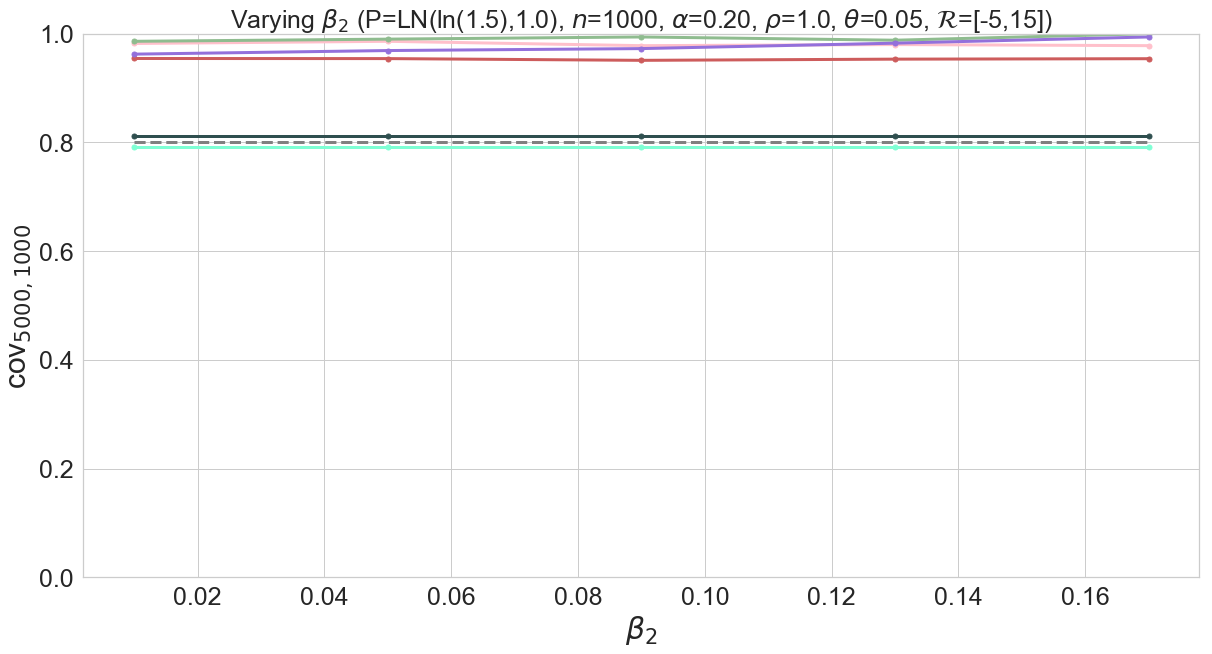

In [173]:
imp.reload(analysis)

run_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
alg_colors = [colors[i] for i in run_indices_names]
print(alg_names)
title = r"Varying $\beta_2$ (P=LN(ln(%.1f),%.1f), $n$=%s, $\alpha$=%.2f, $\rho$=%s, $\theta$=%.2f, $\mathcal{R}$=[%s,%s])" % (true_median, data_scale, n, alpha, rho, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$\beta_2$"
# save_paths = coverage_save_paths(dir_path, dataset_name, param_string, alpha)

# save_path = save_paths[0] #'%s/coverage-%s/coverage-%s-%s-all-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
# plt = analysis.plotCIs(algs, dataset_name, title, beta, xlabel, 
#           alg_names, param_string=param_string, ratio=False, alpha=alpha, T=num_trials*num_datasets, n=n,
#           log=False, legend_out=False, xlim=None, ylim=[0.75, 1.05], sort='byParam', coverage=True, 
#             save=True, save_path=save_path, colors=alg_colors)

run_indices = [1, 3, 5, 7, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 5, 7, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
alg_colors = [colors[i] for i in run_indices_names]
print(alg_names)
# save_path = '%s/coverage-%s/coverage-%s-%s-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)

save_path = None
plt = analysis.plotCIs(algs, dataset_name, title, beta, xlabel, 
          alg_names, param_string='beta', ratio=False, alpha=alpha, T=num_trials*num_datasets, n=n,
          log=False, legend=False, legend_out=False, xlim=None, ylim=[0, 1], sort='byParam', coverage=True, 
            save=False, save_path=save_path, colors=alg_colors)

# Coverage - varying rho (Figure 3a)

In [419]:
# dataset_name='lognormal_flat'
# num_datasets = 1000
# n = 1000
# data_center = 0.5
# data_scale = 1.0
# true_median = st.lognorm.median(data_scale, loc=data_center)
# print("true median:", true_median)

dataset_name='lognormal_flat'
num_datasets = 10000
n = 1000
data_center = 0.5
data_scale = 5.0
true_median = st.lognorm.median(data_scale, loc=data_center)
print("true median:", true_median)

num_trials = 1
range_center = 5
range_scale = 10
rho = 1.0
alpha = 0.2
beta = 0.01
quantile = 0.5
granularity = 0.01
em_granularity = 0.005

rho = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
num_params = len(rho)
print(rho)
print(granularity)
param_string='rho'

true median: 1.5
[0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
0.01


In [406]:
imp.reload(run_cis)
imp.reload(exp_median)
imp.reload(wrap)
imp.reload(analysis)
imp.reload(bisearch_median)
imp.reload(pub)
imp.reload(common)

run_indices = [8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)

run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, true_median=true_median, 
                  alpha=alpha, beta=beta, 
                  quantile=quantile, n=n, em_granularity=em_granularity, granularity=granularity,
                  alg_list=algs, data_center=data_center, data_scale=data_scale, data_distribution='lognormal',
                  rerun_algs=True, gen_preprocess=True, start_param=0)

['Nonpriv_lognormal']
starting Nonpriv lognormal
param 0 of 7
n 1000 lb, ub -inf inf gran 0.01 alpha 0.2 rho 0.01
name, hyperparameters Nonpriv_lognormal_rho_0 {'s': 5.0, 'loc': 0.5, 'scale': 1.0, 'granularity': 0.01, 'beta': 0.01, 'alpha': 0.2, 'cdp': True}
computing 80% CIs
eps: 0.1414213562373095
dataset 0 of 10000 lognormal_flat lognormal_flat_4151.npy
dataset 1 of 10000 lognormal_flat lognormal_flat_2520.npy
dataset 2 of 10000 lognormal_flat lognormal_flat_6746.npy
dataset 3 of 10000 lognormal_flat lognormal_flat_9475.npy
dataset 4 of 10000 lognormal_flat lognormal_flat_1029.npy
dataset 5 of 10000 lognormal_flat lognormal_flat_7458.npy
dataset 6 of 10000 lognormal_flat lognormal_flat_1997.npy
dataset 7 of 10000 lognormal_flat lognormal_flat_6020.npy
dataset 8 of 10000 lognormal_flat lognormal_flat_9313.npy
dataset 9 of 10000 lognormal_flat lognormal_flat_5529.npy
dataset 10 of 10000 lognormal_flat lognormal_flat_479.npy
dataset 11 of 10000 lognormal_flat lognormal_flat_2246.npy
da

dataset 177 of 10000 lognormal_flat lognormal_flat_9717.npy
dataset 178 of 10000 lognormal_flat lognormal_flat_6424.npy
dataset 179 of 10000 lognormal_flat lognormal_flat_8409.npy
dataset 180 of 10000 lognormal_flat lognormal_flat_9071.npy
dataset 181 of 10000 lognormal_flat lognormal_flat_6342.npy
dataset 182 of 10000 lognormal_flat lognormal_flat_2124.npy
dataset 183 of 10000 lognormal_flat lognormal_flat_5893.npy
dataset 184 of 10000 lognormal_flat lognormal_flat_4555.npy
dataset 185 of 10000 lognormal_flat lognormal_flat_7074.npy
dataset 186 of 10000 lognormal_flat lognormal_flat_8347.npy
dataset 187 of 10000 lognormal_flat lognormal_flat_1405.npy
dataset 188 of 10000 lognormal_flat lognormal_flat_9059.npy
dataset 189 of 10000 lognormal_flat lognormal_flat_5663.npy
dataset 190 of 10000 lognormal_flat lognormal_flat_733.npy
dataset 191 of 10000 lognormal_flat lognormal_flat_3212.npy
dataset 192 of 10000 lognormal_flat lognormal_flat_3574.npy
dataset 193 of 10000 lognormal_flat logno

dataset 354 of 10000 lognormal_flat lognormal_flat_7505.npy
dataset 355 of 10000 lognormal_flat lognormal_flat_8636.npy
dataset 356 of 10000 lognormal_flat lognormal_flat_3763.npy
dataset 357 of 10000 lognormal_flat lognormal_flat_5312.npy
dataset 358 of 10000 lognormal_flat lognormal_flat_242.npy
dataset 359 of 10000 lognormal_flat lognormal_flat_4018.npy
dataset 360 of 10000 lognormal_flat lognormal_flat_3777.npy
dataset 361 of 10000 lognormal_flat lognormal_flat_2469.npy
dataset 362 of 10000 lognormal_flat lognormal_flat_256.npy
dataset 363 of 10000 lognormal_flat lognormal_flat_5306.npy
dataset 364 of 10000 lognormal_flat lognormal_flat_1160.npy
dataset 365 of 10000 lognormal_flat lognormal_flat_38.npy
dataset 366 of 10000 lognormal_flat lognormal_flat_7511.npy
dataset 367 of 10000 lognormal_flat lognormal_flat_8622.npy
dataset 368 of 10000 lognormal_flat lognormal_flat_7277.npy
dataset 369 of 10000 lognormal_flat lognormal_flat_8144.npy
dataset 370 of 10000 lognormal_flat lognorma

dataset 495 of 10000 lognormal_flat lognormal_flat_1.npy
dataset 496 of 10000 lognormal_flat lognormal_flat_861.npy
dataset 497 of 10000 lognormal_flat lognormal_flat_2086.npy
dataset 498 of 10000 lognormal_flat lognormal_flat_7698.npy
dataset 499 of 10000 lognormal_flat lognormal_flat_6586.npy
dataset 500 of 10000 lognormal_flat lognormal_flat_7840.npy
dataset 501 of 10000 lognormal_flat lognormal_flat_2938.npy
dataset 502 of 10000 lognormal_flat lognormal_flat_4391.npy
dataset 503 of 10000 lognormal_flat lognormal_flat_3415.npy
dataset 504 of 10000 lognormal_flat lognormal_flat_5064.npy
dataset 505 of 10000 lognormal_flat lognormal_flat_134.npy
dataset 506 of 10000 lognormal_flat lognormal_flat_1202.npy
dataset 507 of 10000 lognormal_flat lognormal_flat_9886.npy
dataset 508 of 10000 lognormal_flat lognormal_flat_8540.npy
dataset 509 of 10000 lognormal_flat lognormal_flat_7673.npy
dataset 510 of 10000 lognormal_flat lognormal_flat_8226.npy
dataset 511 of 10000 lognormal_flat lognormal

dataset 640 of 10000 lognormal_flat lognormal_flat_3629.npy
dataset 641 of 10000 lognormal_flat lognormal_flat_2537.npy
dataset 642 of 10000 lognormal_flat lognormal_flat_5258.npy
dataset 643 of 10000 lognormal_flat lognormal_flat_308.npy
dataset 644 of 10000 lognormal_flat lognormal_flat_2251.npy
dataset 645 of 10000 lognormal_flat lognormal_flat_4620.npy
dataset 646 of 10000 lognormal_flat lognormal_flat_1980.npy
dataset 647 of 10000 lognormal_flat lognormal_flat_7329.npy
dataset 648 of 10000 lognormal_flat lognormal_flat_1758.npy
dataset 649 of 10000 lognormal_flat lognormal_flat_9304.npy
dataset 650 of 10000 lognormal_flat lognormal_flat_6037.npy
dataset 651 of 10000 lognormal_flat lognormal_flat_1994.npy
dataset 652 of 10000 lognormal_flat lognormal_flat_9310.npy
dataset 653 of 10000 lognormal_flat lognormal_flat_6023.npy
dataset 654 of 10000 lognormal_flat lognormal_flat_2245.npy
dataset 655 of 10000 lognormal_flat lognormal_flat_4634.npy
dataset 656 of 10000 lognormal_flat logno

dataset 782 of 10000 lognormal_flat lognormal_flat_5933.npy
dataset 783 of 10000 lognormal_flat lognormal_flat_693.npy
dataset 784 of 10000 lognormal_flat lognormal_flat_2912.npy
dataset 785 of 10000 lognormal_flat lognormal_flat_8581.npy
dataset 786 of 10000 lognormal_flat lognormal_flat_9847.npy
dataset 787 of 10000 lognormal_flat lognormal_flat_8595.npy
dataset 788 of 10000 lognormal_flat lognormal_flat_9853.npy
dataset 789 of 10000 lognormal_flat lognormal_flat_2906.npy
dataset 790 of 10000 lognormal_flat lognormal_flat_687.npy
dataset 791 of 10000 lognormal_flat lognormal_flat_6341.npy
dataset 792 of 10000 lognormal_flat lognormal_flat_9072.npy
dataset 793 of 10000 lognormal_flat lognormal_flat_5648.npy
dataset 794 of 10000 lognormal_flat lognormal_flat_718.npy
dataset 795 of 10000 lognormal_flat lognormal_flat_2127.npy
dataset 796 of 10000 lognormal_flat lognormal_flat_3239.npy
dataset 797 of 10000 lognormal_flat lognormal_flat_5890.npy
dataset 798 of 10000 lognormal_flat lognorm

dataset 952 of 10000 lognormal_flat lognormal_flat_8806.npy
dataset 953 of 10000 lognormal_flat lognormal_flat_1188.npy
dataset 954 of 10000 lognormal_flat lognormal_flat_8812.npy
dataset 955 of 10000 lognormal_flat lognormal_flat_2481.npy
dataset 956 of 10000 lognormal_flat lognormal_flat_3947.npy
dataset 957 of 10000 lognormal_flat lognormal_flat_4796.npy
dataset 958 of 10000 lognormal_flat lognormal_flat_5488.npy
dataset 959 of 10000 lognormal_flat lognormal_flat_6181.npy
dataset 960 of 10000 lognormal_flat lognormal_flat_1836.npy
dataset 961 of 10000 lognormal_flat lognormal_flat_8147.npy
dataset 962 of 10000 lognormal_flat lognormal_flat_7274.npy
dataset 963 of 10000 lognormal_flat lognormal_flat_1605.npy
dataset 964 of 10000 lognormal_flat lognormal_flat_9259.npy
dataset 965 of 10000 lognormal_flat lognormal_flat_5463.npy
dataset 966 of 10000 lognormal_flat lognormal_flat_533.npy
dataset 967 of 10000 lognormal_flat lognormal_flat_3012.npy
dataset 968 of 10000 lognormal_flat logno

dataset 1106 of 10000 lognormal_flat lognormal_flat_5098.npy
dataset 1107 of 10000 lognormal_flat lognormal_flat_4386.npy
dataset 1108 of 10000 lognormal_flat lognormal_flat_6591.npy
dataset 1109 of 10000 lognormal_flat lognormal_flat_7857.npy
dataset 1110 of 10000 lognormal_flat lognormal_flat_9649.npy
dataset 1111 of 10000 lognormal_flat lognormal_flat_1215.npy
dataset 1112 of 10000 lognormal_flat lognormal_flat_9891.npy
dataset 1113 of 10000 lognormal_flat lognormal_flat_7664.npy
dataset 1114 of 10000 lognormal_flat lognormal_flat_8557.npy
dataset 1115 of 10000 lognormal_flat lognormal_flat_3402.npy
dataset 1116 of 10000 lognormal_flat lognormal_flat_5073.npy
dataset 1117 of 10000 lognormal_flat lognormal_flat_123.npy
dataset 1118 of 10000 lognormal_flat lognormal_flat_5715.npy
dataset 1119 of 10000 lognormal_flat lognormal_flat_645.npy
dataset 1120 of 10000 lognormal_flat lognormal_flat_3364.npy
dataset 1121 of 10000 lognormal_flat lognormal_flat_7102.npy
dataset 1122 of 10000 logn

dataset 1254 of 10000 lognormal_flat lognormal_flat_6768.npy
dataset 1255 of 10000 lognormal_flat lognormal_flat_7476.npy
dataset 1256 of 10000 lognormal_flat lognormal_flat_8745.npy
dataset 1257 of 10000 lognormal_flat lognormal_flat_1013.npy
dataset 1258 of 10000 lognormal_flat lognormal_flat_8989.npy
dataset 1259 of 10000 lognormal_flat lognormal_flat_7462.npy
dataset 1260 of 10000 lognormal_flat lognormal_flat_8751.npy
dataset 1261 of 10000 lognormal_flat lognormal_flat_3604.npy
dataset 1262 of 10000 lognormal_flat lognormal_flat_5275.npy
dataset 1263 of 10000 lognormal_flat lognormal_flat_325.npy
dataset 1264 of 10000 lognormal_flat lognormal_flat_5513.npy
dataset 1265 of 10000 lognormal_flat lognormal_flat_443.npy
dataset 1266 of 10000 lognormal_flat lognormal_flat_3162.npy
dataset 1267 of 10000 lognormal_flat lognormal_flat_7304.npy
dataset 1268 of 10000 lognormal_flat lognormal_flat_8037.npy
dataset 1269 of 10000 lognormal_flat lognormal_flat_9329.npy
dataset 1270 of 10000 logn

dataset 1413 of 10000 lognormal_flat lognormal_flat_1403.npy
dataset 1414 of 10000 lognormal_flat lognormal_flat_5665.npy
dataset 1415 of 10000 lognormal_flat lognormal_flat_735.npy
dataset 1416 of 10000 lognormal_flat lognormal_flat_3214.npy
dataset 1417 of 10000 lognormal_flat lognormal_flat_3572.npy
dataset 1418 of 10000 lognormal_flat lognormal_flat_5103.npy
dataset 1419 of 10000 lognormal_flat lognormal_flat_1365.npy
dataset 1420 of 10000 lognormal_flat lognormal_flat_9739.npy
dataset 1421 of 10000 lognormal_flat lognormal_flat_8427.npy
dataset 1422 of 10000 lognormal_flat lognormal_flat_7714.npy
dataset 1423 of 10000 lognormal_flat lognormal_flat_4235.npy
dataset 1424 of 10000 lognormal_flat lognormal_flat_2644.npy
dataset 1425 of 10000 lognormal_flat lognormal_flat_6422.npy
dataset 1426 of 10000 lognormal_flat lognormal_flat_9711.npy
dataset 1427 of 10000 lognormal_flat lognormal_flat_8369.npy
dataset 1428 of 10000 lognormal_flat lognormal_flat_6344.npy
dataset 1429 of 10000 log

dataset 1577 of 10000 lognormal_flat lognormal_flat_7259.npy
dataset 1578 of 10000 lognormal_flat lognormal_flat_6147.npy
dataset 1579 of 10000 lognormal_flat lognormal_flat_9274.npy
dataset 1580 of 10000 lognormal_flat lognormal_flat_1628.npy
dataset 1581 of 10000 lognormal_flat lognormal_flat_2321.npy
dataset 1582 of 10000 lognormal_flat lognormal_flat_4988.npy
dataset 1583 of 10000 lognormal_flat lognormal_flat_4750.npy
dataset 1584 of 10000 lognormal_flat lognormal_flat_3759.npy
dataset 1585 of 10000 lognormal_flat lognormal_flat_4036.npy
dataset 1586 of 10000 lognormal_flat lognormal_flat_3981.npy
dataset 1587 of 10000 lognormal_flat lognormal_flat_5328.npy
dataset 1588 of 10000 lognormal_flat lognormal_flat_278.npy
dataset 1589 of 10000 lognormal_flat lognormal_flat_2447.npy
dataset 1590 of 10000 lognormal_flat lognormal_flat_6621.npy
dataset 1591 of 10000 lognormal_flat lognormal_flat_9512.npy
dataset 1592 of 10000 lognormal_flat lognormal_flat_16.npy
dataset 1593 of 10000 logno

dataset 1728 of 10000 lognormal_flat lognormal_flat_9664.npy
dataset 1729 of 10000 lognormal_flat lognormal_flat_6557.npy
dataset 1730 of 10000 lognormal_flat lognormal_flat_7649.npy
dataset 1731 of 10000 lognormal_flat lognormal_flat_4340.npy
dataset 1732 of 10000 lognormal_flat lognormal_flat_2731.npy
dataset 1733 of 10000 lognormal_flat lognormal_flat_2057.npy
dataset 1734 of 10000 lognormal_flat lognormal_flat_5738.npy
dataset 1735 of 10000 lognormal_flat lognormal_flat_668.npy
dataset 1736 of 10000 lognormal_flat lognormal_flat_4426.npy
dataset 1737 of 10000 lognormal_flat lognormal_flat_3349.npy
dataset 1738 of 10000 lognormal_flat lognormal_flat_9102.npy
dataset 1739 of 10000 lognormal_flat lognormal_flat_6231.npy
dataset 1740 of 10000 lognormal_flat lognormal_flat_640.npy
dataset 1741 of 10000 lognormal_flat lognormal_flat_5710.npy
dataset 1742 of 10000 lognormal_flat lognormal_flat_3361.npy
dataset 1743 of 10000 lognormal_flat lognormal_flat_898.npy
dataset 1744 of 10000 logno

dataset 1883 of 10000 lognormal_flat lognormal_flat_2525.npy
dataset 1884 of 10000 lognormal_flat lognormal_flat_6743.npy
dataset 1885 of 10000 lognormal_flat lognormal_flat_9470.npy
dataset 1886 of 10000 lognormal_flat lognormal_flat_1038.npy
dataset 1887 of 10000 lognormal_flat lognormal_flat_6757.npy
dataset 1888 of 10000 lognormal_flat lognormal_flat_9464.npy
dataset 1889 of 10000 lognormal_flat lognormal_flat_7449.npy
dataset 1890 of 10000 lognormal_flat lognormal_flat_4140.npy
dataset 1891 of 10000 lognormal_flat lognormal_flat_2531.npy
dataset 1892 of 10000 lognormal_flat lognormal_flat_2257.npy
dataset 1893 of 10000 lognormal_flat lognormal_flat_5538.npy
dataset 1894 of 10000 lognormal_flat lognormal_flat_468.npy
dataset 1895 of 10000 lognormal_flat lognormal_flat_4626.npy
dataset 1896 of 10000 lognormal_flat lognormal_flat_3149.npy
dataset 1897 of 10000 lognormal_flat lognormal_flat_1986.npy
dataset 1898 of 10000 lognormal_flat lognormal_flat_6031.npy
dataset 1899 of 10000 log

dataset 2041 of 10000 lognormal_flat lognormal_flat_2135.npy
dataset 2042 of 10000 lognormal_flat lognormal_flat_4544.npy
dataset 2043 of 10000 lognormal_flat lognormal_flat_5882.npy
dataset 2044 of 10000 lognormal_flat lognormal_flat_9060.npy
dataset 2045 of 10000 lognormal_flat lognormal_flat_6353.npy
dataset 2046 of 10000 lognormal_flat lognormal_flat_7059.npy
dataset 2047 of 10000 lognormal_flat lognormal_flat_9074.npy
dataset 2048 of 10000 lognormal_flat lognormal_flat_6347.npy
dataset 2049 of 10000 lognormal_flat lognormal_flat_1428.npy
dataset 2050 of 10000 lognormal_flat lognormal_flat_2121.npy
dataset 2051 of 10000 lognormal_flat lognormal_flat_4550.npy
dataset 2052 of 10000 lognormal_flat lognormal_flat_5896.npy
dataset 2053 of 10000 lognormal_flat lognormal_flat_3559.npy
dataset 2054 of 10000 lognormal_flat lognormal_flat_4236.npy
dataset 2055 of 10000 lognormal_flat lognormal_flat_5128.npy
dataset 2056 of 10000 lognormal_flat lognormal_flat_2647.npy
dataset 2057 of 10000 lo

dataset 2191 of 10000 lognormal_flat lognormal_flat_6811.npy
dataset 2192 of 10000 lognormal_flat lognormal_flat_3969.npy
dataset 2193 of 10000 lognormal_flat lognormal_flat_290.npy
dataset 2194 of 10000 lognormal_flat lognormal_flat_4035.npy
dataset 2195 of 10000 lognormal_flat lognormal_flat_3982.npy
dataset 2196 of 10000 lognormal_flat lognormal_flat_2444.npy
dataset 2197 of 10000 lognormal_flat lognormal_flat_9511.npy
dataset 2198 of 10000 lognormal_flat lognormal_flat_6622.npy
dataset 2199 of 10000 lognormal_flat lognormal_flat_15.npy
dataset 2200 of 10000 lognormal_flat lognormal_flat_8169.npy
dataset 2201 of 10000 lognormal_flat lognormal_flat_9277.npy
dataset 2202 of 10000 lognormal_flat lognormal_flat_6144.npy
dataset 2203 of 10000 lognormal_flat lognormal_flat_2322.npy
dataset 2204 of 10000 lognormal_flat lognormal_flat_4753.npy
dataset 2205 of 10000 lognormal_flat lognormal_flat_2336.npy
dataset 2206 of 10000 lognormal_flat lognormal_flat_5459.npy
dataset 2207 of 10000 logno

dataset 2340 of 10000 lognormal_flat lognormal_flat_8586.npy
dataset 2341 of 10000 lognormal_flat lognormal_flat_9840.npy
dataset 2342 of 10000 lognormal_flat lognormal_flat_9698.npy
dataset 2343 of 10000 lognormal_flat lognormal_flat_2915.npy
dataset 2344 of 10000 lognormal_flat lognormal_flat_2901.npy
dataset 2345 of 10000 lognormal_flat lognormal_flat_8592.npy
dataset 2346 of 10000 lognormal_flat lognormal_flat_9854.npy
dataset 2347 of 10000 lognormal_flat lognormal_flat_7879.npy
dataset 2348 of 10000 lognormal_flat lognormal_flat_858.npy
dataset 2349 of 10000 lognormal_flat lognormal_flat_5908.npy
dataset 2350 of 10000 lognormal_flat lognormal_flat_680.npy
dataset 2351 of 10000 lognormal_flat lognormal_flat_2054.npy
dataset 2352 of 10000 lognormal_flat lognormal_flat_4425.npy
dataset 2353 of 10000 lognormal_flat lognormal_flat_6232.npy
dataset 2354 of 10000 lognormal_flat lognormal_flat_9101.npy
dataset 2355 of 10000 lognormal_flat lognormal_flat_7892.npy
dataset 2356 of 10000 logn

dataset 2496 of 10000 lognormal_flat lognormal_flat_2557.npy
dataset 2497 of 10000 lognormal_flat lognormal_flat_5238.npy
dataset 2498 of 10000 lognormal_flat lognormal_flat_368.npy
dataset 2499 of 10000 lognormal_flat lognormal_flat_3891.npy
dataset 2500 of 10000 lognormal_flat lognormal_flat_9402.npy
dataset 2501 of 10000 lognormal_flat lognormal_flat_6731.npy
dataset 2502 of 10000 lognormal_flat lognormal_flat_7349.npy
dataset 2503 of 10000 lognormal_flat lognormal_flat_1738.npy
dataset 2504 of 10000 lognormal_flat lognormal_flat_9364.npy
dataset 2505 of 10000 lognormal_flat lognormal_flat_6057.npy
dataset 2506 of 10000 lognormal_flat lognormal_flat_4898.npy
dataset 2507 of 10000 lognormal_flat lognormal_flat_2231.npy
dataset 2508 of 10000 lognormal_flat lognormal_flat_4640.npy
dataset 2509 of 10000 lognormal_flat lognormal_flat_7361.npy
dataset 2510 of 10000 lognormal_flat lognormal_flat_8052.npy
dataset 2511 of 10000 lognormal_flat lognormal_flat_1710.npy
dataset 2512 of 10000 log

dataset 2666 of 10000 lognormal_flat lognormal_flat_5166.npy
dataset 2667 of 10000 lognormal_flat lognormal_flat_750.npy
dataset 2668 of 10000 lognormal_flat lognormal_flat_5600.npy
dataset 2669 of 10000 lognormal_flat lognormal_flat_988.npy
dataset 2670 of 10000 lognormal_flat lognormal_flat_3271.npy
dataset 2671 of 10000 lognormal_flat lognormal_flat_8324.npy
dataset 2672 of 10000 lognormal_flat lognormal_flat_7017.npy
dataset 2673 of 10000 lognormal_flat lognormal_flat_1466.npy
dataset 2674 of 10000 lognormal_flat lognormal_flat_6309.npy
dataset 2675 of 10000 lognormal_flat lognormal_flat_8330.npy
dataset 2676 of 10000 lognormal_flat lognormal_flat_7003.npy
dataset 2677 of 10000 lognormal_flat lognormal_flat_1472.npy
dataset 2678 of 10000 lognormal_flat lognormal_flat_5614.npy
dataset 2679 of 10000 lognormal_flat lognormal_flat_744.npy
dataset 2680 of 10000 lognormal_flat lognormal_flat_3265.npy
dataset 2681 of 10000 lognormal_flat lognormal_flat_3503.npy
dataset 2682 of 10000 logno

dataset 2827 of 10000 lognormal_flat lognormal_flat_3066.npy
dataset 2828 of 10000 lognormal_flat lognormal_flat_4709.npy
dataset 2829 of 10000 lognormal_flat lognormal_flat_5403.npy
dataset 2830 of 10000 lognormal_flat lognormal_flat_553.npy
dataset 2831 of 10000 lognormal_flat lognormal_flat_3072.npy
dataset 2832 of 10000 lognormal_flat lognormal_flat_8127.npy
dataset 2833 of 10000 lognormal_flat lognormal_flat_7214.npy
dataset 2834 of 10000 lognormal_flat lognormal_flat_1665.npy
dataset 2835 of 10000 lognormal_flat lognormal_flat_9239.npy
dataset 2836 of 10000 lognormal_flat lognormal_flat_1103.npy
dataset 2837 of 10000 lognormal_flat lognormal_flat_8899.npy
dataset 2838 of 10000 lognormal_flat lognormal_flat_8641.npy
dataset 2839 of 10000 lognormal_flat lognormal_flat_7572.npy
dataset 2840 of 10000 lognormal_flat lognormal_flat_3714.npy
dataset 2841 of 10000 lognormal_flat lognormal_flat_5365.npy
dataset 2842 of 10000 lognormal_flat lognormal_flat_235.npy
dataset 2843 of 10000 logn

dataset 2977 of 10000 lognormal_flat lognormal_flat_8523.npy
dataset 2978 of 10000 lognormal_flat lognormal_flat_4319.npy
dataset 2979 of 10000 lognormal_flat lognormal_flat_3476.npy
dataset 2980 of 10000 lognormal_flat lognormal_flat_2768.npy
dataset 2981 of 10000 lognormal_flat lognormal_flat_157.npy
dataset 2982 of 10000 lognormal_flat lognormal_flat_5007.npy
dataset 2983 of 10000 lognormal_flat lognormal_flat_3462.npy
dataset 2984 of 10000 lognormal_flat lognormal_flat_5013.npy
dataset 2985 of 10000 lognormal_flat lognormal_flat_143.npy
dataset 2986 of 10000 lognormal_flat lognormal_flat_9629.npy
dataset 2987 of 10000 lognormal_flat lognormal_flat_1275.npy
dataset 2988 of 10000 lognormal_flat lognormal_flat_7604.npy
dataset 2989 of 10000 lognormal_flat lognormal_flat_8537.npy
dataset 2990 of 10000 lognormal_flat lognormal_flat_7162.npy
dataset 2991 of 10000 lognormal_flat lognormal_flat_8251.npy
dataset 2992 of 10000 lognormal_flat lognormal_flat_1513.npy
dataset 2993 of 10000 logn

dataset 3152 of 10000 lognormal_flat lognormal_flat_1920.npy
dataset 3153 of 10000 lognormal_flat lognormal_flat_6929.npy
dataset 3154 of 10000 lognormal_flat lognormal_flat_8904.npy
dataset 3155 of 10000 lognormal_flat lognormal_flat_2597.npy
dataset 3156 of 10000 lognormal_flat lognormal_flat_3851.npy
dataset 3157 of 10000 lognormal_flat lognormal_flat_3689.npy
dataset 3158 of 10000 lognormal_flat lognormal_flat_2583.npy
dataset 3159 of 10000 lognormal_flat lognormal_flat_3845.npy
dataset 3160 of 10000 lognormal_flat lognormal_flat_8910.npy
dataset 3161 of 10000 lognormal_flat lognormal_flat_6083.npy
dataset 3162 of 10000 lognormal_flat lognormal_flat_1934.npy
dataset 3163 of 10000 lognormal_flat lognormal_flat_4694.npy
dataset 3164 of 10000 lognormal_flat lognormal_flat_9398.npy
dataset 3165 of 10000 lognormal_flat lognormal_flat_8086.npy
dataset 3166 of 10000 lognormal_flat lognormal_flat_4864.npy
dataset 3167 of 10000 lognormal_flat lognormal_flat_394.npy
dataset 3168 of 10000 log

dataset 3295 of 10000 lognormal_flat lognormal_flat_3272.npy
dataset 3296 of 10000 lognormal_flat lognormal_flat_7014.npy
dataset 3297 of 10000 lognormal_flat lognormal_flat_8327.npy
dataset 3298 of 10000 lognormal_flat lognormal_flat_1465.npy
dataset 3299 of 10000 lognormal_flat lognormal_flat_9039.npy
dataset 3300 of 10000 lognormal_flat lognormal_flat_1303.npy
dataset 3301 of 10000 lognormal_flat lognormal_flat_9987.npy
dataset 3302 of 10000 lognormal_flat lognormal_flat_7772.npy
dataset 3303 of 10000 lognormal_flat lognormal_flat_8441.npy
dataset 3304 of 10000 lognormal_flat lognormal_flat_3514.npy
dataset 3305 of 10000 lognormal_flat lognormal_flat_5165.npy
dataset 3306 of 10000 lognormal_flat lognormal_flat_4290.npy
dataset 3307 of 10000 lognormal_flat lognormal_flat_2839.npy
dataset 3308 of 10000 lognormal_flat lognormal_flat_7799.npy
dataset 3309 of 10000 lognormal_flat lognormal_flat_6487.npy
dataset 3310 of 10000 lognormal_flat lognormal_flat_7941.npy
dataset 3311 of 10000 lo

dataset 3456 of 10000 lognormal_flat lognormal_flat_8124.npy
dataset 3457 of 10000 lognormal_flat lognormal_flat_1666.npy
dataset 3458 of 10000 lognormal_flat lognormal_flat_6109.npy
dataset 3459 of 10000 lognormal_flat lognormal_flat_7203.npy
dataset 3460 of 10000 lognormal_flat lognormal_flat_8130.npy
dataset 3461 of 10000 lognormal_flat lognormal_flat_1672.npy
dataset 3462 of 10000 lognormal_flat lognormal_flat_5414.npy
dataset 3463 of 10000 lognormal_flat lognormal_flat_544.npy
dataset 3464 of 10000 lognormal_flat lognormal_flat_3065.npy
dataset 3465 of 10000 lognormal_flat lognormal_flat_3703.npy
dataset 3466 of 10000 lognormal_flat lognormal_flat_5372.npy
dataset 3467 of 10000 lognormal_flat lognormal_flat_222.npy
dataset 3468 of 10000 lognormal_flat lognormal_flat_9548.npy
dataset 3469 of 10000 lognormal_flat lognormal_flat_1114.npy
dataset 3470 of 10000 lognormal_flat lognormal_flat_7565.npy
dataset 3471 of 10000 lognormal_flat lognormal_flat_8656.npy
dataset 3472 of 10000 logn

dataset 3609 of 10000 lognormal_flat lognormal_flat_2019.npy
dataset 3610 of 10000 lognormal_flat lognormal_flat_3307.npy
dataset 3611 of 10000 lognormal_flat lognormal_flat_4468.npy
dataset 3612 of 10000 lognormal_flat lognormal_flat_3461.npy
dataset 3613 of 10000 lognormal_flat lognormal_flat_140.npy
dataset 3614 of 10000 lognormal_flat lognormal_flat_5010.npy
dataset 3615 of 10000 lognormal_flat lognormal_flat_6519.npy
dataset 3616 of 10000 lognormal_flat lognormal_flat_1276.npy
dataset 3617 of 10000 lognormal_flat lognormal_flat_8534.npy
dataset 3618 of 10000 lognormal_flat lognormal_flat_7607.npy
dataset 3619 of 10000 lognormal_flat lognormal_flat_1262.npy
dataset 3620 of 10000 lognormal_flat lognormal_flat_8520.npy
dataset 3621 of 10000 lognormal_flat lognormal_flat_7613.npy
dataset 3622 of 10000 lognormal_flat lognormal_flat_3475.npy
dataset 3623 of 10000 lognormal_flat lognormal_flat_5004.npy
dataset 3624 of 10000 lognormal_flat lognormal_flat_154.npy
dataset 3625 of 10000 logn

dataset 3760 of 10000 lognormal_flat lognormal_flat_2579.npy
dataset 3761 of 10000 lognormal_flat lognormal_flat_1070.npy
dataset 3762 of 10000 lognormal_flat lognormal_flat_8732.npy
dataset 3763 of 10000 lognormal_flat lognormal_flat_7401.npy
dataset 3764 of 10000 lognormal_flat lognormal_flat_4120.npy
dataset 3765 of 10000 lognormal_flat lognormal_flat_3897.npy
dataset 3766 of 10000 lognormal_flat lognormal_flat_2551.npy
dataset 3767 of 10000 lognormal_flat lognormal_flat_1058.npy
dataset 3768 of 10000 lognormal_flat lognormal_flat_6737.npy
dataset 3769 of 10000 lognormal_flat lognormal_flat_9404.npy
dataset 3770 of 10000 lognormal_flat lognormal_flat_7429.npy
dataset 3771 of 10000 lognormal_flat lognormal_flat_6051.npy
dataset 3772 of 10000 lognormal_flat lognormal_flat_9362.npy
dataset 3773 of 10000 lognormal_flat lognormal_flat_2237.npy
dataset 3774 of 10000 lognormal_flat lognormal_flat_5558.npy
dataset 3775 of 10000 lognormal_flat lognormal_flat_408.npy
dataset 3776 of 10000 log

dataset 3913 of 10000 lognormal_flat lognormal_flat_3511.npy
dataset 3914 of 10000 lognormal_flat lognormal_flat_5160.npy
dataset 3915 of 10000 lognormal_flat lognormal_flat_2169.npy
dataset 3916 of 10000 lognormal_flat lognormal_flat_756.npy
dataset 3917 of 10000 lognormal_flat lognormal_flat_5606.npy
dataset 3918 of 10000 lognormal_flat lognormal_flat_4518.npy
dataset 3919 of 10000 lognormal_flat lognormal_flat_3277.npy
dataset 3920 of 10000 lognormal_flat lognormal_flat_7011.npy
dataset 3921 of 10000 lognormal_flat lognormal_flat_8322.npy
dataset 3922 of 10000 lognormal_flat lognormal_flat_1460.npy
dataset 3923 of 10000 lognormal_flat lognormal_flat_2141.npy
dataset 3924 of 10000 lognormal_flat lognormal_flat_4530.npy
dataset 3925 of 10000 lognormal_flat lognormal_flat_7039.npy
dataset 3926 of 10000 lognormal_flat lognormal_flat_9014.npy
dataset 3927 of 10000 lognormal_flat lognormal_flat_6327.npy
dataset 3928 of 10000 lognormal_flat lognormal_flat_1448.npy
dataset 3929 of 10000 log

dataset 4078 of 10000 lognormal_flat lognormal_flat_8690.npy
dataset 4079 of 10000 lognormal_flat lognormal_flat_6865.npy
dataset 4080 of 10000 lognormal_flat lognormal_flat_8848.npy
dataset 4081 of 10000 lognormal_flat lognormal_flat_4914.npy
dataset 4082 of 10000 lognormal_flat lognormal_flat_582.npy
dataset 4083 of 10000 lognormal_flat lognormal_flat_1887.npy
dataset 4084 of 10000 lognormal_flat lognormal_flat_9203.npy
dataset 4085 of 10000 lognormal_flat lognormal_flat_6130.npy
dataset 4086 of 10000 lognormal_flat lognormal_flat_2356.npy
dataset 4087 of 10000 lognormal_flat lognormal_flat_5439.npy
dataset 4088 of 10000 lognormal_flat lognormal_flat_569.npy
dataset 4089 of 10000 lognormal_flat lognormal_flat_4727.npy
dataset 4090 of 10000 lognormal_flat lognormal_flat_3048.npy
dataset 4091 of 10000 lognormal_flat lognormal_flat_4041.npy
dataset 4092 of 10000 lognormal_flat lognormal_flat_2430.npy
dataset 4093 of 10000 lognormal_flat lognormal_flat_1139.npy
dataset 4094 of 10000 logn

dataset 4219 of 10000 lognormal_flat lognormal_flat_7825.npy
dataset 4220 of 10000 lognormal_flat lognormal_flat_6285.npy
dataset 4221 of 10000 lognormal_flat lognormal_flat_4492.npy
dataset 4222 of 10000 lognormal_flat lognormal_flat_804.npy
dataset 4223 of 10000 lognormal_flat lognormal_flat_5954.npy
dataset 4224 of 10000 lognormal_flat lognormal_flat_4486.npy
dataset 4225 of 10000 lognormal_flat lognormal_flat_5940.npy
dataset 4226 of 10000 lognormal_flat lognormal_flat_810.npy
dataset 4227 of 10000 lognormal_flat lognormal_flat_5798.npy
dataset 4228 of 10000 lognormal_flat lognormal_flat_6291.npy
dataset 4229 of 10000 lognormal_flat lognormal_flat_7831.npy
dataset 4230 of 10000 lognormal_flat lognormal_flat_1298.npy
dataset 4231 of 10000 lognormal_flat lognormal_flat_2791.npy
dataset 4232 of 10000 lognormal_flat lognormal_flat_2949.npy
dataset 4233 of 10000 lognormal_flat lognormal_flat_9834.npy
dataset 4234 of 10000 lognormal_flat lognormal_flat_7819.npy
dataset 4235 of 10000 logn

dataset 4389 of 10000 lognormal_flat lognormal_flat_2208.npy
dataset 4390 of 10000 lognormal_flat lognormal_flat_437.npy
dataset 4391 of 10000 lognormal_flat lognormal_flat_5567.npy
dataset 4392 of 10000 lognormal_flat lognormal_flat_4679.npy
dataset 4393 of 10000 lognormal_flat lognormal_flat_3116.npy
dataset 4394 of 10000 lognormal_flat lognormal_flat_7370.npy
dataset 4395 of 10000 lognormal_flat lognormal_flat_8043.npy
dataset 4396 of 10000 lognormal_flat lognormal_flat_1701.npy
dataset 4397 of 10000 lognormal_flat lognormal_flat_1067.npy
dataset 4398 of 10000 lognormal_flat lognormal_flat_6708.npy
dataset 4399 of 10000 lognormal_flat lognormal_flat_7416.npy
dataset 4400 of 10000 lognormal_flat lognormal_flat_8725.npy
dataset 4401 of 10000 lognormal_flat lognormal_flat_3670.npy
dataset 4402 of 10000 lognormal_flat lognormal_flat_351.npy
dataset 4403 of 10000 lognormal_flat lognormal_flat_5201.npy
dataset 4404 of 10000 lognormal_flat lognormal_flat_9413.npy
dataset 4405 of 10000 logn

dataset 4530 of 10000 lognormal_flat lognormal_flat_8321.npy
dataset 4531 of 10000 lognormal_flat lognormal_flat_7012.npy
dataset 4532 of 10000 lognormal_flat lognormal_flat_1463.npy
dataset 4533 of 10000 lognormal_flat lognormal_flat_1305.npy
dataset 4534 of 10000 lognormal_flat lognormal_flat_9759.npy
dataset 4535 of 10000 lognormal_flat lognormal_flat_8447.npy
dataset 4536 of 10000 lognormal_flat lognormal_flat_7774.npy
dataset 4537 of 10000 lognormal_flat lognormal_flat_9981.npy
dataset 4538 of 10000 lognormal_flat lognormal_flat_3512.npy
dataset 4539 of 10000 lognormal_flat lognormal_flat_5163.npy
dataset 4540 of 10000 lognormal_flat lognormal_flat_3506.npy
dataset 4541 of 10000 lognormal_flat lognormal_flat_4269.npy
dataset 4542 of 10000 lognormal_flat lognormal_flat_5177.npy
dataset 4543 of 10000 lognormal_flat lognormal_flat_2618.npy
dataset 4544 of 10000 lognormal_flat lognormal_flat_1311.npy
dataset 4545 of 10000 lognormal_flat lognormal_flat_8453.npy
dataset 4546 of 10000 lo

dataset 4686 of 10000 lognormal_flat lognormal_flat_8877.npy
dataset 4687 of 10000 lognormal_flat lognormal_flat_6682.npy
dataset 4688 of 10000 lognormal_flat lognormal_flat_7588.npy
dataset 4689 of 10000 lognormal_flat lognormal_flat_8863.npy
dataset 4690 of 10000 lognormal_flat lognormal_flat_6696.npy
dataset 4691 of 10000 lognormal_flat lognormal_flat_3936.npy
dataset 4692 of 10000 lognormal_flat lognormal_flat_4081.npy
dataset 4693 of 10000 lognormal_flat lognormal_flat_3088.npy
dataset 4694 of 10000 lognormal_flat lognormal_flat_2396.npy
dataset 4695 of 10000 lognormal_flat lognormal_flat_1847.npy
dataset 4696 of 10000 lognormal_flat lognormal_flat_4917.npy
dataset 4697 of 10000 lognormal_flat lognormal_flat_581.npy
dataset 4698 of 10000 lognormal_flat lognormal_flat_8693.npy
dataset 4699 of 10000 lognormal_flat lognormal_flat_89.npy
dataset 4700 of 10000 lognormal_flat lognormal_flat_6866.npy
dataset 4701 of 10000 lognormal_flat lognormal_flat_8687.npy
dataset 4702 of 10000 logno

dataset 4849 of 10000 lognormal_flat lognormal_flat_3498.npy
dataset 4850 of 10000 lognormal_flat lognormal_flat_7826.npy
dataset 4851 of 10000 lognormal_flat lognormal_flat_191.npy
dataset 4852 of 10000 lognormal_flat lognormal_flat_2976.npy
dataset 4853 of 10000 lognormal_flat lognormal_flat_9823.npy
dataset 4854 of 10000 lognormal_flat lognormal_flat_8283.npy
dataset 4855 of 10000 lognormal_flat lognormal_flat_9189.npy
dataset 4856 of 10000 lognormal_flat lognormal_flat_8297.npy
dataset 4857 of 10000 lognormal_flat lognormal_flat_9837.npy
dataset 4858 of 10000 lognormal_flat lognormal_flat_185.npy
dataset 4859 of 10000 lognormal_flat lognormal_flat_2962.npy
dataset 4860 of 10000 lognormal_flat lognormal_flat_4320.npy
dataset 4861 of 10000 lognormal_flat lognormal_flat_2989.npy
dataset 4862 of 10000 lognormal_flat lognormal_flat_2751.npy
dataset 4863 of 10000 lognormal_flat lognormal_flat_1258.npy
dataset 4864 of 10000 lognormal_flat lognormal_flat_9604.npy
dataset 4865 of 10000 logn

dataset 5016 of 10000 lognormal_flat lognormal_flat_7340.npy
dataset 5017 of 10000 lognormal_flat lognormal_flat_8073.npy
dataset 5018 of 10000 lognormal_flat lognormal_flat_1731.npy
dataset 5019 of 10000 lognormal_flat lognormal_flat_6738.npy
dataset 5020 of 10000 lognormal_flat lognormal_flat_1057.npy
dataset 5021 of 10000 lognormal_flat lognormal_flat_7426.npy
dataset 5022 of 10000 lognormal_flat lognormal_flat_8715.npy
dataset 5023 of 10000 lognormal_flat lognormal_flat_3640.npy
dataset 5024 of 10000 lognormal_flat lognormal_flat_3898.npy
dataset 5025 of 10000 lognormal_flat lognormal_flat_5231.npy
dataset 5026 of 10000 lognormal_flat lognormal_flat_361.npy
dataset 5027 of 10000 lognormal_flat lognormal_flat_3654.npy
dataset 5028 of 10000 lognormal_flat lognormal_flat_375.npy
dataset 5029 of 10000 lognormal_flat lognormal_flat_5225.npy
dataset 5030 of 10000 lognormal_flat lognormal_flat_1043.npy
dataset 5031 of 10000 lognormal_flat lognormal_flat_7432.npy
dataset 5032 of 10000 logn

dataset 5192 of 10000 lognormal_flat lognormal_flat_7977.npy
dataset 5193 of 10000 lognormal_flat lognormal_flat_956.npy
dataset 5194 of 10000 lognormal_flat lognormal_flat_5806.npy
dataset 5195 of 10000 lognormal_flat lognormal_flat_5812.npy
dataset 5196 of 10000 lognormal_flat lognormal_flat_942.npy
dataset 5197 of 10000 lognormal_flat lognormal_flat_8488.npy
dataset 5198 of 10000 lognormal_flat lognormal_flat_9796.npy
dataset 5199 of 10000 lognormal_flat lognormal_flat_7963.npy
dataset 5200 of 10000 lognormal_flat lognormal_flat_9966.npy
dataset 5201 of 10000 lognormal_flat lognormal_flat_7793.npy
dataset 5202 of 10000 lognormal_flat lognormal_flat_5184.npy
dataset 5203 of 10000 lognormal_flat lognormal_flat_2833.npy
dataset 5204 of 10000 lognormal_flat lognormal_flat_3293.npy
dataset 5205 of 10000 lognormal_flat lognormal_flat_1484.npy
dataset 5206 of 10000 lognormal_flat lognormal_flat_1490.npy
dataset 5207 of 10000 lognormal_flat lognormal_flat_3287.npy
dataset 5208 of 10000 logn

dataset 5361 of 10000 lognormal_flat lognormal_flat_2371.npy
dataset 5362 of 10000 lognormal_flat lognormal_flat_4700.npy
dataset 5363 of 10000 lognormal_flat lognormal_flat_7209.npy
dataset 5364 of 10000 lognormal_flat lognormal_flat_1678.npy
dataset 5365 of 10000 lognormal_flat lognormal_flat_6117.npy
dataset 5366 of 10000 lognormal_flat lognormal_flat_9224.npy
dataset 5367 of 10000 lognormal_flat lognormal_flat_6671.npy
dataset 5368 of 10000 lognormal_flat lognormal_flat_9542.npy
dataset 5369 of 10000 lognormal_flat lognormal_flat_8884.npy
dataset 5370 of 10000 lognormal_flat lognormal_flat_46.npy
dataset 5371 of 10000 lognormal_flat lognormal_flat_4066.npy
dataset 5372 of 10000 lognormal_flat lognormal_flat_3709.npy
dataset 5373 of 10000 lognormal_flat lognormal_flat_2417.npy
dataset 5374 of 10000 lognormal_flat lognormal_flat_228.npy
dataset 5375 of 10000 lognormal_flat lognormal_flat_5378.npy
dataset 5376 of 10000 lognormal_flat lognormal_flat_2198.npy
dataset 5377 of 10000 logno

dataset 5522 of 10000 lognormal_flat lognormal_flat_5768.npy
dataset 5523 of 10000 lognormal_flat lognormal_flat_2007.npy
dataset 5524 of 10000 lognormal_flat lognormal_flat_3319.npy
dataset 5525 of 10000 lognormal_flat lognormal_flat_4476.npy
dataset 5526 of 10000 lognormal_flat lognormal_flat_3696.npy
dataset 5527 of 10000 lognormal_flat lognormal_flat_2588.npy
dataset 5528 of 10000 lognormal_flat lognormal_flat_1081.npy
dataset 5529 of 10000 lognormal_flat lognormal_flat_6936.npy
dataset 5530 of 10000 lognormal_flat lognormal_flat_7396.npy
dataset 5531 of 10000 lognormal_flat lognormal_flat_6088.npy
dataset 5532 of 10000 lognormal_flat lognormal_flat_4847.npy
dataset 5533 of 10000 lognormal_flat lognormal_flat_5581.npy
dataset 5534 of 10000 lognormal_flat lognormal_flat_4853.npy
dataset 5535 of 10000 lognormal_flat lognormal_flat_5595.npy
dataset 5536 of 10000 lognormal_flat lognormal_flat_7382.npy
dataset 5537 of 10000 lognormal_flat lognormal_flat_1095.npy
dataset 5538 of 10000 lo

dataset 5686 of 10000 lognormal_flat lognormal_flat_9622.npy
dataset 5687 of 10000 lognormal_flat lognormal_flat_6511.npy
dataset 5688 of 10000 lognormal_flat lognormal_flat_9144.npy
dataset 5689 of 10000 lognormal_flat lognormal_flat_6277.npy
dataset 5690 of 10000 lognormal_flat lognormal_flat_1518.npy
dataset 5691 of 10000 lognormal_flat lognormal_flat_7169.npy
dataset 5692 of 10000 lognormal_flat lognormal_flat_4460.npy
dataset 5693 of 10000 lognormal_flat lognormal_flat_2011.npy
dataset 5694 of 10000 lognormal_flat lognormal_flat_4474.npy
dataset 5695 of 10000 lognormal_flat lognormal_flat_2005.npy
dataset 5696 of 10000 lognormal_flat lognormal_flat_9150.npy
dataset 5697 of 10000 lognormal_flat lognormal_flat_6263.npy
dataset 5698 of 10000 lognormal_flat lognormal_flat_8528.npy
dataset 5699 of 10000 lognormal_flat lognormal_flat_9636.npy
dataset 5700 of 10000 lognormal_flat lognormal_flat_6505.npy
dataset 5701 of 10000 lognormal_flat lognormal_flat_2763.npy
dataset 5702 of 10000 lo

dataset 5853 of 10000 lognormal_flat lognormal_flat_4064.npy
dataset 5854 of 10000 lognormal_flat lognormal_flat_44.npy
dataset 5855 of 10000 lognormal_flat lognormal_flat_8886.npy
dataset 5856 of 10000 lognormal_flat lognormal_flat_6673.npy
dataset 5857 of 10000 lognormal_flat lognormal_flat_9540.npy
dataset 5858 of 10000 lognormal_flat lognormal_flat_6115.npy
dataset 5859 of 10000 lognormal_flat lognormal_flat_9226.npy
dataset 5860 of 10000 lognormal_flat lognormal_flat_8138.npy
dataset 5861 of 10000 lognormal_flat lognormal_flat_4702.npy
dataset 5862 of 10000 lognormal_flat lognormal_flat_2373.npy
dataset 5863 of 10000 lognormal_flat lognormal_flat_1652.npy
dataset 5864 of 10000 lognormal_flat lognormal_flat_8110.npy
dataset 5865 of 10000 lognormal_flat lognormal_flat_7223.npy
dataset 5866 of 10000 lognormal_flat lognormal_flat_3045.npy
dataset 5867 of 10000 lognormal_flat lognormal_flat_564.npy
dataset 5868 of 10000 lognormal_flat lognormal_flat_5434.npy
dataset 5869 of 10000 logno

dataset 6022 of 10000 lognormal_flat lognormal_flat_9970.npy
dataset 6023 of 10000 lognormal_flat lognormal_flat_2825.npy
dataset 6024 of 10000 lognormal_flat lognormal_flat_5192.npy
dataset 6025 of 10000 lognormal_flat lognormal_flat_3285.npy
dataset 6026 of 10000 lognormal_flat lognormal_flat_1492.npy
dataset 6027 of 10000 lognormal_flat lognormal_flat_5804.npy
dataset 6028 of 10000 lognormal_flat lognormal_flat_954.npy
dataset 6029 of 10000 lognormal_flat lognormal_flat_7975.npy
dataset 6030 of 10000 lognormal_flat lognormal_flat_9780.npy
dataset 6031 of 10000 lognormal_flat lognormal_flat_9958.npy
dataset 6032 of 10000 lognormal_flat lognormal_flat_2819.npy
dataset 6033 of 10000 lognormal_flat lognormal_flat_7961.npy
dataset 6034 of 10000 lognormal_flat lognormal_flat_9794.npy
dataset 6035 of 10000 lognormal_flat lognormal_flat_798.npy
dataset 6036 of 10000 lognormal_flat lognormal_flat_940.npy
dataset 6037 of 10000 lognormal_flat lognormal_flat_5810.npy
dataset 6038 of 10000 logno

dataset 6171 of 10000 lognormal_flat lognormal_flat_4850.npy
dataset 6172 of 10000 lognormal_flat lognormal_flat_5596.npy
dataset 6173 of 10000 lognormal_flat lognormal_flat_4688.npy
dataset 6174 of 10000 lognormal_flat lognormal_flat_7381.npy
dataset 6175 of 10000 lognormal_flat lognormal_flat_1928.npy
dataset 6176 of 10000 lognormal_flat lognormal_flat_7395.npy
dataset 6177 of 10000 lognormal_flat lognormal_flat_4844.npy
dataset 6178 of 10000 lognormal_flat lognormal_flat_5582.npy
dataset 6179 of 10000 lognormal_flat lognormal_flat_3695.npy
dataset 6180 of 10000 lognormal_flat lognormal_flat_8918.npy
dataset 6181 of 10000 lognormal_flat lognormal_flat_1082.npy
dataset 6182 of 10000 lognormal_flat lognormal_flat_6935.npy
dataset 6183 of 10000 lognormal_flat lognormal_flat_3865.npy
dataset 6184 of 10000 lognormal_flat lognormal_flat_8930.npy
dataset 6185 of 10000 lognormal_flat lognormal_flat_1914.npy
dataset 6186 of 10000 lognormal_flat lognormal_flat_9390.npy
dataset 6187 of 10000 lo

dataset 6319 of 10000 lognormal_flat lognormal_flat_9394.npy
dataset 6320 of 10000 lognormal_flat lognormal_flat_1910.npy
dataset 6321 of 10000 lognormal_flat lognormal_flat_6919.npy
dataset 6322 of 10000 lognormal_flat lognormal_flat_8934.npy
dataset 6323 of 10000 lognormal_flat lognormal_flat_3861.npy
dataset 6324 of 10000 lognormal_flat lognormal_flat_398.npy
dataset 6325 of 10000 lognormal_flat lognormal_flat_3336.npy
dataset 6326 of 10000 lognormal_flat lognormal_flat_4459.npy
dataset 6327 of 10000 lognormal_flat lognormal_flat_5747.npy
dataset 6328 of 10000 lognormal_flat lognormal_flat_617.npy
dataset 6329 of 10000 lognormal_flat lognormal_flat_2028.npy
dataset 6330 of 10000 lognormal_flat lognormal_flat_1521.npy
dataset 6331 of 10000 lognormal_flat lognormal_flat_7150.npy
dataset 6332 of 10000 lognormal_flat lognormal_flat_8263.npy
dataset 6333 of 10000 lognormal_flat lognormal_flat_7636.npy
dataset 6334 of 10000 lognormal_flat lognormal_flat_8505.npy
dataset 6335 of 10000 logn

dataset 6478 of 10000 lognormal_flat lognormal_flat_950.npy
dataset 6479 of 10000 lognormal_flat lognormal_flat_5800.npy
dataset 6480 of 10000 lognormal_flat lognormal_flat_788.npy
dataset 6481 of 10000 lognormal_flat lognormal_flat_2438.npy
dataset 6482 of 10000 lognormal_flat lognormal_flat_5357.npy
dataset 6483 of 10000 lognormal_flat lognormal_flat_207.npy
dataset 6484 of 10000 lognormal_flat lognormal_flat_4049.npy
dataset 6485 of 10000 lognormal_flat lognormal_flat_3726.npy
dataset 6486 of 10000 lognormal_flat lognormal_flat_69.npy
dataset 6487 of 10000 lognormal_flat lognormal_flat_6886.npy
dataset 6488 of 10000 lognormal_flat lognormal_flat_8673.npy
dataset 6489 of 10000 lognormal_flat lognormal_flat_7540.npy
dataset 6490 of 10000 lognormal_flat lognormal_flat_1131.npy
dataset 6491 of 10000 lognormal_flat lognormal_flat_1657.npy
dataset 6492 of 10000 lognormal_flat lognormal_flat_6138.npy
dataset 6493 of 10000 lognormal_flat lognormal_flat_8115.npy
dataset 6494 of 10000 lognorm

dataset 6639 of 10000 lognormal_flat lognormal_flat_7541.npy
dataset 6640 of 10000 lognormal_flat lognormal_flat_8672.npy
dataset 6641 of 10000 lognormal_flat lognormal_flat_6887.npy
dataset 6642 of 10000 lognormal_flat lognormal_flat_68.npy
dataset 6643 of 10000 lognormal_flat lognormal_flat_3727.npy
dataset 6644 of 10000 lognormal_flat lognormal_flat_4048.npy
dataset 6645 of 10000 lognormal_flat lognormal_flat_5356.npy
dataset 6646 of 10000 lognormal_flat lognormal_flat_206.npy
dataset 6647 of 10000 lognormal_flat lognormal_flat_2439.npy
dataset 6648 of 10000 lognormal_flat lognormal_flat_5430.npy
dataset 6649 of 10000 lognormal_flat lognormal_flat_560.npy
dataset 6650 of 10000 lognormal_flat lognormal_flat_3041.npy
dataset 6651 of 10000 lognormal_flat lognormal_flat_7227.npy
dataset 6652 of 10000 lognormal_flat lognormal_flat_8114.npy
dataset 6653 of 10000 lognormal_flat lognormal_flat_6139.npy
dataset 6654 of 10000 lognormal_flat lognormal_flat_1656.npy
dataset 6655 of 10000 lognor

dataset 6817 of 10000 lognormal_flat lognormal_flat_6918.npy
dataset 6818 of 10000 lognormal_flat lognormal_flat_8921.npy
dataset 6819 of 10000 lognormal_flat lognormal_flat_3874.npy
dataset 6820 of 10000 lognormal_flat lognormal_flat_1905.npy
dataset 6821 of 10000 lognormal_flat lognormal_flat_9381.npy
dataset 6822 of 10000 lognormal_flat lognormal_flat_5593.npy
dataset 6823 of 10000 lognormal_flat lognormal_flat_4855.npy
dataset 6824 of 10000 lognormal_flat lognormal_flat_7384.npy
dataset 6825 of 10000 lognormal_flat lognormal_flat_8909.npy
dataset 6826 of 10000 lognormal_flat lognormal_flat_1093.npy
dataset 6827 of 10000 lognormal_flat lognormal_flat_6924.npy
dataset 6828 of 10000 lognormal_flat lognormal_flat_3684.npy
dataset 6829 of 10000 lognormal_flat lognormal_flat_3690.npy
dataset 6830 of 10000 lognormal_flat lognormal_flat_3848.npy
dataset 6831 of 10000 lognormal_flat lognormal_flat_1087.npy
dataset 6832 of 10000 lognormal_flat lognormal_flat_6930.npy
dataset 6833 of 10000 lo

dataset 6993 of 10000 lognormal_flat lognormal_flat_5744.npy
dataset 6994 of 10000 lognormal_flat lognormal_flat_1522.npy
dataset 6995 of 10000 lognormal_flat lognormal_flat_8260.npy
dataset 6996 of 10000 lognormal_flat lognormal_flat_7153.npy
dataset 6997 of 10000 lognormal_flat lognormal_flat_4472.npy
dataset 6998 of 10000 lognormal_flat lognormal_flat_2003.npy
dataset 6999 of 10000 lognormal_flat lognormal_flat_6265.npy
dataset 7000 of 10000 lognormal_flat lognormal_flat_9156.npy
dataset 7001 of 10000 lognormal_flat lognormal_flat_8248.npy
dataset 7002 of 10000 lognormal_flat lognormal_flat_6503.npy
dataset 7003 of 10000 lognormal_flat lognormal_flat_9630.npy
dataset 7004 of 10000 lognormal_flat lognormal_flat_2765.npy
dataset 7005 of 10000 lognormal_flat lognormal_flat_4314.npy
dataset 7006 of 10000 lognormal_flat lognormal_flat_2771.npy
dataset 7007 of 10000 lognormal_flat lognormal_flat_4300.npy
dataset 7008 of 10000 lognormal_flat lognormal_flat_7609.npy
dataset 7009 of 10000 lo

dataset 7151 of 10000 lognormal_flat lognormal_flat_9546.npy
dataset 7152 of 10000 lognormal_flat lognormal_flat_6675.npy
dataset 7153 of 10000 lognormal_flat lognormal_flat_8880.npy
dataset 7154 of 10000 lognormal_flat lognormal_flat_9220.npy
dataset 7155 of 10000 lognormal_flat lognormal_flat_6113.npy
dataset 7156 of 10000 lognormal_flat lognormal_flat_4704.npy
dataset 7157 of 10000 lognormal_flat lognormal_flat_2375.npy
dataset 7158 of 10000 lognormal_flat lognormal_flat_4710.npy
dataset 7159 of 10000 lognormal_flat lognormal_flat_2361.npy
dataset 7160 of 10000 lognormal_flat lognormal_flat_1668.npy
dataset 7161 of 10000 lognormal_flat lognormal_flat_9234.npy
dataset 7162 of 10000 lognormal_flat lognormal_flat_6107.npy
dataset 7163 of 10000 lognormal_flat lognormal_flat_7219.npy
dataset 7164 of 10000 lognormal_flat lognormal_flat_56.npy
dataset 7165 of 10000 lognormal_flat lognormal_flat_9552.npy
dataset 7166 of 10000 lognormal_flat lognormal_flat_6661.npy
dataset 7167 of 10000 logn

dataset 7301 of 10000 lognormal_flat lognormal_flat_9989.npy
dataset 7302 of 10000 lognormal_flat lognormal_flat_9751.npy
dataset 7303 of 10000 lognormal_flat lognormal_flat_6462.npy
dataset 7304 of 10000 lognormal_flat lognormal_flat_2604.npy
dataset 7305 of 10000 lognormal_flat lognormal_flat_4275.npy
dataset 7306 of 10000 lognormal_flat lognormal_flat_985.npy
dataset 7307 of 10000 lognormal_flat lognormal_flat_4513.npy
dataset 7308 of 10000 lognormal_flat lognormal_flat_2162.npy
dataset 7309 of 10000 lognormal_flat lognormal_flat_9037.npy
dataset 7310 of 10000 lognormal_flat lognormal_flat_6304.npy
dataset 7311 of 10000 lognormal_flat lognormal_flat_8329.npy
dataset 7312 of 10000 lognormal_flat lognormal_flat_9023.npy
dataset 7313 of 10000 lognormal_flat lognormal_flat_6310.npy
dataset 7314 of 10000 lognormal_flat lognormal_flat_991.npy
dataset 7315 of 10000 lognormal_flat lognormal_flat_3268.npy
dataset 7316 of 10000 lognormal_flat lognormal_flat_4507.npy
dataset 7317 of 10000 logn

dataset 7454 of 10000 lognormal_flat lognormal_flat_2214.npy
dataset 7455 of 10000 lognormal_flat lognormal_flat_2572.npy
dataset 7456 of 10000 lognormal_flat lognormal_flat_4103.npy
dataset 7457 of 10000 lognormal_flat lognormal_flat_8739.npy
dataset 7458 of 10000 lognormal_flat lognormal_flat_6714.npy
dataset 7459 of 10000 lognormal_flat lognormal_flat_9427.npy
dataset 7460 of 10000 lognormal_flat lognormal_flat_6700.npy
dataset 7461 of 10000 lognormal_flat lognormal_flat_9433.npy
dataset 7462 of 10000 lognormal_flat lognormal_flat_2566.npy
dataset 7463 of 10000 lognormal_flat lognormal_flat_359.npy
dataset 7464 of 10000 lognormal_flat lognormal_flat_5209.npy
dataset 7465 of 10000 lognormal_flat lognormal_flat_4117.npy
dataset 7466 of 10000 lognormal_flat lognormal_flat_3678.npy
dataset 7467 of 10000 lognormal_flat lognormal_flat_4671.npy
dataset 7468 of 10000 lognormal_flat lognormal_flat_2200.npy
dataset 7469 of 10000 lognormal_flat lognormal_flat_1709.npy
dataset 7470 of 10000 log

dataset 7627 of 10000 lognormal_flat lognormal_flat_3435.npy
dataset 7628 of 10000 lognormal_flat lognormal_flat_7653.npy
dataset 7629 of 10000 lognormal_flat lognormal_flat_8560.npy
dataset 7630 of 10000 lognormal_flat lognormal_flat_1222.npy
dataset 7631 of 10000 lognormal_flat lognormal_flat_9118.npy
dataset 7632 of 10000 lognormal_flat lognormal_flat_1544.npy
dataset 7633 of 10000 lognormal_flat lognormal_flat_7135.npy
dataset 7634 of 10000 lognormal_flat lognormal_flat_8206.npy
dataset 7635 of 10000 lognormal_flat lognormal_flat_3353.npy
dataset 7636 of 10000 lognormal_flat lognormal_flat_672.npy
dataset 7637 of 10000 lognormal_flat lognormal_flat_5722.npy
dataset 7638 of 10000 lognormal_flat lognormal_flat_699.npy
dataset 7639 of 10000 lognormal_flat lognormal_flat_841.npy
dataset 7640 of 10000 lognormal_flat lognormal_flat_5911.npy
dataset 7641 of 10000 lognormal_flat lognormal_flat_7860.npy
dataset 7642 of 10000 lognormal_flat lognormal_flat_9695.npy
dataset 7643 of 10000 logno

dataset 7763 of 10000 lognormal_flat lognormal_flat_30.npy
dataset 7764 of 10000 lognormal_flat lognormal_flat_1168.npy
dataset 7765 of 10000 lognormal_flat lognormal_flat_6607.npy
dataset 7766 of 10000 lognormal_flat lognormal_flat_9534.npy
dataset 7767 of 10000 lognormal_flat lognormal_flat_5326.npy
dataset 7768 of 10000 lognormal_flat lognormal_flat_276.npy
dataset 7769 of 10000 lognormal_flat lognormal_flat_2449.npy
dataset 7770 of 10000 lognormal_flat lognormal_flat_3757.npy
dataset 7771 of 10000 lognormal_flat lognormal_flat_4038.npy
dataset 7772 of 10000 lognormal_flat lognormal_flat_8602.npy
dataset 7773 of 10000 lognormal_flat lognormal_flat_7531.npy
dataset 7774 of 10000 lognormal_flat lognormal_flat_18.npy
dataset 7775 of 10000 lognormal_flat lognormal_flat_1140.npy
dataset 7776 of 10000 lognormal_flat lognormal_flat_6149.npy
dataset 7777 of 10000 lognormal_flat lognormal_flat_1626.npy
dataset 7778 of 10000 lognormal_flat lognormal_flat_8164.npy
dataset 7779 of 10000 lognorm

dataset 7927 of 10000 lognormal_flat lognormal_flat_5870.npy
dataset 7928 of 10000 lognormal_flat lognormal_flat_9092.npy
dataset 7929 of 10000 lognormal_flat lognormal_flat_8398.npy
dataset 7930 of 10000 lognormal_flat lognormal_flat_9086.npy
dataset 7931 of 10000 lognormal_flat lognormal_flat_5864.npy
dataset 7932 of 10000 lognormal_flat lognormal_flat_934.npy
dataset 7933 of 10000 lognormal_flat lognormal_flat_7915.npy
dataset 7934 of 10000 lognormal_flat lognormal_flat_9938.npy
dataset 7935 of 10000 lognormal_flat lognormal_flat_8415.npy
dataset 7936 of 10000 lognormal_flat lognormal_flat_7726.npy
dataset 7937 of 10000 lognormal_flat lognormal_flat_1357.npy
dataset 7938 of 10000 lognormal_flat lognormal_flat_6438.npy
dataset 7939 of 10000 lognormal_flat lognormal_flat_5131.npy
dataset 7940 of 10000 lognormal_flat lognormal_flat_3540.npy
dataset 7941 of 10000 lognormal_flat lognormal_flat_2886.npy
dataset 7942 of 10000 lognormal_flat lognormal_flat_4549.npy
dataset 7943 of 10000 log

dataset 8091 of 10000 lognormal_flat lognormal_flat_1974.npy
dataset 8092 of 10000 lognormal_flat lognormal_flat_6028.npy
dataset 8093 of 10000 lognormal_flat lognormal_flat_1747.npy
dataset 8094 of 10000 lognormal_flat lognormal_flat_7336.npy
dataset 8095 of 10000 lognormal_flat lognormal_flat_8005.npy
dataset 8096 of 10000 lognormal_flat lognormal_flat_3150.npy
dataset 8097 of 10000 lognormal_flat lognormal_flat_5521.npy
dataset 8098 of 10000 lognormal_flat lognormal_flat_471.npy
dataset 8099 of 10000 lognormal_flat lognormal_flat_5247.npy
dataset 8100 of 10000 lognormal_flat lognormal_flat_317.npy
dataset 8101 of 10000 lognormal_flat lognormal_flat_2528.npy
dataset 8102 of 10000 lognormal_flat lognormal_flat_3636.npy
dataset 8103 of 10000 lognormal_flat lognormal_flat_4159.npy
dataset 8104 of 10000 lognormal_flat lognormal_flat_7450.npy
dataset 8105 of 10000 lognormal_flat lognormal_flat_8763.npy
dataset 8106 of 10000 lognormal_flat lognormal_flat_6996.npy
dataset 8107 of 10000 logn

dataset 8248 of 10000 lognormal_flat lognormal_flat_6228.npy
dataset 8249 of 10000 lognormal_flat lognormal_flat_1547.npy
dataset 8250 of 10000 lognormal_flat lognormal_flat_8205.npy
dataset 8251 of 10000 lognormal_flat lognormal_flat_7136.npy
dataset 8252 of 10000 lognormal_flat lognormal_flat_3350.npy
dataset 8253 of 10000 lognormal_flat lognormal_flat_5721.npy
dataset 8254 of 10000 lognormal_flat lognormal_flat_671.npy
dataset 8255 of 10000 lognormal_flat lognormal_flat_5047.npy
dataset 8256 of 10000 lognormal_flat lognormal_flat_117.npy
dataset 8257 of 10000 lognormal_flat lognormal_flat_2728.npy
dataset 8258 of 10000 lognormal_flat lognormal_flat_3436.npy
dataset 8259 of 10000 lognormal_flat lognormal_flat_4359.npy
dataset 8260 of 10000 lognormal_flat lognormal_flat_8563.npy
dataset 8261 of 10000 lognormal_flat lognormal_flat_7650.npy
dataset 8262 of 10000 lognormal_flat lognormal_flat_1221.npy
dataset 8263 of 10000 lognormal_flat lognormal_flat_7888.npy
dataset 8264 of 10000 logn

dataset 8416 of 10000 lognormal_flat lognormal_flat_8167.npy
dataset 8417 of 10000 lognormal_flat lognormal_flat_3032.npy
dataset 8418 of 10000 lognormal_flat lognormal_flat_4985.npy
dataset 8419 of 10000 lognormal_flat lognormal_flat_513.npy
dataset 8420 of 10000 lognormal_flat lognormal_flat_5443.npy
dataset 8421 of 10000 lognormal_flat lognormal_flat_275.npy
dataset 8422 of 10000 lognormal_flat lognormal_flat_5325.npy
dataset 8423 of 10000 lognormal_flat lognormal_flat_3754.npy
dataset 8424 of 10000 lognormal_flat lognormal_flat_7532.npy
dataset 8425 of 10000 lognormal_flat lognormal_flat_8601.npy
dataset 8426 of 10000 lognormal_flat lognormal_flat_1143.npy
dataset 8427 of 10000 lognormal_flat lognormal_flat_8832.npy
dataset 8428 of 10000 lognormal_flat lognormal_flat_3967.npy
dataset 8429 of 10000 lognormal_flat lognormal_flat_1816.npy
dataset 8430 of 10000 lognormal_flat lognormal_flat_9292.npy
dataset 8431 of 10000 lognormal_flat lognormal_flat_1802.npy
dataset 8432 of 10000 logn

dataset 8551 of 10000 lognormal_flat lognormal_flat_3557.npy
dataset 8552 of 10000 lognormal_flat lognormal_flat_2891.npy
dataset 8553 of 10000 lognormal_flat lognormal_flat_4238.npy
dataset 8554 of 10000 lognormal_flat lognormal_flat_7731.npy
dataset 8555 of 10000 lognormal_flat lognormal_flat_8402.npy
dataset 8556 of 10000 lognormal_flat lognormal_flat_1340.npy
dataset 8557 of 10000 lognormal_flat lognormal_flat_6349.npy
dataset 8558 of 10000 lognormal_flat lognormal_flat_1426.npy
dataset 8559 of 10000 lognormal_flat lognormal_flat_7057.npy
dataset 8560 of 10000 lognormal_flat lognormal_flat_8364.npy
dataset 8561 of 10000 lognormal_flat lognormal_flat_3231.npy
dataset 8562 of 10000 lognormal_flat lognormal_flat_5898.npy
dataset 8563 of 10000 lognormal_flat lognormal_flat_5640.npy
dataset 8564 of 10000 lognormal_flat lognormal_flat_710.npy
dataset 8565 of 10000 lognormal_flat lognormal_flat_3225.npy
dataset 8566 of 10000 lognormal_flat lognormal_flat_704.npy
dataset 8567 of 10000 logn

dataset 8710 of 10000 lognormal_flat lognormal_flat_6981.npy
dataset 8711 of 10000 lognormal_flat lognormal_flat_1036.npy
dataset 8712 of 10000 lognormal_flat lognormal_flat_6759.npy
dataset 8713 of 10000 lognormal_flat lognormal_flat_5250.npy
dataset 8714 of 10000 lognormal_flat lognormal_flat_300.npy
dataset 8715 of 10000 lognormal_flat lognormal_flat_3621.npy
dataset 8716 of 10000 lognormal_flat lognormal_flat_314.npy
dataset 8717 of 10000 lognormal_flat lognormal_flat_5244.npy
dataset 8718 of 10000 lognormal_flat lognormal_flat_3635.npy
dataset 8719 of 10000 lognormal_flat lognormal_flat_8760.npy
dataset 8720 of 10000 lognormal_flat lognormal_flat_7453.npy
dataset 8721 of 10000 lognormal_flat lognormal_flat_6995.npy
dataset 8722 of 10000 lognormal_flat lognormal_flat_1022.npy
dataset 8723 of 10000 lognormal_flat lognormal_flat_9318.npy
dataset 8724 of 10000 lognormal_flat lognormal_flat_1744.npy
dataset 8725 of 10000 lognormal_flat lognormal_flat_8006.npy
dataset 8726 of 10000 logn

dataset 8868 of 10000 lognormal_flat lognormal_flat_4406.npy
dataset 8869 of 10000 lognormal_flat lognormal_flat_648.npy
dataset 8870 of 10000 lognormal_flat lognormal_flat_5718.npy
dataset 8871 of 10000 lognormal_flat lognormal_flat_2077.npy
dataset 8872 of 10000 lognormal_flat lognormal_flat_6211.npy
dataset 8873 of 10000 lognormal_flat lognormal_flat_9122.npy
dataset 8874 of 10000 lognormal_flat lognormal_flat_6205.npy
dataset 8875 of 10000 lognormal_flat lognormal_flat_9136.npy
dataset 8876 of 10000 lognormal_flat lognormal_flat_8228.npy
dataset 8877 of 10000 lognormal_flat lognormal_flat_884.npy
dataset 8878 of 10000 lognormal_flat lognormal_flat_4412.npy
dataset 8879 of 10000 lognormal_flat lognormal_flat_2063.npy
dataset 8880 of 10000 lognormal_flat lognormal_flat_2705.npy
dataset 8881 of 10000 lognormal_flat lognormal_flat_4374.npy
dataset 8882 of 10000 lognormal_flat lognormal_flat_9888.npy
dataset 8883 of 10000 lognormal_flat lognormal_flat_6563.npy
dataset 8884 of 10000 logn

dataset 9031 of 10000 lognormal_flat lognormal_flat_4764.npy
dataset 9032 of 10000 lognormal_flat lognormal_flat_2315.npy
dataset 9033 of 10000 lognormal_flat lognormal_flat_9240.npy
dataset 9034 of 10000 lognormal_flat lognormal_flat_6173.npy
dataset 9035 of 10000 lognormal_flat lognormal_flat_7286.npy
dataset 9036 of 10000 lognormal_flat lognormal_flat_6198.npy
dataset 9037 of 10000 lognormal_flat lognormal_flat_5491.npy
dataset 9038 of 10000 lognormal_flat lognormal_flat_4957.npy
dataset 9039 of 10000 lognormal_flat lognormal_flat_3786.npy
dataset 9040 of 10000 lognormal_flat lognormal_flat_2498.npy
dataset 9041 of 10000 lognormal_flat lognormal_flat_1191.npy
dataset 9042 of 10000 lognormal_flat lognormal_flat_6826.npy
dataset 9043 of 10000 lognormal_flat lognormal_flat_1185.npy
dataset 9044 of 10000 lognormal_flat lognormal_flat_6832.npy
dataset 9045 of 10000 lognormal_flat lognormal_flat_3792.npy
dataset 9046 of 10000 lognormal_flat lognormal_flat_5485.npy
dataset 9047 of 10000 lo

dataset 9210 of 10000 lognormal_flat lognormal_flat_7867.npy
dataset 9211 of 10000 lognormal_flat lognormal_flat_9692.npy
dataset 9212 of 10000 lognormal_flat lognormal_flat_8598.npy
dataset 9213 of 10000 lognormal_flat lognormal_flat_7873.npy
dataset 9214 of 10000 lognormal_flat lognormal_flat_9686.npy
dataset 9215 of 10000 lognormal_flat lognormal_flat_5902.npy
dataset 9216 of 10000 lognormal_flat lognormal_flat_852.npy
dataset 9217 of 10000 lognormal_flat lognormal_flat_3383.npy
dataset 9218 of 10000 lognormal_flat lognormal_flat_1594.npy
dataset 9219 of 10000 lognormal_flat lognormal_flat_7683.npy
dataset 9220 of 10000 lognormal_flat lognormal_flat_9876.npy
dataset 9221 of 10000 lognormal_flat lognormal_flat_5094.npy
dataset 9222 of 10000 lognormal_flat lognormal_flat_2923.npy
dataset 9223 of 10000 lognormal_flat lognormal_flat_5080.npy
dataset 9224 of 10000 lognormal_flat lognormal_flat_2937.npy
dataset 9225 of 10000 lognormal_flat lognormal_flat_7697.npy
dataset 9226 of 10000 log

dataset 9349 of 10000 lognormal_flat lognormal_flat_3156.npy
dataset 9350 of 10000 lognormal_flat lognormal_flat_4639.npy
dataset 9351 of 10000 lognormal_flat lognormal_flat_5527.npy
dataset 9352 of 10000 lognormal_flat lognormal_flat_477.npy
dataset 9353 of 10000 lognormal_flat lognormal_flat_2248.npy
dataset 9354 of 10000 lognormal_flat lognormal_flat_5241.npy
dataset 9355 of 10000 lognormal_flat lognormal_flat_311.npy
dataset 9356 of 10000 lognormal_flat lognormal_flat_3630.npy
dataset 9357 of 10000 lognormal_flat lognormal_flat_6990.npy
dataset 9358 of 10000 lognormal_flat lognormal_flat_8765.npy
dataset 9359 of 10000 lognormal_flat lognormal_flat_7456.npy
dataset 9360 of 10000 lognormal_flat lognormal_flat_6748.npy
dataset 9361 of 10000 lognormal_flat lognormal_flat_1027.npy
dataset 9362 of 10000 lognormal_flat lognormal_flat_8015.npy
dataset 9363 of 10000 lognormal_flat lognormal_flat_7326.npy
dataset 9364 of 10000 lognormal_flat lognormal_flat_6038.npy
dataset 9365 of 10000 logn

dataset 9494 of 10000 lognormal_flat lognormal_flat_2712.npy
dataset 9495 of 10000 lognormal_flat lognormal_flat_4363.npy
dataset 9496 of 10000 lognormal_flat lognormal_flat_2921.npy
dataset 9497 of 10000 lognormal_flat lognormal_flat_4388.npy
dataset 9498 of 10000 lognormal_flat lognormal_flat_5096.npy
dataset 9499 of 10000 lognormal_flat lognormal_flat_7859.npy
dataset 9500 of 10000 lognormal_flat lognormal_flat_9874.npy
dataset 9501 of 10000 lognormal_flat lognormal_flat_7681.npy
dataset 9502 of 10000 lognormal_flat lognormal_flat_1596.npy
dataset 9503 of 10000 lognormal_flat lognormal_flat_3381.npy
dataset 9504 of 10000 lognormal_flat lognormal_flat_5928.npy
dataset 9505 of 10000 lognormal_flat lognormal_flat_878.npy
dataset 9506 of 10000 lognormal_flat lognormal_flat_3395.npy
dataset 9507 of 10000 lognormal_flat lognormal_flat_1582.npy
dataset 9508 of 10000 lognormal_flat lognormal_flat_9860.npy
dataset 9509 of 10000 lognormal_flat lognormal_flat_7695.npy
dataset 9510 of 10000 log

dataset 9637 of 10000 lognormal_flat lognormal_flat_21.npy
dataset 9638 of 10000 lognormal_flat lognormal_flat_7508.npy
dataset 9639 of 10000 lognormal_flat lognormal_flat_6616.npy
dataset 9640 of 10000 lognormal_flat lognormal_flat_9525.npy
dataset 9641 of 10000 lognormal_flat lognormal_flat_1179.npy
dataset 9642 of 10000 lognormal_flat lognormal_flat_2470.npy
dataset 9643 of 10000 lognormal_flat lognormal_flat_4001.npy
dataset 9644 of 10000 lognormal_flat lognormal_flat_2464.npy
dataset 9645 of 10000 lognormal_flat lognormal_flat_4015.npy
dataset 9646 of 10000 lognormal_flat lognormal_flat_35.npy
dataset 9647 of 10000 lognormal_flat lognormal_flat_6602.npy
dataset 9648 of 10000 lognormal_flat lognormal_flat_9531.npy
dataset 9649 of 10000 lognormal_flat lognormal_flat_6164.npy
dataset 9650 of 10000 lognormal_flat lognormal_flat_9257.npy
dataset 9651 of 10000 lognormal_flat lognormal_flat_8149.npy
dataset 9652 of 10000 lognormal_flat lognormal_flat_4773.npy
dataset 9653 of 10000 lognor

dataset 9776 of 10000 lognormal_flat lognormal_flat_5849.npy
dataset 9777 of 10000 lognormal_flat lognormal_flat_919.npy
dataset 9778 of 10000 lognormal_flat lognormal_flat_2840.npy
dataset 9779 of 10000 lognormal_flat lognormal_flat_3586.npy
dataset 9780 of 10000 lognormal_flat lognormal_flat_2698.npy
dataset 9781 of 10000 lognormal_flat lognormal_flat_1391.npy
dataset 9782 of 10000 lognormal_flat lognormal_flat_7938.npy
dataset 9783 of 10000 lognormal_flat lognormal_flat_9915.npy
dataset 9784 of 10000 lognormal_flat lognormal_flat_1385.npy
dataset 9785 of 10000 lognormal_flat lognormal_flat_9901.npy
dataset 9786 of 10000 lognormal_flat lognormal_flat_2854.npy
dataset 9787 of 10000 lognormal_flat lognormal_flat_3592.npy
dataset 9788 of 10000 lognormal_flat lognormal_flat_5685.npy
dataset 9789 of 10000 lognormal_flat lognormal_flat_7092.npy
dataset 9790 of 10000 lognormal_flat lognormal_flat_1408.npy
dataset 9791 of 10000 lognormal_flat lognormal_flat_6367.npy
dataset 9792 of 10000 log

dataset 9920 of 10000 lognormal_flat lognormal_flat_8941.npy
dataset 9921 of 10000 lognormal_flat lognormal_flat_8799.npy
dataset 9922 of 10000 lognormal_flat lognormal_flat_1965.npy
dataset 9923 of 10000 lognormal_flat lognormal_flat_4809.npy
dataset 9924 of 10000 lognormal_flat lognormal_flat_1971.npy
dataset 9925 of 10000 lognormal_flat lognormal_flat_9493.npy
dataset 9926 of 10000 lognormal_flat lognormal_flat_8955.npy
dataset 9927 of 10000 lognormal_flat lognormal_flat_6978.npy
dataset 9928 of 10000 lognormal_flat lognormal_flat_3800.npy
dataset 9929 of 10000 lognormal_flat lognormal_flat_6788.npy
dataset 9930 of 10000 lognormal_flat lognormal_flat_6950.npy
dataset 9931 of 10000 lognormal_flat lognormal_flat_7496.npy
dataset 9932 of 10000 lognormal_flat lognormal_flat_3828.npy
dataset 9933 of 10000 lognormal_flat lognormal_flat_5281.npy
dataset 9934 of 10000 lognormal_flat lognormal_flat_2288.npy
dataset 9935 of 10000 lognormal_flat lognormal_flat_4821.npy
dataset 9936 of 10000 lo

dataset 95 of 10000 lognormal_flat lognormal_flat_9663.npy
dataset 96 of 10000 lognormal_flat lognormal_flat_6550.npy
dataset 97 of 10000 lognormal_flat lognormal_flat_9105.npy
dataset 98 of 10000 lognormal_flat lognormal_flat_6236.npy
dataset 99 of 10000 lognormal_flat lognormal_flat_1559.npy
dataset 100 of 10000 lognormal_flat lognormal_flat_7128.npy
dataset 101 of 10000 lognormal_flat lognormal_flat_4421.npy
dataset 102 of 10000 lognormal_flat lognormal_flat_2050.npy
dataset 103 of 10000 lognormal_flat lognormal_flat_1571.npy
dataset 104 of 10000 lognormal_flat lognormal_flat_7100.npy
dataset 105 of 10000 lognormal_flat lognormal_flat_8233.npy
dataset 106 of 10000 lognormal_flat lognormal_flat_4409.npy
dataset 107 of 10000 lognormal_flat lognormal_flat_3366.npy
dataset 108 of 10000 lognormal_flat lognormal_flat_2078.npy
dataset 109 of 10000 lognormal_flat lognormal_flat_647.npy
dataset 110 of 10000 lognormal_flat lognormal_flat_5717.npy
dataset 111 of 10000 lognormal_flat lognormal_

dataset 242 of 10000 lognormal_flat lognormal_flat_9267.npy
dataset 243 of 10000 lognormal_flat lognormal_flat_8179.npy
dataset 244 of 10000 lognormal_flat lognormal_flat_4743.npy
dataset 245 of 10000 lognormal_flat lognormal_flat_2332.npy
dataset 246 of 10000 lognormal_flat lognormal_flat_4757.npy
dataset 247 of 10000 lognormal_flat lognormal_flat_3038.npy
dataset 248 of 10000 lognormal_flat lognormal_flat_2326.npy
dataset 249 of 10000 lognormal_flat lognormal_flat_5449.npy
dataset 250 of 10000 lognormal_flat lognormal_flat_519.npy
dataset 251 of 10000 lognormal_flat lognormal_flat_6140.npy
dataset 252 of 10000 lognormal_flat lognormal_flat_9273.npy
dataset 253 of 10000 lognormal_flat lognormal_flat_7538.npy
dataset 254 of 10000 lognormal_flat lognormal_flat_11.npy
dataset 255 of 10000 lognormal_flat lognormal_flat_1149.npy
dataset 256 of 10000 lognormal_flat lognormal_flat_6626.npy
dataset 257 of 10000 lognormal_flat lognormal_flat_9515.npy
dataset 258 of 10000 lognormal_flat lognorm

dataset 388 of 10000 lognormal_flat lognormal_flat_10.npy
dataset 389 of 10000 lognormal_flat lognormal_flat_7539.npy
dataset 390 of 10000 lognormal_flat lognormal_flat_9500.npy
dataset 391 of 10000 lognormal_flat lognormal_flat_6633.npy
dataset 392 of 10000 lognormal_flat lognormal_flat_4024.npy
dataset 393 of 10000 lognormal_flat lognormal_flat_2455.npy
dataset 394 of 10000 lognormal_flat lognormal_flat_3993.npy
dataset 395 of 10000 lognormal_flat lognormal_flat_2333.npy
dataset 396 of 10000 lognormal_flat lognormal_flat_4742.npy
dataset 397 of 10000 lognormal_flat lognormal_flat_8178.npy
dataset 398 of 10000 lognormal_flat lognormal_flat_9266.npy
dataset 399 of 10000 lognormal_flat lognormal_flat_6155.npy
dataset 400 of 10000 lognormal_flat lognormal_flat_9931.npy
dataset 401 of 10000 lognormal_flat lognormal_flat_2864.npy
dataset 402 of 10000 lognormal_flat lognormal_flat_8391.npy
dataset 403 of 10000 lognormal_flat lognormal_flat_8385.npy
dataset 404 of 10000 lognormal_flat lognor

dataset 529 of 10000 lognormal_flat lognormal_flat_7667.npy
dataset 530 of 10000 lognormal_flat lognormal_flat_3401.npy
dataset 531 of 10000 lognormal_flat lognormal_flat_120.npy
dataset 532 of 10000 lognormal_flat lognormal_flat_5070.npy
dataset 533 of 10000 lognormal_flat lognormal_flat_6551.npy
dataset 534 of 10000 lognormal_flat lognormal_flat_9662.npy
dataset 535 of 10000 lognormal_flat lognormal_flat_7897.npy
dataset 536 of 10000 lognormal_flat lognormal_flat_4346.npy
dataset 537 of 10000 lognormal_flat lognormal_flat_3429.npy
dataset 538 of 10000 lognormal_flat lognormal_flat_2737.npy
dataset 539 of 10000 lognormal_flat lognormal_flat_5058.npy
dataset 540 of 10000 lognormal_flat lognormal_flat_108.npy
dataset 541 of 10000 lognormal_flat lognormal_flat_2051.npy
dataset 542 of 10000 lognormal_flat lognormal_flat_4420.npy
dataset 543 of 10000 lognormal_flat lognormal_flat_7129.npy
dataset 544 of 10000 lognormal_flat lognormal_flat_1558.npy
dataset 545 of 10000 lognormal_flat lognor

dataset 712 of 10000 lognormal_flat lognormal_flat_9489.npy
dataset 713 of 10000 lognormal_flat lognormal_flat_6235.npy
dataset 714 of 10000 lognormal_flat lognormal_flat_9106.npy
dataset 715 of 10000 lognormal_flat lognormal_flat_8218.npy
dataset 716 of 10000 lognormal_flat lognormal_flat_4422.npy
dataset 717 of 10000 lognormal_flat lognormal_flat_2053.npy
dataset 718 of 10000 lognormal_flat lognormal_flat_2735.npy
dataset 719 of 10000 lognormal_flat lognormal_flat_4344.npy
dataset 720 of 10000 lognormal_flat lognormal_flat_7895.npy
dataset 721 of 10000 lognormal_flat lognormal_flat_6553.npy
dataset 722 of 10000 lognormal_flat lognormal_flat_9660.npy
dataset 723 of 10000 lognormal_flat lognormal_flat_7659.npy
dataset 724 of 10000 lognormal_flat lognormal_flat_7881.npy
dataset 725 of 10000 lognormal_flat lognormal_flat_1228.npy
dataset 726 of 10000 lognormal_flat lognormal_flat_6547.npy
dataset 727 of 10000 lognormal_flat lognormal_flat_9674.npy
dataset 728 of 10000 lognormal_flat logn

dataset 893 of 10000 lognormal_flat lognormal_flat_8634.npy
dataset 894 of 10000 lognormal_flat lognormal_flat_1176.npy
dataset 895 of 10000 lognormal_flat lognormal_flat_6619.npy
dataset 896 of 10000 lognormal_flat lognormal_flat_1610.npy
dataset 897 of 10000 lognormal_flat lognormal_flat_7261.npy
dataset 898 of 10000 lognormal_flat lognormal_flat_8152.npy
dataset 899 of 10000 lognormal_flat lognormal_flat_4768.npy
dataset 900 of 10000 lognormal_flat lognormal_flat_3007.npy
dataset 901 of 10000 lognormal_flat lognormal_flat_2319.npy
dataset 902 of 10000 lognormal_flat lognormal_flat_526.npy
dataset 903 of 10000 lognormal_flat lognormal_flat_5476.npy
dataset 904 of 10000 lognormal_flat lognormal_flat_3013.npy
dataset 905 of 10000 lognormal_flat lognormal_flat_5462.npy
dataset 906 of 10000 lognormal_flat lognormal_flat_532.npy
dataset 907 of 10000 lognormal_flat lognormal_flat_9258.npy
dataset 908 of 10000 lognormal_flat lognormal_flat_1604.npy
dataset 909 of 10000 lognormal_flat lognor

dataset 1073 of 10000 lognormal_flat lognormal_flat_5891.npy
dataset 1074 of 10000 lognormal_flat lognormal_flat_3238.npy
dataset 1075 of 10000 lognormal_flat lognormal_flat_2126.npy
dataset 1076 of 10000 lognormal_flat lognormal_flat_5649.npy
dataset 1077 of 10000 lognormal_flat lognormal_flat_719.npy
dataset 1078 of 10000 lognormal_flat lognormal_flat_9073.npy
dataset 1079 of 10000 lognormal_flat lognormal_flat_6340.npy
dataset 1080 of 10000 lognormal_flat lognormal_flat_7738.npy
dataset 1081 of 10000 lognormal_flat lognormal_flat_1349.npy
dataset 1082 of 10000 lognormal_flat lognormal_flat_9715.npy
dataset 1083 of 10000 lognormal_flat lognormal_flat_6426.npy
dataset 1084 of 10000 lognormal_flat lognormal_flat_2640.npy
dataset 1085 of 10000 lognormal_flat lognormal_flat_4231.npy
dataset 1086 of 10000 lognormal_flat lognormal_flat_2898.npy
dataset 1087 of 10000 lognormal_flat lognormal_flat_2907.npy
dataset 1088 of 10000 lognormal_flat lognormal_flat_9852.npy
dataset 1089 of 10000 log

dataset 1227 of 10000 lognormal_flat lognormal_flat_5259.npy
dataset 1228 of 10000 lognormal_flat lognormal_flat_309.npy
dataset 1229 of 10000 lognormal_flat lognormal_flat_2536.npy
dataset 1230 of 10000 lognormal_flat lognormal_flat_3628.npy
dataset 1231 of 10000 lognormal_flat lognormal_flat_4147.npy
dataset 1232 of 10000 lognormal_flat lognormal_flat_6988.npy
dataset 1233 of 10000 lognormal_flat lognormal_flat_6750.npy
dataset 1234 of 10000 lognormal_flat lognormal_flat_9463.npy
dataset 1235 of 10000 lognormal_flat lognormal_flat_6036.npy
dataset 1236 of 10000 lognormal_flat lognormal_flat_9305.npy
dataset 1237 of 10000 lognormal_flat lognormal_flat_1759.npy
dataset 1238 of 10000 lognormal_flat lognormal_flat_7328.npy
dataset 1239 of 10000 lognormal_flat lognormal_flat_1981.npy
dataset 1240 of 10000 lognormal_flat lognormal_flat_4621.npy
dataset 1241 of 10000 lognormal_flat lognormal_flat_2250.npy
dataset 1242 of 10000 lognormal_flat lognormal_flat_7310.npy
dataset 1243 of 10000 log

dataset 1392 of 10000 lognormal_flat lognormal_flat_866.npy
dataset 1393 of 10000 lognormal_flat lognormal_flat_4396.npy
dataset 1394 of 10000 lognormal_flat lognormal_flat_5088.npy
dataset 1395 of 10000 lognormal_flat lognormal_flat_6581.npy
dataset 1396 of 10000 lognormal_flat lognormal_flat_7847.npy
dataset 1397 of 10000 lognormal_flat lognormal_flat_1371.npy
dataset 1398 of 10000 lognormal_flat lognormal_flat_8433.npy
dataset 1399 of 10000 lognormal_flat lognormal_flat_7700.npy
dataset 1400 of 10000 lognormal_flat lognormal_flat_3566.npy
dataset 1401 of 10000 lognormal_flat lognormal_flat_4209.npy
dataset 1402 of 10000 lognormal_flat lognormal_flat_5117.npy
dataset 1403 of 10000 lognormal_flat lognormal_flat_2678.npy
dataset 1404 of 10000 lognormal_flat lognormal_flat_721.npy
dataset 1405 of 10000 lognormal_flat lognormal_flat_5671.npy
dataset 1406 of 10000 lognormal_flat lognormal_flat_3200.npy
dataset 1407 of 10000 lognormal_flat lognormal_flat_8355.npy
dataset 1408 of 10000 logn

dataset 1536 of 10000 lognormal_flat lognormal_flat_8816.npy
dataset 1537 of 10000 lognormal_flat lognormal_flat_1198.npy
dataset 1538 of 10000 lognormal_flat lognormal_flat_8802.npy
dataset 1539 of 10000 lognormal_flat lognormal_flat_2491.npy
dataset 1540 of 10000 lognormal_flat lognormal_flat_3957.npy
dataset 1541 of 10000 lognormal_flat lognormal_flat_5498.npy
dataset 1542 of 10000 lognormal_flat lognormal_flat_4786.npy
dataset 1543 of 10000 lognormal_flat lognormal_flat_1826.npy
dataset 1544 of 10000 lognormal_flat lognormal_flat_6191.npy
dataset 1545 of 10000 lognormal_flat lognormal_flat_3956.npy
dataset 1546 of 10000 lognormal_flat lognormal_flat_2490.npy
dataset 1547 of 10000 lognormal_flat lognormal_flat_1199.npy
dataset 1548 of 10000 lognormal_flat lognormal_flat_8803.npy
dataset 1549 of 10000 lognormal_flat lognormal_flat_6190.npy
dataset 1550 of 10000 lognormal_flat lognormal_flat_1827.npy
dataset 1551 of 10000 lognormal_flat lognormal_flat_4787.npy
dataset 1552 of 10000 lo

dataset 1694 of 10000 lognormal_flat lognormal_flat_7.npy
dataset 1695 of 10000 lognormal_flat lognormal_flat_867.npy
dataset 1696 of 10000 lognormal_flat lognormal_flat_2080.npy
dataset 1697 of 10000 lognormal_flat lognormal_flat_1589.npy
dataset 1698 of 10000 lognormal_flat lognormal_flat_7846.npy
dataset 1699 of 10000 lognormal_flat lognormal_flat_6580.npy
dataset 1700 of 10000 lognormal_flat lognormal_flat_5089.npy
dataset 1701 of 10000 lognormal_flat lognormal_flat_4397.npy
dataset 1702 of 10000 lognormal_flat lognormal_flat_4383.npy
dataset 1703 of 10000 lognormal_flat lognormal_flat_7852.npy
dataset 1704 of 10000 lognormal_flat lognormal_flat_6594.npy
dataset 1705 of 10000 lognormal_flat lognormal_flat_873.npy
dataset 1706 of 10000 lognormal_flat lognormal_flat_5923.npy
dataset 1707 of 10000 lognormal_flat lognormal_flat_2094.npy
dataset 1708 of 10000 lognormal_flat lognormal_flat_683.npy
dataset 1709 of 10000 lognormal_flat lognormal_flat_2902.npy
dataset 1710 of 10000 lognorma

dataset 1870 of 10000 lognormal_flat lognormal_flat_8020.npy
dataset 1871 of 10000 lognormal_flat lognormal_flat_7313.npy
dataset 1872 of 10000 lognormal_flat lognormal_flat_1762.npy
dataset 1873 of 10000 lognormal_flat lognormal_flat_5504.npy
dataset 1874 of 10000 lognormal_flat lognormal_flat_454.npy
dataset 1875 of 10000 lognormal_flat lognormal_flat_3175.npy
dataset 1876 of 10000 lognormal_flat lognormal_flat_8008.npy
dataset 1877 of 10000 lognormal_flat lognormal_flat_1992.npy
dataset 1878 of 10000 lognormal_flat lognormal_flat_6025.npy
dataset 1879 of 10000 lognormal_flat lognormal_flat_9316.npy
dataset 1880 of 10000 lognormal_flat lognormal_flat_2243.npy
dataset 1881 of 10000 lognormal_flat lognormal_flat_4632.npy
dataset 1882 of 10000 lognormal_flat lognormal_flat_4154.npy
dataset 1883 of 10000 lognormal_flat lognormal_flat_2525.npy
dataset 1884 of 10000 lognormal_flat lognormal_flat_6743.npy
dataset 1885 of 10000 lognormal_flat lognormal_flat_9470.npy
dataset 1886 of 10000 log

dataset 2013 of 10000 lognormal_flat lognormal_flat_6409.npy
dataset 2014 of 10000 lognormal_flat lognormal_flat_7717.npy
dataset 2015 of 10000 lognormal_flat lognormal_flat_8424.npy
dataset 2016 of 10000 lognormal_flat lognormal_flat_7071.npy
dataset 2017 of 10000 lognormal_flat lognormal_flat_8342.npy
dataset 2018 of 10000 lognormal_flat lognormal_flat_1400.npy
dataset 2019 of 10000 lognormal_flat lognormal_flat_2109.npy
dataset 2020 of 10000 lognormal_flat lognormal_flat_736.npy
dataset 2021 of 10000 lognormal_flat lognormal_flat_5666.npy
dataset 2022 of 10000 lognormal_flat lognormal_flat_4578.npy
dataset 2023 of 10000 lognormal_flat lognormal_flat_3217.npy
dataset 2024 of 10000 lognormal_flat lognormal_flat_5672.npy
dataset 2025 of 10000 lognormal_flat lognormal_flat_722.npy
dataset 2026 of 10000 lognormal_flat lognormal_flat_3203.npy
dataset 2027 of 10000 lognormal_flat lognormal_flat_7065.npy
dataset 2028 of 10000 lognormal_flat lognormal_flat_8356.npy
dataset 2029 of 10000 logn

dataset 2157 of 10000 lognormal_flat lognormal_flat_2486.npy
dataset 2158 of 10000 lognormal_flat lognormal_flat_3940.npy
dataset 2159 of 10000 lognormal_flat lognormal_flat_8815.npy
dataset 2160 of 10000 lognormal_flat lognormal_flat_6838.npy
dataset 2161 of 10000 lognormal_flat lognormal_flat_7298.npy
dataset 2162 of 10000 lognormal_flat lognormal_flat_1831.npy
dataset 2163 of 10000 lognormal_flat lognormal_flat_6186.npy
dataset 2164 of 10000 lognormal_flat lognormal_flat_4949.npy
dataset 2165 of 10000 lognormal_flat lognormal_flat_4791.npy
dataset 2166 of 10000 lognormal_flat lognormal_flat_6839.npy
dataset 2167 of 10000 lognormal_flat lognormal_flat_8814.npy
dataset 2168 of 10000 lognormal_flat lognormal_flat_3941.npy
dataset 2169 of 10000 lognormal_flat lognormal_flat_2487.npy
dataset 2170 of 10000 lognormal_flat lognormal_flat_3799.npy
dataset 2171 of 10000 lognormal_flat lognormal_flat_4790.npy
dataset 2172 of 10000 lognormal_flat lognormal_flat_4948.npy
dataset 2173 of 10000 lo

dataset 2327 of 10000 lognormal_flat lognormal_flat_4380.npy
dataset 2328 of 10000 lognormal_flat lognormal_flat_7689.npy
dataset 2329 of 10000 lognormal_flat lognormal_flat_7851.npy
dataset 2330 of 10000 lognormal_flat lognormal_flat_6597.npy
dataset 2331 of 10000 lognormal_flat lognormal_flat_9868.npy
dataset 2332 of 10000 lognormal_flat lognormal_flat_7845.npy
dataset 2333 of 10000 lognormal_flat lognormal_flat_6583.npy
dataset 2334 of 10000 lognormal_flat lognormal_flat_4394.npy
dataset 2335 of 10000 lognormal_flat lognormal_flat_864.npy
dataset 2336 of 10000 lognormal_flat lognormal_flat_5934.npy
dataset 2337 of 10000 lognormal_flat lognormal_flat_4.npy
dataset 2338 of 10000 lognormal_flat lognormal_flat_2083.npy
dataset 2339 of 10000 lognormal_flat lognormal_flat_694.npy
dataset 2340 of 10000 lognormal_flat lognormal_flat_8586.npy
dataset 2341 of 10000 lognormal_flat lognormal_flat_9840.npy
dataset 2342 of 10000 lognormal_flat lognormal_flat_9698.npy
dataset 2343 of 10000 lognorm

dataset 2471 of 10000 lognormal_flat lognormal_flat_7306.npy
dataset 2472 of 10000 lognormal_flat lognormal_flat_8035.npy
dataset 2473 of 10000 lognormal_flat lognormal_flat_3160.npy
dataset 2474 of 10000 lognormal_flat lognormal_flat_441.npy
dataset 2475 of 10000 lognormal_flat lognormal_flat_5511.npy
dataset 2476 of 10000 lognormal_flat lognormal_flat_2518.npy
dataset 2477 of 10000 lognormal_flat lognormal_flat_327.npy
dataset 2478 of 10000 lognormal_flat lognormal_flat_5277.npy
dataset 2479 of 10000 lognormal_flat lognormal_flat_4169.npy
dataset 2480 of 10000 lognormal_flat lognormal_flat_3606.npy
dataset 2481 of 10000 lognormal_flat lognormal_flat_7460.npy
dataset 2482 of 10000 lognormal_flat lognormal_flat_8753.npy
dataset 2483 of 10000 lognormal_flat lognormal_flat_1011.npy
dataset 2484 of 10000 lognormal_flat lognormal_flat_2225.npy
dataset 2485 of 10000 lognormal_flat lognormal_flat_4654.npy
dataset 2486 of 10000 lognormal_flat lognormal_flat_9370.npy
dataset 2487 of 10000 logn

dataset 2617 of 10000 lognormal_flat lognormal_flat_6282.npy
dataset 2618 of 10000 lognormal_flat lognormal_flat_7188.npy
dataset 2619 of 10000 lognormal_flat lognormal_flat_6296.npy
dataset 2620 of 10000 lognormal_flat lognormal_flat_4481.npy
dataset 2621 of 10000 lognormal_flat lognormal_flat_5947.npy
dataset 2622 of 10000 lognormal_flat lognormal_flat_817.npy
dataset 2623 of 10000 lognormal_flat lognormal_flat_3488.npy
dataset 2624 of 10000 lognormal_flat lognormal_flat_2796.npy
dataset 2625 of 10000 lognormal_flat lognormal_flat_7836.npy
dataset 2626 of 10000 lognormal_flat lognormal_flat_2966.npy
dataset 2627 of 10000 lognormal_flat lognormal_flat_181.npy
dataset 2628 of 10000 lognormal_flat lognormal_flat_9833.npy
dataset 2629 of 10000 lognormal_flat lognormal_flat_8293.npy
dataset 2630 of 10000 lognormal_flat lognormal_flat_8287.npy
dataset 2631 of 10000 lognormal_flat lognormal_flat_9199.npy
dataset 2632 of 10000 lognormal_flat lognormal_flat_9827.npy
dataset 2633 of 10000 logn

dataset 2763 of 10000 lognormal_flat lognormal_flat_1670.npy
dataset 2764 of 10000 lognormal_flat lognormal_flat_7201.npy
dataset 2765 of 10000 lognormal_flat lognormal_flat_8132.npy
dataset 2766 of 10000 lognormal_flat lognormal_flat_1843.npy
dataset 2767 of 10000 lognormal_flat lognormal_flat_2392.npy
dataset 2768 of 10000 lognormal_flat lognormal_flat_4085.npy
dataset 2769 of 10000 lognormal_flat lognormal_flat_3932.npy
dataset 2770 of 10000 lognormal_flat lognormal_flat_8867.npy
dataset 2771 of 10000 lognormal_flat lognormal_flat_6692.npy
dataset 2772 of 10000 lognormal_flat lognormal_flat_8873.npy
dataset 2773 of 10000 lognormal_flat lognormal_flat_6686.npy
dataset 2774 of 10000 lognormal_flat lognormal_flat_7598.npy
dataset 2775 of 10000 lognormal_flat lognormal_flat_4091.npy
dataset 2776 of 10000 lognormal_flat lognormal_flat_3926.npy
dataset 2777 of 10000 lognormal_flat lognormal_flat_2386.npy
dataset 2778 of 10000 lognormal_flat lognormal_flat_3098.npy
dataset 2779 of 10000 lo

dataset 2910 of 10000 lognormal_flat lognormal_flat_8443.npy
dataset 2911 of 10000 lognormal_flat lognormal_flat_9985.npy
dataset 2912 of 10000 lognormal_flat lognormal_flat_1301.npy
dataset 2913 of 10000 lognormal_flat lognormal_flat_6308.npy
dataset 2914 of 10000 lognormal_flat lognormal_flat_1467.npy
dataset 2915 of 10000 lognormal_flat lognormal_flat_7016.npy
dataset 2916 of 10000 lognormal_flat lognormal_flat_8325.npy
dataset 2917 of 10000 lognormal_flat lognormal_flat_3270.npy
dataset 2918 of 10000 lognormal_flat lognormal_flat_989.npy
dataset 2919 of 10000 lognormal_flat lognormal_flat_751.npy
dataset 2920 of 10000 lognormal_flat lognormal_flat_5601.npy
dataset 2921 of 10000 lognormal_flat lognormal_flat_9013.npy
dataset 2922 of 10000 lognormal_flat lognormal_flat_6320.npy
dataset 2923 of 10000 lognormal_flat lognormal_flat_4537.npy
dataset 2924 of 10000 lognormal_flat lognormal_flat_3258.npy
dataset 2925 of 10000 lognormal_flat lognormal_flat_2146.npy
dataset 2926 of 10000 logn

dataset 3089 of 10000 lognormal_flat lognormal_flat_2224.npy
dataset 3090 of 10000 lognormal_flat lognormal_flat_3884.npy
dataset 3091 of 10000 lognormal_flat lognormal_flat_2542.npy
dataset 3092 of 10000 lognormal_flat lognormal_flat_4133.npy
dataset 3093 of 10000 lognormal_flat lognormal_flat_8709.npy
dataset 3094 of 10000 lognormal_flat lognormal_flat_6724.npy
dataset 3095 of 10000 lognormal_flat lognormal_flat_9417.npy
dataset 3096 of 10000 lognormal_flat lognormal_flat_8079.npy
dataset 3097 of 10000 lognormal_flat lognormal_flat_6054.npy
dataset 3098 of 10000 lognormal_flat lognormal_flat_9367.npy
dataset 3099 of 10000 lognormal_flat lognormal_flat_2232.npy
dataset 3100 of 10000 lognormal_flat lognormal_flat_4643.npy
dataset 3101 of 10000 lognormal_flat lognormal_flat_4125.npy
dataset 3102 of 10000 lognormal_flat lognormal_flat_2554.npy
dataset 3103 of 10000 lognormal_flat lognormal_flat_3892.npy
dataset 3104 of 10000 lognormal_flat lognormal_flat_6732.npy
dataset 3105 of 10000 lo

dataset 3229 of 10000 lognormal_flat lognormal_flat_7835.npy
dataset 3230 of 10000 lognormal_flat lognormal_flat_9818.npy
dataset 3231 of 10000 lognormal_flat lognormal_flat_6295.npy
dataset 3232 of 10000 lognormal_flat lognormal_flat_4482.npy
dataset 3233 of 10000 lognormal_flat lognormal_flat_814.npy
dataset 3234 of 10000 lognormal_flat lognormal_flat_5944.npy
dataset 3235 of 10000 lognormal_flat lognormal_flat_5788.npy
dataset 3236 of 10000 lognormal_flat lognormal_flat_4496.npy
dataset 3237 of 10000 lognormal_flat lognormal_flat_5950.npy
dataset 3238 of 10000 lognormal_flat lognormal_flat_800.npy
dataset 3239 of 10000 lognormal_flat lognormal_flat_6281.npy
dataset 3240 of 10000 lognormal_flat lognormal_flat_1288.npy
dataset 3241 of 10000 lognormal_flat lognormal_flat_7821.npy
dataset 3242 of 10000 lognormal_flat lognormal_flat_2959.npy
dataset 3243 of 10000 lognormal_flat lognormal_flat_2781.npy
dataset 3244 of 10000 lognormal_flat lognormal_flat_7809.npy
dataset 3245 of 10000 logn

dataset 3396 of 10000 lognormal_flat lognormal_flat_3931.npy
dataset 3397 of 10000 lognormal_flat lognormal_flat_5398.npy
dataset 3398 of 10000 lognormal_flat lognormal_flat_8864.npy
dataset 3399 of 10000 lognormal_flat lognormal_flat_6691.npy
dataset 3400 of 10000 lognormal_flat lognormal_flat_6849.npy
dataset 3401 of 10000 lognormal_flat lognormal_flat_1840.npy
dataset 3402 of 10000 lognormal_flat lognormal_flat_1698.npy
dataset 3403 of 10000 lognormal_flat lognormal_flat_2391.npy
dataset 3404 of 10000 lognormal_flat lognormal_flat_4938.npy
dataset 3405 of 10000 lognormal_flat lognormal_flat_1868.npy
dataset 3406 of 10000 lognormal_flat lognormal_flat_4910.npy
dataset 3407 of 10000 lognormal_flat lognormal_flat_586.npy
dataset 3408 of 10000 lognormal_flat lognormal_flat_3919.npy
dataset 3409 of 10000 lognormal_flat lognormal_flat_8694.npy
dataset 3410 of 10000 lognormal_flat lognormal_flat_6861.npy
dataset 3411 of 10000 lognormal_flat lognormal_flat_8858.npy
dataset 3412 of 10000 log

dataset 3568 of 10000 lognormal_flat lognormal_flat_4252.npy
dataset 3569 of 10000 lognormal_flat lognormal_flat_8468.npy
dataset 3570 of 10000 lognormal_flat lognormal_flat_7983.npy
dataset 3571 of 10000 lognormal_flat lognormal_flat_6445.npy
dataset 3572 of 10000 lognormal_flat lognormal_flat_9776.npy
dataset 3573 of 10000 lognormal_flat lognormal_flat_6323.npy
dataset 3574 of 10000 lognormal_flat lognormal_flat_9010.npy
dataset 3575 of 10000 lognormal_flat lognormal_flat_4534.npy
dataset 3576 of 10000 lognormal_flat lognormal_flat_2145.npy
dataset 3577 of 10000 lognormal_flat lognormal_flat_8291.npy
dataset 3578 of 10000 lognormal_flat lognormal_flat_9831.npy
dataset 3579 of 10000 lognormal_flat lognormal_flat_183.npy
dataset 3580 of 10000 lognormal_flat lognormal_flat_2964.npy
dataset 3581 of 10000 lognormal_flat lognormal_flat_197.npy
dataset 3582 of 10000 lognormal_flat lognormal_flat_2970.npy
dataset 3583 of 10000 lognormal_flat lognormal_flat_9825.npy
dataset 3584 of 10000 logn

dataset 3703 of 10000 lognormal_flat lognormal_flat_5560.npy
dataset 3704 of 10000 lognormal_flat lognormal_flat_356.npy
dataset 3705 of 10000 lognormal_flat lognormal_flat_5206.npy
dataset 3706 of 10000 lognormal_flat lognormal_flat_2569.npy
dataset 3707 of 10000 lognormal_flat lognormal_flat_3677.npy
dataset 3708 of 10000 lognormal_flat lognormal_flat_4118.npy
dataset 3709 of 10000 lognormal_flat lognormal_flat_7411.npy
dataset 3710 of 10000 lognormal_flat lognormal_flat_8722.npy
dataset 3711 of 10000 lognormal_flat lognormal_flat_1060.npy
dataset 3712 of 10000 lognormal_flat lognormal_flat_3887.npy
dataset 3713 of 10000 lognormal_flat lognormal_flat_2541.npy
dataset 3714 of 10000 lognormal_flat lognormal_flat_4130.npy
dataset 3715 of 10000 lognormal_flat lognormal_flat_7439.npy
dataset 3716 of 10000 lognormal_flat lognormal_flat_1048.npy
dataset 3717 of 10000 lognormal_flat lognormal_flat_9414.npy
dataset 3718 of 10000 lognormal_flat lognormal_flat_6727.npy
dataset 3719 of 10000 log

dataset 3852 of 10000 lognormal_flat lognormal_flat_2753.npy
dataset 3853 of 10000 lognormal_flat lognormal_flat_4322.npy
dataset 3854 of 10000 lognormal_flat lognormal_flat_2747.npy
dataset 3855 of 10000 lognormal_flat lognormal_flat_5028.npy
dataset 3856 of 10000 lognormal_flat lognormal_flat_178.npy
dataset 3857 of 10000 lognormal_flat lognormal_flat_4336.npy
dataset 3858 of 10000 lognormal_flat lognormal_flat_3459.npy
dataset 3859 of 10000 lognormal_flat lognormal_flat_9612.npy
dataset 3860 of 10000 lognormal_flat lognormal_flat_6521.npy
dataset 3861 of 10000 lognormal_flat lognormal_flat_1528.npy
dataset 3862 of 10000 lognormal_flat lognormal_flat_9174.npy
dataset 3863 of 10000 lognormal_flat lognormal_flat_6247.npy
dataset 3864 of 10000 lognormal_flat lognormal_flat_7159.npy
dataset 3865 of 10000 lognormal_flat lognormal_flat_5996.npy
dataset 3866 of 10000 lognormal_flat lognormal_flat_4450.npy
dataset 3867 of 10000 lognormal_flat lognormal_flat_2021.npy
dataset 3868 of 10000 log

dataset 3998 of 10000 lognormal_flat lognormal_flat_3713.npy
dataset 3999 of 10000 lognormal_flat lognormal_flat_8646.npy
dataset 4000 of 10000 lognormal_flat lognormal_flat_7575.npy
dataset 4001 of 10000 lognormal_flat lognormal_flat_9558.npy
dataset 4002 of 10000 lognormal_flat lognormal_flat_1104.npy
dataset 4003 of 10000 lognormal_flat lognormal_flat_2425.npy
dataset 4004 of 10000 lognormal_flat lognormal_flat_4054.npy
dataset 4005 of 10000 lognormal_flat lognormal_flat_74.npy
dataset 4006 of 10000 lognormal_flat lognormal_flat_6643.npy
dataset 4007 of 10000 lognormal_flat lognormal_flat_9570.npy
dataset 4008 of 10000 lognormal_flat lognormal_flat_6125.npy
dataset 4009 of 10000 lognormal_flat lognormal_flat_9216.npy
dataset 4010 of 10000 lognormal_flat lognormal_flat_8108.npy
dataset 4011 of 10000 lognormal_flat lognormal_flat_1892.npy
dataset 4012 of 10000 lognormal_flat lognormal_flat_4732.npy
dataset 4013 of 10000 lognormal_flat lognormal_flat_2343.npy
dataset 4014 of 10000 logn

dataset 4164 of 10000 lognormal_flat lognormal_flat_9954.npy
dataset 4165 of 10000 lognormal_flat lognormal_flat_8492.npy
dataset 4166 of 10000 lognormal_flat lognormal_flat_8479.npy
dataset 4167 of 10000 lognormal_flat lognormal_flat_6454.npy
dataset 4168 of 10000 lognormal_flat lognormal_flat_9767.npy
dataset 4169 of 10000 lognormal_flat lognormal_flat_7992.npy
dataset 4170 of 10000 lognormal_flat lognormal_flat_2632.npy
dataset 4171 of 10000 lognormal_flat lognormal_flat_4243.npy
dataset 4172 of 10000 lognormal_flat lognormal_flat_4525.npy
dataset 4173 of 10000 lognormal_flat lognormal_flat_2154.npy
dataset 4174 of 10000 lognormal_flat lognormal_flat_6332.npy
dataset 4175 of 10000 lognormal_flat lognormal_flat_9001.npy
dataset 4176 of 10000 lognormal_flat lognormal_flat_1449.npy
dataset 4177 of 10000 lognormal_flat lognormal_flat_6326.npy
dataset 4178 of 10000 lognormal_flat lognormal_flat_9015.npy
dataset 4179 of 10000 lognormal_flat lognormal_flat_7038.npy
dataset 4180 of 10000 lo

dataset 4345 of 10000 lognormal_flat lognormal_flat_2236.npy
dataset 4346 of 10000 lognormal_flat lognormal_flat_9363.npy
dataset 4347 of 10000 lognormal_flat lognormal_flat_6050.npy
dataset 4348 of 10000 lognormal_flat lognormal_flat_3100.npy
dataset 4349 of 10000 lognormal_flat lognormal_flat_421.npy
dataset 4350 of 10000 lognormal_flat lognormal_flat_5571.npy
dataset 4351 of 10000 lognormal_flat lognormal_flat_1717.npy
dataset 4352 of 10000 lognormal_flat lognormal_flat_6078.npy
dataset 4353 of 10000 lognormal_flat lognormal_flat_7366.npy
dataset 4354 of 10000 lognormal_flat lognormal_flat_8055.npy
dataset 4355 of 10000 lognormal_flat lognormal_flat_7400.npy
dataset 4356 of 10000 lognormal_flat lognormal_flat_8733.npy
dataset 4357 of 10000 lognormal_flat lognormal_flat_1071.npy
dataset 4358 of 10000 lognormal_flat lognormal_flat_2578.npy
dataset 4359 of 10000 lognormal_flat lognormal_flat_347.npy
dataset 4360 of 10000 lognormal_flat lognormal_flat_5217.npy
dataset 4361 of 10000 logn

dataset 4485 of 10000 lognormal_flat lognormal_flat_2744.npy
dataset 4486 of 10000 lognormal_flat lognormal_flat_4335.npy
dataset 4487 of 10000 lognormal_flat lognormal_flat_6522.npy
dataset 4488 of 10000 lognormal_flat lognormal_flat_9611.npy
dataset 4489 of 10000 lognormal_flat lognormal_flat_7628.npy
dataset 4490 of 10000 lognormal_flat lognormal_flat_6536.npy
dataset 4491 of 10000 lognormal_flat lognormal_flat_9605.npy
dataset 4492 of 10000 lognormal_flat lognormal_flat_1259.npy
dataset 4493 of 10000 lognormal_flat lognormal_flat_2750.npy
dataset 4494 of 10000 lognormal_flat lognormal_flat_2988.npy
dataset 4495 of 10000 lognormal_flat lognormal_flat_4321.npy
dataset 4496 of 10000 lognormal_flat lognormal_flat_3328.npy
dataset 4497 of 10000 lognormal_flat lognormal_flat_5981.npy
dataset 4498 of 10000 lognormal_flat lognormal_flat_4447.npy
dataset 4499 of 10000 lognormal_flat lognormal_flat_5759.npy
dataset 4500 of 10000 lognormal_flat lognormal_flat_609.npy
dataset 4501 of 10000 log

dataset 4644 of 10000 lognormal_flat lognormal_flat_6126.npy
dataset 4645 of 10000 lognormal_flat lognormal_flat_1891.npy
dataset 4646 of 10000 lognormal_flat lognormal_flat_7238.npy
dataset 4647 of 10000 lognormal_flat lognormal_flat_4731.npy
dataset 4648 of 10000 lognormal_flat lognormal_flat_2340.npy
dataset 4649 of 10000 lognormal_flat lognormal_flat_2426.npy
dataset 4650 of 10000 lognormal_flat lognormal_flat_5349.npy
dataset 4651 of 10000 lognormal_flat lognormal_flat_219.npy
dataset 4652 of 10000 lognormal_flat lognormal_flat_4057.npy
dataset 4653 of 10000 lognormal_flat lognormal_flat_3738.npy
dataset 4654 of 10000 lognormal_flat lognormal_flat_77.npy
dataset 4655 of 10000 lognormal_flat lognormal_flat_6898.npy
dataset 4656 of 10000 lognormal_flat lognormal_flat_9573.npy
dataset 4657 of 10000 lognormal_flat lognormal_flat_6640.npy
dataset 4658 of 10000 lognormal_flat lognormal_flat_9598.npy
dataset 4659 of 10000 lognormal_flat lognormal_flat_6873.npy
dataset 4660 of 10000 logno

dataset 4817 of 10000 lognormal_flat lognormal_flat_998.npy
dataset 4818 of 10000 lognormal_flat lognormal_flat_740.npy
dataset 4819 of 10000 lognormal_flat lognormal_flat_5610.npy
dataset 4820 of 10000 lognormal_flat lognormal_flat_1476.npy
dataset 4821 of 10000 lognormal_flat lognormal_flat_6319.npy
dataset 4822 of 10000 lognormal_flat lognormal_flat_7007.npy
dataset 4823 of 10000 lognormal_flat lognormal_flat_8334.npy
dataset 4824 of 10000 lognormal_flat lognormal_flat_1462.npy
dataset 4825 of 10000 lognormal_flat lognormal_flat_7013.npy
dataset 4826 of 10000 lognormal_flat lognormal_flat_8320.npy
dataset 4827 of 10000 lognormal_flat lognormal_flat_3275.npy
dataset 4828 of 10000 lognormal_flat lognormal_flat_5604.npy
dataset 4829 of 10000 lognormal_flat lognormal_flat_754.npy
dataset 4830 of 10000 lognormal_flat lognormal_flat_5162.npy
dataset 4831 of 10000 lognormal_flat lognormal_flat_3513.npy
dataset 4832 of 10000 lognormal_flat lognormal_flat_9980.npy
dataset 4833 of 10000 logno

dataset 4959 of 10000 lognormal_flat lognormal_flat_4888.npy
dataset 4960 of 10000 lognormal_flat lognormal_flat_1700.npy
dataset 4961 of 10000 lognormal_flat lognormal_flat_8042.npy
dataset 4962 of 10000 lognormal_flat lognormal_flat_7371.npy
dataset 4963 of 10000 lognormal_flat lognormal_flat_3117.npy
dataset 4964 of 10000 lognormal_flat lognormal_flat_4678.npy
dataset 4965 of 10000 lognormal_flat lognormal_flat_436.npy
dataset 4966 of 10000 lognormal_flat lognormal_flat_5566.npy
dataset 4967 of 10000 lognormal_flat lognormal_flat_2209.npy
dataset 4968 of 10000 lognormal_flat lognormal_flat_350.npy
dataset 4969 of 10000 lognormal_flat lognormal_flat_5200.npy
dataset 4970 of 10000 lognormal_flat lognormal_flat_3671.npy
dataset 4971 of 10000 lognormal_flat lognormal_flat_8724.npy
dataset 4972 of 10000 lognormal_flat lognormal_flat_7417.npy
dataset 4973 of 10000 lognormal_flat lognormal_flat_6709.npy
dataset 4974 of 10000 lognormal_flat lognormal_flat_1066.npy
dataset 4975 of 10000 logn

dataset 5125 of 10000 lognormal_flat lognormal_flat_188.npy
dataset 5126 of 10000 lognormal_flat lognormal_flat_1296.npy
dataset 5127 of 10000 lognormal_flat lognormal_flat_9812.npy
dataset 5128 of 10000 lognormal_flat lognormal_flat_3481.npy
dataset 5129 of 10000 lognormal_flat lognormal_flat_2947.npy
dataset 5130 of 10000 lognormal_flat lognormal_flat_5796.npy
dataset 5131 of 10000 lognormal_flat lognormal_flat_4488.npy
dataset 5132 of 10000 lognormal_flat lognormal_flat_7181.npy
dataset 5133 of 10000 lognormal_flat lognormal_flat_7195.npy
dataset 5134 of 10000 lognormal_flat lognormal_flat_5782.npy
dataset 5135 of 10000 lognormal_flat lognormal_flat_3495.npy
dataset 5136 of 10000 lognormal_flat lognormal_flat_2953.npy
dataset 5137 of 10000 lognormal_flat lognormal_flat_1282.npy
dataset 5138 of 10000 lognormal_flat lognormal_flat_9806.npy
dataset 5139 of 10000 lognormal_flat lognormal_flat_6472.npy
dataset 5140 of 10000 lognormal_flat lognormal_flat_9741.npy
dataset 5141 of 10000 log

dataset 5267 of 10000 lognormal_flat lognormal_flat_3046.npy
dataset 5268 of 10000 lognormal_flat lognormal_flat_2358.npy
dataset 5269 of 10000 lognormal_flat lognormal_flat_5437.npy
dataset 5270 of 10000 lognormal_flat lognormal_flat_567.npy
dataset 5271 of 10000 lognormal_flat lognormal_flat_1862.npy
dataset 5272 of 10000 lognormal_flat lognormal_flat_8846.npy
dataset 5273 of 10000 lognormal_flat lognormal_flat_9580.npy
dataset 5274 of 10000 lognormal_flat lognormal_flat_84.npy
dataset 5275 of 10000 lognormal_flat lognormal_flat_3913.npy
dataset 5276 of 10000 lognormal_flat lognormal_flat_3907.npy
dataset 5277 of 10000 lognormal_flat lognormal_flat_8852.npy
dataset 5278 of 10000 lognormal_flat lognormal_flat_9594.npy
dataset 5279 of 10000 lognormal_flat lognormal_flat_90.npy
dataset 5280 of 10000 lognormal_flat lognormal_flat_1876.npy
dataset 5281 of 10000 lognormal_flat lognormal_flat_598.npy
dataset 5282 of 10000 lognormal_flat lognormal_flat_1686.npy
dataset 5283 of 10000 lognorma

dataset 5412 of 10000 lognormal_flat lognormal_flat_8462.npy
dataset 5413 of 10000 lognormal_flat lognormal_flat_7989.npy
dataset 5414 of 10000 lognormal_flat lognormal_flat_1320.npy
dataset 5415 of 10000 lognormal_flat lognormal_flat_5146.npy
dataset 5416 of 10000 lognormal_flat lognormal_flat_2629.npy
dataset 5417 of 10000 lognormal_flat lognormal_flat_3537.npy
dataset 5418 of 10000 lognormal_flat lognormal_flat_4258.npy
dataset 5419 of 10000 lognormal_flat lognormal_flat_3251.npy
dataset 5420 of 10000 lognormal_flat lognormal_flat_5620.npy
dataset 5421 of 10000 lognormal_flat lognormal_flat_770.npy
dataset 5422 of 10000 lognormal_flat lognormal_flat_6329.npy
dataset 5423 of 10000 lognormal_flat lognormal_flat_1446.npy
dataset 5424 of 10000 lognormal_flat lognormal_flat_7037.npy
dataset 5425 of 10000 lognormal_flat lognormal_flat_8304.npy
dataset 5426 of 10000 lognormal_flat lognormal_flat_4516.npy
dataset 5427 of 10000 lognormal_flat lognormal_flat_980.npy
dataset 5428 of 10000 logn

dataset 5561 of 10000 lognormal_flat lognormal_flat_8066.npy
dataset 5562 of 10000 lognormal_flat lognormal_flat_7355.npy
dataset 5563 of 10000 lognormal_flat lognormal_flat_1730.npy
dataset 5564 of 10000 lognormal_flat lognormal_flat_8072.npy
dataset 5565 of 10000 lognormal_flat lognormal_flat_7341.npy
dataset 5566 of 10000 lognormal_flat lognormal_flat_4648.npy
dataset 5567 of 10000 lognormal_flat lognormal_flat_3127.npy
dataset 5568 of 10000 lognormal_flat lognormal_flat_4890.npy
dataset 5569 of 10000 lognormal_flat lognormal_flat_2239.npy
dataset 5570 of 10000 lognormal_flat lognormal_flat_5556.npy
dataset 5571 of 10000 lognormal_flat lognormal_flat_406.npy
dataset 5572 of 10000 lognormal_flat lognormal_flat_5230.npy
dataset 5573 of 10000 lognormal_flat lognormal_flat_360.npy
dataset 5574 of 10000 lognormal_flat lognormal_flat_3899.npy
dataset 5575 of 10000 lognormal_flat lognormal_flat_3641.npy
dataset 5576 of 10000 lognormal_flat lognormal_flat_8714.npy
dataset 5577 of 10000 logn

dataset 5706 of 10000 lognormal_flat lognormal_flat_174.npy
dataset 5707 of 10000 lognormal_flat lognormal_flat_5024.npy
dataset 5708 of 10000 lognormal_flat lognormal_flat_3455.npy
dataset 5709 of 10000 lognormal_flat lognormal_flat_2993.npy
dataset 5710 of 10000 lognormal_flat lognormal_flat_3333.npy
dataset 5711 of 10000 lognormal_flat lognormal_flat_612.npy
dataset 5712 of 10000 lognormal_flat lognormal_flat_5742.npy
dataset 5713 of 10000 lognormal_flat lognormal_flat_9178.npy
dataset 5714 of 10000 lognormal_flat lognormal_flat_1524.npy
dataset 5715 of 10000 lognormal_flat lognormal_flat_7155.npy
dataset 5716 of 10000 lognormal_flat lognormal_flat_8266.npy
dataset 5717 of 10000 lognormal_flat lognormal_flat_1530.npy
dataset 5718 of 10000 lognormal_flat lognormal_flat_7141.npy
dataset 5719 of 10000 lognormal_flat lognormal_flat_8272.npy
dataset 5720 of 10000 lognormal_flat lognormal_flat_4448.npy
dataset 5721 of 10000 lognormal_flat lognormal_flat_3327.npy
dataset 5722 of 10000 logn

dataset 5852 of 10000 lognormal_flat lognormal_flat_2415.npy
dataset 5853 of 10000 lognormal_flat lognormal_flat_4064.npy
dataset 5854 of 10000 lognormal_flat lognormal_flat_44.npy
dataset 5855 of 10000 lognormal_flat lognormal_flat_8886.npy
dataset 5856 of 10000 lognormal_flat lognormal_flat_6673.npy
dataset 5857 of 10000 lognormal_flat lognormal_flat_9540.npy
dataset 5858 of 10000 lognormal_flat lognormal_flat_6115.npy
dataset 5859 of 10000 lognormal_flat lognormal_flat_9226.npy
dataset 5860 of 10000 lognormal_flat lognormal_flat_8138.npy
dataset 5861 of 10000 lognormal_flat lognormal_flat_4702.npy
dataset 5862 of 10000 lognormal_flat lognormal_flat_2373.npy
dataset 5863 of 10000 lognormal_flat lognormal_flat_1652.npy
dataset 5864 of 10000 lognormal_flat lognormal_flat_8110.npy
dataset 5865 of 10000 lognormal_flat lognormal_flat_7223.npy
dataset 5866 of 10000 lognormal_flat lognormal_flat_3045.npy
dataset 5867 of 10000 lognormal_flat lognormal_flat_564.npy
dataset 5868 of 10000 logno

dataset 5999 of 10000 lognormal_flat lognormal_flat_5409.npy
dataset 6000 of 10000 lognormal_flat lognormal_flat_2366.npy
dataset 6001 of 10000 lognormal_flat lognormal_flat_3078.npy
dataset 6002 of 10000 lognormal_flat lognormal_flat_4717.npy
dataset 6003 of 10000 lognormal_flat lognormal_flat_4071.npy
dataset 6004 of 10000 lognormal_flat lognormal_flat_2400.npy
dataset 6005 of 10000 lognormal_flat lognormal_flat_9555.npy
dataset 6006 of 10000 lognormal_flat lognormal_flat_6666.npy
dataset 6007 of 10000 lognormal_flat lognormal_flat_8893.npy
dataset 6008 of 10000 lognormal_flat lognormal_flat_1109.npy
dataset 6009 of 10000 lognormal_flat lognormal_flat_51.npy
dataset 6010 of 10000 lognormal_flat lognormal_flat_7578.npy
dataset 6011 of 10000 lognormal_flat lognormal_flat_1486.npy
dataset 6012 of 10000 lognormal_flat lognormal_flat_5838.npy
dataset 6013 of 10000 lognormal_flat lognormal_flat_968.npy
dataset 6014 of 10000 lognormal_flat lognormal_flat_3291.npy
dataset 6015 of 10000 logno

dataset 6145 of 10000 lognormal_flat lognormal_flat_6262.npy
dataset 6146 of 10000 lognormal_flat lognormal_flat_9151.npy
dataset 6147 of 10000 lognormal_flat lognormal_flat_2004.npy
dataset 6148 of 10000 lognormal_flat lognormal_flat_4475.npy
dataset 6149 of 10000 lognormal_flat lognormal_flat_4313.npy
dataset 6150 of 10000 lognormal_flat lognormal_flat_2762.npy
dataset 6151 of 10000 lognormal_flat lognormal_flat_6504.npy
dataset 6152 of 10000 lognormal_flat lognormal_flat_9637.npy
dataset 6153 of 10000 lognormal_flat lognormal_flat_8529.npy
dataset 6154 of 10000 lognormal_flat lognormal_flat_6510.npy
dataset 6155 of 10000 lognormal_flat lognormal_flat_9623.npy
dataset 6156 of 10000 lognormal_flat lognormal_flat_4307.npy
dataset 6157 of 10000 lognormal_flat lognormal_flat_3468.npy
dataset 6158 of 10000 lognormal_flat lognormal_flat_2776.npy
dataset 6159 of 10000 lognormal_flat lognormal_flat_149.npy
dataset 6160 of 10000 lognormal_flat lognormal_flat_5019.npy
dataset 6161 of 10000 log

dataset 6292 of 10000 lognormal_flat lognormal_flat_2202.npy
dataset 6293 of 10000 lognormal_flat lognormal_flat_4673.npy
dataset 6294 of 10000 lognormal_flat lognormal_flat_4115.npy
dataset 6295 of 10000 lognormal_flat lognormal_flat_2564.npy
dataset 6296 of 10000 lognormal_flat lognormal_flat_6702.npy
dataset 6297 of 10000 lognormal_flat lognormal_flat_9431.npy
dataset 6298 of 10000 lognormal_flat lognormal_flat_6931.npy
dataset 6299 of 10000 lognormal_flat lognormal_flat_1086.npy
dataset 6300 of 10000 lognormal_flat lognormal_flat_3849.npy
dataset 6301 of 10000 lognormal_flat lognormal_flat_3691.npy
dataset 6302 of 10000 lognormal_flat lognormal_flat_4698.npy
dataset 6303 of 10000 lognormal_flat lognormal_flat_4840.npy
dataset 6304 of 10000 lognormal_flat lognormal_flat_5586.npy
dataset 6305 of 10000 lognormal_flat lognormal_flat_1938.npy
dataset 6306 of 10000 lognormal_flat lognormal_flat_7391.npy
dataset 6307 of 10000 lognormal_flat lognormal_flat_7385.npy
dataset 6308 of 10000 lo

dataset 6440 of 10000 lognormal_flat lognormal_flat_5169.npy
dataset 6441 of 10000 lognormal_flat lognormal_flat_2606.npy
dataset 6442 of 10000 lognormal_flat lognormal_flat_9753.npy
dataset 6443 of 10000 lognormal_flat lognormal_flat_6460.npy
dataset 6444 of 10000 lognormal_flat lognormal_flat_9747.npy
dataset 6445 of 10000 lognormal_flat lognormal_flat_6474.npy
dataset 6446 of 10000 lognormal_flat lognormal_flat_8459.npy
dataset 6447 of 10000 lognormal_flat lognormal_flat_4263.npy
dataset 6448 of 10000 lognormal_flat lognormal_flat_2612.npy
dataset 6449 of 10000 lognormal_flat lognormal_flat_2174.npy
dataset 6450 of 10000 lognormal_flat lognormal_flat_4505.npy
dataset 6451 of 10000 lognormal_flat lognormal_flat_993.npy
dataset 6452 of 10000 lognormal_flat lognormal_flat_9021.npy
dataset 6453 of 10000 lognormal_flat lognormal_flat_6312.npy
dataset 6454 of 10000 lognormal_flat lognormal_flat_1496.npy
dataset 6455 of 10000 lognormal_flat lognormal_flat_3281.npy
dataset 6456 of 10000 log

dataset 6584 of 10000 lognormal_flat lognormal_flat_1681.npy
dataset 6585 of 10000 lognormal_flat lognormal_flat_1859.npy
dataset 6586 of 10000 lognormal_flat lognormal_flat_7596.npy
dataset 6587 of 10000 lognormal_flat lognormal_flat_6850.npy
dataset 6588 of 10000 lognormal_flat lognormal_flat_6688.npy
dataset 6589 of 10000 lognormal_flat lognormal_flat_3928.npy
dataset 6590 of 10000 lognormal_flat lognormal_flat_5381.npy
dataset 6591 of 10000 lognormal_flat lognormal_flat_5395.npy
dataset 6592 of 10000 lognormal_flat lognormal_flat_7582.npy
dataset 6593 of 10000 lognormal_flat lognormal_flat_6844.npy
dataset 6594 of 10000 lognormal_flat lognormal_flat_8869.npy
dataset 6595 of 10000 lognormal_flat lognormal_flat_1695.npy
dataset 6596 of 10000 lognormal_flat lognormal_flat_3082.npy
dataset 6597 of 10000 lognormal_flat lognormal_flat_4935.npy
dataset 6598 of 10000 lognormal_flat lognormal_flat_2377.npy
dataset 6599 of 10000 lognormal_flat lognormal_flat_548.npy
dataset 6600 of 10000 log

dataset 6727 of 10000 lognormal_flat lognormal_flat_3525.npy
dataset 6728 of 10000 lognormal_flat lognormal_flat_8470.npy
dataset 6729 of 10000 lognormal_flat lognormal_flat_7743.npy
dataset 6730 of 10000 lognormal_flat lognormal_flat_1332.npy
dataset 6731 of 10000 lognormal_flat lognormal_flat_9829.npy
dataset 6732 of 10000 lognormal_flat lognormal_flat_7804.npy
dataset 6733 of 10000 lognormal_flat lognormal_flat_5975.npy
dataset 6734 of 10000 lognormal_flat lognormal_flat_825.npy
dataset 6735 of 10000 lognormal_flat lognormal_flat_9197.npy
dataset 6736 of 10000 lognormal_flat lognormal_flat_8289.npy
dataset 6737 of 10000 lognormal_flat lognormal_flat_9183.npy
dataset 6738 of 10000 lognormal_flat lognormal_flat_831.npy
dataset 6739 of 10000 lognormal_flat lognormal_flat_5961.npy
dataset 6740 of 10000 lognormal_flat lognormal_flat_2968.npy
dataset 6741 of 10000 lognormal_flat lognormal_flat_7810.npy
dataset 6742 of 10000 lognormal_flat lognormal_flat_2798.npy
dataset 6743 of 10000 logn

dataset 6866 of 10000 lognormal_flat lognormal_flat_400.npy
dataset 6867 of 10000 lognormal_flat lognormal_flat_4896.npy
dataset 6868 of 10000 lognormal_flat lognormal_flat_2559.npy
dataset 6869 of 10000 lognormal_flat lognormal_flat_5236.npy
dataset 6870 of 10000 lognormal_flat lognormal_flat_366.npy
dataset 6871 of 10000 lognormal_flat lognormal_flat_4128.npy
dataset 6872 of 10000 lognormal_flat lognormal_flat_3647.npy
dataset 6873 of 10000 lognormal_flat lognormal_flat_7421.npy
dataset 6874 of 10000 lognormal_flat lognormal_flat_8712.npy
dataset 6875 of 10000 lognormal_flat lognormal_flat_1050.npy
dataset 6876 of 10000 lognormal_flat lognormal_flat_7435.npy
dataset 6877 of 10000 lognormal_flat lognormal_flat_8706.npy
dataset 6878 of 10000 lognormal_flat lognormal_flat_9418.npy
dataset 6879 of 10000 lognormal_flat lognormal_flat_1044.npy
dataset 6880 of 10000 lognormal_flat lognormal_flat_372.npy
dataset 6881 of 10000 lognormal_flat lognormal_flat_5222.npy
dataset 6882 of 10000 logno

dataset 7004 of 10000 lognormal_flat lognormal_flat_2765.npy
dataset 7005 of 10000 lognormal_flat lognormal_flat_4314.npy
dataset 7006 of 10000 lognormal_flat lognormal_flat_2771.npy
dataset 7007 of 10000 lognormal_flat lognormal_flat_4300.npy
dataset 7008 of 10000 lognormal_flat lognormal_flat_7609.npy
dataset 7009 of 10000 lognormal_flat lognormal_flat_6517.npy
dataset 7010 of 10000 lognormal_flat lognormal_flat_9624.npy
dataset 7011 of 10000 lognormal_flat lognormal_flat_1278.npy
dataset 7012 of 10000 lognormal_flat lognormal_flat_6271.npy
dataset 7013 of 10000 lognormal_flat lognormal_flat_9142.npy
dataset 7014 of 10000 lognormal_flat lognormal_flat_3309.npy
dataset 7015 of 10000 lognormal_flat lognormal_flat_4466.npy
dataset 7016 of 10000 lognormal_flat lognormal_flat_628.npy
dataset 7017 of 10000 lognormal_flat lognormal_flat_5778.npy
dataset 7018 of 10000 lognormal_flat lognormal_flat_2017.npy
dataset 7019 of 10000 lognormal_flat lognormal_flat_5793.npy
dataset 7020 of 10000 log

dataset 7144 of 10000 lognormal_flat lognormal_flat_7543.npy
dataset 7145 of 10000 lognormal_flat lognormal_flat_8670.npy
dataset 7146 of 10000 lognormal_flat lognormal_flat_1132.npy
dataset 7147 of 10000 lognormal_flat lognormal_flat_2413.npy
dataset 7148 of 10000 lognormal_flat lognormal_flat_4062.npy
dataset 7149 of 10000 lognormal_flat lognormal_flat_42.npy
dataset 7150 of 10000 lognormal_flat lognormal_flat_8658.npy
dataset 7151 of 10000 lognormal_flat lognormal_flat_9546.npy
dataset 7152 of 10000 lognormal_flat lognormal_flat_6675.npy
dataset 7153 of 10000 lognormal_flat lognormal_flat_8880.npy
dataset 7154 of 10000 lognormal_flat lognormal_flat_9220.npy
dataset 7155 of 10000 lognormal_flat lognormal_flat_6113.npy
dataset 7156 of 10000 lognormal_flat lognormal_flat_4704.npy
dataset 7157 of 10000 lognormal_flat lognormal_flat_2375.npy
dataset 7158 of 10000 lognormal_flat lognormal_flat_4710.npy
dataset 7159 of 10000 lognormal_flat lognormal_flat_2361.npy
dataset 7160 of 10000 logn

dataset 7285 of 10000 lognormal_flat lognormal_flat_7973.npy
dataset 7286 of 10000 lognormal_flat lognormal_flat_8498.npy
dataset 7287 of 10000 lognormal_flat lognormal_flat_9976.npy
dataset 7288 of 10000 lognormal_flat lognormal_flat_7783.npy
dataset 7289 of 10000 lognormal_flat lognormal_flat_2823.npy
dataset 7290 of 10000 lognormal_flat lognormal_flat_5194.npy
dataset 7291 of 10000 lognormal_flat lognormal_flat_3283.npy
dataset 7292 of 10000 lognormal_flat lognormal_flat_1494.npy
dataset 7293 of 10000 lognormal_flat lognormal_flat_1480.npy
dataset 7294 of 10000 lognormal_flat lognormal_flat_2189.npy
dataset 7295 of 10000 lognormal_flat lognormal_flat_3297.npy
dataset 7296 of 10000 lognormal_flat lognormal_flat_2837.npy
dataset 7297 of 10000 lognormal_flat lognormal_flat_5180.npy
dataset 7298 of 10000 lognormal_flat lognormal_flat_6489.npy
dataset 7299 of 10000 lognormal_flat lognormal_flat_9962.npy
dataset 7300 of 10000 lognormal_flat lognormal_flat_7797.npy
dataset 7301 of 10000 lo

dataset 7465 of 10000 lognormal_flat lognormal_flat_4117.npy
dataset 7466 of 10000 lognormal_flat lognormal_flat_3678.npy
dataset 7467 of 10000 lognormal_flat lognormal_flat_4671.npy
dataset 7468 of 10000 lognormal_flat lognormal_flat_2200.npy
dataset 7469 of 10000 lognormal_flat lognormal_flat_1709.npy
dataset 7470 of 10000 lognormal_flat lognormal_flat_6066.npy
dataset 7471 of 10000 lognormal_flat lognormal_flat_9355.npy
dataset 7472 of 10000 lognormal_flat lognormal_flat_7378.npy
dataset 7473 of 10000 lognormal_flat lognormal_flat_3136.npy
dataset 7474 of 10000 lognormal_flat lognormal_flat_4659.npy
dataset 7475 of 10000 lognormal_flat lognormal_flat_5547.npy
dataset 7476 of 10000 lognormal_flat lognormal_flat_417.npy
dataset 7477 of 10000 lognormal_flat lognormal_flat_4881.npy
dataset 7478 of 10000 lognormal_flat lognormal_flat_2228.npy
dataset 7479 of 10000 lognormal_flat lognormal_flat_1721.npy
dataset 7480 of 10000 lognormal_flat lognormal_flat_8063.npy
dataset 7481 of 10000 log

dataset 7605 of 10000 lognormal_flat lognormal_flat_2071.npy
dataset 7606 of 10000 lognormal_flat lognormal_flat_9124.npy
dataset 7607 of 10000 lognormal_flat lognormal_flat_6217.npy
dataset 7608 of 10000 lognormal_flat lognormal_flat_1578.npy
dataset 7609 of 10000 lognormal_flat lognormal_flat_7109.npy
dataset 7610 of 10000 lognormal_flat lognormal_flat_4428.npy
dataset 7611 of 10000 lognormal_flat lognormal_flat_3347.npy
dataset 7612 of 10000 lognormal_flat lognormal_flat_2059.npy
dataset 7613 of 10000 lognormal_flat lognormal_flat_5736.npy
dataset 7614 of 10000 lognormal_flat lognormal_flat_666.npy
dataset 7615 of 10000 lognormal_flat lognormal_flat_1550.npy
dataset 7616 of 10000 lognormal_flat lognormal_flat_7121.npy
dataset 7617 of 10000 lognormal_flat lognormal_flat_8212.npy
dataset 7618 of 10000 lognormal_flat lognormal_flat_7647.npy
dataset 7619 of 10000 lognormal_flat lognormal_flat_8574.npy
dataset 7620 of 10000 lognormal_flat lognormal_flat_1236.npy
dataset 7621 of 10000 log

dataset 7744 of 10000 lognormal_flat lognormal_flat_6613.npy
dataset 7745 of 10000 lognormal_flat lognormal_flat_9520.npy
dataset 7746 of 10000 lognormal_flat lognormal_flat_2475.npy
dataset 7747 of 10000 lognormal_flat lognormal_flat_4004.npy
dataset 7748 of 10000 lognormal_flat lognormal_flat_4762.npy
dataset 7749 of 10000 lognormal_flat lognormal_flat_2313.npy
dataset 7750 of 10000 lognormal_flat lognormal_flat_6175.npy
dataset 7751 of 10000 lognormal_flat lognormal_flat_9246.npy
dataset 7752 of 10000 lognormal_flat lognormal_flat_8158.npy
dataset 7753 of 10000 lognormal_flat lognormal_flat_6161.npy
dataset 7754 of 10000 lognormal_flat lognormal_flat_9252.npy
dataset 7755 of 10000 lognormal_flat lognormal_flat_4776.npy
dataset 7756 of 10000 lognormal_flat lognormal_flat_3019.npy
dataset 7757 of 10000 lognormal_flat lognormal_flat_2307.npy
dataset 7758 of 10000 lognormal_flat lognormal_flat_538.npy
dataset 7759 of 10000 lognormal_flat lognormal_flat_5468.npy
dataset 7760 of 10000 log

dataset 7883 of 10000 lognormal_flat lognormal_flat_539.npy
dataset 7884 of 10000 lognormal_flat lognormal_flat_5469.npy
dataset 7885 of 10000 lognormal_flat lognormal_flat_2306.npy
dataset 7886 of 10000 lognormal_flat lognormal_flat_3018.npy
dataset 7887 of 10000 lognormal_flat lognormal_flat_4777.npy
dataset 7888 of 10000 lognormal_flat lognormal_flat_9253.npy
dataset 7889 of 10000 lognormal_flat lognormal_flat_6160.npy
dataset 7890 of 10000 lognormal_flat lognormal_flat_9535.npy
dataset 7891 of 10000 lognormal_flat lognormal_flat_6606.npy
dataset 7892 of 10000 lognormal_flat lognormal_flat_1169.npy
dataset 7893 of 10000 lognormal_flat lognormal_flat_31.npy
dataset 7894 of 10000 lognormal_flat lognormal_flat_7518.npy
dataset 7895 of 10000 lognormal_flat lognormal_flat_4011.npy
dataset 7896 of 10000 lognormal_flat lognormal_flat_2460.npy
dataset 7897 of 10000 lognormal_flat lognormal_flat_4005.npy
dataset 7898 of 10000 lognormal_flat lognormal_flat_2474.npy
dataset 7899 of 10000 logno

dataset 8023 of 10000 lognormal_flat lognormal_flat_1545.npy
dataset 8024 of 10000 lognormal_flat lognormal_flat_9119.npy
dataset 8025 of 10000 lognormal_flat lognormal_flat_8213.npy
dataset 8026 of 10000 lognormal_flat lognormal_flat_7120.npy
dataset 8027 of 10000 lognormal_flat lognormal_flat_1551.npy
dataset 8028 of 10000 lognormal_flat lognormal_flat_5737.npy
dataset 8029 of 10000 lognormal_flat lognormal_flat_667.npy
dataset 8030 of 10000 lognormal_flat lognormal_flat_2058.npy
dataset 8031 of 10000 lognormal_flat lognormal_flat_3346.npy
dataset 8032 of 10000 lognormal_flat lognormal_flat_4429.npy
dataset 8033 of 10000 lognormal_flat lognormal_flat_3420.npy
dataset 8034 of 10000 lognormal_flat lognormal_flat_5051.npy
dataset 8035 of 10000 lognormal_flat lognormal_flat_101.npy
dataset 8036 of 10000 lognormal_flat lognormal_flat_6558.npy
dataset 8037 of 10000 lognormal_flat lognormal_flat_1237.npy
dataset 8038 of 10000 lognormal_flat lognormal_flat_8575.npy
dataset 8039 of 10000 logn

dataset 8163 of 10000 lognormal_flat lognormal_flat_6002.npy
dataset 8164 of 10000 lognormal_flat lognormal_flat_9457.npy
dataset 8165 of 10000 lognormal_flat lognormal_flat_6764.npy
dataset 8166 of 10000 lognormal_flat lognormal_flat_8991.npy
dataset 8167 of 10000 lognormal_flat lognormal_flat_8749.npy
dataset 8168 of 10000 lognormal_flat lognormal_flat_4173.npy
dataset 8169 of 10000 lognormal_flat lognormal_flat_2502.npy
dataset 8170 of 10000 lognormal_flat lognormal_flat_1023.npy
dataset 8171 of 10000 lognormal_flat lognormal_flat_6994.npy
dataset 8172 of 10000 lognormal_flat lognormal_flat_7452.npy
dataset 8173 of 10000 lognormal_flat lognormal_flat_8761.npy
dataset 8174 of 10000 lognormal_flat lognormal_flat_3634.npy
dataset 8175 of 10000 lognormal_flat lognormal_flat_315.npy
dataset 8176 of 10000 lognormal_flat lognormal_flat_5245.npy
dataset 8177 of 10000 lognormal_flat lognormal_flat_473.npy
dataset 8178 of 10000 lognormal_flat lognormal_flat_5523.npy
dataset 8179 of 10000 logn

dataset 8304 of 10000 lognormal_flat lognormal_flat_4577.npy
dataset 8305 of 10000 lognormal_flat lognormal_flat_6360.npy
dataset 8306 of 10000 lognormal_flat lognormal_flat_9053.npy
dataset 8307 of 10000 lognormal_flat lognormal_flat_6406.npy
dataset 8308 of 10000 lognormal_flat lognormal_flat_9735.npy
dataset 8309 of 10000 lognormal_flat lognormal_flat_1369.npy
dataset 8310 of 10000 lognormal_flat lognormal_flat_7718.npy
dataset 8311 of 10000 lognormal_flat lognormal_flat_4211.npy
dataset 8312 of 10000 lognormal_flat lognormal_flat_2660.npy
dataset 8313 of 10000 lognormal_flat lognormal_flat_4205.npy
dataset 8314 of 10000 lognormal_flat lognormal_flat_2674.npy
dataset 8315 of 10000 lognormal_flat lognormal_flat_6412.npy
dataset 8316 of 10000 lognormal_flat lognormal_flat_9721.npy
dataset 8317 of 10000 lognormal_flat lognormal_flat_8359.npy
dataset 8318 of 10000 lognormal_flat lognormal_flat_6374.npy
dataset 8319 of 10000 lognormal_flat lognormal_flat_9047.npy
dataset 8320 of 10000 lo

dataset 8439 of 10000 lognormal_flat lognormal_flat_7283.npy
dataset 8440 of 10000 lognormal_flat lognormal_flat_4952.npy
dataset 8441 of 10000 lognormal_flat lognormal_flat_5494.npy
dataset 8442 of 10000 lognormal_flat lognormal_flat_4946.npy
dataset 8443 of 10000 lognormal_flat lognormal_flat_5480.npy
dataset 8444 of 10000 lognormal_flat lognormal_flat_7297.npy
dataset 8445 of 10000 lognormal_flat lognormal_flat_6189.npy
dataset 8446 of 10000 lognormal_flat lognormal_flat_1180.npy
dataset 8447 of 10000 lognormal_flat lognormal_flat_6837.npy
dataset 8448 of 10000 lognormal_flat lognormal_flat_3797.npy
dataset 8449 of 10000 lognormal_flat lognormal_flat_2489.npy
dataset 8450 of 10000 lognormal_flat lognormal_flat_6188.npy
dataset 8451 of 10000 lognormal_flat lognormal_flat_7296.npy
dataset 8452 of 10000 lognormal_flat lognormal_flat_5481.npy
dataset 8453 of 10000 lognormal_flat lognormal_flat_4947.npy
dataset 8454 of 10000 lognormal_flat lognormal_flat_2488.npy
dataset 8455 of 10000 lo

dataset 8612 of 10000 lognormal_flat lognormal_flat_9867.npy
dataset 8613 of 10000 lognormal_flat lognormal_flat_7692.npy
dataset 8614 of 10000 lognormal_flat lognormal_flat_8589.npy
dataset 8615 of 10000 lognormal_flat lognormal_flat_9697.npy
dataset 8616 of 10000 lognormal_flat lognormal_flat_7862.npy
dataset 8617 of 10000 lognormal_flat lognormal_flat_5913.npy
dataset 8618 of 10000 lognormal_flat lognormal_flat_843.npy
dataset 8619 of 10000 lognormal_flat lognormal_flat_857.npy
dataset 8620 of 10000 lognormal_flat lognormal_flat_5907.npy
dataset 8621 of 10000 lognormal_flat lognormal_flat_9683.npy
dataset 8622 of 10000 lognormal_flat lognormal_flat_7876.npy
dataset 8623 of 10000 lognormal_flat lognormal_flat_3423.npy
dataset 8624 of 10000 lognormal_flat lognormal_flat_102.npy
dataset 8625 of 10000 lognormal_flat lognormal_flat_5052.npy
dataset 8626 of 10000 lognormal_flat lognormal_flat_9668.npy
dataset 8627 of 10000 lognormal_flat lognormal_flat_1234.npy
dataset 8628 of 10000 logno

dataset 8776 of 10000 lognormal_flat lognormal_flat_8770.npy
dataset 8777 of 10000 lognormal_flat lognormal_flat_6985.npy
dataset 8778 of 10000 lognormal_flat lognormal_flat_7325.npy
dataset 8779 of 10000 lognormal_flat lognormal_flat_8016.npy
dataset 8780 of 10000 lognormal_flat lognormal_flat_9308.npy
dataset 8781 of 10000 lognormal_flat lognormal_flat_1754.npy
dataset 8782 of 10000 lognormal_flat lognormal_flat_462.npy
dataset 8783 of 10000 lognormal_flat lognormal_flat_5532.npy
dataset 8784 of 10000 lognormal_flat lognormal_flat_3143.npy
dataset 8785 of 10000 lognormal_flat lognormal_flat_9320.npy
dataset 8786 of 10000 lognormal_flat lognormal_flat_6013.npy
dataset 8787 of 10000 lognormal_flat lognormal_flat_2275.npy
dataset 8788 of 10000 lognormal_flat lognormal_flat_4604.npy
dataset 8789 of 10000 lognormal_flat lognormal_flat_4162.npy
dataset 8790 of 10000 lognormal_flat lognormal_flat_2513.npy
dataset 8791 of 10000 lognormal_flat lognormal_flat_8980.npy
dataset 8792 of 10000 log

dataset 8951 of 10000 lognormal_flat lognormal_flat_4566.npy
dataset 8952 of 10000 lognormal_flat lognormal_flat_3209.npy
dataset 8953 of 10000 lognormal_flat lognormal_flat_4200.npy
dataset 8954 of 10000 lognormal_flat lognormal_flat_2671.npy
dataset 8955 of 10000 lognormal_flat lognormal_flat_1378.npy
dataset 8956 of 10000 lognormal_flat lognormal_flat_6417.npy
dataset 8957 of 10000 lognormal_flat lognormal_flat_9724.npy
dataset 8958 of 10000 lognormal_flat lognormal_flat_7709.npy
dataset 8959 of 10000 lognormal_flat lognormal_flat_9917.npy
dataset 8960 of 10000 lognormal_flat lognormal_flat_1393.npy
dataset 8961 of 10000 lognormal_flat lognormal_flat_3584.npy
dataset 8962 of 10000 lognormal_flat lognormal_flat_2842.npy
dataset 8963 of 10000 lognormal_flat lognormal_flat_5693.npy
dataset 8964 of 10000 lognormal_flat lognormal_flat_7084.npy
dataset 8965 of 10000 lognormal_flat lognormal_flat_7090.npy
dataset 8966 of 10000 lognormal_flat lognormal_flat_4599.npy
dataset 8967 of 10000 lo

dataset 9088 of 10000 lognormal_flat lognormal_flat_9241.npy
dataset 9089 of 10000 lognormal_flat lognormal_flat_2314.npy
dataset 9090 of 10000 lognormal_flat lognormal_flat_4765.npy
dataset 9091 of 10000 lognormal_flat lognormal_flat_2300.npy
dataset 9092 of 10000 lognormal_flat lognormal_flat_4771.npy
dataset 9093 of 10000 lognormal_flat lognormal_flat_7278.npy
dataset 9094 of 10000 lognormal_flat lognormal_flat_6166.npy
dataset 9095 of 10000 lognormal_flat lognormal_flat_9255.npy
dataset 9096 of 10000 lognormal_flat lognormal_flat_1609.npy
dataset 9097 of 10000 lognormal_flat lognormal_flat_6600.npy
dataset 9098 of 10000 lognormal_flat lognormal_flat_9533.npy
dataset 9099 of 10000 lognormal_flat lognormal_flat_37.npy
dataset 9100 of 10000 lognormal_flat lognormal_flat_3778.npy
dataset 9101 of 10000 lognormal_flat lognormal_flat_4017.npy
dataset 9102 of 10000 lognormal_flat lognormal_flat_259.npy
dataset 9103 of 10000 lognormal_flat lognormal_flat_5309.npy
dataset 9104 of 10000 logno

dataset 9226 of 10000 lognormal_flat lognormal_flat_9862.npy
dataset 9227 of 10000 lognormal_flat lognormal_flat_6589.npy
dataset 9228 of 10000 lognormal_flat lognormal_flat_1580.npy
dataset 9229 of 10000 lognormal_flat lognormal_flat_3397.npy
dataset 9230 of 10000 lognormal_flat lognormal_flat_2089.npy
dataset 9231 of 10000 lognormal_flat lognormal_flat_2062.npy
dataset 9232 of 10000 lognormal_flat lognormal_flat_4413.npy
dataset 9233 of 10000 lognormal_flat lognormal_flat_885.npy
dataset 9234 of 10000 lognormal_flat lognormal_flat_8229.npy
dataset 9235 of 10000 lognormal_flat lognormal_flat_9137.npy
dataset 9236 of 10000 lognormal_flat lognormal_flat_6204.npy
dataset 9237 of 10000 lognormal_flat lognormal_flat_9651.npy
dataset 9238 of 10000 lognormal_flat lognormal_flat_6562.npy
dataset 9239 of 10000 lognormal_flat lognormal_flat_9889.npy
dataset 9240 of 10000 lognormal_flat lognormal_flat_4375.npy
dataset 9241 of 10000 lognormal_flat lognormal_flat_2704.npy
dataset 9242 of 10000 log

dataset 9396 of 10000 lognormal_flat lognormal_flat_9337.npy
dataset 9397 of 10000 lognormal_flat lognormal_flat_8997.npy
dataset 9398 of 10000 lognormal_flat lognormal_flat_6762.npy
dataset 9399 of 10000 lognormal_flat lognormal_flat_9451.npy
dataset 9400 of 10000 lognormal_flat lognormal_flat_4175.npy
dataset 9401 of 10000 lognormal_flat lognormal_flat_2504.npy
dataset 9402 of 10000 lognormal_flat lognormal_flat_4161.npy
dataset 9403 of 10000 lognormal_flat lognormal_flat_2510.npy
dataset 9404 of 10000 lognormal_flat lognormal_flat_8983.npy
dataset 9405 of 10000 lognormal_flat lognormal_flat_1019.npy
dataset 9406 of 10000 lognormal_flat lognormal_flat_6776.npy
dataset 9407 of 10000 lognormal_flat lognormal_flat_9445.npy
dataset 9408 of 10000 lognormal_flat lognormal_flat_7468.npy
dataset 9409 of 10000 lognormal_flat lognormal_flat_6010.npy
dataset 9410 of 10000 lognormal_flat lognormal_flat_9323.npy
dataset 9411 of 10000 lognormal_flat lognormal_flat_2276.npy
dataset 9412 of 10000 lo

dataset 9566 of 10000 lognormal_flat lognormal_flat_9733.npy
dataset 9567 of 10000 lognormal_flat lognormal_flat_6400.npy
dataset 9568 of 10000 lognormal_flat lognormal_flat_3578.npy
dataset 9569 of 10000 lognormal_flat lognormal_flat_4217.npy
dataset 9570 of 10000 lognormal_flat lognormal_flat_5109.npy
dataset 9571 of 10000 lognormal_flat lognormal_flat_2666.npy
dataset 9572 of 10000 lognormal_flat lognormal_flat_3593.npy
dataset 9573 of 10000 lognormal_flat lognormal_flat_2855.npy
dataset 9574 of 10000 lognormal_flat lognormal_flat_9900.npy
dataset 9575 of 10000 lognormal_flat lognormal_flat_1384.npy
dataset 9576 of 10000 lognormal_flat lognormal_flat_7093.npy
dataset 9577 of 10000 lognormal_flat lognormal_flat_5684.npy
dataset 9578 of 10000 lognormal_flat lognormal_flat_5848.npy
dataset 9579 of 10000 lognormal_flat lognormal_flat_918.npy
dataset 9580 of 10000 lognormal_flat lognormal_flat_5690.npy
dataset 9581 of 10000 lognormal_flat lognormal_flat_6399.npy
dataset 9582 of 10000 log

dataset 9717 of 10000 lognormal_flat lognormal_flat_6165.npy
dataset 9718 of 10000 lognormal_flat lognormal_flat_9242.npy
dataset 9719 of 10000 lognormal_flat lognormal_flat_6171.npy
dataset 9720 of 10000 lognormal_flat lognormal_flat_2317.npy
dataset 9721 of 10000 lognormal_flat lognormal_flat_528.npy
dataset 9722 of 10000 lognormal_flat lognormal_flat_5478.npy
dataset 9723 of 10000 lognormal_flat lognormal_flat_4766.npy
dataset 9724 of 10000 lognormal_flat lognormal_flat_3009.npy
dataset 9725 of 10000 lognormal_flat lognormal_flat_4000.npy
dataset 9726 of 10000 lognormal_flat lognormal_flat_2471.npy
dataset 9727 of 10000 lognormal_flat lognormal_flat_1178.npy
dataset 9728 of 10000 lognormal_flat lognormal_flat_9524.npy
dataset 9729 of 10000 lognormal_flat lognormal_flat_6617.npy
dataset 9730 of 10000 lognormal_flat lognormal_flat_7509.npy
dataset 9731 of 10000 lognormal_flat lognormal_flat_20.npy
dataset 9732 of 10000 lognormal_flat lognormal_flat_3747.npy
dataset 9733 of 10000 logno

dataset 9858 of 10000 lognormal_flat lognormal_flat_7858.npy
dataset 9859 of 10000 lognormal_flat lognormal_flat_5097.npy
dataset 9860 of 10000 lognormal_flat lognormal_flat_4389.npy
dataset 9861 of 10000 lognormal_flat lognormal_flat_2920.npy
dataset 9862 of 10000 lognormal_flat lognormal_flat_5929.npy
dataset 9863 of 10000 lognormal_flat lognormal_flat_879.npy
dataset 9864 of 10000 lognormal_flat lognormal_flat_3380.npy
dataset 9865 of 10000 lognormal_flat lognormal_flat_1597.npy
dataset 9866 of 10000 lognormal_flat lognormal_flat_6213.npy
dataset 9867 of 10000 lognormal_flat lognormal_flat_9120.npy
dataset 9868 of 10000 lognormal_flat lognormal_flat_2075.npy
dataset 9869 of 10000 lognormal_flat lognormal_flat_4404.npy
dataset 9870 of 10000 lognormal_flat lognormal_flat_892.npy
dataset 9871 of 10000 lognormal_flat lognormal_flat_4362.npy
dataset 9872 of 10000 lognormal_flat lognormal_flat_2713.npy
dataset 9873 of 10000 lognormal_flat lognormal_flat_6575.npy
dataset 9874 of 10000 logn

running analysis
nonpriv_median: 1.7297715666161912
Coverage - nonpriv: 0.8308 priv: 0.8071
Save path: analysis/lognormal_flat_sizes_Nonpriv_lognormal_rho_1.npy
param 2 of 7
n 1000 lb, ub -inf inf gran 0.01 alpha 0.2 rho 1.0
name, hyperparameters Nonpriv_lognormal_rho_2 {'s': 5.0, 'loc': 0.5, 'scale': 1.0, 'granularity': 0.01, 'beta': 0.01, 'alpha': 0.2, 'cdp': True}
computing 80% CIs
eps: 1.4142135623730951
dataset 0 of 10000 lognormal_flat lognormal_flat_4151.npy
dataset 1 of 10000 lognormal_flat lognormal_flat_2520.npy
dataset 2 of 10000 lognormal_flat lognormal_flat_6746.npy
dataset 3 of 10000 lognormal_flat lognormal_flat_9475.npy
dataset 4 of 10000 lognormal_flat lognormal_flat_1029.npy
dataset 5 of 10000 lognormal_flat lognormal_flat_7458.npy
dataset 6 of 10000 lognormal_flat lognormal_flat_1997.npy
dataset 7 of 10000 lognormal_flat lognormal_flat_6020.npy
dataset 8 of 10000 lognormal_flat lognormal_flat_9313.npy
dataset 9 of 10000 lognormal_flat lognormal_flat_5529.npy
dataset 

dataset 155 of 10000 lognormal_flat lognormal_flat_2911.npy
dataset 156 of 10000 lognormal_flat lognormal_flat_7869.npy
dataset 157 of 10000 lognormal_flat lognormal_flat_8582.npy
dataset 158 of 10000 lognormal_flat lognormal_flat_9844.npy
dataset 159 of 10000 lognormal_flat lognormal_flat_690.npy
dataset 160 of 10000 lognormal_flat lognormal_flat_848.npy
dataset 161 of 10000 lognormal_flat lognormal_flat_5918.npy
dataset 162 of 10000 lognormal_flat lognormal_flat_2130.npy
dataset 163 of 10000 lognormal_flat lognormal_flat_5887.npy
dataset 164 of 10000 lognormal_flat lognormal_flat_4541.npy
dataset 165 of 10000 lognormal_flat lognormal_flat_7048.npy
dataset 166 of 10000 lognormal_flat lognormal_flat_1439.npy
dataset 167 of 10000 lognormal_flat lognormal_flat_9065.npy
dataset 168 of 10000 lognormal_flat lognormal_flat_6356.npy
dataset 169 of 10000 lognormal_flat lognormal_flat_9703.npy
dataset 170 of 10000 lognormal_flat lognormal_flat_6430.npy
dataset 171 of 10000 lognormal_flat lognor

dataset 292 of 10000 lognormal_flat lognormal_flat_3789.npy
dataset 293 of 10000 lognormal_flat lognormal_flat_3951.npy
dataset 294 of 10000 lognormal_flat lognormal_flat_2497.npy
dataset 295 of 10000 lognormal_flat lognormal_flat_4958.npy
dataset 296 of 10000 lognormal_flat lognormal_flat_4780.npy
dataset 297 of 10000 lognormal_flat lognormal_flat_7289.npy
dataset 298 of 10000 lognormal_flat lognormal_flat_1820.npy
dataset 299 of 10000 lognormal_flat lognormal_flat_6197.npy
dataset 300 of 10000 lognormal_flat lognormal_flat_1834.npy
dataset 301 of 10000 lognormal_flat lognormal_flat_6183.npy
dataset 302 of 10000 lognormal_flat lognormal_flat_4794.npy
dataset 303 of 10000 lognormal_flat lognormal_flat_3945.npy
dataset 304 of 10000 lognormal_flat lognormal_flat_2483.npy
dataset 305 of 10000 lognormal_flat lognormal_flat_8810.npy
dataset 306 of 10000 lognormal_flat lognormal_flat_294.npy
dataset 307 of 10000 lognormal_flat lognormal_flat_8838.npy
dataset 308 of 10000 lognormal_flat logno

dataset 446 of 10000 lognormal_flat lognormal_flat_8420.npy
dataset 447 of 10000 lognormal_flat lognormal_flat_7713.npy
dataset 448 of 10000 lognormal_flat lognormal_flat_1362.npy
dataset 449 of 10000 lognormal_flat lognormal_flat_5104.npy
dataset 450 of 10000 lognormal_flat lognormal_flat_3575.npy
dataset 451 of 10000 lognormal_flat lognormal_flat_8408.npy
dataset 452 of 10000 lognormal_flat lognormal_flat_6425.npy
dataset 453 of 10000 lognormal_flat lognormal_flat_9716.npy
dataset 454 of 10000 lognormal_flat lognormal_flat_2643.npy
dataset 455 of 10000 lognormal_flat lognormal_flat_4232.npy
dataset 456 of 10000 lognormal_flat lognormal_flat_4554.npy
dataset 457 of 10000 lognormal_flat lognormal_flat_5892.npy
dataset 458 of 10000 lognormal_flat lognormal_flat_2125.npy
dataset 459 of 10000 lognormal_flat lognormal_flat_6343.npy
dataset 460 of 10000 lognormal_flat lognormal_flat_9070.npy
dataset 461 of 10000 lognormal_flat lognormal_flat_6357.npy
dataset 462 of 10000 lognormal_flat logn

dataset 614 of 10000 lognormal_flat lognormal_flat_8018.npy
dataset 615 of 10000 lognormal_flat lognormal_flat_1982.npy
dataset 616 of 10000 lognormal_flat lognormal_flat_4622.npy
dataset 617 of 10000 lognormal_flat lognormal_flat_2253.npy
dataset 618 of 10000 lognormal_flat lognormal_flat_2535.npy
dataset 619 of 10000 lognormal_flat lognormal_flat_4144.npy
dataset 620 of 10000 lognormal_flat lognormal_flat_9460.npy
dataset 621 of 10000 lognormal_flat lognormal_flat_6753.npy
dataset 622 of 10000 lognormal_flat lognormal_flat_7459.npy
dataset 623 of 10000 lognormal_flat lognormal_flat_1028.npy
dataset 624 of 10000 lognormal_flat lognormal_flat_9474.npy
dataset 625 of 10000 lognormal_flat lognormal_flat_6747.npy
dataset 626 of 10000 lognormal_flat lognormal_flat_2521.npy
dataset 627 of 10000 lognormal_flat lognormal_flat_4150.npy
dataset 628 of 10000 lognormal_flat lognormal_flat_4636.npy
dataset 629 of 10000 lognormal_flat lognormal_flat_3159.npy
dataset 630 of 10000 lognormal_flat logn

dataset 757 of 10000 lognormal_flat lognormal_flat_8556.npy
dataset 758 of 10000 lognormal_flat lognormal_flat_7665.npy
dataset 759 of 10000 lognormal_flat lognormal_flat_9890.npy
dataset 760 of 10000 lognormal_flat lognormal_flat_1214.npy
dataset 761 of 10000 lognormal_flat lognormal_flat_9648.npy
dataset 762 of 10000 lognormal_flat lognormal_flat_1572.npy
dataset 763 of 10000 lognormal_flat lognormal_flat_8230.npy
dataset 764 of 10000 lognormal_flat lognormal_flat_7103.npy
dataset 765 of 10000 lognormal_flat lognormal_flat_3365.npy
dataset 766 of 10000 lognormal_flat lognormal_flat_5714.npy
dataset 767 of 10000 lognormal_flat lognormal_flat_644.npy
dataset 768 of 10000 lognormal_flat lognormal_flat_2090.npy
dataset 769 of 10000 lognormal_flat lognormal_flat_5927.npy
dataset 770 of 10000 lognormal_flat lognormal_flat_877.npy
dataset 771 of 10000 lognormal_flat lognormal_flat_1599.npy
dataset 772 of 10000 lognormal_flat lognormal_flat_7856.npy
dataset 773 of 10000 lognormal_flat lognor

dataset 901 of 10000 lognormal_flat lognormal_flat_2319.npy
dataset 902 of 10000 lognormal_flat lognormal_flat_526.npy
dataset 903 of 10000 lognormal_flat lognormal_flat_5476.npy
dataset 904 of 10000 lognormal_flat lognormal_flat_3013.npy
dataset 905 of 10000 lognormal_flat lognormal_flat_5462.npy
dataset 906 of 10000 lognormal_flat lognormal_flat_532.npy
dataset 907 of 10000 lognormal_flat lognormal_flat_9258.npy
dataset 908 of 10000 lognormal_flat lognormal_flat_1604.npy
dataset 909 of 10000 lognormal_flat lognormal_flat_7275.npy
dataset 910 of 10000 lognormal_flat lognormal_flat_8146.npy
dataset 911 of 10000 lognormal_flat lognormal_flat_7513.npy
dataset 912 of 10000 lognormal_flat lognormal_flat_8620.npy
dataset 913 of 10000 lognormal_flat lognormal_flat_1162.npy
dataset 914 of 10000 lognormal_flat lognormal_flat_5304.npy
dataset 915 of 10000 lognormal_flat lognormal_flat_254.npy
dataset 916 of 10000 lognormal_flat lognormal_flat_3775.npy
dataset 917 of 10000 lognormal_flat lognorm

dataset 1049 of 10000 lognormal_flat lognormal_flat_8345.npy
dataset 1050 of 10000 lognormal_flat lognormal_flat_1413.npy
dataset 1051 of 10000 lognormal_flat lognormal_flat_7062.npy
dataset 1052 of 10000 lognormal_flat lognormal_flat_8351.npy
dataset 1053 of 10000 lognormal_flat lognormal_flat_3204.npy
dataset 1054 of 10000 lognormal_flat lognormal_flat_5675.npy
dataset 1055 of 10000 lognormal_flat lognormal_flat_725.npy
dataset 1056 of 10000 lognormal_flat lognormal_flat_5113.npy
dataset 1057 of 10000 lognormal_flat lognormal_flat_3562.npy
dataset 1058 of 10000 lognormal_flat lognormal_flat_7704.npy
dataset 1059 of 10000 lognormal_flat lognormal_flat_8437.npy
dataset 1060 of 10000 lognormal_flat lognormal_flat_1375.npy
dataset 1061 of 10000 lognormal_flat lognormal_flat_9729.npy
dataset 1062 of 10000 lognormal_flat lognormal_flat_2654.npy
dataset 1063 of 10000 lognormal_flat lognormal_flat_4225.npy
dataset 1064 of 10000 lognormal_flat lognormal_flat_9701.npy
dataset 1065 of 10000 log

dataset 1184 of 10000 lognormal_flat lognormal_flat_4184.npy
dataset 1185 of 10000 lognormal_flat lognormal_flat_3833.npy
dataset 1186 of 10000 lognormal_flat lognormal_flat_2293.npy
dataset 1187 of 10000 lognormal_flat lognormal_flat_1942.npy
dataset 1188 of 10000 lognormal_flat lognormal_flat_1771.npy
dataset 1189 of 10000 lognormal_flat lognormal_flat_8033.npy
dataset 1190 of 10000 lognormal_flat lognormal_flat_7300.npy
dataset 1191 of 10000 lognormal_flat lognormal_flat_4609.npy
dataset 1192 of 10000 lognormal_flat lognormal_flat_3166.npy
dataset 1193 of 10000 lognormal_flat lognormal_flat_2278.npy
dataset 1194 of 10000 lognormal_flat lognormal_flat_447.npy
dataset 1195 of 10000 lognormal_flat lognormal_flat_5517.npy
dataset 1196 of 10000 lognormal_flat lognormal_flat_321.npy
dataset 1197 of 10000 lognormal_flat lognormal_flat_5271.npy
dataset 1198 of 10000 lognormal_flat lognormal_flat_3600.npy
dataset 1199 of 10000 lognormal_flat lognormal_flat_8755.npy
dataset 1200 of 10000 logn

dataset 1361 of 10000 lognormal_flat lognormal_flat_5739.npy
dataset 1362 of 10000 lognormal_flat lognormal_flat_669.npy
dataset 1363 of 10000 lognormal_flat lognormal_flat_2056.npy
dataset 1364 of 10000 lognormal_flat lognormal_flat_4433.npy
dataset 1365 of 10000 lognormal_flat lognormal_flat_2042.npy
dataset 1366 of 10000 lognormal_flat lognormal_flat_6224.npy
dataset 1367 of 10000 lognormal_flat lognormal_flat_9117.npy
dataset 1368 of 10000 lognormal_flat lognormal_flat_8209.npy
dataset 1369 of 10000 lognormal_flat lognormal_flat_6542.npy
dataset 1370 of 10000 lognormal_flat lognormal_flat_9671.npy
dataset 1371 of 10000 lognormal_flat lognormal_flat_7884.npy
dataset 1372 of 10000 lognormal_flat lognormal_flat_2724.npy
dataset 1373 of 10000 lognormal_flat lognormal_flat_4355.npy
dataset 1374 of 10000 lognormal_flat lognormal_flat_2917.npy
dataset 1375 of 10000 lognormal_flat lognormal_flat_9842.npy
dataset 1376 of 10000 lognormal_flat lognormal_flat_8584.npy
dataset 1377 of 10000 log

dataset 1535 of 10000 lognormal_flat lognormal_flat_3943.npy
dataset 1536 of 10000 lognormal_flat lognormal_flat_8816.npy
dataset 1537 of 10000 lognormal_flat lognormal_flat_1198.npy
dataset 1538 of 10000 lognormal_flat lognormal_flat_8802.npy
dataset 1539 of 10000 lognormal_flat lognormal_flat_2491.npy
dataset 1540 of 10000 lognormal_flat lognormal_flat_3957.npy
dataset 1541 of 10000 lognormal_flat lognormal_flat_5498.npy
dataset 1542 of 10000 lognormal_flat lognormal_flat_4786.npy
dataset 1543 of 10000 lognormal_flat lognormal_flat_1826.npy
dataset 1544 of 10000 lognormal_flat lognormal_flat_6191.npy
dataset 1545 of 10000 lognormal_flat lognormal_flat_3956.npy
dataset 1546 of 10000 lognormal_flat lognormal_flat_2490.npy
dataset 1547 of 10000 lognormal_flat lognormal_flat_1199.npy
dataset 1548 of 10000 lognormal_flat lognormal_flat_8803.npy
dataset 1549 of 10000 lognormal_flat lognormal_flat_6190.npy
dataset 1550 of 10000 lognormal_flat lognormal_flat_1827.npy
dataset 1551 of 10000 lo

dataset 1685 of 10000 lognormal_flat lognormal_flat_1370.npy
dataset 1686 of 10000 lognormal_flat lognormal_flat_1416.npy
dataset 1687 of 10000 lognormal_flat lognormal_flat_6379.npy
dataset 1688 of 10000 lognormal_flat lognormal_flat_7067.npy
dataset 1689 of 10000 lognormal_flat lognormal_flat_8354.npy
dataset 1690 of 10000 lognormal_flat lognormal_flat_3201.npy
dataset 1691 of 10000 lognormal_flat lognormal_flat_720.npy
dataset 1692 of 10000 lognormal_flat lognormal_flat_5670.npy
dataset 1693 of 10000 lognormal_flat lognormal_flat_5937.npy
dataset 1694 of 10000 lognormal_flat lognormal_flat_7.npy
dataset 1695 of 10000 lognormal_flat lognormal_flat_867.npy
dataset 1696 of 10000 lognormal_flat lognormal_flat_2080.npy
dataset 1697 of 10000 lognormal_flat lognormal_flat_1589.npy
dataset 1698 of 10000 lognormal_flat lognormal_flat_7846.npy
dataset 1699 of 10000 lognormal_flat lognormal_flat_6580.npy
dataset 1700 of 10000 lognormal_flat lognormal_flat_5089.npy
dataset 1701 of 10000 lognorm

dataset 1824 of 10000 lognormal_flat lognormal_flat_1012.npy
dataset 1825 of 10000 lognormal_flat lognormal_flat_8988.npy
dataset 1826 of 10000 lognormal_flat lognormal_flat_1774.npy
dataset 1827 of 10000 lognormal_flat lognormal_flat_9328.npy
dataset 1828 of 10000 lognormal_flat lognormal_flat_8036.npy
dataset 1829 of 10000 lognormal_flat lognormal_flat_7305.npy
dataset 1830 of 10000 lognormal_flat lognormal_flat_3163.npy
dataset 1831 of 10000 lognormal_flat lognormal_flat_5512.npy
dataset 1832 of 10000 lognormal_flat lognormal_flat_442.npy
dataset 1833 of 10000 lognormal_flat lognormal_flat_3177.npy
dataset 1834 of 10000 lognormal_flat lognormal_flat_4618.npy
dataset 1835 of 10000 lognormal_flat lognormal_flat_456.npy
dataset 1836 of 10000 lognormal_flat lognormal_flat_5506.npy
dataset 1837 of 10000 lognormal_flat lognormal_flat_2269.npy
dataset 1838 of 10000 lognormal_flat lognormal_flat_1760.npy
dataset 1839 of 10000 lognormal_flat lognormal_flat_8022.npy
dataset 1840 of 10000 logn

dataset 2005 of 10000 lognormal_flat lognormal_flat_6596.npy
dataset 2006 of 10000 lognormal_flat lognormal_flat_7850.npy
dataset 2007 of 10000 lognormal_flat lognormal_flat_7688.npy
dataset 2008 of 10000 lognormal_flat lognormal_flat_4381.npy
dataset 2009 of 10000 lognormal_flat lognormal_flat_2928.npy
dataset 2010 of 10000 lognormal_flat lognormal_flat_3571.npy
dataset 2011 of 10000 lognormal_flat lognormal_flat_5100.npy
dataset 2012 of 10000 lognormal_flat lognormal_flat_1366.npy
dataset 2013 of 10000 lognormal_flat lognormal_flat_6409.npy
dataset 2014 of 10000 lognormal_flat lognormal_flat_7717.npy
dataset 2015 of 10000 lognormal_flat lognormal_flat_8424.npy
dataset 2016 of 10000 lognormal_flat lognormal_flat_7071.npy
dataset 2017 of 10000 lognormal_flat lognormal_flat_8342.npy
dataset 2018 of 10000 lognormal_flat lognormal_flat_1400.npy
dataset 2019 of 10000 lognormal_flat lognormal_flat_2109.npy
dataset 2020 of 10000 lognormal_flat lognormal_flat_736.npy
dataset 2021 of 10000 log

dataset 2152 of 10000 lognormal_flat lognormal_flat_6192.npy
dataset 2153 of 10000 lognormal_flat lognormal_flat_8801.npy
dataset 2154 of 10000 lognormal_flat lognormal_flat_2492.npy
dataset 2155 of 10000 lognormal_flat lognormal_flat_3954.npy
dataset 2156 of 10000 lognormal_flat lognormal_flat_3798.npy
dataset 2157 of 10000 lognormal_flat lognormal_flat_2486.npy
dataset 2158 of 10000 lognormal_flat lognormal_flat_3940.npy
dataset 2159 of 10000 lognormal_flat lognormal_flat_8815.npy
dataset 2160 of 10000 lognormal_flat lognormal_flat_6838.npy
dataset 2161 of 10000 lognormal_flat lognormal_flat_7298.npy
dataset 2162 of 10000 lognormal_flat lognormal_flat_1831.npy
dataset 2163 of 10000 lognormal_flat lognormal_flat_6186.npy
dataset 2164 of 10000 lognormal_flat lognormal_flat_4949.npy
dataset 2165 of 10000 lognormal_flat lognormal_flat_4791.npy
dataset 2166 of 10000 lognormal_flat lognormal_flat_6839.npy
dataset 2167 of 10000 lognormal_flat lognormal_flat_8814.npy
dataset 2168 of 10000 lo

dataset 2301 of 10000 lognormal_flat lognormal_flat_5673.npy
dataset 2302 of 10000 lognormal_flat lognormal_flat_723.npy
dataset 2303 of 10000 lognormal_flat lognormal_flat_5115.npy
dataset 2304 of 10000 lognormal_flat lognormal_flat_3564.npy
dataset 2305 of 10000 lognormal_flat lognormal_flat_8431.npy
dataset 2306 of 10000 lognormal_flat lognormal_flat_7702.npy
dataset 2307 of 10000 lognormal_flat lognormal_flat_1373.npy
dataset 2308 of 10000 lognormal_flat lognormal_flat_8425.npy
dataset 2309 of 10000 lognormal_flat lognormal_flat_7716.npy
dataset 2310 of 10000 lognormal_flat lognormal_flat_6408.npy
dataset 2311 of 10000 lognormal_flat lognormal_flat_1367.npy
dataset 2312 of 10000 lognormal_flat lognormal_flat_5101.npy
dataset 2313 of 10000 lognormal_flat lognormal_flat_3570.npy
dataset 2314 of 10000 lognormal_flat lognormal_flat_3216.npy
dataset 2315 of 10000 lognormal_flat lognormal_flat_4579.npy
dataset 2316 of 10000 lognormal_flat lognormal_flat_737.npy
dataset 2317 of 10000 logn

dataset 2450 of 10000 lognormal_flat lognormal_flat_8009.npy
dataset 2451 of 10000 lognormal_flat lognormal_flat_1993.npy
dataset 2452 of 10000 lognormal_flat lognormal_flat_9471.npy
dataset 2453 of 10000 lognormal_flat lognormal_flat_6742.npy
dataset 2454 of 10000 lognormal_flat lognormal_flat_2524.npy
dataset 2455 of 10000 lognormal_flat lognormal_flat_4155.npy
dataset 2456 of 10000 lognormal_flat lognormal_flat_7474.npy
dataset 2457 of 10000 lognormal_flat lognormal_flat_8747.npy
dataset 2458 of 10000 lognormal_flat lognormal_flat_9459.npy
dataset 2459 of 10000 lognormal_flat lognormal_flat_1005.npy
dataset 2460 of 10000 lognormal_flat lognormal_flat_5263.npy
dataset 2461 of 10000 lognormal_flat lognormal_flat_333.npy
dataset 2462 of 10000 lognormal_flat lognormal_flat_3612.npy
dataset 2463 of 10000 lognormal_flat lognormal_flat_3174.npy
dataset 2464 of 10000 lognormal_flat lognormal_flat_5505.npy
dataset 2465 of 10000 lognormal_flat lognormal_flat_455.npy
dataset 2466 of 10000 logn

dataset 2598 of 10000 lognormal_flat lognormal_flat_1506.npy
dataset 2599 of 10000 lognormal_flat lognormal_flat_8244.npy
dataset 2600 of 10000 lognormal_flat lognormal_flat_7177.npy
dataset 2601 of 10000 lognormal_flat lognormal_flat_3311.npy
dataset 2602 of 10000 lognormal_flat lognormal_flat_630.npy
dataset 2603 of 10000 lognormal_flat lognormal_flat_5760.npy
dataset 2604 of 10000 lognormal_flat lognormal_flat_156.npy
dataset 2605 of 10000 lognormal_flat lognormal_flat_5006.npy
dataset 2606 of 10000 lognormal_flat lognormal_flat_2769.npy
dataset 2607 of 10000 lognormal_flat lognormal_flat_3477.npy
dataset 2608 of 10000 lognormal_flat lognormal_flat_4318.npy
dataset 2609 of 10000 lognormal_flat lognormal_flat_8522.npy
dataset 2610 of 10000 lognormal_flat lognormal_flat_7611.npy
dataset 2611 of 10000 lognormal_flat lognormal_flat_1260.npy
dataset 2612 of 10000 lognormal_flat lognormal_flat_7822.npy
dataset 2613 of 10000 lognormal_flat lognormal_flat_2782.npy
dataset 2614 of 10000 logn

dataset 2739 of 10000 lognormal_flat lognormal_flat_7215.npy
dataset 2740 of 10000 lognormal_flat lognormal_flat_8126.npy
dataset 2741 of 10000 lognormal_flat lognormal_flat_3073.npy
dataset 2742 of 10000 lognormal_flat lognormal_flat_5402.npy
dataset 2743 of 10000 lognormal_flat lognormal_flat_552.npy
dataset 2744 of 10000 lognormal_flat lognormal_flat_5364.npy
dataset 2745 of 10000 lognormal_flat lognormal_flat_234.npy
dataset 2746 of 10000 lognormal_flat lognormal_flat_3715.npy
dataset 2747 of 10000 lognormal_flat lognormal_flat_7573.npy
dataset 2748 of 10000 lognormal_flat lognormal_flat_8640.npy
dataset 2749 of 10000 lognormal_flat lognormal_flat_1102.npy
dataset 2750 of 10000 lognormal_flat lognormal_flat_8898.npy
dataset 2751 of 10000 lognormal_flat lognormal_flat_7567.npy
dataset 2752 of 10000 lognormal_flat lognormal_flat_8654.npy
dataset 2753 of 10000 lognormal_flat lognormal_flat_1116.npy
dataset 2754 of 10000 lognormal_flat lognormal_flat_6679.npy
dataset 2755 of 10000 logn

dataset 2878 of 10000 lognormal_flat lognormal_flat_2185.npy
dataset 2879 of 10000 lognormal_flat lognormal_flat_962.npy
dataset 2880 of 10000 lognormal_flat lognormal_flat_5832.npy
dataset 2881 of 10000 lognormal_flat lognormal_flat_7943.npy
dataset 2882 of 10000 lognormal_flat lognormal_flat_6485.npy
dataset 2883 of 10000 lognormal_flat lognormal_flat_4292.npy
dataset 2884 of 10000 lognormal_flat lognormal_flat_4286.npy
dataset 2885 of 10000 lognormal_flat lognormal_flat_5198.npy
dataset 2886 of 10000 lognormal_flat lognormal_flat_7957.npy
dataset 2887 of 10000 lognormal_flat lognormal_flat_6491.npy
dataset 2888 of 10000 lognormal_flat lognormal_flat_1498.npy
dataset 2889 of 10000 lognormal_flat lognormal_flat_2191.npy
dataset 2890 of 10000 lognormal_flat lognormal_flat_5826.npy
dataset 2891 of 10000 lognormal_flat lognormal_flat_976.npy
dataset 2892 of 10000 lognormal_flat lognormal_flat_3264.npy
dataset 2893 of 10000 lognormal_flat lognormal_flat_5615.npy
dataset 2894 of 10000 logn

dataset 3018 of 10000 lognormal_flat lognormal_flat_4457.npy
dataset 3019 of 10000 lognormal_flat lognormal_flat_9173.npy
dataset 3020 of 10000 lognormal_flat lognormal_flat_6240.npy
dataset 3021 of 10000 lognormal_flat lognormal_flat_6917.npy
dataset 3022 of 10000 lognormal_flat lognormal_flat_396.npy
dataset 3023 of 10000 lognormal_flat lognormal_flat_4866.npy
dataset 3024 of 10000 lognormal_flat lognormal_flat_8084.npy
dataset 3025 of 10000 lognormal_flat lognormal_flat_8090.npy
dataset 3026 of 10000 lognormal_flat lognormal_flat_4872.npy
dataset 3027 of 10000 lognormal_flat lognormal_flat_382.npy
dataset 3028 of 10000 lognormal_flat lognormal_flat_6903.npy
dataset 3029 of 10000 lognormal_flat lognormal_flat_3853.npy
dataset 3030 of 10000 lognormal_flat lognormal_flat_2595.npy
dataset 3031 of 10000 lognormal_flat lognormal_flat_8906.npy
dataset 3032 of 10000 lognormal_flat lognormal_flat_1922.npy
dataset 3033 of 10000 lognormal_flat lognormal_flat_6095.npy
dataset 3034 of 10000 logn

dataset 3178 of 10000 lognormal_flat lognormal_flat_5039.npy
dataset 3179 of 10000 lognormal_flat lognormal_flat_169.npy
dataset 3180 of 10000 lognormal_flat lognormal_flat_2756.npy
dataset 3181 of 10000 lognormal_flat lognormal_flat_3448.npy
dataset 3182 of 10000 lognormal_flat lognormal_flat_4327.npy
dataset 3183 of 10000 lognormal_flat lognormal_flat_4441.npy
dataset 3184 of 10000 lognormal_flat lognormal_flat_5987.npy
dataset 3185 of 10000 lognormal_flat lognormal_flat_2030.npy
dataset 3186 of 10000 lognormal_flat lognormal_flat_9165.npy
dataset 3187 of 10000 lognormal_flat lognormal_flat_6256.npy
dataset 3188 of 10000 lognormal_flat lognormal_flat_1539.npy
dataset 3189 of 10000 lognormal_flat lognormal_flat_7148.npy
dataset 3190 of 10000 lognormal_flat lognormal_flat_9171.npy
dataset 3191 of 10000 lognormal_flat lognormal_flat_6242.npy
dataset 3192 of 10000 lognormal_flat lognormal_flat_4455.npy
dataset 3193 of 10000 lognormal_flat lognormal_flat_5993.npy
dataset 3194 of 10000 log

dataset 3330 of 10000 lognormal_flat lognormal_flat_2811.npy
dataset 3331 of 10000 lognormal_flat lognormal_flat_9944.npy
dataset 3332 of 10000 lognormal_flat lognormal_flat_8482.npy
dataset 3333 of 10000 lognormal_flat lognormal_flat_7969.npy
dataset 3334 of 10000 lognormal_flat lognormal_flat_6120.npy
dataset 3335 of 10000 lognormal_flat lognormal_flat_9213.npy
dataset 3336 of 10000 lognormal_flat lognormal_flat_1897.npy
dataset 3337 of 10000 lognormal_flat lognormal_flat_4737.npy
dataset 3338 of 10000 lognormal_flat lognormal_flat_3058.npy
dataset 3339 of 10000 lognormal_flat lognormal_flat_2346.npy
dataset 3340 of 10000 lognormal_flat lognormal_flat_5429.npy
dataset 3341 of 10000 lognormal_flat lognormal_flat_579.npy
dataset 3342 of 10000 lognormal_flat lognormal_flat_2420.npy
dataset 3343 of 10000 lognormal_flat lognormal_flat_4051.npy
dataset 3344 of 10000 lognormal_flat lognormal_flat_7558.npy
dataset 3345 of 10000 lognormal_flat lognormal_flat_71.npy
dataset 3346 of 10000 logno

dataset 3510 of 10000 lognormal_flat lognormal_flat_2192.npy
dataset 3511 of 10000 lognormal_flat lognormal_flat_975.npy
dataset 3512 of 10000 lognormal_flat lognormal_flat_5825.npy
dataset 3513 of 10000 lognormal_flat lognormal_flat_4285.npy
dataset 3514 of 10000 lognormal_flat lognormal_flat_7954.npy
dataset 3515 of 10000 lognormal_flat lognormal_flat_6492.npy
dataset 3516 of 10000 lognormal_flat lognormal_flat_9979.npy
dataset 3517 of 10000 lognormal_flat lognormal_flat_7940.npy
dataset 3518 of 10000 lognormal_flat lognormal_flat_6486.npy
dataset 3519 of 10000 lognormal_flat lognormal_flat_7798.npy
dataset 3520 of 10000 lognormal_flat lognormal_flat_2838.npy
dataset 3521 of 10000 lognormal_flat lognormal_flat_4291.npy
dataset 3522 of 10000 lognormal_flat lognormal_flat_2186.npy
dataset 3523 of 10000 lognormal_flat lognormal_flat_3298.npy
dataset 3524 of 10000 lognormal_flat lognormal_flat_5831.npy
dataset 3525 of 10000 lognormal_flat lognormal_flat_961.npy
dataset 3526 of 10000 logn

dataset 3646 of 10000 lognormal_flat lognormal_flat_168.npy
dataset 3647 of 10000 lognormal_flat lognormal_flat_6531.npy
dataset 3648 of 10000 lognormal_flat lognormal_flat_9602.npy
dataset 3649 of 10000 lognormal_flat lognormal_flat_7149.npy
dataset 3650 of 10000 lognormal_flat lognormal_flat_1538.npy
dataset 3651 of 10000 lognormal_flat lognormal_flat_6257.npy
dataset 3652 of 10000 lognormal_flat lognormal_flat_9164.npy
dataset 3653 of 10000 lognormal_flat lognormal_flat_2031.npy
dataset 3654 of 10000 lognormal_flat lognormal_flat_5986.npy
dataset 3655 of 10000 lognormal_flat lognormal_flat_4440.npy
dataset 3656 of 10000 lognormal_flat lognormal_flat_3878.npy
dataset 3657 of 10000 lognormal_flat lognormal_flat_381.npy
dataset 3658 of 10000 lognormal_flat lognormal_flat_6900.npy
dataset 3659 of 10000 lognormal_flat lognormal_flat_8093.npy
dataset 3660 of 10000 lognormal_flat lognormal_flat_1909.npy
dataset 3661 of 10000 lognormal_flat lognormal_flat_4871.npy
dataset 3662 of 10000 logn

dataset 3787 of 10000 lognormal_flat lognormal_flat_2545.npy
dataset 3788 of 10000 lognormal_flat lognormal_flat_391.npy
dataset 3789 of 10000 lognormal_flat lognormal_flat_3868.npy
dataset 3790 of 10000 lognormal_flat lognormal_flat_6910.npy
dataset 3791 of 10000 lognormal_flat lognormal_flat_8083.npy
dataset 3792 of 10000 lognormal_flat lognormal_flat_1919.npy
dataset 3793 of 10000 lognormal_flat lognormal_flat_4861.npy
dataset 3794 of 10000 lognormal_flat lognormal_flat_4875.npy
dataset 3795 of 10000 lognormal_flat lognormal_flat_9389.npy
dataset 3796 of 10000 lognormal_flat lognormal_flat_8097.npy
dataset 3797 of 10000 lognormal_flat lognormal_flat_6904.npy
dataset 3798 of 10000 lognormal_flat lognormal_flat_8929.npy
dataset 3799 of 10000 lognormal_flat lognormal_flat_385.npy
dataset 3800 of 10000 lognormal_flat lognormal_flat_8901.npy
dataset 3801 of 10000 lognormal_flat lognormal_flat_3854.npy
dataset 3802 of 10000 lognormal_flat lognormal_flat_2592.npy
dataset 3803 of 10000 logn

dataset 3927 of 10000 lognormal_flat lognormal_flat_6327.npy
dataset 3928 of 10000 lognormal_flat lognormal_flat_1448.npy
dataset 3929 of 10000 lognormal_flat lognormal_flat_7987.npy
dataset 3930 of 10000 lognormal_flat lognormal_flat_9772.npy
dataset 3931 of 10000 lognormal_flat lognormal_flat_6441.npy
dataset 3932 of 10000 lognormal_flat lognormal_flat_3539.npy
dataset 3933 of 10000 lognormal_flat lognormal_flat_4256.npy
dataset 3934 of 10000 lognormal_flat lognormal_flat_5148.npy
dataset 3935 of 10000 lognormal_flat lognormal_flat_2627.npy
dataset 3936 of 10000 lognormal_flat lognormal_flat_4242.npy
dataset 3937 of 10000 lognormal_flat lognormal_flat_2633.npy
dataset 3938 of 10000 lognormal_flat lognormal_flat_7993.npy
dataset 3939 of 10000 lognormal_flat lognormal_flat_9766.npy
dataset 3940 of 10000 lognormal_flat lognormal_flat_6455.npy
dataset 3941 of 10000 lognormal_flat lognormal_flat_8478.npy
dataset 3942 of 10000 lognormal_flat lognormal_flat_9000.npy
dataset 3943 of 10000 lo

dataset 4068 of 10000 lognormal_flat lognormal_flat_1688.npy
dataset 4069 of 10000 lognormal_flat lognormal_flat_1850.npy
dataset 4070 of 10000 lognormal_flat lognormal_flat_4928.npy
dataset 4071 of 10000 lognormal_flat lognormal_flat_2381.npy
dataset 4072 of 10000 lognormal_flat lognormal_flat_1878.npy
dataset 4073 of 10000 lognormal_flat lognormal_flat_4900.npy
dataset 4074 of 10000 lognormal_flat lognormal_flat_596.npy
dataset 4075 of 10000 lognormal_flat lognormal_flat_3909.npy
dataset 4076 of 10000 lognormal_flat lognormal_flat_8684.npy
dataset 4077 of 10000 lognormal_flat lognormal_flat_6871.npy
dataset 4078 of 10000 lognormal_flat lognormal_flat_8690.npy
dataset 4079 of 10000 lognormal_flat lognormal_flat_6865.npy
dataset 4080 of 10000 lognormal_flat lognormal_flat_8848.npy
dataset 4081 of 10000 lognormal_flat lognormal_flat_4914.npy
dataset 4082 of 10000 lognormal_flat lognormal_flat_582.npy
dataset 4083 of 10000 lognormal_flat lognormal_flat_1887.npy
dataset 4084 of 10000 logn

dataset 4206 of 10000 lognormal_flat lognormal_flat_743.npy
dataset 4207 of 10000 lognormal_flat lognormal_flat_1475.npy
dataset 4208 of 10000 lognormal_flat lognormal_flat_9029.npy
dataset 4209 of 10000 lognormal_flat lognormal_flat_8337.npy
dataset 4210 of 10000 lognormal_flat lognormal_flat_7004.npy
dataset 4211 of 10000 lognormal_flat lognormal_flat_9997.npy
dataset 4212 of 10000 lognormal_flat lognormal_flat_8451.npy
dataset 4213 of 10000 lognormal_flat lognormal_flat_7762.npy
dataset 4214 of 10000 lognormal_flat lognormal_flat_1313.npy
dataset 4215 of 10000 lognormal_flat lognormal_flat_5175.npy
dataset 4216 of 10000 lognormal_flat lognormal_flat_3504.npy
dataset 4217 of 10000 lognormal_flat lognormal_flat_2785.npy
dataset 4218 of 10000 lognormal_flat lognormal_flat_9808.npy
dataset 4219 of 10000 lognormal_flat lognormal_flat_7825.npy
dataset 4220 of 10000 lognormal_flat lognormal_flat_6285.npy
dataset 4221 of 10000 lognormal_flat lognormal_flat_4492.npy
dataset 4222 of 10000 log

dataset 4345 of 10000 lognormal_flat lognormal_flat_2236.npy
dataset 4346 of 10000 lognormal_flat lognormal_flat_9363.npy
dataset 4347 of 10000 lognormal_flat lognormal_flat_6050.npy
dataset 4348 of 10000 lognormal_flat lognormal_flat_3100.npy
dataset 4349 of 10000 lognormal_flat lognormal_flat_421.npy
dataset 4350 of 10000 lognormal_flat lognormal_flat_5571.npy
dataset 4351 of 10000 lognormal_flat lognormal_flat_1717.npy
dataset 4352 of 10000 lognormal_flat lognormal_flat_6078.npy
dataset 4353 of 10000 lognormal_flat lognormal_flat_7366.npy
dataset 4354 of 10000 lognormal_flat lognormal_flat_8055.npy
dataset 4355 of 10000 lognormal_flat lognormal_flat_7400.npy
dataset 4356 of 10000 lognormal_flat lognormal_flat_8733.npy
dataset 4357 of 10000 lognormal_flat lognormal_flat_1071.npy
dataset 4358 of 10000 lognormal_flat lognormal_flat_2578.npy
dataset 4359 of 10000 lognormal_flat lognormal_flat_347.npy
dataset 4360 of 10000 lognormal_flat lognormal_flat_5217.npy
dataset 4361 of 10000 logn

dataset 4484 of 10000 lognormal_flat lognormal_flat_2022.npy
dataset 4485 of 10000 lognormal_flat lognormal_flat_2744.npy
dataset 4486 of 10000 lognormal_flat lognormal_flat_4335.npy
dataset 4487 of 10000 lognormal_flat lognormal_flat_6522.npy
dataset 4488 of 10000 lognormal_flat lognormal_flat_9611.npy
dataset 4489 of 10000 lognormal_flat lognormal_flat_7628.npy
dataset 4490 of 10000 lognormal_flat lognormal_flat_6536.npy
dataset 4491 of 10000 lognormal_flat lognormal_flat_9605.npy
dataset 4492 of 10000 lognormal_flat lognormal_flat_1259.npy
dataset 4493 of 10000 lognormal_flat lognormal_flat_2750.npy
dataset 4494 of 10000 lognormal_flat lognormal_flat_2988.npy
dataset 4495 of 10000 lognormal_flat lognormal_flat_4321.npy
dataset 4496 of 10000 lognormal_flat lognormal_flat_3328.npy
dataset 4497 of 10000 lognormal_flat lognormal_flat_5981.npy
dataset 4498 of 10000 lognormal_flat lognormal_flat_4447.npy
dataset 4499 of 10000 lognormal_flat lognormal_flat_5759.npy
dataset 4500 of 10000 lo

dataset 4626 of 10000 lognormal_flat lognormal_flat_1113.npy
dataset 4627 of 10000 lognormal_flat lognormal_flat_8889.npy
dataset 4628 of 10000 lognormal_flat lognormal_flat_5375.npy
dataset 4629 of 10000 lognormal_flat lognormal_flat_225.npy
dataset 4630 of 10000 lognormal_flat lognormal_flat_3704.npy
dataset 4631 of 10000 lognormal_flat lognormal_flat_63.npy
dataset 4632 of 10000 lognormal_flat lognormal_flat_8679.npy
dataset 4633 of 10000 lognormal_flat lognormal_flat_9567.npy
dataset 4634 of 10000 lognormal_flat lognormal_flat_6654.npy
dataset 4635 of 10000 lognormal_flat lognormal_flat_2432.npy
dataset 4636 of 10000 lognormal_flat lognormal_flat_4043.npy
dataset 4637 of 10000 lognormal_flat lognormal_flat_4725.npy
dataset 4638 of 10000 lognormal_flat lognormal_flat_2354.npy
dataset 4639 of 10000 lognormal_flat lognormal_flat_9201.npy
dataset 4640 of 10000 lognormal_flat lognormal_flat_6132.npy
dataset 4641 of 10000 lognormal_flat lognormal_flat_1885.npy
dataset 4642 of 10000 logno

dataset 4768 of 10000 lognormal_flat lognormal_flat_967.npy
dataset 4769 of 10000 lognormal_flat lognormal_flat_1489.npy
dataset 4770 of 10000 lognormal_flat lognormal_flat_2194.npy
dataset 4771 of 10000 lognormal_flat lognormal_flat_973.npy
dataset 4772 of 10000 lognormal_flat lognormal_flat_5823.npy
dataset 4773 of 10000 lognormal_flat lognormal_flat_4283.npy
dataset 4774 of 10000 lognormal_flat lognormal_flat_6494.npy
dataset 4775 of 10000 lognormal_flat lognormal_flat_7952.npy
dataset 4776 of 10000 lognormal_flat lognormal_flat_2802.npy
dataset 4777 of 10000 lognormal_flat lognormal_flat_9957.npy
dataset 4778 of 10000 lognormal_flat lognormal_flat_8491.npy
dataset 4779 of 10000 lognormal_flat lognormal_flat_783.npy
dataset 4780 of 10000 lognormal_flat lognormal_flat_797.npy
dataset 4781 of 10000 lognormal_flat lognormal_flat_9943.npy
dataset 4782 of 10000 lognormal_flat lognormal_flat_8485.npy
dataset 4783 of 10000 lognormal_flat lognormal_flat_2816.npy
dataset 4784 of 10000 lognor

dataset 4909 of 10000 lognormal_flat lognormal_flat_2779.npy
dataset 4910 of 10000 lognormal_flat lognormal_flat_1270.npy
dataset 4911 of 10000 lognormal_flat lognormal_flat_7601.npy
dataset 4912 of 10000 lognormal_flat lognormal_flat_8532.npy
dataset 4913 of 10000 lognormal_flat lognormal_flat_1927.npy
dataset 4914 of 10000 lognormal_flat lognormal_flat_6090.npy
dataset 4915 of 10000 lognormal_flat lognormal_flat_5599.npy
dataset 4916 of 10000 lognormal_flat lognormal_flat_4687.npy
dataset 4917 of 10000 lognormal_flat lognormal_flat_2590.npy
dataset 4918 of 10000 lognormal_flat lognormal_flat_3856.npy
dataset 4919 of 10000 lognormal_flat lognormal_flat_1099.npy
dataset 4920 of 10000 lognormal_flat lognormal_flat_8903.npy
dataset 4921 of 10000 lognormal_flat lognormal_flat_8917.npy
dataset 4922 of 10000 lognormal_flat lognormal_flat_2584.npy
dataset 4923 of 10000 lognormal_flat lognormal_flat_3842.npy
dataset 4924 of 10000 lognormal_flat lognormal_flat_4693.npy
dataset 4925 of 10000 lo

dataset 5050 of 10000 lognormal_flat lognormal_flat_7383.npy
dataset 5051 of 10000 lognormal_flat lognormal_flat_5594.npy
dataset 5052 of 10000 lognormal_flat lognormal_flat_4852.npy
dataset 5053 of 10000 lognormal_flat lognormal_flat_3683.npy
dataset 5054 of 10000 lognormal_flat lognormal_flat_6923.npy
dataset 5055 of 10000 lognormal_flat lognormal_flat_1094.npy
dataset 5056 of 10000 lognormal_flat lognormal_flat_6937.npy
dataset 5057 of 10000 lognormal_flat lognormal_flat_1080.npy
dataset 5058 of 10000 lognormal_flat lognormal_flat_2589.npy
dataset 5059 of 10000 lognormal_flat lognormal_flat_3697.npy
dataset 5060 of 10000 lognormal_flat lognormal_flat_5580.npy
dataset 5061 of 10000 lognormal_flat lognormal_flat_4846.npy
dataset 5062 of 10000 lognormal_flat lognormal_flat_6089.npy
dataset 5063 of 10000 lognormal_flat lognormal_flat_7397.npy
dataset 5064 of 10000 lognormal_flat lognormal_flat_7618.npy
dataset 5065 of 10000 lognormal_flat lognormal_flat_1269.npy
dataset 5066 of 10000 lo

dataset 5218 of 10000 lognormal_flat lognormal_flat_4701.npy
dataset 5219 of 10000 lognormal_flat lognormal_flat_2370.npy
dataset 5220 of 10000 lognormal_flat lognormal_flat_229.npy
dataset 5221 of 10000 lognormal_flat lognormal_flat_5379.npy
dataset 5222 of 10000 lognormal_flat lognormal_flat_2416.npy
dataset 5223 of 10000 lognormal_flat lognormal_flat_3708.npy
dataset 5224 of 10000 lognormal_flat lognormal_flat_4067.npy
dataset 5225 of 10000 lognormal_flat lognormal_flat_47.npy
dataset 5226 of 10000 lognormal_flat lognormal_flat_8885.npy
dataset 5227 of 10000 lognormal_flat lognormal_flat_9543.npy
dataset 5228 of 10000 lognormal_flat lognormal_flat_6670.npy
dataset 5229 of 10000 lognormal_flat lognormal_flat_8649.npy
dataset 5230 of 10000 lognormal_flat lognormal_flat_53.npy
dataset 5231 of 10000 lognormal_flat lognormal_flat_8891.npy
dataset 5232 of 10000 lognormal_flat lognormal_flat_9557.npy
dataset 5233 of 10000 lognormal_flat lognormal_flat_6664.npy
dataset 5234 of 10000 lognorm

dataset 5359 of 10000 lognormal_flat lognormal_flat_2365.npy
dataset 5360 of 10000 lognormal_flat lognormal_flat_4714.npy
dataset 5361 of 10000 lognormal_flat lognormal_flat_2371.npy
dataset 5362 of 10000 lognormal_flat lognormal_flat_4700.npy
dataset 5363 of 10000 lognormal_flat lognormal_flat_7209.npy
dataset 5364 of 10000 lognormal_flat lognormal_flat_1678.npy
dataset 5365 of 10000 lognormal_flat lognormal_flat_6117.npy
dataset 5366 of 10000 lognormal_flat lognormal_flat_9224.npy
dataset 5367 of 10000 lognormal_flat lognormal_flat_6671.npy
dataset 5368 of 10000 lognormal_flat lognormal_flat_9542.npy
dataset 5369 of 10000 lognormal_flat lognormal_flat_8884.npy
dataset 5370 of 10000 lognormal_flat lognormal_flat_46.npy
dataset 5371 of 10000 lognormal_flat lognormal_flat_4066.npy
dataset 5372 of 10000 lognormal_flat lognormal_flat_3709.npy
dataset 5373 of 10000 lognormal_flat lognormal_flat_2417.npy
dataset 5374 of 10000 lognormal_flat lognormal_flat_228.npy
dataset 5375 of 10000 logno

dataset 5497 of 10000 lognormal_flat lognormal_flat_5032.npy
dataset 5498 of 10000 lognormal_flat lognormal_flat_604.npy
dataset 5499 of 10000 lognormal_flat lognormal_flat_5754.npy
dataset 5500 of 10000 lognormal_flat lognormal_flat_3325.npy
dataset 5501 of 10000 lognormal_flat lognormal_flat_7143.npy
dataset 5502 of 10000 lognormal_flat lognormal_flat_8270.npy
dataset 5503 of 10000 lognormal_flat lognormal_flat_1532.npy
dataset 5504 of 10000 lognormal_flat lognormal_flat_2013.npy
dataset 5505 of 10000 lognormal_flat lognormal_flat_4462.npy
dataset 5506 of 10000 lognormal_flat lognormal_flat_8258.npy
dataset 5507 of 10000 lognormal_flat lognormal_flat_9146.npy
dataset 5508 of 10000 lognormal_flat lognormal_flat_6275.npy
dataset 5509 of 10000 lognormal_flat lognormal_flat_9620.npy
dataset 5510 of 10000 lognormal_flat lognormal_flat_6513.npy
dataset 5511 of 10000 lognormal_flat lognormal_flat_4304.npy
dataset 5512 of 10000 lognormal_flat lognormal_flat_2775.npy
dataset 5513 of 10000 log

dataset 5639 of 10000 lognormal_flat lognormal_flat_7431.npy
dataset 5640 of 10000 lognormal_flat lognormal_flat_9408.npy
dataset 5641 of 10000 lognormal_flat lognormal_flat_1054.npy
dataset 5642 of 10000 lognormal_flat lognormal_flat_8716.npy
dataset 5643 of 10000 lognormal_flat lognormal_flat_7425.npy
dataset 5644 of 10000 lognormal_flat lognormal_flat_3643.npy
dataset 5645 of 10000 lognormal_flat lognormal_flat_362.npy
dataset 5646 of 10000 lognormal_flat lognormal_flat_5232.npy
dataset 5647 of 10000 lognormal_flat lognormal_flat_404.npy
dataset 5648 of 10000 lognormal_flat lognormal_flat_5554.npy
dataset 5649 of 10000 lognormal_flat lognormal_flat_4892.npy
dataset 5650 of 10000 lognormal_flat lognormal_flat_3125.npy
dataset 5651 of 10000 lognormal_flat lognormal_flat_8070.npy
dataset 5652 of 10000 lognormal_flat lognormal_flat_7343.npy
dataset 5653 of 10000 lognormal_flat lognormal_flat_1732.npy
dataset 5654 of 10000 lognormal_flat lognormal_flat_9385.npy
dataset 5655 of 10000 logn

dataset 5780 of 10000 lognormal_flat lognormal_flat_4266.npy
dataset 5781 of 10000 lognormal_flat lognormal_flat_3509.npy
dataset 5782 of 10000 lognormal_flat lognormal_flat_2617.npy
dataset 5783 of 10000 lognormal_flat lognormal_flat_5178.npy
dataset 5784 of 10000 lognormal_flat lognormal_flat_6459.npy
dataset 5785 of 10000 lognormal_flat lognormal_flat_1336.npy
dataset 5786 of 10000 lognormal_flat lognormal_flat_7747.npy
dataset 5787 of 10000 lognormal_flat lognormal_flat_8474.npy
dataset 5788 of 10000 lognormal_flat lognormal_flat_3521.npy
dataset 5789 of 10000 lognormal_flat lognormal_flat_5150.npy
dataset 5790 of 10000 lognormal_flat lognormal_flat_5636.npy
dataset 5791 of 10000 lognormal_flat lognormal_flat_766.npy
dataset 5792 of 10000 lognormal_flat lognormal_flat_2159.npy
dataset 5793 of 10000 lognormal_flat lognormal_flat_3247.npy
dataset 5794 of 10000 lognormal_flat lognormal_flat_4528.npy
dataset 5795 of 10000 lognormal_flat lognormal_flat_7021.npy
dataset 5796 of 10000 log

dataset 5923 of 10000 lognormal_flat lognormal_flat_3092.npy
dataset 5924 of 10000 lognormal_flat lognormal_flat_6855.npy
dataset 5925 of 10000 lognormal_flat lognormal_flat_7593.npy
dataset 5926 of 10000 lognormal_flat lognormal_flat_8878.npy
dataset 5927 of 10000 lognormal_flat lognormal_flat_5384.npy
dataset 5928 of 10000 lognormal_flat lognormal_flat_3093.npy
dataset 5929 of 10000 lognormal_flat lognormal_flat_4924.npy
dataset 5930 of 10000 lognormal_flat lognormal_flat_1684.npy
dataset 5931 of 10000 lognormal_flat lognormal_flat_1690.npy
dataset 5932 of 10000 lognormal_flat lognormal_flat_1848.npy
dataset 5933 of 10000 lognormal_flat lognormal_flat_3087.npy
dataset 5934 of 10000 lognormal_flat lognormal_flat_2399.npy
dataset 5935 of 10000 lognormal_flat lognormal_flat_4930.npy
dataset 5936 of 10000 lognormal_flat lognormal_flat_3939.npy
dataset 5937 of 10000 lognormal_flat lognormal_flat_5390.npy
dataset 5938 of 10000 lognormal_flat lognormal_flat_6841.npy
dataset 5939 of 10000 lo

dataset 6066 of 10000 lognormal_flat lognormal_flat_1479.npy
dataset 6067 of 10000 lognormal_flat lognormal_flat_7008.npy
dataset 6068 of 10000 lognormal_flat lognormal_flat_4501.npy
dataset 6069 of 10000 lognormal_flat lognormal_flat_997.npy
dataset 6070 of 10000 lognormal_flat lognormal_flat_2170.npy
dataset 6071 of 10000 lognormal_flat lognormal_flat_5179.npy
dataset 6072 of 10000 lognormal_flat lognormal_flat_2616.npy
dataset 6073 of 10000 lognormal_flat lognormal_flat_3508.npy
dataset 6074 of 10000 lognormal_flat lognormal_flat_4267.npy
dataset 6075 of 10000 lognormal_flat lognormal_flat_6470.npy
dataset 6076 of 10000 lognormal_flat lognormal_flat_9743.npy
dataset 6077 of 10000 lognormal_flat lognormal_flat_8449.npy
dataset 6078 of 10000 lognormal_flat lognormal_flat_6464.npy
dataset 6079 of 10000 lognormal_flat lognormal_flat_9757.npy
dataset 6080 of 10000 lognormal_flat lognormal_flat_2602.npy
dataset 6081 of 10000 lognormal_flat lognormal_flat_4273.npy
dataset 6082 of 10000 log

dataset 6206 of 10000 lognormal_flat lognormal_flat_405.npy
dataset 6207 of 10000 lognormal_flat lognormal_flat_5555.npy
dataset 6208 of 10000 lognormal_flat lognormal_flat_3130.npy
dataset 6209 of 10000 lognormal_flat lognormal_flat_4887.npy
dataset 6210 of 10000 lognormal_flat lognormal_flat_5541.npy
dataset 6211 of 10000 lognormal_flat lognormal_flat_411.npy
dataset 6212 of 10000 lognormal_flat lognormal_flat_6048.npy
dataset 6213 of 10000 lognormal_flat lognormal_flat_1727.npy
dataset 6214 of 10000 lognormal_flat lognormal_flat_7356.npy
dataset 6215 of 10000 lognormal_flat lognormal_flat_8065.npy
dataset 6216 of 10000 lognormal_flat lognormal_flat_7430.npy
dataset 6217 of 10000 lognormal_flat lognormal_flat_8703.npy
dataset 6218 of 10000 lognormal_flat lognormal_flat_1041.npy
dataset 6219 of 10000 lognormal_flat lognormal_flat_5227.npy
dataset 6220 of 10000 lognormal_flat lognormal_flat_377.npy
dataset 6221 of 10000 lognormal_flat lognormal_flat_2548.npy
dataset 6222 of 10000 logno

dataset 6344 of 10000 lognormal_flat lognormal_flat_3444.npy
dataset 6345 of 10000 lognormal_flat lognormal_flat_7622.npy
dataset 6346 of 10000 lognormal_flat lognormal_flat_8511.npy
dataset 6347 of 10000 lognormal_flat lognormal_flat_1253.npy
dataset 6348 of 10000 lognormal_flat lognormal_flat_1535.npy
dataset 6349 of 10000 lognormal_flat lognormal_flat_9169.npy
dataset 6350 of 10000 lognormal_flat lognormal_flat_7144.npy
dataset 6351 of 10000 lognormal_flat lognormal_flat_8277.npy
dataset 6352 of 10000 lognormal_flat lognormal_flat_3322.npy
dataset 6353 of 10000 lognormal_flat lognormal_flat_603.npy
dataset 6354 of 10000 lognormal_flat lognormal_flat_5753.npy
dataset 6355 of 10000 lognormal_flat lognormal_flat_9141.npy
dataset 6356 of 10000 lognormal_flat lognormal_flat_6272.npy
dataset 6357 of 10000 lognormal_flat lognormal_flat_4465.npy
dataset 6358 of 10000 lognormal_flat lognormal_flat_2014.npy
dataset 6359 of 10000 lognormal_flat lognormal_flat_2772.npy
dataset 6360 of 10000 log

dataset 6480 of 10000 lognormal_flat lognormal_flat_788.npy
dataset 6481 of 10000 lognormal_flat lognormal_flat_2438.npy
dataset 6482 of 10000 lognormal_flat lognormal_flat_5357.npy
dataset 6483 of 10000 lognormal_flat lognormal_flat_207.npy
dataset 6484 of 10000 lognormal_flat lognormal_flat_4049.npy
dataset 6485 of 10000 lognormal_flat lognormal_flat_3726.npy
dataset 6486 of 10000 lognormal_flat lognormal_flat_69.npy
dataset 6487 of 10000 lognormal_flat lognormal_flat_6886.npy
dataset 6488 of 10000 lognormal_flat lognormal_flat_8673.npy
dataset 6489 of 10000 lognormal_flat lognormal_flat_7540.npy
dataset 6490 of 10000 lognormal_flat lognormal_flat_1131.npy
dataset 6491 of 10000 lognormal_flat lognormal_flat_1657.npy
dataset 6492 of 10000 lognormal_flat lognormal_flat_6138.npy
dataset 6493 of 10000 lognormal_flat lognormal_flat_8115.npy
dataset 6494 of 10000 lognormal_flat lognormal_flat_7226.npy
dataset 6495 of 10000 lognormal_flat lognormal_flat_3040.npy
dataset 6496 of 10000 lognor

dataset 6619 of 10000 lognormal_flat lognormal_flat_8128.npy
dataset 6620 of 10000 lognormal_flat lognormal_flat_9236.npy
dataset 6621 of 10000 lognormal_flat lognormal_flat_6105.npy
dataset 6622 of 10000 lognormal_flat lognormal_flat_2363.npy
dataset 6623 of 10000 lognormal_flat lognormal_flat_4712.npy
dataset 6624 of 10000 lognormal_flat lognormal_flat_7233.npy
dataset 6625 of 10000 lognormal_flat lognormal_flat_8100.npy
dataset 6626 of 10000 lognormal_flat lognormal_flat_1642.npy
dataset 6627 of 10000 lognormal_flat lognormal_flat_574.npy
dataset 6628 of 10000 lognormal_flat lognormal_flat_5424.npy
dataset 6629 of 10000 lognormal_flat lognormal_flat_3055.npy
dataset 6630 of 10000 lognormal_flat lognormal_flat_3733.npy
dataset 6631 of 10000 lognormal_flat lognormal_flat_212.npy
dataset 6632 of 10000 lognormal_flat lognormal_flat_5342.npy
dataset 6633 of 10000 lognormal_flat lognormal_flat_1124.npy
dataset 6634 of 10000 lognormal_flat lognormal_flat_9578.npy
dataset 6635 of 10000 logn

dataset 6759 of 10000 lognormal_flat lognormal_flat_3479.npy
dataset 6760 of 10000 lognormal_flat lognormal_flat_4316.npy
dataset 6761 of 10000 lognormal_flat lognormal_flat_158.npy
dataset 6762 of 10000 lognormal_flat lognormal_flat_5008.npy
dataset 6763 of 10000 lognormal_flat lognormal_flat_2767.npy
dataset 6764 of 10000 lognormal_flat lognormal_flat_6501.npy
dataset 6765 of 10000 lognormal_flat lognormal_flat_9632.npy
dataset 6766 of 10000 lognormal_flat lognormal_flat_7179.npy
dataset 6767 of 10000 lognormal_flat lognormal_flat_6267.npy
dataset 6768 of 10000 lognormal_flat lognormal_flat_9154.npy
dataset 6769 of 10000 lognormal_flat lognormal_flat_1508.npy
dataset 6770 of 10000 lognormal_flat lognormal_flat_2001.npy
dataset 6771 of 10000 lognormal_flat lognormal_flat_4470.npy
dataset 6772 of 10000 lognormal_flat lognormal_flat_2015.npy
dataset 6773 of 10000 lognormal_flat lognormal_flat_4464.npy
dataset 6774 of 10000 lognormal_flat lognormal_flat_6273.npy
dataset 6775 of 10000 log

dataset 6933 of 10000 lognormal_flat lognormal_flat_4670.npy
dataset 6934 of 10000 lognormal_flat lognormal_flat_2215.npy
dataset 6935 of 10000 lognormal_flat lognormal_flat_4664.npy
dataset 6936 of 10000 lognormal_flat lognormal_flat_9340.npy
dataset 6937 of 10000 lognormal_flat lognormal_flat_6073.npy
dataset 6938 of 10000 lognormal_flat lognormal_flat_9426.npy
dataset 6939 of 10000 lognormal_flat lognormal_flat_6715.npy
dataset 6940 of 10000 lognormal_flat lognormal_flat_8738.npy
dataset 6941 of 10000 lognormal_flat lognormal_flat_4102.npy
dataset 6942 of 10000 lognormal_flat lognormal_flat_2573.npy
dataset 6943 of 10000 lognormal_flat lognormal_flat_2598.npy
dataset 6944 of 10000 lognormal_flat lognormal_flat_3686.npy
dataset 6945 of 10000 lognormal_flat lognormal_flat_6926.npy
dataset 6946 of 10000 lognormal_flat lognormal_flat_1091.npy
dataset 6947 of 10000 lognormal_flat lognormal_flat_6098.npy
dataset 6948 of 10000 lognormal_flat lognormal_flat_7386.npy
dataset 6949 of 10000 lo

dataset 7116 of 10000 lognormal_flat lognormal_flat_6891.npy
dataset 7117 of 10000 lognormal_flat lognormal_flat_7557.npy
dataset 7118 of 10000 lognormal_flat lognormal_flat_8664.npy
dataset 7119 of 10000 lognormal_flat lognormal_flat_6649.npy
dataset 7120 of 10000 lognormal_flat lognormal_flat_1126.npy
dataset 7121 of 10000 lognormal_flat lognormal_flat_5340.npy
dataset 7122 of 10000 lognormal_flat lognormal_flat_210.npy
dataset 7123 of 10000 lognormal_flat lognormal_flat_3731.npy
dataset 7124 of 10000 lognormal_flat lognormal_flat_3057.npy
dataset 7125 of 10000 lognormal_flat lognormal_flat_4738.npy
dataset 7126 of 10000 lognormal_flat lognormal_flat_5426.npy
dataset 7127 of 10000 lognormal_flat lognormal_flat_576.npy
dataset 7128 of 10000 lognormal_flat lognormal_flat_2349.npy
dataset 7129 of 10000 lognormal_flat lognormal_flat_1640.npy
dataset 7130 of 10000 lognormal_flat lognormal_flat_7231.npy
dataset 7131 of 10000 lognormal_flat lognormal_flat_1898.npy
dataset 7132 of 10000 logn

dataset 7255 of 10000 lognormal_flat lognormal_flat_8671.npy
dataset 7256 of 10000 lognormal_flat lognormal_flat_7542.npy
dataset 7257 of 10000 lognormal_flat lognormal_flat_6884.npy
dataset 7258 of 10000 lognormal_flat lognormal_flat_3724.npy
dataset 7259 of 10000 lognormal_flat lognormal_flat_205.npy
dataset 7260 of 10000 lognormal_flat lognormal_flat_5355.npy
dataset 7261 of 10000 lognormal_flat lognormal_flat_3730.npy
dataset 7262 of 10000 lognormal_flat lognormal_flat_5341.npy
dataset 7263 of 10000 lognormal_flat lognormal_flat_211.npy
dataset 7264 of 10000 lognormal_flat lognormal_flat_1127.npy
dataset 7265 of 10000 lognormal_flat lognormal_flat_6648.npy
dataset 7266 of 10000 lognormal_flat lognormal_flat_8665.npy
dataset 7267 of 10000 lognormal_flat lognormal_flat_7556.npy
dataset 7268 of 10000 lognormal_flat lognormal_flat_6890.npy
dataset 7269 of 10000 lognormal_flat lognormal_flat_1899.npy
dataset 7270 of 10000 lognormal_flat lognormal_flat_8103.npy
dataset 7271 of 10000 logn

dataset 7402 of 10000 lognormal_flat lognormal_flat_9619.npy
dataset 7403 of 10000 lognormal_flat lognormal_flat_7634.npy
dataset 7404 of 10000 lognormal_flat lognormal_flat_8507.npy
dataset 7405 of 10000 lognormal_flat lognormal_flat_7152.npy
dataset 7406 of 10000 lognormal_flat lognormal_flat_8261.npy
dataset 7407 of 10000 lognormal_flat lognormal_flat_1523.npy
dataset 7408 of 10000 lognormal_flat lognormal_flat_615.npy
dataset 7409 of 10000 lognormal_flat lognormal_flat_5745.npy
dataset 7410 of 10000 lognormal_flat lognormal_flat_3334.npy
dataset 7411 of 10000 lognormal_flat lognormal_flat_5751.npy
dataset 7412 of 10000 lognormal_flat lognormal_flat_601.npy
dataset 7413 of 10000 lognormal_flat lognormal_flat_3320.npy
dataset 7414 of 10000 lognormal_flat lognormal_flat_5989.npy
dataset 7415 of 10000 lognormal_flat lognormal_flat_7146.npy
dataset 7416 of 10000 lognormal_flat lognormal_flat_8275.npy
dataset 7417 of 10000 lognormal_flat lognormal_flat_6258.npy
dataset 7418 of 10000 logn

dataset 7578 of 10000 lognormal_flat lognormal_flat_1949.npy
dataset 7579 of 10000 lognormal_flat lognormal_flat_1785.npy
dataset 7580 of 10000 lognormal_flat lognormal_flat_3192.npy
dataset 7581 of 10000 lognormal_flat lognormal_flat_4825.npy
dataset 7582 of 10000 lognormal_flat lognormal_flat_5285.npy
dataset 7583 of 10000 lognormal_flat lognormal_flat_6954.npy
dataset 7584 of 10000 lognormal_flat lognormal_flat_7492.npy
dataset 7585 of 10000 lognormal_flat lognormal_flat_8979.npy
dataset 7586 of 10000 lognormal_flat lognormal_flat_9130.npy
dataset 7587 of 10000 lognormal_flat lognormal_flat_6203.npy
dataset 7588 of 10000 lognormal_flat lognormal_flat_4414.npy
dataset 7589 of 10000 lognormal_flat lognormal_flat_882.npy
dataset 7590 of 10000 lognormal_flat lognormal_flat_2065.npy
dataset 7591 of 10000 lognormal_flat lognormal_flat_2703.npy
dataset 7592 of 10000 lognormal_flat lognormal_flat_4372.npy
dataset 7593 of 10000 lognormal_flat lognormal_flat_8548.npy
dataset 7594 of 10000 log

dataset 7715 of 10000 lognormal_flat lognormal_flat_5865.npy
dataset 7716 of 10000 lognormal_flat lognormal_flat_935.npy
dataset 7717 of 10000 lognormal_flat lognormal_flat_9087.npy
dataset 7718 of 10000 lognormal_flat lognormal_flat_8399.npy
dataset 7719 of 10000 lognormal_flat lognormal_flat_9939.npy
dataset 7720 of 10000 lognormal_flat lognormal_flat_7914.npy
dataset 7721 of 10000 lognormal_flat lognormal_flat_2878.npy
dataset 7722 of 10000 lognormal_flat lognormal_flat_7900.npy
dataset 7723 of 10000 lognormal_flat lognormal_flat_9093.npy
dataset 7724 of 10000 lognormal_flat lognormal_flat_921.npy
dataset 7725 of 10000 lognormal_flat lognormal_flat_5871.npy
dataset 7726 of 10000 lognormal_flat lognormal_flat_6388.npy
dataset 7727 of 10000 lognormal_flat lognormal_flat_7096.npy
dataset 7728 of 10000 lognormal_flat lognormal_flat_5859.npy
dataset 7729 of 10000 lognormal_flat lognormal_flat_909.npy
dataset 7730 of 10000 lognormal_flat lognormal_flat_5681.npy
dataset 7731 of 10000 logno

dataset 7854 of 10000 lognormal_flat lognormal_flat_1633.npy
dataset 7855 of 10000 lognormal_flat lognormal_flat_505.npy
dataset 7856 of 10000 lognormal_flat lognormal_flat_5455.npy
dataset 7857 of 10000 lognormal_flat lognormal_flat_4993.npy
dataset 7858 of 10000 lognormal_flat lognormal_flat_3024.npy
dataset 7859 of 10000 lognormal_flat lognormal_flat_3742.npy
dataset 7860 of 10000 lognormal_flat lognormal_flat_263.npy
dataset 7861 of 10000 lognormal_flat lognormal_flat_5333.npy
dataset 7862 of 10000 lognormal_flat lognormal_flat_9509.npy
dataset 7863 of 10000 lognormal_flat lognormal_flat_1155.npy
dataset 7864 of 10000 lognormal_flat lognormal_flat_7524.npy
dataset 7865 of 10000 lognormal_flat lognormal_flat_8617.npy
dataset 7866 of 10000 lognormal_flat lognormal_flat_1141.npy
dataset 7867 of 10000 lognormal_flat lognormal_flat_19.npy
dataset 7868 of 10000 lognormal_flat lognormal_flat_7530.npy
dataset 7869 of 10000 lognormal_flat lognormal_flat_8603.npy
dataset 7870 of 10000 lognor

dataset 7994 of 10000 lognormal_flat lognormal_flat_3391.npy
dataset 7995 of 10000 lognormal_flat lognormal_flat_3385.npy
dataset 7996 of 10000 lognormal_flat lognormal_flat_1592.npy
dataset 7997 of 10000 lognormal_flat lognormal_flat_9870.npy
dataset 7998 of 10000 lognormal_flat lognormal_flat_7685.npy
dataset 7999 of 10000 lognormal_flat lognormal_flat_5092.npy
dataset 8000 of 10000 lognormal_flat lognormal_flat_2925.npy
dataset 8001 of 10000 lognormal_flat lognormal_flat_9858.npy
dataset 8002 of 10000 lognormal_flat lognormal_flat_9680.npy
dataset 8003 of 10000 lognormal_flat lognormal_flat_7875.npy
dataset 8004 of 10000 lognormal_flat lognormal_flat_5904.npy
dataset 8005 of 10000 lognormal_flat lognormal_flat_854.npy
dataset 8006 of 10000 lognormal_flat lognormal_flat_840.npy
dataset 8007 of 10000 lognormal_flat lognormal_flat_5910.npy
dataset 8008 of 10000 lognormal_flat lognormal_flat_698.npy
dataset 8009 of 10000 lognormal_flat lognormal_flat_2919.npy
dataset 8010 of 10000 logno

dataset 8135 of 10000 lognormal_flat lognormal_flat_8993.npy
dataset 8136 of 10000 lognormal_flat lognormal_flat_1009.npy
dataset 8137 of 10000 lognormal_flat lognormal_flat_9455.npy
dataset 8138 of 10000 lognormal_flat lognormal_flat_6766.npy
dataset 8139 of 10000 lognormal_flat lognormal_flat_9333.npy
dataset 8140 of 10000 lognormal_flat lognormal_flat_6000.npy
dataset 8141 of 10000 lognormal_flat lognormal_flat_4617.npy
dataset 8142 of 10000 lognormal_flat lognormal_flat_3178.npy
dataset 8143 of 10000 lognormal_flat lognormal_flat_2266.npy
dataset 8144 of 10000 lognormal_flat lognormal_flat_459.npy
dataset 8145 of 10000 lognormal_flat lognormal_flat_5509.npy
dataset 8146 of 10000 lognormal_flat lognormal_flat_4167.npy
dataset 8147 of 10000 lognormal_flat lognormal_flat_3608.npy
dataset 8148 of 10000 lognormal_flat lognormal_flat_2516.npy
dataset 8149 of 10000 lognormal_flat lognormal_flat_329.npy
dataset 8150 of 10000 lognormal_flat lognormal_flat_5279.npy
dataset 8151 of 10000 logn

dataset 8274 of 10000 lognormal_flat lognormal_flat_1553.npy
dataset 8275 of 10000 lognormal_flat lognormal_flat_8211.npy
dataset 8276 of 10000 lognormal_flat lognormal_flat_7122.npy
dataset 8277 of 10000 lognormal_flat lognormal_flat_856.npy
dataset 8278 of 10000 lognormal_flat lognormal_flat_5906.npy
dataset 8279 of 10000 lognormal_flat lognormal_flat_7877.npy
dataset 8280 of 10000 lognormal_flat lognormal_flat_9682.npy
dataset 8281 of 10000 lognormal_flat lognormal_flat_7863.npy
dataset 8282 of 10000 lognormal_flat lognormal_flat_9696.npy
dataset 8283 of 10000 lognormal_flat lognormal_flat_8588.npy
dataset 8284 of 10000 lognormal_flat lognormal_flat_5912.npy
dataset 8285 of 10000 lognormal_flat lognormal_flat_842.npy
dataset 8286 of 10000 lognormal_flat lognormal_flat_3393.npy
dataset 8287 of 10000 lognormal_flat lognormal_flat_1584.npy
dataset 8288 of 10000 lognormal_flat lognormal_flat_7693.npy
dataset 8289 of 10000 lognormal_flat lognormal_flat_9866.npy
dataset 8290 of 10000 logn

dataset 8417 of 10000 lognormal_flat lognormal_flat_3032.npy
dataset 8418 of 10000 lognormal_flat lognormal_flat_4985.npy
dataset 8419 of 10000 lognormal_flat lognormal_flat_513.npy
dataset 8420 of 10000 lognormal_flat lognormal_flat_5443.npy
dataset 8421 of 10000 lognormal_flat lognormal_flat_275.npy
dataset 8422 of 10000 lognormal_flat lognormal_flat_5325.npy
dataset 8423 of 10000 lognormal_flat lognormal_flat_3754.npy
dataset 8424 of 10000 lognormal_flat lognormal_flat_7532.npy
dataset 8425 of 10000 lognormal_flat lognormal_flat_8601.npy
dataset 8426 of 10000 lognormal_flat lognormal_flat_1143.npy
dataset 8427 of 10000 lognormal_flat lognormal_flat_8832.npy
dataset 8428 of 10000 lognormal_flat lognormal_flat_3967.npy
dataset 8429 of 10000 lognormal_flat lognormal_flat_1816.npy
dataset 8430 of 10000 lognormal_flat lognormal_flat_9292.npy
dataset 8431 of 10000 lognormal_flat lognormal_flat_1802.npy
dataset 8432 of 10000 lognormal_flat lognormal_flat_8198.npy
dataset 8433 of 10000 logn

dataset 8596 of 10000 lognormal_flat lognormal_flat_7719.npy
dataset 8597 of 10000 lognormal_flat lognormal_flat_1368.npy
dataset 8598 of 10000 lognormal_flat lognormal_flat_9734.npy
dataset 8599 of 10000 lognormal_flat lognormal_flat_6407.npy
dataset 8600 of 10000 lognormal_flat lognormal_flat_9873.npy
dataset 8601 of 10000 lognormal_flat lognormal_flat_7686.npy
dataset 8602 of 10000 lognormal_flat lognormal_flat_6598.npy
dataset 8603 of 10000 lognormal_flat lognormal_flat_5091.npy
dataset 8604 of 10000 lognormal_flat lognormal_flat_2926.npy
dataset 8605 of 10000 lognormal_flat lognormal_flat_3386.npy
dataset 8606 of 10000 lognormal_flat lognormal_flat_2098.npy
dataset 8607 of 10000 lognormal_flat lognormal_flat_1591.npy
dataset 8608 of 10000 lognormal_flat lognormal_flat_1585.npy
dataset 8609 of 10000 lognormal_flat lognormal_flat_3392.npy
dataset 8610 of 10000 lognormal_flat lognormal_flat_5085.npy
dataset 8611 of 10000 lognormal_flat lognormal_flat_2932.npy
dataset 8612 of 10000 lo

dataset 8747 of 10000 lognormal_flat lognormal_flat_4166.npy
dataset 8748 of 10000 lognormal_flat lognormal_flat_4600.npy
dataset 8749 of 10000 lognormal_flat lognormal_flat_2271.npy
dataset 8750 of 10000 lognormal_flat lognormal_flat_6017.npy
dataset 8751 of 10000 lognormal_flat lognormal_flat_9324.npy
dataset 8752 of 10000 lognormal_flat lognormal_flat_1778.npy
dataset 8753 of 10000 lognormal_flat lognormal_flat_7309.npy
dataset 8754 of 10000 lognormal_flat lognormal_flat_2249.npy
dataset 8755 of 10000 lognormal_flat lognormal_flat_5526.npy
dataset 8756 of 10000 lognormal_flat lognormal_flat_476.npy
dataset 8757 of 10000 lognormal_flat lognormal_flat_4638.npy
dataset 8758 of 10000 lognormal_flat lognormal_flat_3157.npy
dataset 8759 of 10000 lognormal_flat lognormal_flat_7331.npy
dataset 8760 of 10000 lognormal_flat lognormal_flat_1998.npy
dataset 8761 of 10000 lognormal_flat lognormal_flat_8002.npy
dataset 8762 of 10000 lognormal_flat lognormal_flat_1740.npy
dataset 8763 of 10000 log

dataset 8883 of 10000 lognormal_flat lognormal_flat_6563.npy
dataset 8884 of 10000 lognormal_flat lognormal_flat_9650.npy
dataset 8885 of 10000 lognormal_flat lognormal_flat_6588.npy
dataset 8886 of 10000 lognormal_flat lognormal_flat_9863.npy
dataset 8887 of 10000 lognormal_flat lognormal_flat_7696.npy
dataset 8888 of 10000 lognormal_flat lognormal_flat_2936.npy
dataset 8889 of 10000 lognormal_flat lognormal_flat_5081.npy
dataset 8890 of 10000 lognormal_flat lognormal_flat_2088.npy
dataset 8891 of 10000 lognormal_flat lognormal_flat_3396.npy
dataset 8892 of 10000 lognormal_flat lognormal_flat_1581.npy
dataset 8893 of 10000 lognormal_flat lognormal_flat_1595.npy
dataset 8894 of 10000 lognormal_flat lognormal_flat_3382.npy
dataset 8895 of 10000 lognormal_flat lognormal_flat_2922.npy
dataset 8896 of 10000 lognormal_flat lognormal_flat_5095.npy
dataset 8897 of 10000 lognormal_flat lognormal_flat_9877.npy
dataset 8898 of 10000 lognormal_flat lognormal_flat_7682.npy
dataset 8899 of 10000 lo

dataset 9021 of 10000 lognormal_flat lognormal_flat_3779.npy
dataset 9022 of 10000 lognormal_flat lognormal_flat_36.npy
dataset 9023 of 10000 lognormal_flat lognormal_flat_9532.npy
dataset 9024 of 10000 lognormal_flat lognormal_flat_6601.npy
dataset 9025 of 10000 lognormal_flat lognormal_flat_22.npy
dataset 9026 of 10000 lognormal_flat lognormal_flat_8638.npy
dataset 9027 of 10000 lognormal_flat lognormal_flat_9526.npy
dataset 9028 of 10000 lognormal_flat lognormal_flat_6615.npy
dataset 9029 of 10000 lognormal_flat lognormal_flat_2473.npy
dataset 9030 of 10000 lognormal_flat lognormal_flat_4002.npy
dataset 9031 of 10000 lognormal_flat lognormal_flat_4764.npy
dataset 9032 of 10000 lognormal_flat lognormal_flat_2315.npy
dataset 9033 of 10000 lognormal_flat lognormal_flat_9240.npy
dataset 9034 of 10000 lognormal_flat lognormal_flat_6173.npy
dataset 9035 of 10000 lognormal_flat lognormal_flat_7286.npy
dataset 9036 of 10000 lognormal_flat lognormal_flat_6198.npy
dataset 9037 of 10000 lognor

dataset 9160 of 10000 lognormal_flat lognormal_flat_5679.npy
dataset 9161 of 10000 lognormal_flat lognormal_flat_2116.npy
dataset 9162 of 10000 lognormal_flat lognormal_flat_9043.npy
dataset 9163 of 10000 lognormal_flat lognormal_flat_6370.npy
dataset 9164 of 10000 lognormal_flat lognormal_flat_7708.npy
dataset 9165 of 10000 lognormal_flat lognormal_flat_9725.npy
dataset 9166 of 10000 lognormal_flat lognormal_flat_6416.npy
dataset 9167 of 10000 lognormal_flat lognormal_flat_1379.npy
dataset 9168 of 10000 lognormal_flat lognormal_flat_2670.npy
dataset 9169 of 10000 lognormal_flat lognormal_flat_4201.npy
dataset 9170 of 10000 lognormal_flat lognormal_flat_2664.npy
dataset 9171 of 10000 lognormal_flat lognormal_flat_4215.npy
dataset 9172 of 10000 lognormal_flat lognormal_flat_9731.npy
dataset 9173 of 10000 lognormal_flat lognormal_flat_6402.npy
dataset 9174 of 10000 lognormal_flat lognormal_flat_9057.npy
dataset 9175 of 10000 lognormal_flat lognormal_flat_6364.npy
dataset 9176 of 10000 lo

dataset 9300 of 10000 lognormal_flat lognormal_flat_3181.npy
dataset 9301 of 10000 lognormal_flat lognormal_flat_4822.npy
dataset 9302 of 10000 lognormal_flat lognormal_flat_3195.npy
dataset 9303 of 10000 lognormal_flat lognormal_flat_1782.npy
dataset 9304 of 10000 lognormal_flat lognormal_flat_6953.npy
dataset 9305 of 10000 lognormal_flat lognormal_flat_7495.npy
dataset 9306 of 10000 lognormal_flat lognormal_flat_5282.npy
dataset 9307 of 10000 lognormal_flat lognormal_flat_2506.npy
dataset 9308 of 10000 lognormal_flat lognormal_flat_339.npy
dataset 9309 of 10000 lognormal_flat lognormal_flat_5269.npy
dataset 9310 of 10000 lognormal_flat lognormal_flat_4177.npy
dataset 9311 of 10000 lognormal_flat lognormal_flat_3618.npy
dataset 9312 of 10000 lognormal_flat lognormal_flat_6760.npy
dataset 9313 of 10000 lognormal_flat lognormal_flat_9453.npy
dataset 9314 of 10000 lognormal_flat lognormal_flat_8995.npy
dataset 9315 of 10000 lognormal_flat lognormal_flat_1769.npy
dataset 9316 of 10000 log

dataset 9438 of 10000 lognormal_flat lognormal_flat_9492.npy
dataset 9439 of 10000 lognormal_flat lognormal_flat_8798.npy
dataset 9440 of 10000 lognormal_flat lognormal_flat_8940.npy
dataset 9441 of 10000 lognormal_flat lognormal_flat_9486.npy
dataset 9442 of 10000 lognormal_flat lognormal_flat_3815.npy
dataset 9443 of 10000 lognormal_flat lognormal_flat_1964.npy
dataset 9444 of 10000 lognormal_flat lognormal_flat_7642.npy
dataset 9445 of 10000 lognormal_flat lognormal_flat_8571.npy
dataset 9446 of 10000 lognormal_flat lognormal_flat_1233.npy
dataset 9447 of 10000 lognormal_flat lognormal_flat_105.npy
dataset 9448 of 10000 lognormal_flat lognormal_flat_5055.npy
dataset 9449 of 10000 lognormal_flat lognormal_flat_3424.npy
dataset 9450 of 10000 lognormal_flat lognormal_flat_3342.npy
dataset 9451 of 10000 lognormal_flat lognormal_flat_663.npy
dataset 9452 of 10000 lognormal_flat lognormal_flat_5733.npy
dataset 9453 of 10000 lognormal_flat lognormal_flat_1555.npy
dataset 9454 of 10000 logn

dataset 9577 of 10000 lognormal_flat lognormal_flat_5684.npy
dataset 9578 of 10000 lognormal_flat lognormal_flat_5848.npy
dataset 9579 of 10000 lognormal_flat lognormal_flat_918.npy
dataset 9580 of 10000 lognormal_flat lognormal_flat_5690.npy
dataset 9581 of 10000 lognormal_flat lognormal_flat_6399.npy
dataset 9582 of 10000 lognormal_flat lognormal_flat_7087.npy
dataset 9583 of 10000 lognormal_flat lognormal_flat_9914.npy
dataset 9584 of 10000 lognormal_flat lognormal_flat_7939.npy
dataset 9585 of 10000 lognormal_flat lognormal_flat_1390.npy
dataset 9586 of 10000 lognormal_flat lognormal_flat_2699.npy
dataset 9587 of 10000 lognormal_flat lognormal_flat_3587.npy
dataset 9588 of 10000 lognormal_flat lognormal_flat_2841.npy
dataset 9589 of 10000 lognormal_flat lognormal_flat_7911.npy
dataset 9590 of 10000 lognormal_flat lognormal_flat_2869.npy
dataset 9591 of 10000 lognormal_flat lognormal_flat_930.npy
dataset 9592 of 10000 lognormal_flat lognormal_flat_5860.npy
dataset 9593 of 10000 logn

dataset 9759 of 10000 lognormal_flat lognormal_flat_3753.npy
dataset 9760 of 10000 lognormal_flat lognormal_flat_272.npy
dataset 9761 of 10000 lognormal_flat lognormal_flat_5322.npy
dataset 9762 of 10000 lognormal_flat lognormal_flat_5875.npy
dataset 9763 of 10000 lognormal_flat lognormal_flat_925.npy
dataset 9764 of 10000 lognormal_flat lognormal_flat_8389.npy
dataset 9765 of 10000 lognormal_flat lognormal_flat_9097.npy
dataset 9766 of 10000 lognormal_flat lognormal_flat_7904.npy
dataset 9767 of 10000 lognormal_flat lognormal_flat_9929.npy
dataset 9768 of 10000 lognormal_flat lognormal_flat_2868.npy
dataset 9769 of 10000 lognormal_flat lognormal_flat_7910.npy
dataset 9770 of 10000 lognormal_flat lognormal_flat_9083.npy
dataset 9771 of 10000 lognormal_flat lognormal_flat_931.npy
dataset 9772 of 10000 lognormal_flat lognormal_flat_5861.npy
dataset 9773 of 10000 lognormal_flat lognormal_flat_7086.npy
dataset 9774 of 10000 lognormal_flat lognormal_flat_6398.npy
dataset 9775 of 10000 logno

dataset 9901 of 10000 lognormal_flat lognormal_flat_7657.npy
dataset 9902 of 10000 lognormal_flat lognormal_flat_3431.npy
dataset 9903 of 10000 lognormal_flat lognormal_flat_5040.npy
dataset 9904 of 10000 lognormal_flat lognormal_flat_110.npy
dataset 9905 of 10000 lognormal_flat lognormal_flat_3425.npy
dataset 9906 of 10000 lognormal_flat lognormal_flat_104.npy
dataset 9907 of 10000 lognormal_flat lognormal_flat_5054.npy
dataset 9908 of 10000 lognormal_flat lognormal_flat_1232.npy
dataset 9909 of 10000 lognormal_flat lognormal_flat_8570.npy
dataset 9910 of 10000 lognormal_flat lognormal_flat_7643.npy
dataset 9911 of 10000 lognormal_flat lognormal_flat_8216.npy
dataset 9912 of 10000 lognormal_flat lognormal_flat_7125.npy
dataset 9913 of 10000 lognormal_flat lognormal_flat_9108.npy
dataset 9914 of 10000 lognormal_flat lognormal_flat_1554.npy
dataset 9915 of 10000 lognormal_flat lognormal_flat_662.npy
dataset 9916 of 10000 lognormal_flat lognormal_flat_5732.npy
dataset 9917 of 10000 logno

dataset 41 of 10000 lognormal_flat lognormal_flat_451.npy
dataset 42 of 10000 lognormal_flat lognormal_flat_5501.npy
dataset 43 of 10000 lognormal_flat lognormal_flat_3170.npy
dataset 44 of 10000 lognormal_flat lognormal_flat_4179.npy
dataset 45 of 10000 lognormal_flat lognormal_flat_3616.npy
dataset 46 of 10000 lognormal_flat lognormal_flat_2508.npy
dataset 47 of 10000 lognormal_flat lognormal_flat_337.npy
dataset 48 of 10000 lognormal_flat lognormal_flat_5267.npy
dataset 49 of 10000 lognormal_flat lognormal_flat_1001.npy
dataset 50 of 10000 lognormal_flat lognormal_flat_8743.npy
dataset 51 of 10000 lognormal_flat lognormal_flat_7470.npy
dataset 52 of 10000 lognormal_flat lognormal_flat_6785.npy
dataset 53 of 10000 lognormal_flat lognormal_flat_8970.npy
dataset 54 of 10000 lognormal_flat lognormal_flat_3825.npy
dataset 55 of 10000 lognormal_flat lognormal_flat_4192.npy
dataset 56 of 10000 lognormal_flat lognormal_flat_2285.npy
dataset 57 of 10000 lognormal_flat lognormal_flat_1954.npy

dataset 202 of 10000 lognormal_flat lognormal_flat_5111.npy
dataset 203 of 10000 lognormal_flat lognormal_flat_727.npy
dataset 204 of 10000 lognormal_flat lognormal_flat_5677.npy
dataset 205 of 10000 lognormal_flat lognormal_flat_2118.npy
dataset 206 of 10000 lognormal_flat lognormal_flat_3206.npy
dataset 207 of 10000 lognormal_flat lognormal_flat_4569.npy
dataset 208 of 10000 lognormal_flat lognormal_flat_7060.npy
dataset 209 of 10000 lognormal_flat lognormal_flat_8353.npy
dataset 210 of 10000 lognormal_flat lognormal_flat_1411.npy
dataset 211 of 10000 lognormal_flat lognormal_flat_6395.npy
dataset 212 of 10000 lognormal_flat lognormal_flat_914.npy
dataset 213 of 10000 lognormal_flat lognormal_flat_5844.npy
dataset 214 of 10000 lognormal_flat lognormal_flat_4582.npy
dataset 215 of 10000 lognormal_flat lognormal_flat_2695.npy
dataset 216 of 10000 lognormal_flat lognormal_flat_9918.npy
dataset 217 of 10000 lognormal_flat lognormal_flat_7935.npy
dataset 218 of 10000 lognormal_flat lognor

dataset 363 of 10000 lognormal_flat lognormal_flat_5306.npy
dataset 364 of 10000 lognormal_flat lognormal_flat_1160.npy
dataset 365 of 10000 lognormal_flat lognormal_flat_38.npy
dataset 366 of 10000 lognormal_flat lognormal_flat_7511.npy
dataset 367 of 10000 lognormal_flat lognormal_flat_8622.npy
dataset 368 of 10000 lognormal_flat lognormal_flat_7277.npy
dataset 369 of 10000 lognormal_flat lognormal_flat_8144.npy
dataset 370 of 10000 lognormal_flat lognormal_flat_1606.npy
dataset 371 of 10000 lognormal_flat lognormal_flat_6169.npy
dataset 372 of 10000 lognormal_flat lognormal_flat_530.npy
dataset 373 of 10000 lognormal_flat lognormal_flat_5460.npy
dataset 374 of 10000 lognormal_flat lognormal_flat_3011.npy
dataset 375 of 10000 lognormal_flat lognormal_flat_9272.npy
dataset 376 of 10000 lognormal_flat lognormal_flat_6141.npy
dataset 377 of 10000 lognormal_flat lognormal_flat_5448.npy
dataset 378 of 10000 lognormal_flat lognormal_flat_518.npy
dataset 379 of 10000 lognormal_flat lognorma

dataset 523 of 10000 lognormal_flat lognormal_flat_7101.npy
dataset 524 of 10000 lognormal_flat lognormal_flat_1570.npy
dataset 525 of 10000 lognormal_flat lognormal_flat_6579.npy
dataset 526 of 10000 lognormal_flat lognormal_flat_1216.npy
dataset 527 of 10000 lognormal_flat lognormal_flat_9892.npy
dataset 528 of 10000 lognormal_flat lognormal_flat_8554.npy
dataset 529 of 10000 lognormal_flat lognormal_flat_7667.npy
dataset 530 of 10000 lognormal_flat lognormal_flat_3401.npy
dataset 531 of 10000 lognormal_flat lognormal_flat_120.npy
dataset 532 of 10000 lognormal_flat lognormal_flat_5070.npy
dataset 533 of 10000 lognormal_flat lognormal_flat_6551.npy
dataset 534 of 10000 lognormal_flat lognormal_flat_9662.npy
dataset 535 of 10000 lognormal_flat lognormal_flat_7897.npy
dataset 536 of 10000 lognormal_flat lognormal_flat_4346.npy
dataset 537 of 10000 lognormal_flat lognormal_flat_3429.npy
dataset 538 of 10000 lognormal_flat lognormal_flat_2737.npy
dataset 539 of 10000 lognormal_flat logno

dataset 687 of 10000 lognormal_flat lognormal_flat_3601.npy
dataset 688 of 10000 lognormal_flat lognormal_flat_320.npy
dataset 689 of 10000 lognormal_flat lognormal_flat_5270.npy
dataset 690 of 10000 lognormal_flat lognormal_flat_3832.npy
dataset 691 of 10000 lognormal_flat lognormal_flat_4185.npy
dataset 692 of 10000 lognormal_flat lognormal_flat_6792.npy
dataset 693 of 10000 lognormal_flat lognormal_flat_8967.npy
dataset 694 of 10000 lognormal_flat lognormal_flat_1943.npy
dataset 695 of 10000 lognormal_flat lognormal_flat_2292.npy
dataset 696 of 10000 lognormal_flat lognormal_flat_3198.npy
dataset 697 of 10000 lognormal_flat lognormal_flat_2286.npy
dataset 698 of 10000 lognormal_flat lognormal_flat_1957.npy
dataset 699 of 10000 lognormal_flat lognormal_flat_7498.npy
dataset 700 of 10000 lognormal_flat lognormal_flat_6786.npy
dataset 701 of 10000 lognormal_flat lognormal_flat_8973.npy
dataset 702 of 10000 lognormal_flat lognormal_flat_3826.npy
dataset 703 of 10000 lognormal_flat logno

dataset 848 of 10000 lognormal_flat lognormal_flat_2696.npy
dataset 849 of 10000 lognormal_flat lognormal_flat_3588.npy
dataset 850 of 10000 lognormal_flat lognormal_flat_7936.npy
dataset 851 of 10000 lognormal_flat lognormal_flat_6396.npy
dataset 852 of 10000 lognormal_flat lognormal_flat_7088.npy
dataset 853 of 10000 lognormal_flat lognormal_flat_5847.npy
dataset 854 of 10000 lognormal_flat lognormal_flat_917.npy
dataset 855 of 10000 lognormal_flat lognormal_flat_4581.npy
dataset 856 of 10000 lognormal_flat lognormal_flat_8393.npy
dataset 857 of 10000 lognormal_flat lognormal_flat_2866.npy
dataset 858 of 10000 lognormal_flat lognormal_flat_9933.npy
dataset 859 of 10000 lognormal_flat lognormal_flat_9927.npy
dataset 860 of 10000 lognormal_flat lognormal_flat_2872.npy
dataset 861 of 10000 lognormal_flat lognormal_flat_9099.npy
dataset 862 of 10000 lognormal_flat lognormal_flat_8387.npy
dataset 863 of 10000 lognormal_flat lognormal_flat_8608.npy
dataset 864 of 10000 lognormal_flat logno

dataset 1017 of 10000 lognormal_flat lognormal_flat_8386.npy
dataset 1018 of 10000 lognormal_flat lognormal_flat_9098.npy
dataset 1019 of 10000 lognormal_flat lognormal_flat_8392.npy
dataset 1020 of 10000 lognormal_flat lognormal_flat_9932.npy
dataset 1021 of 10000 lognormal_flat lognormal_flat_2867.npy
dataset 1022 of 10000 lognormal_flat lognormal_flat_7937.npy
dataset 1023 of 10000 lognormal_flat lognormal_flat_3589.npy
dataset 1024 of 10000 lognormal_flat lognormal_flat_2697.npy
dataset 1025 of 10000 lognormal_flat lognormal_flat_4580.npy
dataset 1026 of 10000 lognormal_flat lognormal_flat_5846.npy
dataset 1027 of 10000 lognormal_flat lognormal_flat_916.npy
dataset 1028 of 10000 lognormal_flat lognormal_flat_7089.npy
dataset 1029 of 10000 lognormal_flat lognormal_flat_6397.npy
dataset 1030 of 10000 lognormal_flat lognormal_flat_6383.npy
dataset 1031 of 10000 lognormal_flat lognormal_flat_4594.npy
dataset 1032 of 10000 lognormal_flat lognormal_flat_902.npy
dataset 1033 of 10000 logn

dataset 1187 of 10000 lognormal_flat lognormal_flat_1942.npy
dataset 1188 of 10000 lognormal_flat lognormal_flat_1771.npy
dataset 1189 of 10000 lognormal_flat lognormal_flat_8033.npy
dataset 1190 of 10000 lognormal_flat lognormal_flat_7300.npy
dataset 1191 of 10000 lognormal_flat lognormal_flat_4609.npy
dataset 1192 of 10000 lognormal_flat lognormal_flat_3166.npy
dataset 1193 of 10000 lognormal_flat lognormal_flat_2278.npy
dataset 1194 of 10000 lognormal_flat lognormal_flat_447.npy
dataset 1195 of 10000 lognormal_flat lognormal_flat_5517.npy
dataset 1196 of 10000 lognormal_flat lognormal_flat_321.npy
dataset 1197 of 10000 lognormal_flat lognormal_flat_5271.npy
dataset 1198 of 10000 lognormal_flat lognormal_flat_3600.npy
dataset 1199 of 10000 lognormal_flat lognormal_flat_8755.npy
dataset 1200 of 10000 lognormal_flat lognormal_flat_7466.npy
dataset 1201 of 10000 lognormal_flat lognormal_flat_1017.npy
dataset 1202 of 10000 lognormal_flat lognormal_flat_6778.npy
dataset 1203 of 10000 logn

dataset 1356 of 10000 lognormal_flat lognormal_flat_1239.npy
dataset 1357 of 10000 lognormal_flat lognormal_flat_6230.npy
dataset 1358 of 10000 lognormal_flat lognormal_flat_9103.npy
dataset 1359 of 10000 lognormal_flat lognormal_flat_3348.npy
dataset 1360 of 10000 lognormal_flat lognormal_flat_4427.npy
dataset 1361 of 10000 lognormal_flat lognormal_flat_5739.npy
dataset 1362 of 10000 lognormal_flat lognormal_flat_669.npy
dataset 1363 of 10000 lognormal_flat lognormal_flat_2056.npy
dataset 1364 of 10000 lognormal_flat lognormal_flat_4433.npy
dataset 1365 of 10000 lognormal_flat lognormal_flat_2042.npy
dataset 1366 of 10000 lognormal_flat lognormal_flat_6224.npy
dataset 1367 of 10000 lognormal_flat lognormal_flat_9117.npy
dataset 1368 of 10000 lognormal_flat lognormal_flat_8209.npy
dataset 1369 of 10000 lognormal_flat lognormal_flat_6542.npy
dataset 1370 of 10000 lognormal_flat lognormal_flat_9671.npy
dataset 1371 of 10000 lognormal_flat lognormal_flat_7884.npy
dataset 1372 of 10000 log

dataset 1516 of 10000 lognormal_flat lognormal_flat_8619.npy
dataset 1517 of 10000 lognormal_flat lognormal_flat_9507.npy
dataset 1518 of 10000 lognormal_flat lognormal_flat_6634.npy
dataset 1519 of 10000 lognormal_flat lognormal_flat_9261.npy
dataset 1520 of 10000 lognormal_flat lognormal_flat_6152.npy
dataset 1521 of 10000 lognormal_flat lognormal_flat_4745.npy
dataset 1522 of 10000 lognormal_flat lognormal_flat_2334.npy
dataset 1523 of 10000 lognormal_flat lognormal_flat_4976.npy
dataset 1524 of 10000 lognormal_flat lognormal_flat_8194.npy
dataset 1525 of 10000 lognormal_flat lognormal_flat_6807.npy
dataset 1526 of 10000 lognormal_flat lognormal_flat_286.npy
dataset 1527 of 10000 lognormal_flat lognormal_flat_292.npy
dataset 1528 of 10000 lognormal_flat lognormal_flat_6813.npy
dataset 1529 of 10000 lognormal_flat lognormal_flat_8180.npy
dataset 1530 of 10000 lognormal_flat lognormal_flat_4962.npy
dataset 1531 of 10000 lognormal_flat lognormal_flat_1832.npy
dataset 1532 of 10000 logn

dataset 1683 of 10000 lognormal_flat lognormal_flat_7701.npy
dataset 1684 of 10000 lognormal_flat lognormal_flat_8432.npy
dataset 1685 of 10000 lognormal_flat lognormal_flat_1370.npy
dataset 1686 of 10000 lognormal_flat lognormal_flat_1416.npy
dataset 1687 of 10000 lognormal_flat lognormal_flat_6379.npy
dataset 1688 of 10000 lognormal_flat lognormal_flat_7067.npy
dataset 1689 of 10000 lognormal_flat lognormal_flat_8354.npy
dataset 1690 of 10000 lognormal_flat lognormal_flat_3201.npy
dataset 1691 of 10000 lognormal_flat lognormal_flat_720.npy
dataset 1692 of 10000 lognormal_flat lognormal_flat_5670.npy
dataset 1693 of 10000 lognormal_flat lognormal_flat_5937.npy
dataset 1694 of 10000 lognormal_flat lognormal_flat_7.npy
dataset 1695 of 10000 lognormal_flat lognormal_flat_867.npy
dataset 1696 of 10000 lognormal_flat lognormal_flat_2080.npy
dataset 1697 of 10000 lognormal_flat lognormal_flat_1589.npy
dataset 1698 of 10000 lognormal_flat lognormal_flat_7846.npy
dataset 1699 of 10000 lognorm

dataset 1853 of 10000 lognormal_flat lognormal_flat_6019.npy
dataset 1854 of 10000 lognormal_flat lognormal_flat_1776.npy
dataset 1855 of 10000 lognormal_flat lognormal_flat_1010.npy
dataset 1856 of 10000 lognormal_flat lognormal_flat_8752.npy
dataset 1857 of 10000 lognormal_flat lognormal_flat_7461.npy
dataset 1858 of 10000 lognormal_flat lognormal_flat_3607.npy
dataset 1859 of 10000 lognormal_flat lognormal_flat_4168.npy
dataset 1860 of 10000 lognormal_flat lognormal_flat_326.npy
dataset 1861 of 10000 lognormal_flat lognormal_flat_5276.npy
dataset 1862 of 10000 lognormal_flat lognormal_flat_2519.npy
dataset 1863 of 10000 lognormal_flat lognormal_flat_3613.npy
dataset 1864 of 10000 lognormal_flat lognormal_flat_5262.npy
dataset 1865 of 10000 lognormal_flat lognormal_flat_332.npy
dataset 1866 of 10000 lognormal_flat lognormal_flat_1004.npy
dataset 1867 of 10000 lognormal_flat lognormal_flat_9458.npy
dataset 1868 of 10000 lognormal_flat lognormal_flat_8746.npy
dataset 1869 of 10000 logn

dataset 2024 of 10000 lognormal_flat lognormal_flat_5672.npy
dataset 2025 of 10000 lognormal_flat lognormal_flat_722.npy
dataset 2026 of 10000 lognormal_flat lognormal_flat_3203.npy
dataset 2027 of 10000 lognormal_flat lognormal_flat_7065.npy
dataset 2028 of 10000 lognormal_flat lognormal_flat_8356.npy
dataset 2029 of 10000 lognormal_flat lognormal_flat_9048.npy
dataset 2030 of 10000 lognormal_flat lognormal_flat_1414.npy
dataset 2031 of 10000 lognormal_flat lognormal_flat_1372.npy
dataset 2032 of 10000 lognormal_flat lognormal_flat_7703.npy
dataset 2033 of 10000 lognormal_flat lognormal_flat_8430.npy
dataset 2034 of 10000 lognormal_flat lognormal_flat_3565.npy
dataset 2035 of 10000 lognormal_flat lognormal_flat_5114.npy
dataset 2036 of 10000 lognormal_flat lognormal_flat_9706.npy
dataset 2037 of 10000 lognormal_flat lognormal_flat_6435.npy
dataset 2038 of 10000 lognormal_flat lognormal_flat_8418.npy
dataset 2039 of 10000 lognormal_flat lognormal_flat_4222.npy
dataset 2040 of 10000 log

dataset 2188 of 10000 lognormal_flat lognormal_flat_4960.npy
dataset 2189 of 10000 lognormal_flat lognormal_flat_8182.npy
dataset 2190 of 10000 lognormal_flat lognormal_flat_1818.npy
dataset 2191 of 10000 lognormal_flat lognormal_flat_6811.npy
dataset 2192 of 10000 lognormal_flat lognormal_flat_3969.npy
dataset 2193 of 10000 lognormal_flat lognormal_flat_290.npy
dataset 2194 of 10000 lognormal_flat lognormal_flat_4035.npy
dataset 2195 of 10000 lognormal_flat lognormal_flat_3982.npy
dataset 2196 of 10000 lognormal_flat lognormal_flat_2444.npy
dataset 2197 of 10000 lognormal_flat lognormal_flat_9511.npy
dataset 2198 of 10000 lognormal_flat lognormal_flat_6622.npy
dataset 2199 of 10000 lognormal_flat lognormal_flat_15.npy
dataset 2200 of 10000 lognormal_flat lognormal_flat_8169.npy
dataset 2201 of 10000 lognormal_flat lognormal_flat_9277.npy
dataset 2202 of 10000 lognormal_flat lognormal_flat_6144.npy
dataset 2203 of 10000 lognormal_flat lognormal_flat_2322.npy
dataset 2204 of 10000 logno

dataset 2357 of 10000 lognormal_flat lognormal_flat_9667.npy
dataset 2358 of 10000 lognormal_flat lognormal_flat_8579.npy
dataset 2359 of 10000 lognormal_flat lognormal_flat_4343.npy
dataset 2360 of 10000 lognormal_flat lognormal_flat_2732.npy
dataset 2361 of 10000 lognormal_flat lognormal_flat_3438.npy
dataset 2362 of 10000 lognormal_flat lognormal_flat_4357.npy
dataset 2363 of 10000 lognormal_flat lognormal_flat_5049.npy
dataset 2364 of 10000 lognormal_flat lognormal_flat_119.npy
dataset 2365 of 10000 lognormal_flat lognormal_flat_2726.npy
dataset 2366 of 10000 lognormal_flat lognormal_flat_7886.npy
dataset 2367 of 10000 lognormal_flat lognormal_flat_6540.npy
dataset 2368 of 10000 lognormal_flat lognormal_flat_9673.npy
dataset 2369 of 10000 lognormal_flat lognormal_flat_7138.npy
dataset 2370 of 10000 lognormal_flat lognormal_flat_6226.npy
dataset 2371 of 10000 lognormal_flat lognormal_flat_9115.npy
dataset 2372 of 10000 lognormal_flat lognormal_flat_1549.npy
dataset 2373 of 10000 log

dataset 2526 of 10000 lognormal_flat lognormal_flat_8720.npy
dataset 2527 of 10000 lognormal_flat lognormal_flat_3675.npy
dataset 2528 of 10000 lognormal_flat lognormal_flat_5204.npy
dataset 2529 of 10000 lognormal_flat lognormal_flat_354.npy
dataset 2530 of 10000 lognormal_flat lognormal_flat_5562.npy
dataset 2531 of 10000 lognormal_flat lognormal_flat_432.npy
dataset 2532 of 10000 lognormal_flat lognormal_flat_3113.npy
dataset 2533 of 10000 lognormal_flat lognormal_flat_7375.npy
dataset 2534 of 10000 lognormal_flat lognormal_flat_8046.npy
dataset 2535 of 10000 lognormal_flat lognormal_flat_1704.npy
dataset 2536 of 10000 lognormal_flat lognormal_flat_9358.npy
dataset 2537 of 10000 lognormal_flat lognormal_flat_6080.npy
dataset 2538 of 10000 lognormal_flat lognormal_flat_1937.npy
dataset 2539 of 10000 lognormal_flat lognormal_flat_4697.npy
dataset 2540 of 10000 lognormal_flat lognormal_flat_5589.npy
dataset 2541 of 10000 lognormal_flat lognormal_flat_2580.npy
dataset 2542 of 10000 logn

dataset 2681 of 10000 lognormal_flat lognormal_flat_3503.npy
dataset 2682 of 10000 lognormal_flat lognormal_flat_5172.npy
dataset 2683 of 10000 lognormal_flat lognormal_flat_9748.npy
dataset 2684 of 10000 lognormal_flat lognormal_flat_1314.npy
dataset 2685 of 10000 lognormal_flat lognormal_flat_9990.npy
dataset 2686 of 10000 lognormal_flat lognormal_flat_8456.npy
dataset 2687 of 10000 lognormal_flat lognormal_flat_7765.npy
dataset 2688 of 10000 lognormal_flat lognormal_flat_6490.npy
dataset 2689 of 10000 lognormal_flat lognormal_flat_7956.npy
dataset 2690 of 10000 lognormal_flat lognormal_flat_5199.npy
dataset 2691 of 10000 lognormal_flat lognormal_flat_4287.npy
dataset 2692 of 10000 lognormal_flat lognormal_flat_5827.npy
dataset 2693 of 10000 lognormal_flat lognormal_flat_977.npy
dataset 2694 of 10000 lognormal_flat lognormal_flat_2190.npy
dataset 2695 of 10000 lognormal_flat lognormal_flat_1499.npy
dataset 2696 of 10000 lognormal_flat lognormal_flat_963.npy
dataset 2697 of 10000 logn

dataset 2842 of 10000 lognormal_flat lognormal_flat_235.npy
dataset 2843 of 10000 lognormal_flat lognormal_flat_6644.npy
dataset 2844 of 10000 lognormal_flat lognormal_flat_9577.npy
dataset 2845 of 10000 lognormal_flat lognormal_flat_73.npy
dataset 2846 of 10000 lognormal_flat lognormal_flat_8669.npy
dataset 2847 of 10000 lognormal_flat lognormal_flat_4053.npy
dataset 2848 of 10000 lognormal_flat lognormal_flat_2422.npy
dataset 2849 of 10000 lognormal_flat lognormal_flat_2344.npy
dataset 2850 of 10000 lognormal_flat lognormal_flat_4735.npy
dataset 2851 of 10000 lognormal_flat lognormal_flat_1895.npy
dataset 2852 of 10000 lognormal_flat lognormal_flat_6122.npy
dataset 2853 of 10000 lognormal_flat lognormal_flat_9211.npy
dataset 2854 of 10000 lognormal_flat lognormal_flat_7228.npy
dataset 2855 of 10000 lognormal_flat lognormal_flat_1881.npy
dataset 2856 of 10000 lognormal_flat lognormal_flat_1659.npy
dataset 2857 of 10000 lognormal_flat lognormal_flat_6136.npy
dataset 2858 of 10000 logno

dataset 3005 of 10000 lognormal_flat lognormal_flat_6532.npy
dataset 3006 of 10000 lognormal_flat lognormal_flat_9615.npy
dataset 3007 of 10000 lognormal_flat lognormal_flat_6526.npy
dataset 3008 of 10000 lognormal_flat lognormal_flat_1249.npy
dataset 3009 of 10000 lognormal_flat lognormal_flat_7638.npy
dataset 3010 of 10000 lognormal_flat lognormal_flat_4331.npy
dataset 3011 of 10000 lognormal_flat lognormal_flat_2998.npy
dataset 3012 of 10000 lognormal_flat lognormal_flat_2740.npy
dataset 3013 of 10000 lognormal_flat lognormal_flat_5749.npy
dataset 3014 of 10000 lognormal_flat lognormal_flat_619.npy
dataset 3015 of 10000 lognormal_flat lognormal_flat_2026.npy
dataset 3016 of 10000 lognormal_flat lognormal_flat_5991.npy
dataset 3017 of 10000 lognormal_flat lognormal_flat_3338.npy
dataset 3018 of 10000 lognormal_flat lognormal_flat_4457.npy
dataset 3019 of 10000 lognormal_flat lognormal_flat_9173.npy
dataset 3020 of 10000 lognormal_flat lognormal_flat_6240.npy
dataset 3021 of 10000 log

dataset 3164 of 10000 lognormal_flat lognormal_flat_9398.npy
dataset 3165 of 10000 lognormal_flat lognormal_flat_8086.npy
dataset 3166 of 10000 lognormal_flat lognormal_flat_4864.npy
dataset 3167 of 10000 lognormal_flat lognormal_flat_394.npy
dataset 3168 of 10000 lognormal_flat lognormal_flat_6915.npy
dataset 3169 of 10000 lognormal_flat lognormal_flat_8938.npy
dataset 3170 of 10000 lognormal_flat lognormal_flat_6901.npy
dataset 3171 of 10000 lognormal_flat lognormal_flat_380.npy
dataset 3172 of 10000 lognormal_flat lognormal_flat_3879.npy
dataset 3173 of 10000 lognormal_flat lognormal_flat_4870.npy
dataset 3174 of 10000 lognormal_flat lognormal_flat_8092.npy
dataset 3175 of 10000 lognormal_flat lognormal_flat_1908.npy
dataset 3176 of 10000 lognormal_flat lognormal_flat_9603.npy
dataset 3177 of 10000 lognormal_flat lognormal_flat_6530.npy
dataset 3178 of 10000 lognormal_flat lognormal_flat_5039.npy
dataset 3179 of 10000 lognormal_flat lognormal_flat_169.npy
dataset 3180 of 10000 logno

dataset 3305 of 10000 lognormal_flat lognormal_flat_5165.npy
dataset 3306 of 10000 lognormal_flat lognormal_flat_4290.npy
dataset 3307 of 10000 lognormal_flat lognormal_flat_2839.npy
dataset 3308 of 10000 lognormal_flat lognormal_flat_7799.npy
dataset 3309 of 10000 lognormal_flat lognormal_flat_6487.npy
dataset 3310 of 10000 lognormal_flat lognormal_flat_7941.npy
dataset 3311 of 10000 lognormal_flat lognormal_flat_5830.npy
dataset 3312 of 10000 lognormal_flat lognormal_flat_960.npy
dataset 3313 of 10000 lognormal_flat lognormal_flat_3299.npy
dataset 3314 of 10000 lognormal_flat lognormal_flat_2187.npy
dataset 3315 of 10000 lognormal_flat lognormal_flat_974.npy
dataset 3316 of 10000 lognormal_flat lognormal_flat_5824.npy
dataset 3317 of 10000 lognormal_flat lognormal_flat_2193.npy
dataset 3318 of 10000 lognormal_flat lognormal_flat_9978.npy
dataset 3319 of 10000 lognormal_flat lognormal_flat_6493.npy
dataset 3320 of 10000 lognormal_flat lognormal_flat_7955.npy
dataset 3321 of 10000 logn

dataset 3464 of 10000 lognormal_flat lognormal_flat_3065.npy
dataset 3465 of 10000 lognormal_flat lognormal_flat_3703.npy
dataset 3466 of 10000 lognormal_flat lognormal_flat_5372.npy
dataset 3467 of 10000 lognormal_flat lognormal_flat_222.npy
dataset 3468 of 10000 lognormal_flat lognormal_flat_9548.npy
dataset 3469 of 10000 lognormal_flat lognormal_flat_1114.npy
dataset 3470 of 10000 lognormal_flat lognormal_flat_7565.npy
dataset 3471 of 10000 lognormal_flat lognormal_flat_8656.npy
dataset 3472 of 10000 lognormal_flat lognormal_flat_4044.npy
dataset 3473 of 10000 lognormal_flat lognormal_flat_2435.npy
dataset 3474 of 10000 lognormal_flat lognormal_flat_9560.npy
dataset 3475 of 10000 lognormal_flat lognormal_flat_6653.npy
dataset 3476 of 10000 lognormal_flat lognormal_flat_64.npy
dataset 3477 of 10000 lognormal_flat lognormal_flat_8118.npy
dataset 3478 of 10000 lognormal_flat lognormal_flat_1882.npy
dataset 3479 of 10000 lognormal_flat lognormal_flat_9206.npy
dataset 3480 of 10000 logno

dataset 3617 of 10000 lognormal_flat lognormal_flat_8534.npy
dataset 3618 of 10000 lognormal_flat lognormal_flat_7607.npy
dataset 3619 of 10000 lognormal_flat lognormal_flat_1262.npy
dataset 3620 of 10000 lognormal_flat lognormal_flat_8520.npy
dataset 3621 of 10000 lognormal_flat lognormal_flat_7613.npy
dataset 3622 of 10000 lognormal_flat lognormal_flat_3475.npy
dataset 3623 of 10000 lognormal_flat lognormal_flat_5004.npy
dataset 3624 of 10000 lognormal_flat lognormal_flat_154.npy
dataset 3625 of 10000 lognormal_flat lognormal_flat_5762.npy
dataset 3626 of 10000 lognormal_flat lognormal_flat_632.npy
dataset 3627 of 10000 lognormal_flat lognormal_flat_3313.npy
dataset 3628 of 10000 lognormal_flat lognormal_flat_8246.npy
dataset 3629 of 10000 lognormal_flat lognormal_flat_7175.npy
dataset 3630 of 10000 lognormal_flat lognormal_flat_1504.npy
dataset 3631 of 10000 lognormal_flat lognormal_flat_9158.npy
dataset 3632 of 10000 lognormal_flat lognormal_flat_2025.npy
dataset 3633 of 10000 logn

dataset 3780 of 10000 lognormal_flat lognormal_flat_8068.npy
dataset 3781 of 10000 lognormal_flat lognormal_flat_6045.npy
dataset 3782 of 10000 lognormal_flat lognormal_flat_9376.npy
dataset 3783 of 10000 lognormal_flat lognormal_flat_6723.npy
dataset 3784 of 10000 lognormal_flat lognormal_flat_9410.npy
dataset 3785 of 10000 lognormal_flat lognormal_flat_4134.npy
dataset 3786 of 10000 lognormal_flat lognormal_flat_3883.npy
dataset 3787 of 10000 lognormal_flat lognormal_flat_2545.npy
dataset 3788 of 10000 lognormal_flat lognormal_flat_391.npy
dataset 3789 of 10000 lognormal_flat lognormal_flat_3868.npy
dataset 3790 of 10000 lognormal_flat lognormal_flat_6910.npy
dataset 3791 of 10000 lognormal_flat lognormal_flat_8083.npy
dataset 3792 of 10000 lognormal_flat lognormal_flat_1919.npy
dataset 3793 of 10000 lognormal_flat lognormal_flat_4861.npy
dataset 3794 of 10000 lognormal_flat lognormal_flat_4875.npy
dataset 3795 of 10000 lognormal_flat lognormal_flat_9389.npy
dataset 3796 of 10000 log

dataset 3938 of 10000 lognormal_flat lognormal_flat_7993.npy
dataset 3939 of 10000 lognormal_flat lognormal_flat_9766.npy
dataset 3940 of 10000 lognormal_flat lognormal_flat_6455.npy
dataset 3941 of 10000 lognormal_flat lognormal_flat_8478.npy
dataset 3942 of 10000 lognormal_flat lognormal_flat_9000.npy
dataset 3943 of 10000 lognormal_flat lognormal_flat_6333.npy
dataset 3944 of 10000 lognormal_flat lognormal_flat_2155.npy
dataset 3945 of 10000 lognormal_flat lognormal_flat_4524.npy
dataset 3946 of 10000 lognormal_flat lognormal_flat_959.npy
dataset 3947 of 10000 lognormal_flat lognormal_flat_5809.npy
dataset 3948 of 10000 lognormal_flat lognormal_flat_781.npy
dataset 3949 of 10000 lognormal_flat lognormal_flat_8493.npy
dataset 3950 of 10000 lognormal_flat lognormal_flat_9955.npy
dataset 3951 of 10000 lognormal_flat lognormal_flat_7978.npy
dataset 3952 of 10000 lognormal_flat lognormal_flat_2800.npy
dataset 3953 of 10000 lognormal_flat lognormal_flat_2814.npy
dataset 3954 of 10000 logn

dataset 4098 of 10000 lognormal_flat lognormal_flat_9571.npy
dataset 4099 of 10000 lognormal_flat lognormal_flat_6642.npy
dataset 4100 of 10000 lognormal_flat lognormal_flat_75.npy
dataset 4101 of 10000 lognormal_flat lognormal_flat_4055.npy
dataset 4102 of 10000 lognormal_flat lognormal_flat_2424.npy
dataset 4103 of 10000 lognormal_flat lognormal_flat_2342.npy
dataset 4104 of 10000 lognormal_flat lognormal_flat_4733.npy
dataset 4105 of 10000 lognormal_flat lognormal_flat_8109.npy
dataset 4106 of 10000 lognormal_flat lognormal_flat_1893.npy
dataset 4107 of 10000 lognormal_flat lognormal_flat_9217.npy
dataset 4108 of 10000 lognormal_flat lognormal_flat_6124.npy
dataset 4109 of 10000 lognormal_flat lognormal_flat_5405.npy
dataset 4110 of 10000 lognormal_flat lognormal_flat_555.npy
dataset 4111 of 10000 lognormal_flat lognormal_flat_3074.npy
dataset 4112 of 10000 lognormal_flat lognormal_flat_7212.npy
dataset 4113 of 10000 lognormal_flat lognormal_flat_8121.npy
dataset 4114 of 10000 logno

dataset 4258 of 10000 lognormal_flat lognormal_flat_6252.npy
dataset 4259 of 10000 lognormal_flat lognormal_flat_9161.npy
dataset 4260 of 10000 lognormal_flat lognormal_flat_2034.npy
dataset 4261 of 10000 lognormal_flat lognormal_flat_4445.npy
dataset 4262 of 10000 lognormal_flat lognormal_flat_5983.npy
dataset 4263 of 10000 lognormal_flat lognormal_flat_4323.npy
dataset 4264 of 10000 lognormal_flat lognormal_flat_2752.npy
dataset 4265 of 10000 lognormal_flat lognormal_flat_6534.npy
dataset 4266 of 10000 lognormal_flat lognormal_flat_9607.npy
dataset 4267 of 10000 lognormal_flat lognormal_flat_8519.npy
dataset 4268 of 10000 lognormal_flat lognormal_flat_3464.npy
dataset 4269 of 10000 lognormal_flat lognormal_flat_5015.npy
dataset 4270 of 10000 lognormal_flat lognormal_flat_145.npy
dataset 4271 of 10000 lognormal_flat lognormal_flat_1273.npy
dataset 4272 of 10000 lognormal_flat lognormal_flat_8531.npy
dataset 4273 of 10000 lognormal_flat lognormal_flat_7602.npy
dataset 4274 of 10000 log

dataset 4418 of 10000 lognormal_flat lognormal_flat_1729.npy
dataset 4419 of 10000 lognormal_flat lognormal_flat_9361.npy
dataset 4420 of 10000 lognormal_flat lognormal_flat_6052.npy
dataset 4421 of 10000 lognormal_flat lognormal_flat_2234.npy
dataset 4422 of 10000 lognormal_flat lognormal_flat_4645.npy
dataset 4423 of 10000 lognormal_flat lognormal_flat_4123.npy
dataset 4424 of 10000 lognormal_flat lognormal_flat_3894.npy
dataset 4425 of 10000 lognormal_flat lognormal_flat_2552.npy
dataset 4426 of 10000 lognormal_flat lognormal_flat_9407.npy
dataset 4427 of 10000 lognormal_flat lognormal_flat_6734.npy
dataset 4428 of 10000 lognormal_flat lognormal_flat_8719.npy
dataset 4429 of 10000 lognormal_flat lognormal_flat_6907.npy
dataset 4430 of 10000 lognormal_flat lognormal_flat_386.npy
dataset 4431 of 10000 lognormal_flat lognormal_flat_4876.npy
dataset 4432 of 10000 lognormal_flat lognormal_flat_8094.npy
dataset 4433 of 10000 lognormal_flat lognormal_flat_8080.npy
dataset 4434 of 10000 log

dataset 4579 of 10000 lognormal_flat lognormal_flat_9017.npy
dataset 4580 of 10000 lognormal_flat lognormal_flat_796.npy
dataset 4581 of 10000 lognormal_flat lognormal_flat_2817.npy
dataset 4582 of 10000 lognormal_flat lognormal_flat_8484.npy
dataset 4583 of 10000 lognormal_flat lognormal_flat_9942.npy
dataset 4584 of 10000 lognormal_flat lognormal_flat_8490.npy
dataset 4585 of 10000 lognormal_flat lognormal_flat_9956.npy
dataset 4586 of 10000 lognormal_flat lognormal_flat_2803.npy
dataset 4587 of 10000 lognormal_flat lognormal_flat_782.npy
dataset 4588 of 10000 lognormal_flat lognormal_flat_972.npy
dataset 4589 of 10000 lognormal_flat lognormal_flat_5822.npy
dataset 4590 of 10000 lognormal_flat lognormal_flat_2195.npy
dataset 4591 of 10000 lognormal_flat lognormal_flat_7953.npy
dataset 4592 of 10000 lognormal_flat lognormal_flat_6495.npy
dataset 4593 of 10000 lognormal_flat lognormal_flat_4282.npy
dataset 4594 of 10000 lognormal_flat lognormal_flat_5188.npy
dataset 4595 of 10000 logno

dataset 4740 of 10000 lognormal_flat lognormal_flat_3705.npy
dataset 4741 of 10000 lognormal_flat lognormal_flat_5374.npy
dataset 4742 of 10000 lognormal_flat lognormal_flat_224.npy
dataset 4743 of 10000 lognormal_flat lognormal_flat_1112.npy
dataset 4744 of 10000 lognormal_flat lognormal_flat_8888.npy
dataset 4745 of 10000 lognormal_flat lognormal_flat_8650.npy
dataset 4746 of 10000 lognormal_flat lognormal_flat_7563.npy
dataset 4747 of 10000 lognormal_flat lognormal_flat_1106.npy
dataset 4748 of 10000 lognormal_flat lognormal_flat_6669.npy
dataset 4749 of 10000 lognormal_flat lognormal_flat_8644.npy
dataset 4750 of 10000 lognormal_flat lognormal_flat_7577.npy
dataset 4751 of 10000 lognormal_flat lognormal_flat_3711.npy
dataset 4752 of 10000 lognormal_flat lognormal_flat_230.npy
dataset 4753 of 10000 lognormal_flat lognormal_flat_5360.npy
dataset 4754 of 10000 lognormal_flat lognormal_flat_2369.npy
dataset 4755 of 10000 lognormal_flat lognormal_flat_556.npy
dataset 4756 of 10000 logno

dataset 4902 of 10000 lognormal_flat lognormal_flat_620.npy
dataset 4903 of 10000 lognormal_flat lognormal_flat_5770.npy
dataset 4904 of 10000 lognormal_flat lognormal_flat_3301.npy
dataset 4905 of 10000 lognormal_flat lognormal_flat_3467.npy
dataset 4906 of 10000 lognormal_flat lognormal_flat_4308.npy
dataset 4907 of 10000 lognormal_flat lognormal_flat_146.npy
dataset 4908 of 10000 lognormal_flat lognormal_flat_5016.npy
dataset 4909 of 10000 lognormal_flat lognormal_flat_2779.npy
dataset 4910 of 10000 lognormal_flat lognormal_flat_1270.npy
dataset 4911 of 10000 lognormal_flat lognormal_flat_7601.npy
dataset 4912 of 10000 lognormal_flat lognormal_flat_8532.npy
dataset 4913 of 10000 lognormal_flat lognormal_flat_1927.npy
dataset 4914 of 10000 lognormal_flat lognormal_flat_6090.npy
dataset 4915 of 10000 lognormal_flat lognormal_flat_5599.npy
dataset 4916 of 10000 lognormal_flat lognormal_flat_4687.npy
dataset 4917 of 10000 lognormal_flat lognormal_flat_2590.npy
dataset 4918 of 10000 logn

dataset 5064 of 10000 lognormal_flat lognormal_flat_7618.npy
dataset 5065 of 10000 lognormal_flat lognormal_flat_1269.npy
dataset 5066 of 10000 lognormal_flat lognormal_flat_6506.npy
dataset 5067 of 10000 lognormal_flat lognormal_flat_9635.npy
dataset 5068 of 10000 lognormal_flat lognormal_flat_2760.npy
dataset 5069 of 10000 lognormal_flat lognormal_flat_4311.npy
dataset 5070 of 10000 lognormal_flat lognormal_flat_4477.npy
dataset 5071 of 10000 lognormal_flat lognormal_flat_3318.npy
dataset 5072 of 10000 lognormal_flat lognormal_flat_2006.npy
dataset 5073 of 10000 lognormal_flat lognormal_flat_639.npy
dataset 5074 of 10000 lognormal_flat lognormal_flat_5769.npy
dataset 5075 of 10000 lognormal_flat lognormal_flat_6260.npy
dataset 5076 of 10000 lognormal_flat lognormal_flat_9153.npy
dataset 5077 of 10000 lognormal_flat lognormal_flat_6274.npy
dataset 5078 of 10000 lognormal_flat lognormal_flat_9147.npy
dataset 5079 of 10000 lognormal_flat lognormal_flat_8259.npy
dataset 5080 of 10000 log

dataset 5229 of 10000 lognormal_flat lognormal_flat_8649.npy
dataset 5230 of 10000 lognormal_flat lognormal_flat_53.npy
dataset 5231 of 10000 lognormal_flat lognormal_flat_8891.npy
dataset 5232 of 10000 lognormal_flat lognormal_flat_9557.npy
dataset 5233 of 10000 lognormal_flat lognormal_flat_6664.npy
dataset 5234 of 10000 lognormal_flat lognormal_flat_2402.npy
dataset 5235 of 10000 lognormal_flat lognormal_flat_4073.npy
dataset 5236 of 10000 lognormal_flat lognormal_flat_4715.npy
dataset 5237 of 10000 lognormal_flat lognormal_flat_2364.npy
dataset 5238 of 10000 lognormal_flat lognormal_flat_9231.npy
dataset 5239 of 10000 lognormal_flat lognormal_flat_6102.npy
dataset 5240 of 10000 lognormal_flat lognormal_flat_3052.npy
dataset 5241 of 10000 lognormal_flat lognormal_flat_573.npy
dataset 5242 of 10000 lognormal_flat lognormal_flat_5423.npy
dataset 5243 of 10000 lognormal_flat lognormal_flat_9219.npy
dataset 5244 of 10000 lognormal_flat lognormal_flat_1645.npy
dataset 5245 of 10000 logno

dataset 5391 of 10000 lognormal_flat lognormal_flat_943.npy
dataset 5392 of 10000 lognormal_flat lognormal_flat_7962.npy
dataset 5393 of 10000 lognormal_flat lognormal_flat_9797.npy
dataset 5394 of 10000 lognormal_flat lognormal_flat_8489.npy
dataset 5395 of 10000 lognormal_flat lognormal_flat_7976.npy
dataset 5396 of 10000 lognormal_flat lognormal_flat_9783.npy
dataset 5397 of 10000 lognormal_flat lognormal_flat_957.npy
dataset 5398 of 10000 lognormal_flat lognormal_flat_5807.npy
dataset 5399 of 10000 lognormal_flat lognormal_flat_1452.npy
dataset 5400 of 10000 lognormal_flat lognormal_flat_7023.npy
dataset 5401 of 10000 lognormal_flat lognormal_flat_8310.npy
dataset 5402 of 10000 lognormal_flat lognormal_flat_3245.npy
dataset 5403 of 10000 lognormal_flat lognormal_flat_764.npy
dataset 5404 of 10000 lognormal_flat lognormal_flat_5634.npy
dataset 5405 of 10000 lognormal_flat lognormal_flat_5152.npy
dataset 5406 of 10000 lognormal_flat lognormal_flat_3523.npy
dataset 5407 of 10000 logno

dataset 5551 of 10000 lognormal_flat lognormal_flat_1042.npy
dataset 5552 of 10000 lognormal_flat lognormal_flat_374.npy
dataset 5553 of 10000 lognormal_flat lognormal_flat_5224.npy
dataset 5554 of 10000 lognormal_flat lognormal_flat_3655.npy
dataset 5555 of 10000 lognormal_flat lognormal_flat_3133.npy
dataset 5556 of 10000 lognormal_flat lognormal_flat_4884.npy
dataset 5557 of 10000 lognormal_flat lognormal_flat_412.npy
dataset 5558 of 10000 lognormal_flat lognormal_flat_5542.npy
dataset 5559 of 10000 lognormal_flat lognormal_flat_9378.npy
dataset 5560 of 10000 lognormal_flat lognormal_flat_1724.npy
dataset 5561 of 10000 lognormal_flat lognormal_flat_8066.npy
dataset 5562 of 10000 lognormal_flat lognormal_flat_7355.npy
dataset 5563 of 10000 lognormal_flat lognormal_flat_1730.npy
dataset 5564 of 10000 lognormal_flat lognormal_flat_8072.npy
dataset 5565 of 10000 lognormal_flat lognormal_flat_7341.npy
dataset 5566 of 10000 lognormal_flat lognormal_flat_4648.npy
dataset 5567 of 10000 logn

dataset 5716 of 10000 lognormal_flat lognormal_flat_8266.npy
dataset 5717 of 10000 lognormal_flat lognormal_flat_1530.npy
dataset 5718 of 10000 lognormal_flat lognormal_flat_7141.npy
dataset 5719 of 10000 lognormal_flat lognormal_flat_8272.npy
dataset 5720 of 10000 lognormal_flat lognormal_flat_4448.npy
dataset 5721 of 10000 lognormal_flat lognormal_flat_3327.npy
dataset 5722 of 10000 lognormal_flat lognormal_flat_2039.npy
dataset 5723 of 10000 lognormal_flat lognormal_flat_5756.npy
dataset 5724 of 10000 lognormal_flat lognormal_flat_606.npy
dataset 5725 of 10000 lognormal_flat lognormal_flat_5030.npy
dataset 5726 of 10000 lognormal_flat lognormal_flat_160.npy
dataset 5727 of 10000 lognormal_flat lognormal_flat_3441.npy
dataset 5728 of 10000 lognormal_flat lognormal_flat_2987.npy
dataset 5729 of 10000 lognormal_flat lognormal_flat_7627.npy
dataset 5730 of 10000 lognormal_flat lognormal_flat_8514.npy
dataset 5731 of 10000 lognormal_flat lognormal_flat_1256.npy
dataset 5732 of 10000 logn

dataset 5878 of 10000 lognormal_flat lognormal_flat_7551.npy
dataset 5879 of 10000 lognormal_flat lognormal_flat_78.npy
dataset 5880 of 10000 lognormal_flat lognormal_flat_6897.npy
dataset 5881 of 10000 lognormal_flat lognormal_flat_1120.npy
dataset 5882 of 10000 lognormal_flat lognormal_flat_5346.npy
dataset 5883 of 10000 lognormal_flat lognormal_flat_216.npy
dataset 5884 of 10000 lognormal_flat lognormal_flat_2429.npy
dataset 5885 of 10000 lognormal_flat lognormal_flat_3737.npy
dataset 5886 of 10000 lognormal_flat lognormal_flat_4058.npy
dataset 5887 of 10000 lognormal_flat lognormal_flat_3051.npy
dataset 5888 of 10000 lognormal_flat lognormal_flat_5420.npy
dataset 5889 of 10000 lognormal_flat lognormal_flat_570.npy
dataset 5890 of 10000 lognormal_flat lognormal_flat_6129.npy
dataset 5891 of 10000 lognormal_flat lognormal_flat_1646.npy
dataset 5892 of 10000 lognormal_flat lognormal_flat_8104.npy
dataset 5893 of 10000 lognormal_flat lognormal_flat_7237.npy
dataset 5894 of 10000 lognor

dataset 6041 of 10000 lognormal_flat lognormal_flat_9019.npy
dataset 6042 of 10000 lognormal_flat lognormal_flat_1445.npy
dataset 6043 of 10000 lognormal_flat lognormal_flat_8307.npy
dataset 6044 of 10000 lognormal_flat lognormal_flat_7034.npy
dataset 6045 of 10000 lognormal_flat lognormal_flat_8461.npy
dataset 6046 of 10000 lognormal_flat lognormal_flat_7752.npy
dataset 6047 of 10000 lognormal_flat lognormal_flat_1323.npy
dataset 6048 of 10000 lognormal_flat lognormal_flat_5145.npy
dataset 6049 of 10000 lognormal_flat lognormal_flat_3534.npy
dataset 6050 of 10000 lognormal_flat lognormal_flat_5151.npy
dataset 6051 of 10000 lognormal_flat lognormal_flat_3520.npy
dataset 6052 of 10000 lognormal_flat lognormal_flat_8475.npy
dataset 6053 of 10000 lognormal_flat lognormal_flat_7746.npy
dataset 6054 of 10000 lognormal_flat lognormal_flat_1337.npy
dataset 6055 of 10000 lognormal_flat lognormal_flat_6458.npy
dataset 6056 of 10000 lognormal_flat lognormal_flat_1451.npy
dataset 6057 of 10000 lo

dataset 6202 of 10000 lognormal_flat lognormal_flat_7342.npy
dataset 6203 of 10000 lognormal_flat lognormal_flat_8071.npy
dataset 6204 of 10000 lognormal_flat lognormal_flat_3124.npy
dataset 6205 of 10000 lognormal_flat lognormal_flat_4893.npy
dataset 6206 of 10000 lognormal_flat lognormal_flat_405.npy
dataset 6207 of 10000 lognormal_flat lognormal_flat_5555.npy
dataset 6208 of 10000 lognormal_flat lognormal_flat_3130.npy
dataset 6209 of 10000 lognormal_flat lognormal_flat_4887.npy
dataset 6210 of 10000 lognormal_flat lognormal_flat_5541.npy
dataset 6211 of 10000 lognormal_flat lognormal_flat_411.npy
dataset 6212 of 10000 lognormal_flat lognormal_flat_6048.npy
dataset 6213 of 10000 lognormal_flat lognormal_flat_1727.npy
dataset 6214 of 10000 lognormal_flat lognormal_flat_7356.npy
dataset 6215 of 10000 lognormal_flat lognormal_flat_8065.npy
dataset 6216 of 10000 lognormal_flat lognormal_flat_7430.npy
dataset 6217 of 10000 lognormal_flat lognormal_flat_8703.npy
dataset 6218 of 10000 logn

dataset 6363 of 10000 lognormal_flat lognormal_flat_6514.npy
dataset 6364 of 10000 lognormal_flat lognormal_flat_9633.npy
dataset 6365 of 10000 lognormal_flat lognormal_flat_6500.npy
dataset 6366 of 10000 lognormal_flat lognormal_flat_2766.npy
dataset 6367 of 10000 lognormal_flat lognormal_flat_159.npy
dataset 6368 of 10000 lognormal_flat lognormal_flat_5009.npy
dataset 6369 of 10000 lognormal_flat lognormal_flat_4317.npy
dataset 6370 of 10000 lognormal_flat lognormal_flat_3478.npy
dataset 6371 of 10000 lognormal_flat lognormal_flat_4471.npy
dataset 6372 of 10000 lognormal_flat lognormal_flat_2000.npy
dataset 6373 of 10000 lognormal_flat lognormal_flat_1509.npy
dataset 6374 of 10000 lognormal_flat lognormal_flat_9155.npy
dataset 6375 of 10000 lognormal_flat lognormal_flat_6266.npy
dataset 6376 of 10000 lognormal_flat lognormal_flat_7178.npy
dataset 6377 of 10000 lognormal_flat lognormal_flat_7193.npy
dataset 6378 of 10000 lognormal_flat lognormal_flat_5784.npy
dataset 6379 of 10000 log

dataset 6523 of 10000 lognormal_flat lognormal_flat_6110.npy
dataset 6524 of 10000 lognormal_flat lognormal_flat_9223.npy
dataset 6525 of 10000 lognormal_flat lognormal_flat_3068.npy
dataset 6526 of 10000 lognormal_flat lognormal_flat_4707.npy
dataset 6527 of 10000 lognormal_flat lognormal_flat_549.npy
dataset 6528 of 10000 lognormal_flat lognormal_flat_5419.npy
dataset 6529 of 10000 lognormal_flat lognormal_flat_2376.npy
dataset 6530 of 10000 lognormal_flat lognormal_flat_2410.npy
dataset 6531 of 10000 lognormal_flat lognormal_flat_4061.npy
dataset 6532 of 10000 lognormal_flat lognormal_flat_41.npy
dataset 6533 of 10000 lognormal_flat lognormal_flat_7568.npy
dataset 6534 of 10000 lognormal_flat lognormal_flat_6676.npy
dataset 6535 of 10000 lognormal_flat lognormal_flat_9545.npy
dataset 6536 of 10000 lognormal_flat lognormal_flat_8883.npy
dataset 6537 of 10000 lognormal_flat lognormal_flat_1119.npy
dataset 6538 of 10000 lognormal_flat lognormal_flat_8868.npy
dataset 6539 of 10000 logno

dataset 6685 of 10000 lognormal_flat lognormal_flat_6475.npy
dataset 6686 of 10000 lognormal_flat lognormal_flat_9746.npy
dataset 6687 of 10000 lognormal_flat lognormal_flat_6313.npy
dataset 6688 of 10000 lognormal_flat lognormal_flat_9020.npy
dataset 6689 of 10000 lognormal_flat lognormal_flat_992.npy
dataset 6690 of 10000 lognormal_flat lognormal_flat_4504.npy
dataset 6691 of 10000 lognormal_flat lognormal_flat_2175.npy
dataset 6692 of 10000 lognormal_flat lognormal_flat_986.npy
dataset 6693 of 10000 lognormal_flat lognormal_flat_4510.npy
dataset 6694 of 10000 lognormal_flat lognormal_flat_2161.npy
dataset 6695 of 10000 lognormal_flat lognormal_flat_1468.npy
dataset 6696 of 10000 lognormal_flat lognormal_flat_6307.npy
dataset 6697 of 10000 lognormal_flat lognormal_flat_9034.npy
dataset 6698 of 10000 lognormal_flat lognormal_flat_7019.npy
dataset 6699 of 10000 lognormal_flat lognormal_flat_6461.npy
dataset 6700 of 10000 lognormal_flat lognormal_flat_9752.npy
dataset 6701 of 10000 logn

dataset 6846 of 10000 lognormal_flat lognormal_flat_4114.npy
dataset 6847 of 10000 lognormal_flat lognormal_flat_2571.npy
dataset 6848 of 10000 lognormal_flat lognormal_flat_4100.npy
dataset 6849 of 10000 lognormal_flat lognormal_flat_7409.npy
dataset 6850 of 10000 lognormal_flat lognormal_flat_9424.npy
dataset 6851 of 10000 lognormal_flat lognormal_flat_6717.npy
dataset 6852 of 10000 lognormal_flat lognormal_flat_1078.npy
dataset 6853 of 10000 lognormal_flat lognormal_flat_9342.npy
dataset 6854 of 10000 lognormal_flat lognormal_flat_6071.npy
dataset 6855 of 10000 lognormal_flat lognormal_flat_3109.npy
dataset 6856 of 10000 lognormal_flat lognormal_flat_4666.npy
dataset 6857 of 10000 lognormal_flat lognormal_flat_428.npy
dataset 6858 of 10000 lognormal_flat lognormal_flat_5578.npy
dataset 6859 of 10000 lognormal_flat lognormal_flat_2217.npy
dataset 6860 of 10000 lognormal_flat lognormal_flat_1736.npy
dataset 6861 of 10000 lognormal_flat lognormal_flat_6059.npy
dataset 6862 of 10000 log

dataset 7009 of 10000 lognormal_flat lognormal_flat_6517.npy
dataset 7010 of 10000 lognormal_flat lognormal_flat_9624.npy
dataset 7011 of 10000 lognormal_flat lognormal_flat_1278.npy
dataset 7012 of 10000 lognormal_flat lognormal_flat_6271.npy
dataset 7013 of 10000 lognormal_flat lognormal_flat_9142.npy
dataset 7014 of 10000 lognormal_flat lognormal_flat_3309.npy
dataset 7015 of 10000 lognormal_flat lognormal_flat_4466.npy
dataset 7016 of 10000 lognormal_flat lognormal_flat_628.npy
dataset 7017 of 10000 lognormal_flat lognormal_flat_5778.npy
dataset 7018 of 10000 lognormal_flat lognormal_flat_2017.npy
dataset 7019 of 10000 lognormal_flat lognormal_flat_5793.npy
dataset 7020 of 10000 lognormal_flat lognormal_flat_7184.npy
dataset 7021 of 10000 lognormal_flat lognormal_flat_1293.npy
dataset 7022 of 10000 lognormal_flat lognormal_flat_9817.npy
dataset 7023 of 10000 lognormal_flat lognormal_flat_2942.npy
dataset 7024 of 10000 lognormal_flat lognormal_flat_3484.npy
dataset 7025 of 10000 log

dataset 7170 of 10000 lognormal_flat lognormal_flat_5368.npy
dataset 7171 of 10000 lognormal_flat lognormal_flat_4076.npy
dataset 7172 of 10000 lognormal_flat lognormal_flat_3719.npy
dataset 7173 of 10000 lognormal_flat lognormal_flat_5383.npy
dataset 7174 of 10000 lognormal_flat lognormal_flat_6852.npy
dataset 7175 of 10000 lognormal_flat lognormal_flat_7594.npy
dataset 7176 of 10000 lognormal_flat lognormal_flat_1683.npy
dataset 7177 of 10000 lognormal_flat lognormal_flat_4923.npy
dataset 7178 of 10000 lognormal_flat lognormal_flat_3094.npy
dataset 7179 of 10000 lognormal_flat lognormal_flat_4937.npy
dataset 7180 of 10000 lognormal_flat lognormal_flat_3080.npy
dataset 7181 of 10000 lognormal_flat lognormal_flat_1697.npy
dataset 7182 of 10000 lognormal_flat lognormal_flat_6846.npy
dataset 7183 of 10000 lognormal_flat lognormal_flat_7580.npy
dataset 7184 of 10000 lognormal_flat lognormal_flat_4089.npy
dataset 7185 of 10000 lognormal_flat lognormal_flat_5397.npy
dataset 7186 of 10000 lo

dataset 7333 of 10000 lognormal_flat lognormal_flat_1331.npy
dataset 7334 of 10000 lognormal_flat lognormal_flat_1457.npy
dataset 7335 of 10000 lognormal_flat lognormal_flat_6338.npy
dataset 7336 of 10000 lognormal_flat lognormal_flat_7026.npy
dataset 7337 of 10000 lognormal_flat lognormal_flat_8315.npy
dataset 7338 of 10000 lognormal_flat lognormal_flat_3240.npy
dataset 7339 of 10000 lognormal_flat lognormal_flat_5631.npy
dataset 7340 of 10000 lognormal_flat lognormal_flat_761.npy
dataset 7341 of 10000 lognormal_flat lognormal_flat_3254.npy
dataset 7342 of 10000 lognormal_flat lognormal_flat_775.npy
dataset 7343 of 10000 lognormal_flat lognormal_flat_5625.npy
dataset 7344 of 10000 lognormal_flat lognormal_flat_1443.npy
dataset 7345 of 10000 lognormal_flat lognormal_flat_7032.npy
dataset 7346 of 10000 lognormal_flat lognormal_flat_8301.npy
dataset 7347 of 10000 lognormal_flat lognormal_flat_7754.npy
dataset 7348 of 10000 lognormal_flat lognormal_flat_8467.npy
dataset 7349 of 10000 logn

dataset 7495 of 10000 lognormal_flat lognormal_flat_1053.npy
dataset 7496 of 10000 lognormal_flat lognormal_flat_1735.npy
dataset 7497 of 10000 lognormal_flat lognormal_flat_9369.npy
dataset 7498 of 10000 lognormal_flat lognormal_flat_8077.npy
dataset 7499 of 10000 lognormal_flat lognormal_flat_7344.npy
dataset 7500 of 10000 lognormal_flat lognormal_flat_3122.npy
dataset 7501 of 10000 lognormal_flat lognormal_flat_403.npy
dataset 7502 of 10000 lognormal_flat lognormal_flat_5553.npy
dataset 7503 of 10000 lognormal_flat lognormal_flat_4895.npy
dataset 7504 of 10000 lognormal_flat lognormal_flat_6767.npy
dataset 7505 of 10000 lognormal_flat lognormal_flat_9454.npy
dataset 7506 of 10000 lognormal_flat lognormal_flat_8992.npy
dataset 7507 of 10000 lognormal_flat lognormal_flat_1008.npy
dataset 7508 of 10000 lognormal_flat lognormal_flat_7479.npy
dataset 7509 of 10000 lognormal_flat lognormal_flat_4170.npy
dataset 7510 of 10000 lognormal_flat lognormal_flat_2501.npy
dataset 7511 of 10000 log

dataset 7658 of 10000 lognormal_flat lognormal_flat_2930.npy
dataset 7659 of 10000 lognormal_flat lognormal_flat_4399.npy
dataset 7660 of 10000 lognormal_flat lognormal_flat_5087.npy
dataset 7661 of 10000 lognormal_flat lognormal_flat_3390.npy
dataset 7662 of 10000 lognormal_flat lognormal_flat_5939.npy
dataset 7663 of 10000 lognormal_flat lognormal_flat_9.npy
dataset 7664 of 10000 lognormal_flat lognormal_flat_869.npy
dataset 7665 of 10000 lognormal_flat lognormal_flat_1587.npy
dataset 7666 of 10000 lognormal_flat lognormal_flat_7069.npy
dataset 7667 of 10000 lognormal_flat lognormal_flat_1418.npy
dataset 7668 of 10000 lognormal_flat lognormal_flat_9044.npy
dataset 7669 of 10000 lognormal_flat lognormal_flat_6377.npy
dataset 7670 of 10000 lognormal_flat lognormal_flat_2111.npy
dataset 7671 of 10000 lognormal_flat lognormal_flat_4560.npy
dataset 7672 of 10000 lognormal_flat lognormal_flat_4206.npy
dataset 7673 of 10000 lognormal_flat lognormal_flat_3569.npy
dataset 7674 of 10000 lognor

dataset 7813 of 10000 lognormal_flat lognormal_flat_4945.npy
dataset 7814 of 10000 lognormal_flat lognormal_flat_5483.npy
dataset 7815 of 10000 lognormal_flat lognormal_flat_7294.npy
dataset 7816 of 10000 lognormal_flat lognormal_flat_1829.npy
dataset 7817 of 10000 lognormal_flat lognormal_flat_7280.npy
dataset 7818 of 10000 lognormal_flat lognormal_flat_4951.npy
dataset 7819 of 10000 lognormal_flat lognormal_flat_5497.npy
dataset 7820 of 10000 lognormal_flat lognormal_flat_4789.npy
dataset 7821 of 10000 lognormal_flat lognormal_flat_3780.npy
dataset 7822 of 10000 lognormal_flat lognormal_flat_3958.npy
dataset 7823 of 10000 lognormal_flat lognormal_flat_1197.npy
dataset 7824 of 10000 lognormal_flat lognormal_flat_6820.npy
dataset 7825 of 10000 lognormal_flat lognormal_flat_4788.npy
dataset 7826 of 10000 lognormal_flat lognormal_flat_5496.npy
dataset 7827 of 10000 lognormal_flat lognormal_flat_4950.npy
dataset 7828 of 10000 lognormal_flat lognormal_flat_7281.npy
dataset 7829 of 10000 lo

dataset 7969 of 10000 lognormal_flat lognormal_flat_9051.npy
dataset 7970 of 10000 lognormal_flat lognormal_flat_4575.npy
dataset 7971 of 10000 lognormal_flat lognormal_flat_2104.npy
dataset 7972 of 10000 lognormal_flat lognormal_flat_4561.npy
dataset 7973 of 10000 lognormal_flat lognormal_flat_2110.npy
dataset 7974 of 10000 lognormal_flat lognormal_flat_6376.npy
dataset 7975 of 10000 lognormal_flat lognormal_flat_9045.npy
dataset 7976 of 10000 lognormal_flat lognormal_flat_1419.npy
dataset 7977 of 10000 lognormal_flat lognormal_flat_7068.npy
dataset 7978 of 10000 lognormal_flat lognormal_flat_6410.npy
dataset 7979 of 10000 lognormal_flat lognormal_flat_9723.npy
dataset 7980 of 10000 lognormal_flat lognormal_flat_5119.npy
dataset 7981 of 10000 lognormal_flat lognormal_flat_2676.npy
dataset 7982 of 10000 lognormal_flat lognormal_flat_3568.npy
dataset 7983 of 10000 lognormal_flat lognormal_flat_4207.npy
dataset 7984 of 10000 lognormal_flat lognormal_flat_5086.npy
dataset 7985 of 10000 lo

dataset 8120 of 10000 lognormal_flat lognormal_flat_7322.npy
dataset 8121 of 10000 lognormal_flat lognormal_flat_8011.npy
dataset 8122 of 10000 lognormal_flat lognormal_flat_4603.npy
dataset 8123 of 10000 lognormal_flat lognormal_flat_2272.npy
dataset 8124 of 10000 lognormal_flat lognormal_flat_9327.npy
dataset 8125 of 10000 lognormal_flat lognormal_flat_6014.npy
dataset 8126 of 10000 lognormal_flat lognormal_flat_8039.npy
dataset 8127 of 10000 lognormal_flat lognormal_flat_8987.npy
dataset 8128 of 10000 lognormal_flat lognormal_flat_9441.npy
dataset 8129 of 10000 lognormal_flat lognormal_flat_6772.npy
dataset 8130 of 10000 lognormal_flat lognormal_flat_2514.npy
dataset 8131 of 10000 lognormal_flat lognormal_flat_4165.npy
dataset 8132 of 10000 lognormal_flat lognormal_flat_2500.npy
dataset 8133 of 10000 lognormal_flat lognormal_flat_4171.npy
dataset 8134 of 10000 lognormal_flat lognormal_flat_7478.npy
dataset 8135 of 10000 lognormal_flat lognormal_flat_8993.npy
dataset 8136 of 10000 lo

dataset 8267 of 10000 lognormal_flat lognormal_flat_9669.npy
dataset 8268 of 10000 lognormal_flat lognormal_flat_103.npy
dataset 8269 of 10000 lognormal_flat lognormal_flat_5053.npy
dataset 8270 of 10000 lognormal_flat lognormal_flat_3422.npy
dataset 8271 of 10000 lognormal_flat lognormal_flat_3344.npy
dataset 8272 of 10000 lognormal_flat lognormal_flat_665.npy
dataset 8273 of 10000 lognormal_flat lognormal_flat_5735.npy
dataset 8274 of 10000 lognormal_flat lognormal_flat_1553.npy
dataset 8275 of 10000 lognormal_flat lognormal_flat_8211.npy
dataset 8276 of 10000 lognormal_flat lognormal_flat_7122.npy
dataset 8277 of 10000 lognormal_flat lognormal_flat_856.npy
dataset 8278 of 10000 lognormal_flat lognormal_flat_5906.npy
dataset 8279 of 10000 lognormal_flat lognormal_flat_7877.npy
dataset 8280 of 10000 lognormal_flat lognormal_flat_9682.npy
dataset 8281 of 10000 lognormal_flat lognormal_flat_7863.npy
dataset 8282 of 10000 lognormal_flat lognormal_flat_9696.npy
dataset 8283 of 10000 logno

dataset 8417 of 10000 lognormal_flat lognormal_flat_3032.npy
dataset 8418 of 10000 lognormal_flat lognormal_flat_4985.npy
dataset 8419 of 10000 lognormal_flat lognormal_flat_513.npy
dataset 8420 of 10000 lognormal_flat lognormal_flat_5443.npy
dataset 8421 of 10000 lognormal_flat lognormal_flat_275.npy
dataset 8422 of 10000 lognormal_flat lognormal_flat_5325.npy
dataset 8423 of 10000 lognormal_flat lognormal_flat_3754.npy
dataset 8424 of 10000 lognormal_flat lognormal_flat_7532.npy
dataset 8425 of 10000 lognormal_flat lognormal_flat_8601.npy
dataset 8426 of 10000 lognormal_flat lognormal_flat_1143.npy
dataset 8427 of 10000 lognormal_flat lognormal_flat_8832.npy
dataset 8428 of 10000 lognormal_flat lognormal_flat_3967.npy
dataset 8429 of 10000 lognormal_flat lognormal_flat_1816.npy
dataset 8430 of 10000 lognormal_flat lognormal_flat_9292.npy
dataset 8431 of 10000 lognormal_flat lognormal_flat_1802.npy
dataset 8432 of 10000 lognormal_flat lognormal_flat_8198.npy
dataset 8433 of 10000 logn

dataset 8556 of 10000 lognormal_flat lognormal_flat_1340.npy
dataset 8557 of 10000 lognormal_flat lognormal_flat_6349.npy
dataset 8558 of 10000 lognormal_flat lognormal_flat_1426.npy
dataset 8559 of 10000 lognormal_flat lognormal_flat_7057.npy
dataset 8560 of 10000 lognormal_flat lognormal_flat_8364.npy
dataset 8561 of 10000 lognormal_flat lognormal_flat_3231.npy
dataset 8562 of 10000 lognormal_flat lognormal_flat_5898.npy
dataset 8563 of 10000 lognormal_flat lognormal_flat_5640.npy
dataset 8564 of 10000 lognormal_flat lognormal_flat_710.npy
dataset 8565 of 10000 lognormal_flat lognormal_flat_3225.npy
dataset 8566 of 10000 lognormal_flat lognormal_flat_704.npy
dataset 8567 of 10000 lognormal_flat lognormal_flat_5654.npy
dataset 8568 of 10000 lognormal_flat lognormal_flat_1432.npy
dataset 8569 of 10000 lognormal_flat lognormal_flat_7043.npy
dataset 8570 of 10000 lognormal_flat lognormal_flat_8370.npy
dataset 8571 of 10000 lognormal_flat lognormal_flat_7725.npy
dataset 8572 of 10000 logn

dataset 8722 of 10000 lognormal_flat lognormal_flat_1022.npy
dataset 8723 of 10000 lognormal_flat lognormal_flat_9318.npy
dataset 8724 of 10000 lognormal_flat lognormal_flat_1744.npy
dataset 8725 of 10000 lognormal_flat lognormal_flat_8006.npy
dataset 8726 of 10000 lognormal_flat lognormal_flat_7335.npy
dataset 8727 of 10000 lognormal_flat lognormal_flat_3153.npy
dataset 8728 of 10000 lognormal_flat lognormal_flat_472.npy
dataset 8729 of 10000 lognormal_flat lognormal_flat_5522.npy
dataset 8730 of 10000 lognormal_flat lognormal_flat_6003.npy
dataset 8731 of 10000 lognormal_flat lognormal_flat_9330.npy
dataset 8732 of 10000 lognormal_flat lognormal_flat_4614.npy
dataset 8733 of 10000 lognormal_flat lognormal_flat_2265.npy
dataset 8734 of 10000 lognormal_flat lognormal_flat_2503.npy
dataset 8735 of 10000 lognormal_flat lognormal_flat_4172.npy
dataset 8736 of 10000 lognormal_flat lognormal_flat_8748.npy
dataset 8737 of 10000 lognormal_flat lognormal_flat_8990.npy
dataset 8738 of 10000 log

dataset 8873 of 10000 lognormal_flat lognormal_flat_9122.npy
dataset 8874 of 10000 lognormal_flat lognormal_flat_6205.npy
dataset 8875 of 10000 lognormal_flat lognormal_flat_9136.npy
dataset 8876 of 10000 lognormal_flat lognormal_flat_8228.npy
dataset 8877 of 10000 lognormal_flat lognormal_flat_884.npy
dataset 8878 of 10000 lognormal_flat lognormal_flat_4412.npy
dataset 8879 of 10000 lognormal_flat lognormal_flat_2063.npy
dataset 8880 of 10000 lognormal_flat lognormal_flat_2705.npy
dataset 8881 of 10000 lognormal_flat lognormal_flat_4374.npy
dataset 8882 of 10000 lognormal_flat lognormal_flat_9888.npy
dataset 8883 of 10000 lognormal_flat lognormal_flat_6563.npy
dataset 8884 of 10000 lognormal_flat lognormal_flat_9650.npy
dataset 8885 of 10000 lognormal_flat lognormal_flat_6588.npy
dataset 8886 of 10000 lognormal_flat lognormal_flat_9863.npy
dataset 8887 of 10000 lognormal_flat lognormal_flat_7696.npy
dataset 8888 of 10000 lognormal_flat lognormal_flat_2936.npy
dataset 8889 of 10000 log

dataset 9010 of 10000 lognormal_flat lognormal_flat_4980.npy
dataset 9011 of 10000 lognormal_flat lognormal_flat_1608.npy
dataset 9012 of 10000 lognormal_flat lognormal_flat_9254.npy
dataset 9013 of 10000 lognormal_flat lognormal_flat_6167.npy
dataset 9014 of 10000 lognormal_flat lognormal_flat_7279.npy
dataset 9015 of 10000 lognormal_flat lognormal_flat_4770.npy
dataset 9016 of 10000 lognormal_flat lognormal_flat_2301.npy
dataset 9017 of 10000 lognormal_flat lognormal_flat_2467.npy
dataset 9018 of 10000 lognormal_flat lognormal_flat_258.npy
dataset 9019 of 10000 lognormal_flat lognormal_flat_5308.npy
dataset 9020 of 10000 lognormal_flat lognormal_flat_4016.npy
dataset 9021 of 10000 lognormal_flat lognormal_flat_3779.npy
dataset 9022 of 10000 lognormal_flat lognormal_flat_36.npy
dataset 9023 of 10000 lognormal_flat lognormal_flat_9532.npy
dataset 9024 of 10000 lognormal_flat lognormal_flat_6601.npy
dataset 9025 of 10000 lognormal_flat lognormal_flat_22.npy
dataset 9026 of 10000 lognorm

dataset 9148 of 10000 lognormal_flat lognormal_flat_9902.npy
dataset 9149 of 10000 lognormal_flat lognormal_flat_2857.npy
dataset 9150 of 10000 lognormal_flat lognormal_flat_3591.npy
dataset 9151 of 10000 lognormal_flat lognormal_flat_2843.npy
dataset 9152 of 10000 lognormal_flat lognormal_flat_3585.npy
dataset 9153 of 10000 lognormal_flat lognormal_flat_1392.npy
dataset 9154 of 10000 lognormal_flat lognormal_flat_9916.npy
dataset 9155 of 10000 lognormal_flat lognormal_flat_7085.npy
dataset 9156 of 10000 lognormal_flat lognormal_flat_5692.npy
dataset 9157 of 10000 lognormal_flat lognormal_flat_3208.npy
dataset 9158 of 10000 lognormal_flat lognormal_flat_4567.npy
dataset 9159 of 10000 lognormal_flat lognormal_flat_729.npy
dataset 9160 of 10000 lognormal_flat lognormal_flat_5679.npy
dataset 9161 of 10000 lognormal_flat lognormal_flat_2116.npy
dataset 9162 of 10000 lognormal_flat lognormal_flat_9043.npy
dataset 9163 of 10000 lognormal_flat lognormal_flat_6370.npy
dataset 9164 of 10000 log

dataset 9290 of 10000 lognormal_flat lognormal_flat_488.npy
dataset 9291 of 10000 lognormal_flat lognormal_flat_3817.npy
dataset 9292 of 10000 lognormal_flat lognormal_flat_9484.npy
dataset 9293 of 10000 lognormal_flat lognormal_flat_8942.npy
dataset 9294 of 10000 lognormal_flat lognormal_flat_4188.npy
dataset 9295 of 10000 lognormal_flat lognormal_flat_5296.npy
dataset 9296 of 10000 lognormal_flat lognormal_flat_6947.npy
dataset 9297 of 10000 lognormal_flat lognormal_flat_7481.npy
dataset 9298 of 10000 lognormal_flat lognormal_flat_1796.npy
dataset 9299 of 10000 lognormal_flat lognormal_flat_4836.npy
dataset 9300 of 10000 lognormal_flat lognormal_flat_3181.npy
dataset 9301 of 10000 lognormal_flat lognormal_flat_4822.npy
dataset 9302 of 10000 lognormal_flat lognormal_flat_3195.npy
dataset 9303 of 10000 lognormal_flat lognormal_flat_1782.npy
dataset 9304 of 10000 lognormal_flat lognormal_flat_6953.npy
dataset 9305 of 10000 lognormal_flat lognormal_flat_7495.npy
dataset 9306 of 10000 log

dataset 9443 of 10000 lognormal_flat lognormal_flat_1964.npy
dataset 9444 of 10000 lognormal_flat lognormal_flat_7642.npy
dataset 9445 of 10000 lognormal_flat lognormal_flat_8571.npy
dataset 9446 of 10000 lognormal_flat lognormal_flat_1233.npy
dataset 9447 of 10000 lognormal_flat lognormal_flat_105.npy
dataset 9448 of 10000 lognormal_flat lognormal_flat_5055.npy
dataset 9449 of 10000 lognormal_flat lognormal_flat_3424.npy
dataset 9450 of 10000 lognormal_flat lognormal_flat_3342.npy
dataset 9451 of 10000 lognormal_flat lognormal_flat_663.npy
dataset 9452 of 10000 lognormal_flat lognormal_flat_5733.npy
dataset 9453 of 10000 lognormal_flat lognormal_flat_1555.npy
dataset 9454 of 10000 lognormal_flat lognormal_flat_9109.npy
dataset 9455 of 10000 lognormal_flat lognormal_flat_7124.npy
dataset 9456 of 10000 lognormal_flat lognormal_flat_8217.npy
dataset 9457 of 10000 lognormal_flat lognormal_flat_1541.npy
dataset 9458 of 10000 lognormal_flat lognormal_flat_7130.npy
dataset 9459 of 10000 logn

dataset 9608 of 10000 lognormal_flat lognormal_flat_5323.npy
dataset 9609 of 10000 lognormal_flat lognormal_flat_3752.npy
dataset 9610 of 10000 lognormal_flat lognormal_flat_8607.npy
dataset 9611 of 10000 lognormal_flat lognormal_flat_7534.npy
dataset 9612 of 10000 lognormal_flat lognormal_flat_9519.npy
dataset 9613 of 10000 lognormal_flat lognormal_flat_1145.npy
dataset 9614 of 10000 lognormal_flat lognormal_flat_8613.npy
dataset 9615 of 10000 lognormal_flat lognormal_flat_7520.npy
dataset 9616 of 10000 lognormal_flat lognormal_flat_1151.npy
dataset 9617 of 10000 lognormal_flat lognormal_flat_2458.npy
dataset 9618 of 10000 lognormal_flat lognormal_flat_5337.npy
dataset 9619 of 10000 lognormal_flat lognormal_flat_267.npy
dataset 9620 of 10000 lognormal_flat lognormal_flat_4029.npy
dataset 9621 of 10000 lognormal_flat lognormal_flat_3746.npy
dataset 9622 of 10000 lognormal_flat lognormal_flat_3020.npy
dataset 9623 of 10000 lognormal_flat lognormal_flat_5451.npy
dataset 9624 of 10000 log

dataset 9781 of 10000 lognormal_flat lognormal_flat_1391.npy
dataset 9782 of 10000 lognormal_flat lognormal_flat_7938.npy
dataset 9783 of 10000 lognormal_flat lognormal_flat_9915.npy
dataset 9784 of 10000 lognormal_flat lognormal_flat_1385.npy
dataset 9785 of 10000 lognormal_flat lognormal_flat_9901.npy
dataset 9786 of 10000 lognormal_flat lognormal_flat_2854.npy
dataset 9787 of 10000 lognormal_flat lognormal_flat_3592.npy
dataset 9788 of 10000 lognormal_flat lognormal_flat_5685.npy
dataset 9789 of 10000 lognormal_flat lognormal_flat_7092.npy
dataset 9790 of 10000 lognormal_flat lognormal_flat_1408.npy
dataset 9791 of 10000 lognormal_flat lognormal_flat_6367.npy
dataset 9792 of 10000 lognormal_flat lognormal_flat_9054.npy
dataset 9793 of 10000 lognormal_flat lognormal_flat_7079.npy
dataset 9794 of 10000 lognormal_flat lognormal_flat_4570.npy
dataset 9795 of 10000 lognormal_flat lognormal_flat_2101.npy
dataset 9796 of 10000 lognormal_flat lognormal_flat_2667.npy
dataset 9797 of 10000 lo

dataset 9940 of 10000 lognormal_flat lognormal_flat_4835.npy
dataset 9941 of 10000 lognormal_flat lognormal_flat_3182.npy
dataset 9942 of 10000 lognormal_flat lognormal_flat_5295.npy
dataset 9943 of 10000 lognormal_flat lognormal_flat_8969.npy
dataset 9944 of 10000 lognormal_flat lognormal_flat_6944.npy
dataset 9945 of 10000 lognormal_flat lognormal_flat_7482.npy
dataset 9946 of 10000 lognormal_flat lognormal_flat_7469.npy
dataset 9947 of 10000 lognormal_flat lognormal_flat_9444.npy
dataset 9948 of 10000 lognormal_flat lognormal_flat_6777.npy
dataset 9949 of 10000 lognormal_flat lognormal_flat_8982.npy
dataset 9950 of 10000 lognormal_flat lognormal_flat_1018.npy
dataset 9951 of 10000 lognormal_flat lognormal_flat_2511.npy
dataset 9952 of 10000 lognormal_flat lognormal_flat_4160.npy
dataset 9953 of 10000 lognormal_flat lognormal_flat_3169.npy
dataset 9954 of 10000 lognormal_flat lognormal_flat_4606.npy
dataset 9955 of 10000 lognormal_flat lognormal_flat_448.npy
dataset 9956 of 10000 log

dataset 81 of 10000 lognormal_flat lognormal_flat_9111.npy
dataset 82 of 10000 lognormal_flat lognormal_flat_6222.npy
dataset 83 of 10000 lognormal_flat lognormal_flat_8569.npy
dataset 84 of 10000 lognormal_flat lognormal_flat_7882.npy
dataset 85 of 10000 lognormal_flat lognormal_flat_9677.npy
dataset 86 of 10000 lognormal_flat lognormal_flat_6544.npy
dataset 87 of 10000 lognormal_flat lognormal_flat_2722.npy
dataset 88 of 10000 lognormal_flat lognormal_flat_4353.npy
dataset 89 of 10000 lognormal_flat lognormal_flat_5059.npy
dataset 90 of 10000 lognormal_flat lognormal_flat_109.npy
dataset 91 of 10000 lognormal_flat lognormal_flat_2736.npy
dataset 92 of 10000 lognormal_flat lognormal_flat_3428.npy
dataset 93 of 10000 lognormal_flat lognormal_flat_4347.npy
dataset 94 of 10000 lognormal_flat lognormal_flat_7896.npy
dataset 95 of 10000 lognormal_flat lognormal_flat_9663.npy
dataset 96 of 10000 lognormal_flat lognormal_flat_6550.npy
dataset 97 of 10000 lognormal_flat lognormal_flat_9105.np

dataset 242 of 10000 lognormal_flat lognormal_flat_9267.npy
dataset 243 of 10000 lognormal_flat lognormal_flat_8179.npy
dataset 244 of 10000 lognormal_flat lognormal_flat_4743.npy
dataset 245 of 10000 lognormal_flat lognormal_flat_2332.npy
dataset 246 of 10000 lognormal_flat lognormal_flat_4757.npy
dataset 247 of 10000 lognormal_flat lognormal_flat_3038.npy
dataset 248 of 10000 lognormal_flat lognormal_flat_2326.npy
dataset 249 of 10000 lognormal_flat lognormal_flat_5449.npy
dataset 250 of 10000 lognormal_flat lognormal_flat_519.npy
dataset 251 of 10000 lognormal_flat lognormal_flat_6140.npy
dataset 252 of 10000 lognormal_flat lognormal_flat_9273.npy
dataset 253 of 10000 lognormal_flat lognormal_flat_7538.npy
dataset 254 of 10000 lognormal_flat lognormal_flat_11.npy
dataset 255 of 10000 lognormal_flat lognormal_flat_1149.npy
dataset 256 of 10000 lognormal_flat lognormal_flat_6626.npy
dataset 257 of 10000 lognormal_flat lognormal_flat_9515.npy
dataset 258 of 10000 lognormal_flat lognorm

dataset 408 of 10000 lognormal_flat lognormal_flat_9925.npy
dataset 409 of 10000 lognormal_flat lognormal_flat_2858.npy
dataset 410 of 10000 lognormal_flat lognormal_flat_2680.npy
dataset 411 of 10000 lognormal_flat lognormal_flat_7920.npy
dataset 412 of 10000 lognormal_flat lognormal_flat_1389.npy
dataset 413 of 10000 lognormal_flat lognormal_flat_6380.npy
dataset 414 of 10000 lognormal_flat lognormal_flat_5689.npy
dataset 415 of 10000 lognormal_flat lognormal_flat_4597.npy
dataset 416 of 10000 lognormal_flat lognormal_flat_5851.npy
dataset 417 of 10000 lognormal_flat lognormal_flat_901.npy
dataset 418 of 10000 lognormal_flat lognormal_flat_4583.npy
dataset 419 of 10000 lognormal_flat lognormal_flat_915.npy
dataset 420 of 10000 lognormal_flat lognormal_flat_5845.npy
dataset 421 of 10000 lognormal_flat lognormal_flat_6394.npy
dataset 422 of 10000 lognormal_flat lognormal_flat_7934.npy
dataset 423 of 10000 lognormal_flat lognormal_flat_9919.npy
dataset 424 of 10000 lognormal_flat lognor

dataset 570 of 10000 lognormal_flat lognormal_flat_1941.npy
dataset 571 of 10000 lognormal_flat lognormal_flat_1799.npy
dataset 572 of 10000 lognormal_flat lognormal_flat_8965.npy
dataset 573 of 10000 lognormal_flat lognormal_flat_6790.npy
dataset 574 of 10000 lognormal_flat lognormal_flat_6948.npy
dataset 575 of 10000 lognormal_flat lognormal_flat_4187.npy
dataset 576 of 10000 lognormal_flat lognormal_flat_5299.npy
dataset 577 of 10000 lognormal_flat lognormal_flat_3830.npy
dataset 578 of 10000 lognormal_flat lognormal_flat_4193.npy
dataset 579 of 10000 lognormal_flat lognormal_flat_3824.npy
dataset 580 of 10000 lognormal_flat lognormal_flat_8971.npy
dataset 581 of 10000 lognormal_flat lognormal_flat_6784.npy
dataset 582 of 10000 lognormal_flat lognormal_flat_1955.npy
dataset 583 of 10000 lognormal_flat lognormal_flat_2284.npy
dataset 584 of 10000 lognormal_flat lognormal_flat_3171.npy
dataset 585 of 10000 lognormal_flat lognormal_flat_450.npy
dataset 586 of 10000 lognormal_flat logno

dataset 732 of 10000 lognormal_flat lognormal_flat_2047.npy
dataset 733 of 10000 lognormal_flat lognormal_flat_5728.npy
dataset 734 of 10000 lognormal_flat lognormal_flat_678.npy
dataset 735 of 10000 lognormal_flat lognormal_flat_6221.npy
dataset 736 of 10000 lognormal_flat lognormal_flat_9112.npy
dataset 737 of 10000 lognormal_flat lognormal_flat_888.npy
dataset 738 of 10000 lognormal_flat lognormal_flat_3371.npy
dataset 739 of 10000 lognormal_flat lognormal_flat_650.npy
dataset 740 of 10000 lognormal_flat lognormal_flat_5700.npy
dataset 741 of 10000 lognormal_flat lognormal_flat_6209.npy
dataset 742 of 10000 lognormal_flat lognormal_flat_1566.npy
dataset 743 of 10000 lognormal_flat lognormal_flat_8224.npy
dataset 744 of 10000 lognormal_flat lognormal_flat_7117.npy
dataset 745 of 10000 lognormal_flat lognormal_flat_8542.npy
dataset 746 of 10000 lognormal_flat lognormal_flat_7671.npy
dataset 747 of 10000 lognormal_flat lognormal_flat_9884.npy
dataset 748 of 10000 lognormal_flat lognorm

dataset 907 of 10000 lognormal_flat lognormal_flat_9258.npy
dataset 908 of 10000 lognormal_flat lognormal_flat_1604.npy
dataset 909 of 10000 lognormal_flat lognormal_flat_7275.npy
dataset 910 of 10000 lognormal_flat lognormal_flat_8146.npy
dataset 911 of 10000 lognormal_flat lognormal_flat_7513.npy
dataset 912 of 10000 lognormal_flat lognormal_flat_8620.npy
dataset 913 of 10000 lognormal_flat lognormal_flat_1162.npy
dataset 914 of 10000 lognormal_flat lognormal_flat_5304.npy
dataset 915 of 10000 lognormal_flat lognormal_flat_254.npy
dataset 916 of 10000 lognormal_flat lognormal_flat_3775.npy
dataset 917 of 10000 lognormal_flat lognormal_flat_3946.npy
dataset 918 of 10000 lognormal_flat lognormal_flat_2480.npy
dataset 919 of 10000 lognormal_flat lognormal_flat_1189.npy
dataset 920 of 10000 lognormal_flat lognormal_flat_8813.npy
dataset 921 of 10000 lognormal_flat lognormal_flat_1837.npy
dataset 922 of 10000 lognormal_flat lognormal_flat_6180.npy
dataset 923 of 10000 lognormal_flat logno

dataset 1060 of 10000 lognormal_flat lognormal_flat_1375.npy
dataset 1061 of 10000 lognormal_flat lognormal_flat_9729.npy
dataset 1062 of 10000 lognormal_flat lognormal_flat_2654.npy
dataset 1063 of 10000 lognormal_flat lognormal_flat_4225.npy
dataset 1064 of 10000 lognormal_flat lognormal_flat_9701.npy
dataset 1065 of 10000 lognormal_flat lognormal_flat_6432.npy
dataset 1066 of 10000 lognormal_flat lognormal_flat_9067.npy
dataset 1067 of 10000 lognormal_flat lognormal_flat_6354.npy
dataset 1068 of 10000 lognormal_flat lognormal_flat_8379.npy
dataset 1069 of 10000 lognormal_flat lognormal_flat_4543.npy
dataset 1070 of 10000 lognormal_flat lognormal_flat_5885.npy
dataset 1071 of 10000 lognormal_flat lognormal_flat_2132.npy
dataset 1072 of 10000 lognormal_flat lognormal_flat_4557.npy
dataset 1073 of 10000 lognormal_flat lognormal_flat_5891.npy
dataset 1074 of 10000 lognormal_flat lognormal_flat_3238.npy
dataset 1075 of 10000 lognormal_flat lognormal_flat_2126.npy
dataset 1076 of 10000 lo

dataset 1202 of 10000 lognormal_flat lognormal_flat_6778.npy
dataset 1203 of 10000 lognormal_flat lognormal_flat_8741.npy
dataset 1204 of 10000 lognormal_flat lognormal_flat_7472.npy
dataset 1205 of 10000 lognormal_flat lognormal_flat_1003.npy
dataset 1206 of 10000 lognormal_flat lognormal_flat_8999.npy
dataset 1207 of 10000 lognormal_flat lognormal_flat_5265.npy
dataset 1208 of 10000 lognormal_flat lognormal_flat_335.npy
dataset 1209 of 10000 lognormal_flat lognormal_flat_3614.npy
dataset 1210 of 10000 lognormal_flat lognormal_flat_3172.npy
dataset 1211 of 10000 lognormal_flat lognormal_flat_5503.npy
dataset 1212 of 10000 lognormal_flat lognormal_flat_453.npy
dataset 1213 of 10000 lognormal_flat lognormal_flat_9339.npy
dataset 1214 of 10000 lognormal_flat lognormal_flat_1765.npy
dataset 1215 of 10000 lognormal_flat lognormal_flat_8027.npy
dataset 1216 of 10000 lognormal_flat lognormal_flat_7314.npy
dataset 1217 of 10000 lognormal_flat lognormal_flat_4635.npy
dataset 1218 of 10000 logn

dataset 1364 of 10000 lognormal_flat lognormal_flat_4433.npy
dataset 1365 of 10000 lognormal_flat lognormal_flat_2042.npy
dataset 1366 of 10000 lognormal_flat lognormal_flat_6224.npy
dataset 1367 of 10000 lognormal_flat lognormal_flat_9117.npy
dataset 1368 of 10000 lognormal_flat lognormal_flat_8209.npy
dataset 1369 of 10000 lognormal_flat lognormal_flat_6542.npy
dataset 1370 of 10000 lognormal_flat lognormal_flat_9671.npy
dataset 1371 of 10000 lognormal_flat lognormal_flat_7884.npy
dataset 1372 of 10000 lognormal_flat lognormal_flat_2724.npy
dataset 1373 of 10000 lognormal_flat lognormal_flat_4355.npy
dataset 1374 of 10000 lognormal_flat lognormal_flat_2917.npy
dataset 1375 of 10000 lognormal_flat lognormal_flat_9842.npy
dataset 1376 of 10000 lognormal_flat lognormal_flat_8584.npy
dataset 1377 of 10000 lognormal_flat lognormal_flat_696.npy
dataset 1378 of 10000 lognormal_flat lognormal_flat_682.npy
dataset 1379 of 10000 lognormal_flat lognormal_flat_9856.npy
dataset 1380 of 10000 logn

dataset 1510 of 10000 lognormal_flat lognormal_flat_3980.npy
dataset 1511 of 10000 lognormal_flat lognormal_flat_4037.npy
dataset 1512 of 10000 lognormal_flat lognormal_flat_3758.npy
dataset 1513 of 10000 lognormal_flat lognormal_flat_2452.npy
dataset 1514 of 10000 lognormal_flat lognormal_flat_3994.npy
dataset 1515 of 10000 lognormal_flat lognormal_flat_4023.npy
dataset 1516 of 10000 lognormal_flat lognormal_flat_8619.npy
dataset 1517 of 10000 lognormal_flat lognormal_flat_9507.npy
dataset 1518 of 10000 lognormal_flat lognormal_flat_6634.npy
dataset 1519 of 10000 lognormal_flat lognormal_flat_9261.npy
dataset 1520 of 10000 lognormal_flat lognormal_flat_6152.npy
dataset 1521 of 10000 lognormal_flat lognormal_flat_4745.npy
dataset 1522 of 10000 lognormal_flat lognormal_flat_2334.npy
dataset 1523 of 10000 lognormal_flat lognormal_flat_4976.npy
dataset 1524 of 10000 lognormal_flat lognormal_flat_8194.npy
dataset 1525 of 10000 lognormal_flat lognormal_flat_6807.npy
dataset 1526 of 10000 lo

dataset 1660 of 10000 lognormal_flat lognormal_flat_4234.npy
dataset 1661 of 10000 lognormal_flat lognormal_flat_5894.npy
dataset 1662 of 10000 lognormal_flat lognormal_flat_4552.npy
dataset 1663 of 10000 lognormal_flat lognormal_flat_2123.npy
dataset 1664 of 10000 lognormal_flat lognormal_flat_9076.npy
dataset 1665 of 10000 lognormal_flat lognormal_flat_6345.npy
dataset 1666 of 10000 lognormal_flat lognormal_flat_8368.npy
dataset 1667 of 10000 lognormal_flat lognormal_flat_3215.npy
dataset 1668 of 10000 lognormal_flat lognormal_flat_5664.npy
dataset 1669 of 10000 lognormal_flat lognormal_flat_734.npy
dataset 1670 of 10000 lognormal_flat lognormal_flat_1402.npy
dataset 1671 of 10000 lognormal_flat lognormal_flat_7073.npy
dataset 1672 of 10000 lognormal_flat lognormal_flat_8340.npy
dataset 1673 of 10000 lognormal_flat lognormal_flat_7715.npy
dataset 1674 of 10000 lognormal_flat lognormal_flat_8426.npy
dataset 1675 of 10000 lognormal_flat lognormal_flat_9738.npy
dataset 1676 of 10000 log

dataset 1820 of 10000 lognormal_flat lognormal_flat_324.npy
dataset 1821 of 10000 lognormal_flat lognormal_flat_3605.npy
dataset 1822 of 10000 lognormal_flat lognormal_flat_8750.npy
dataset 1823 of 10000 lognormal_flat lognormal_flat_7463.npy
dataset 1824 of 10000 lognormal_flat lognormal_flat_1012.npy
dataset 1825 of 10000 lognormal_flat lognormal_flat_8988.npy
dataset 1826 of 10000 lognormal_flat lognormal_flat_1774.npy
dataset 1827 of 10000 lognormal_flat lognormal_flat_9328.npy
dataset 1828 of 10000 lognormal_flat lognormal_flat_8036.npy
dataset 1829 of 10000 lognormal_flat lognormal_flat_7305.npy
dataset 1830 of 10000 lognormal_flat lognormal_flat_3163.npy
dataset 1831 of 10000 lognormal_flat lognormal_flat_5512.npy
dataset 1832 of 10000 lognormal_flat lognormal_flat_442.npy
dataset 1833 of 10000 lognormal_flat lognormal_flat_3177.npy
dataset 1834 of 10000 lognormal_flat lognormal_flat_4618.npy
dataset 1835 of 10000 lognormal_flat lognormal_flat_456.npy
dataset 1836 of 10000 logno

dataset 1980 of 10000 lognormal_flat lognormal_flat_7893.npy
dataset 1981 of 10000 lognormal_flat lognormal_flat_7878.npy
dataset 1982 of 10000 lognormal_flat lognormal_flat_9855.npy
dataset 1983 of 10000 lognormal_flat lognormal_flat_8593.npy
dataset 1984 of 10000 lognormal_flat lognormal_flat_2900.npy
dataset 1985 of 10000 lognormal_flat lognormal_flat_681.npy
dataset 1986 of 10000 lognormal_flat lognormal_flat_859.npy
dataset 1987 of 10000 lognormal_flat lognormal_flat_5909.npy
dataset 1988 of 10000 lognormal_flat lognormal_flat_695.npy
dataset 1989 of 10000 lognormal_flat lognormal_flat_2914.npy
dataset 1990 of 10000 lognormal_flat lognormal_flat_9699.npy
dataset 1991 of 10000 lognormal_flat lognormal_flat_9841.npy
dataset 1992 of 10000 lognormal_flat lognormal_flat_8587.npy
dataset 1993 of 10000 lognormal_flat lognormal_flat_4395.npy
dataset 1994 of 10000 lognormal_flat lognormal_flat_6582.npy
dataset 1995 of 10000 lognormal_flat lognormal_flat_7844.npy
dataset 1996 of 10000 logno

dataset 2145 of 10000 lognormal_flat lognormal_flat_6804.npy
dataset 2146 of 10000 lognormal_flat lognormal_flat_285.npy
dataset 2147 of 10000 lognormal_flat lognormal_flat_4975.npy
dataset 2148 of 10000 lognormal_flat lognormal_flat_8197.npy
dataset 2149 of 10000 lognormal_flat lognormal_flat_9289.npy
dataset 2150 of 10000 lognormal_flat lognormal_flat_4785.npy
dataset 2151 of 10000 lognormal_flat lognormal_flat_1825.npy
dataset 2152 of 10000 lognormal_flat lognormal_flat_6192.npy
dataset 2153 of 10000 lognormal_flat lognormal_flat_8801.npy
dataset 2154 of 10000 lognormal_flat lognormal_flat_2492.npy
dataset 2155 of 10000 lognormal_flat lognormal_flat_3954.npy
dataset 2156 of 10000 lognormal_flat lognormal_flat_3798.npy
dataset 2157 of 10000 lognormal_flat lognormal_flat_2486.npy
dataset 2158 of 10000 lognormal_flat lognormal_flat_3940.npy
dataset 2159 of 10000 lognormal_flat lognormal_flat_8815.npy
dataset 2160 of 10000 lognormal_flat lognormal_flat_6838.npy
dataset 2161 of 10000 log

dataset 2304 of 10000 lognormal_flat lognormal_flat_3564.npy
dataset 2305 of 10000 lognormal_flat lognormal_flat_8431.npy
dataset 2306 of 10000 lognormal_flat lognormal_flat_7702.npy
dataset 2307 of 10000 lognormal_flat lognormal_flat_1373.npy
dataset 2308 of 10000 lognormal_flat lognormal_flat_8425.npy
dataset 2309 of 10000 lognormal_flat lognormal_flat_7716.npy
dataset 2310 of 10000 lognormal_flat lognormal_flat_6408.npy
dataset 2311 of 10000 lognormal_flat lognormal_flat_1367.npy
dataset 2312 of 10000 lognormal_flat lognormal_flat_5101.npy
dataset 2313 of 10000 lognormal_flat lognormal_flat_3570.npy
dataset 2314 of 10000 lognormal_flat lognormal_flat_3216.npy
dataset 2315 of 10000 lognormal_flat lognormal_flat_4579.npy
dataset 2316 of 10000 lognormal_flat lognormal_flat_737.npy
dataset 2317 of 10000 lognormal_flat lognormal_flat_5667.npy
dataset 2318 of 10000 lognormal_flat lognormal_flat_2108.npy
dataset 2319 of 10000 lognormal_flat lognormal_flat_1401.npy
dataset 2320 of 10000 log

dataset 2449 of 10000 lognormal_flat lognormal_flat_6024.npy
dataset 2450 of 10000 lognormal_flat lognormal_flat_8009.npy
dataset 2451 of 10000 lognormal_flat lognormal_flat_1993.npy
dataset 2452 of 10000 lognormal_flat lognormal_flat_9471.npy
dataset 2453 of 10000 lognormal_flat lognormal_flat_6742.npy
dataset 2454 of 10000 lognormal_flat lognormal_flat_2524.npy
dataset 2455 of 10000 lognormal_flat lognormal_flat_4155.npy
dataset 2456 of 10000 lognormal_flat lognormal_flat_7474.npy
dataset 2457 of 10000 lognormal_flat lognormal_flat_8747.npy
dataset 2458 of 10000 lognormal_flat lognormal_flat_9459.npy
dataset 2459 of 10000 lognormal_flat lognormal_flat_1005.npy
dataset 2460 of 10000 lognormal_flat lognormal_flat_5263.npy
dataset 2461 of 10000 lognormal_flat lognormal_flat_333.npy
dataset 2462 of 10000 lognormal_flat lognormal_flat_3612.npy
dataset 2463 of 10000 lognormal_flat lognormal_flat_3174.npy
dataset 2464 of 10000 lognormal_flat lognormal_flat_5505.npy
dataset 2465 of 10000 log

dataset 2591 of 10000 lognormal_flat lognormal_flat_3305.npy
dataset 2592 of 10000 lognormal_flat lognormal_flat_5774.npy
dataset 2593 of 10000 lognormal_flat lognormal_flat_624.npy
dataset 2594 of 10000 lognormal_flat lognormal_flat_1512.npy
dataset 2595 of 10000 lognormal_flat lognormal_flat_8250.npy
dataset 2596 of 10000 lognormal_flat lognormal_flat_7163.npy
dataset 2597 of 10000 lognormal_flat lognormal_flat_6269.npy
dataset 2598 of 10000 lognormal_flat lognormal_flat_1506.npy
dataset 2599 of 10000 lognormal_flat lognormal_flat_8244.npy
dataset 2600 of 10000 lognormal_flat lognormal_flat_7177.npy
dataset 2601 of 10000 lognormal_flat lognormal_flat_3311.npy
dataset 2602 of 10000 lognormal_flat lognormal_flat_630.npy
dataset 2603 of 10000 lognormal_flat lognormal_flat_5760.npy
dataset 2604 of 10000 lognormal_flat lognormal_flat_156.npy
dataset 2605 of 10000 lognormal_flat lognormal_flat_5006.npy
dataset 2606 of 10000 lognormal_flat lognormal_flat_2769.npy
dataset 2607 of 10000 logno

dataset 2751 of 10000 lognormal_flat lognormal_flat_7567.npy
dataset 2752 of 10000 lognormal_flat lognormal_flat_8654.npy
dataset 2753 of 10000 lognormal_flat lognormal_flat_1116.npy
dataset 2754 of 10000 lognormal_flat lognormal_flat_6679.npy
dataset 2755 of 10000 lognormal_flat lognormal_flat_220.npy
dataset 2756 of 10000 lognormal_flat lognormal_flat_5370.npy
dataset 2757 of 10000 lognormal_flat lognormal_flat_3701.npy
dataset 2758 of 10000 lognormal_flat lognormal_flat_4708.npy
dataset 2759 of 10000 lognormal_flat lognormal_flat_3067.npy
dataset 2760 of 10000 lognormal_flat lognormal_flat_2379.npy
dataset 2761 of 10000 lognormal_flat lognormal_flat_546.npy
dataset 2762 of 10000 lognormal_flat lognormal_flat_5416.npy
dataset 2763 of 10000 lognormal_flat lognormal_flat_1670.npy
dataset 2764 of 10000 lognormal_flat lognormal_flat_7201.npy
dataset 2765 of 10000 lognormal_flat lognormal_flat_8132.npy
dataset 2766 of 10000 lognormal_flat lognormal_flat_1843.npy
dataset 2767 of 10000 logn

dataset 2924 of 10000 lognormal_flat lognormal_flat_3258.npy
dataset 2925 of 10000 lognormal_flat lognormal_flat_2146.npy
dataset 2926 of 10000 lognormal_flat lognormal_flat_5629.npy
dataset 2927 of 10000 lognormal_flat lognormal_flat_779.npy
dataset 2928 of 10000 lognormal_flat lognormal_flat_2620.npy
dataset 2929 of 10000 lognormal_flat lognormal_flat_4251.npy
dataset 2930 of 10000 lognormal_flat lognormal_flat_7758.npy
dataset 2931 of 10000 lognormal_flat lognormal_flat_1329.npy
dataset 2932 of 10000 lognormal_flat lognormal_flat_7980.npy
dataset 2933 of 10000 lognormal_flat lognormal_flat_9775.npy
dataset 2934 of 10000 lognormal_flat lognormal_flat_6446.npy
dataset 2935 of 10000 lognormal_flat lognormal_flat_7994.npy
dataset 2936 of 10000 lognormal_flat lognormal_flat_9761.npy
dataset 2937 of 10000 lognormal_flat lognormal_flat_6452.npy
dataset 2938 of 10000 lognormal_flat lognormal_flat_2634.npy
dataset 2939 of 10000 lognormal_flat lognormal_flat_4245.npy
dataset 2940 of 10000 log

dataset 3073 of 10000 lognormal_flat lognormal_flat_3890.npy
dataset 3074 of 10000 lognormal_flat lognormal_flat_5239.npy
dataset 3075 of 10000 lognormal_flat lognormal_flat_369.npy
dataset 3076 of 10000 lognormal_flat lognormal_flat_2556.npy
dataset 3077 of 10000 lognormal_flat lognormal_flat_3648.npy
dataset 3078 of 10000 lognormal_flat lognormal_flat_4127.npy
dataset 3079 of 10000 lognormal_flat lognormal_flat_4641.npy
dataset 3080 of 10000 lognormal_flat lognormal_flat_2230.npy
dataset 3081 of 10000 lognormal_flat lognormal_flat_4899.npy
dataset 3082 of 10000 lognormal_flat lognormal_flat_6056.npy
dataset 3083 of 10000 lognormal_flat lognormal_flat_9365.npy
dataset 3084 of 10000 lognormal_flat lognormal_flat_1739.npy
dataset 3085 of 10000 lognormal_flat lognormal_flat_7348.npy
dataset 3086 of 10000 lognormal_flat lognormal_flat_6042.npy
dataset 3087 of 10000 lognormal_flat lognormal_flat_9371.npy
dataset 3088 of 10000 lognormal_flat lognormal_flat_4655.npy
dataset 3089 of 10000 log

dataset 3233 of 10000 lognormal_flat lognormal_flat_814.npy
dataset 3234 of 10000 lognormal_flat lognormal_flat_5944.npy
dataset 3235 of 10000 lognormal_flat lognormal_flat_5788.npy
dataset 3236 of 10000 lognormal_flat lognormal_flat_4496.npy
dataset 3237 of 10000 lognormal_flat lognormal_flat_5950.npy
dataset 3238 of 10000 lognormal_flat lognormal_flat_800.npy
dataset 3239 of 10000 lognormal_flat lognormal_flat_6281.npy
dataset 3240 of 10000 lognormal_flat lognormal_flat_1288.npy
dataset 3241 of 10000 lognormal_flat lognormal_flat_7821.npy
dataset 3242 of 10000 lognormal_flat lognormal_flat_2959.npy
dataset 3243 of 10000 lognormal_flat lognormal_flat_2781.npy
dataset 3244 of 10000 lognormal_flat lognormal_flat_7809.npy
dataset 3245 of 10000 lognormal_flat lognormal_flat_9824.npy
dataset 3246 of 10000 lognormal_flat lognormal_flat_2971.npy
dataset 3247 of 10000 lognormal_flat lognormal_flat_196.npy
dataset 3248 of 10000 lognormal_flat lognormal_flat_828.npy
dataset 3249 of 10000 lognor

dataset 3403 of 10000 lognormal_flat lognormal_flat_2391.npy
dataset 3404 of 10000 lognormal_flat lognormal_flat_4938.npy
dataset 3405 of 10000 lognormal_flat lognormal_flat_1868.npy
dataset 3406 of 10000 lognormal_flat lognormal_flat_4910.npy
dataset 3407 of 10000 lognormal_flat lognormal_flat_586.npy
dataset 3408 of 10000 lognormal_flat lognormal_flat_3919.npy
dataset 3409 of 10000 lognormal_flat lognormal_flat_8694.npy
dataset 3410 of 10000 lognormal_flat lognormal_flat_6861.npy
dataset 3411 of 10000 lognormal_flat lognormal_flat_8858.npy
dataset 3412 of 10000 lognormal_flat lognormal_flat_8680.npy
dataset 3413 of 10000 lognormal_flat lognormal_flat_6875.npy
dataset 3414 of 10000 lognormal_flat lognormal_flat_4904.npy
dataset 3415 of 10000 lognormal_flat lognormal_flat_592.npy
dataset 3416 of 10000 lognormal_flat lognormal_flat_6874.npy
dataset 3417 of 10000 lognormal_flat lognormal_flat_8681.npy
dataset 3418 of 10000 lognormal_flat lognormal_flat_8859.npy
dataset 3419 of 10000 logn

dataset 3544 of 10000 lognormal_flat lognormal_flat_5170.npy
dataset 3545 of 10000 lognormal_flat lognormal_flat_3501.npy
dataset 3546 of 10000 lognormal_flat lognormal_flat_4508.npy
dataset 3547 of 10000 lognormal_flat lognormal_flat_3267.npy
dataset 3548 of 10000 lognormal_flat lognormal_flat_2179.npy
dataset 3549 of 10000 lognormal_flat lognormal_flat_746.npy
dataset 3550 of 10000 lognormal_flat lognormal_flat_5616.npy
dataset 3551 of 10000 lognormal_flat lognormal_flat_1470.npy
dataset 3552 of 10000 lognormal_flat lognormal_flat_8332.npy
dataset 3553 of 10000 lognormal_flat lognormal_flat_7001.npy
dataset 3554 of 10000 lognormal_flat lognormal_flat_4520.npy
dataset 3555 of 10000 lognormal_flat lognormal_flat_2151.npy
dataset 3556 of 10000 lognormal_flat lognormal_flat_6337.npy
dataset 3557 of 10000 lognormal_flat lognormal_flat_9004.npy
dataset 3558 of 10000 lognormal_flat lognormal_flat_1458.npy
dataset 3559 of 10000 lognormal_flat lognormal_flat_7029.npy
dataset 3560 of 10000 log

dataset 3689 of 10000 lognormal_flat lognormal_flat_342.npy
dataset 3690 of 10000 lognormal_flat lognormal_flat_3663.npy
dataset 3691 of 10000 lognormal_flat lognormal_flat_3105.npy
dataset 3692 of 10000 lognormal_flat lognormal_flat_5574.npy
dataset 3693 of 10000 lognormal_flat lognormal_flat_424.npy
dataset 3694 of 10000 lognormal_flat lognormal_flat_1712.npy
dataset 3695 of 10000 lognormal_flat lognormal_flat_7363.npy
dataset 3696 of 10000 lognormal_flat lognormal_flat_8050.npy
dataset 3697 of 10000 lognormal_flat lognormal_flat_6069.npy
dataset 3698 of 10000 lognormal_flat lognormal_flat_1706.npy
dataset 3699 of 10000 lognormal_flat lognormal_flat_7377.npy
dataset 3700 of 10000 lognormal_flat lognormal_flat_8044.npy
dataset 3701 of 10000 lognormal_flat lognormal_flat_3111.npy
dataset 3702 of 10000 lognormal_flat lognormal_flat_430.npy
dataset 3703 of 10000 lognormal_flat lognormal_flat_5560.npy
dataset 3704 of 10000 lognormal_flat lognormal_flat_356.npy
dataset 3705 of 10000 lognor

dataset 3841 of 10000 lognormal_flat lognormal_flat_9148.npy
dataset 3842 of 10000 lognormal_flat lognormal_flat_7165.npy
dataset 3843 of 10000 lognormal_flat lognormal_flat_8256.npy
dataset 3844 of 10000 lognormal_flat lognormal_flat_5982.npy
dataset 3845 of 10000 lognormal_flat lognormal_flat_4444.npy
dataset 3846 of 10000 lognormal_flat lognormal_flat_2035.npy
dataset 3847 of 10000 lognormal_flat lognormal_flat_9160.npy
dataset 3848 of 10000 lognormal_flat lognormal_flat_6253.npy
dataset 3849 of 10000 lognormal_flat lognormal_flat_8518.npy
dataset 3850 of 10000 lognormal_flat lognormal_flat_9606.npy
dataset 3851 of 10000 lognormal_flat lognormal_flat_6535.npy
dataset 3852 of 10000 lognormal_flat lognormal_flat_2753.npy
dataset 3853 of 10000 lognormal_flat lognormal_flat_4322.npy
dataset 3854 of 10000 lognormal_flat lognormal_flat_2747.npy
dataset 3855 of 10000 lognormal_flat lognormal_flat_5028.npy
dataset 3856 of 10000 lognormal_flat lognormal_flat_178.npy
dataset 3857 of 10000 log

dataset 3999 of 10000 lognormal_flat lognormal_flat_8646.npy
dataset 4000 of 10000 lognormal_flat lognormal_flat_7575.npy
dataset 4001 of 10000 lognormal_flat lognormal_flat_9558.npy
dataset 4002 of 10000 lognormal_flat lognormal_flat_1104.npy
dataset 4003 of 10000 lognormal_flat lognormal_flat_2425.npy
dataset 4004 of 10000 lognormal_flat lognormal_flat_4054.npy
dataset 4005 of 10000 lognormal_flat lognormal_flat_74.npy
dataset 4006 of 10000 lognormal_flat lognormal_flat_6643.npy
dataset 4007 of 10000 lognormal_flat lognormal_flat_9570.npy
dataset 4008 of 10000 lognormal_flat lognormal_flat_6125.npy
dataset 4009 of 10000 lognormal_flat lognormal_flat_9216.npy
dataset 4010 of 10000 lognormal_flat lognormal_flat_8108.npy
dataset 4011 of 10000 lognormal_flat lognormal_flat_1892.npy
dataset 4012 of 10000 lognormal_flat lognormal_flat_4732.npy
dataset 4013 of 10000 lognormal_flat lognormal_flat_2343.npy
dataset 4014 of 10000 lognormal_flat lognormal_flat_3049.npy
dataset 4015 of 10000 logn

dataset 4141 of 10000 lognormal_flat lognormal_flat_7951.npy
dataset 4142 of 10000 lognormal_flat lognormal_flat_7789.npy
dataset 4143 of 10000 lognormal_flat lognormal_flat_2197.npy
dataset 4144 of 10000 lognormal_flat lognormal_flat_3289.npy
dataset 4145 of 10000 lognormal_flat lognormal_flat_5820.npy
dataset 4146 of 10000 lognormal_flat lognormal_flat_970.npy
dataset 4147 of 10000 lognormal_flat lognormal_flat_2183.npy
dataset 4148 of 10000 lognormal_flat lognormal_flat_964.npy
dataset 4149 of 10000 lognormal_flat lognormal_flat_5834.npy
dataset 4150 of 10000 lognormal_flat lognormal_flat_6483.npy
dataset 4151 of 10000 lognormal_flat lognormal_flat_7945.npy
dataset 4152 of 10000 lognormal_flat lognormal_flat_9968.npy
dataset 4153 of 10000 lognormal_flat lognormal_flat_4294.npy
dataset 4154 of 10000 lognormal_flat lognormal_flat_9798.npy
dataset 4155 of 10000 lognormal_flat lognormal_flat_9940.npy
dataset 4156 of 10000 lognormal_flat lognormal_flat_8486.npy
dataset 4157 of 10000 logn

dataset 4312 of 10000 lognormal_flat lognormal_flat_8096.npy
dataset 4313 of 10000 lognormal_flat lognormal_flat_9388.npy
dataset 4314 of 10000 lognormal_flat lognormal_flat_4874.npy
dataset 4315 of 10000 lognormal_flat lognormal_flat_384.npy
dataset 4316 of 10000 lognormal_flat lognormal_flat_8928.npy
dataset 4317 of 10000 lognormal_flat lognormal_flat_6905.npy
dataset 4318 of 10000 lognormal_flat lognormal_flat_6911.npy
dataset 4319 of 10000 lognormal_flat lognormal_flat_3869.npy
dataset 4320 of 10000 lognormal_flat lognormal_flat_390.npy
dataset 4321 of 10000 lognormal_flat lognormal_flat_4860.npy
dataset 4322 of 10000 lognormal_flat lognormal_flat_8082.npy
dataset 4323 of 10000 lognormal_flat lognormal_flat_1918.npy
dataset 4324 of 10000 lognormal_flat lognormal_flat_9377.npy
dataset 4325 of 10000 lognormal_flat lognormal_flat_6044.npy
dataset 4326 of 10000 lognormal_flat lognormal_flat_8069.npy
dataset 4327 of 10000 lognormal_flat lognormal_flat_4653.npy
dataset 4328 of 10000 logn

dataset 4476 of 10000 lognormal_flat lognormal_flat_3314.npy
dataset 4477 of 10000 lognormal_flat lognormal_flat_5765.npy
dataset 4478 of 10000 lognormal_flat lognormal_flat_635.npy
dataset 4479 of 10000 lognormal_flat lognormal_flat_6244.npy
dataset 4480 of 10000 lognormal_flat lognormal_flat_9177.npy
dataset 4481 of 10000 lognormal_flat lognormal_flat_8269.npy
dataset 4482 of 10000 lognormal_flat lognormal_flat_5995.npy
dataset 4483 of 10000 lognormal_flat lognormal_flat_4453.npy
dataset 4484 of 10000 lognormal_flat lognormal_flat_2022.npy
dataset 4485 of 10000 lognormal_flat lognormal_flat_2744.npy
dataset 4486 of 10000 lognormal_flat lognormal_flat_4335.npy
dataset 4487 of 10000 lognormal_flat lognormal_flat_6522.npy
dataset 4488 of 10000 lognormal_flat lognormal_flat_9611.npy
dataset 4489 of 10000 lognormal_flat lognormal_flat_7628.npy
dataset 4490 of 10000 lognormal_flat lognormal_flat_6536.npy
dataset 4491 of 10000 lognormal_flat lognormal_flat_9605.npy
dataset 4492 of 10000 log

dataset 4641 of 10000 lognormal_flat lognormal_flat_1885.npy
dataset 4642 of 10000 lognormal_flat lognormal_flat_1649.npy
dataset 4643 of 10000 lognormal_flat lognormal_flat_9215.npy
dataset 4644 of 10000 lognormal_flat lognormal_flat_6126.npy
dataset 4645 of 10000 lognormal_flat lognormal_flat_1891.npy
dataset 4646 of 10000 lognormal_flat lognormal_flat_7238.npy
dataset 4647 of 10000 lognormal_flat lognormal_flat_4731.npy
dataset 4648 of 10000 lognormal_flat lognormal_flat_2340.npy
dataset 4649 of 10000 lognormal_flat lognormal_flat_2426.npy
dataset 4650 of 10000 lognormal_flat lognormal_flat_5349.npy
dataset 4651 of 10000 lognormal_flat lognormal_flat_219.npy
dataset 4652 of 10000 lognormal_flat lognormal_flat_4057.npy
dataset 4653 of 10000 lognormal_flat lognormal_flat_3738.npy
dataset 4654 of 10000 lognormal_flat lognormal_flat_77.npy
dataset 4655 of 10000 lognormal_flat lognormal_flat_6898.npy
dataset 4656 of 10000 lognormal_flat lognormal_flat_9573.npy
dataset 4657 of 10000 logno

dataset 4785 of 10000 lognormal_flat lognormal_flat_4254.npy
dataset 4786 of 10000 lognormal_flat lognormal_flat_9770.npy
dataset 4787 of 10000 lognormal_flat lognormal_flat_6443.npy
dataset 4788 of 10000 lognormal_flat lognormal_flat_7985.npy
dataset 4789 of 10000 lognormal_flat lognormal_flat_9016.npy
dataset 4790 of 10000 lognormal_flat lognormal_flat_6325.npy
dataset 4791 of 10000 lognormal_flat lognormal_flat_8308.npy
dataset 4792 of 10000 lognormal_flat lognormal_flat_4532.npy
dataset 4793 of 10000 lognormal_flat lognormal_flat_2143.npy
dataset 4794 of 10000 lognormal_flat lognormal_flat_3249.npy
dataset 4795 of 10000 lognormal_flat lognormal_flat_4526.npy
dataset 4796 of 10000 lognormal_flat lognormal_flat_5638.npy
dataset 4797 of 10000 lognormal_flat lognormal_flat_768.npy
dataset 4798 of 10000 lognormal_flat lognormal_flat_2157.npy
dataset 4799 of 10000 lognormal_flat lognormal_flat_9002.npy
dataset 4800 of 10000 lognormal_flat lognormal_flat_6331.npy
dataset 4801 of 10000 log

dataset 4950 of 10000 lognormal_flat lognormal_flat_3659.npy
dataset 4951 of 10000 lognormal_flat lognormal_flat_6721.npy
dataset 4952 of 10000 lognormal_flat lognormal_flat_9412.npy
dataset 4953 of 10000 lognormal_flat lognormal_flat_1728.npy
dataset 4954 of 10000 lognormal_flat lognormal_flat_6047.npy
dataset 4955 of 10000 lognormal_flat lognormal_flat_9374.npy
dataset 4956 of 10000 lognormal_flat lognormal_flat_7359.npy
dataset 4957 of 10000 lognormal_flat lognormal_flat_4650.npy
dataset 4958 of 10000 lognormal_flat lognormal_flat_2221.npy
dataset 4959 of 10000 lognormal_flat lognormal_flat_4888.npy
dataset 4960 of 10000 lognormal_flat lognormal_flat_1700.npy
dataset 4961 of 10000 lognormal_flat lognormal_flat_8042.npy
dataset 4962 of 10000 lognormal_flat lognormal_flat_7371.npy
dataset 4963 of 10000 lognormal_flat lognormal_flat_3117.npy
dataset 4964 of 10000 lognormal_flat lognormal_flat_4678.npy
dataset 4965 of 10000 lognormal_flat lognormal_flat_436.npy
dataset 4966 of 10000 log

dataset 5098 of 10000 lognormal_flat lognormal_flat_605.npy
dataset 5099 of 10000 lognormal_flat lognormal_flat_5755.npy
dataset 5100 of 10000 lognormal_flat lognormal_flat_5999.npy
dataset 5101 of 10000 lognormal_flat lognormal_flat_3330.npy
dataset 5102 of 10000 lognormal_flat lognormal_flat_5741.npy
dataset 5103 of 10000 lognormal_flat lognormal_flat_611.npy
dataset 5104 of 10000 lognormal_flat lognormal_flat_6248.npy
dataset 5105 of 10000 lognormal_flat lognormal_flat_1527.npy
dataset 5106 of 10000 lognormal_flat lognormal_flat_8265.npy
dataset 5107 of 10000 lognormal_flat lognormal_flat_7156.npy
dataset 5108 of 10000 lognormal_flat lognormal_flat_8503.npy
dataset 5109 of 10000 lognormal_flat lognormal_flat_7630.npy
dataset 5110 of 10000 lognormal_flat lognormal_flat_1241.npy
dataset 5111 of 10000 lognormal_flat lognormal_flat_5027.npy
dataset 5112 of 10000 lognormal_flat lognormal_flat_177.npy
dataset 5113 of 10000 lognormal_flat lognormal_flat_2748.npy
dataset 5114 of 10000 logno

dataset 5261 of 10000 lognormal_flat lognormal_flat_6658.npy
dataset 5262 of 10000 lognormal_flat lognormal_flat_1651.npy
dataset 5263 of 10000 lognormal_flat lognormal_flat_7220.npy
dataset 5264 of 10000 lognormal_flat lognormal_flat_1889.npy
dataset 5265 of 10000 lognormal_flat lognormal_flat_8113.npy
dataset 5266 of 10000 lognormal_flat lognormal_flat_4729.npy
dataset 5267 of 10000 lognormal_flat lognormal_flat_3046.npy
dataset 5268 of 10000 lognormal_flat lognormal_flat_2358.npy
dataset 5269 of 10000 lognormal_flat lognormal_flat_5437.npy
dataset 5270 of 10000 lognormal_flat lognormal_flat_567.npy
dataset 5271 of 10000 lognormal_flat lognormal_flat_1862.npy
dataset 5272 of 10000 lognormal_flat lognormal_flat_8846.npy
dataset 5273 of 10000 lognormal_flat lognormal_flat_9580.npy
dataset 5274 of 10000 lognormal_flat lognormal_flat_84.npy
dataset 5275 of 10000 lognormal_flat lognormal_flat_3913.npy
dataset 5276 of 10000 lognormal_flat lognormal_flat_3907.npy
dataset 5277 of 10000 logno

dataset 5423 of 10000 lognormal_flat lognormal_flat_1446.npy
dataset 5424 of 10000 lognormal_flat lognormal_flat_7037.npy
dataset 5425 of 10000 lognormal_flat lognormal_flat_8304.npy
dataset 5426 of 10000 lognormal_flat lognormal_flat_4516.npy
dataset 5427 of 10000 lognormal_flat lognormal_flat_980.npy
dataset 5428 of 10000 lognormal_flat lognormal_flat_3279.npy
dataset 5429 of 10000 lognormal_flat lognormal_flat_2167.npy
dataset 5430 of 10000 lognormal_flat lognormal_flat_758.npy
dataset 5431 of 10000 lognormal_flat lognormal_flat_5608.npy
dataset 5432 of 10000 lognormal_flat lognormal_flat_9032.npy
dataset 5433 of 10000 lognormal_flat lognormal_flat_6301.npy
dataset 5434 of 10000 lognormal_flat lognormal_flat_7779.npy
dataset 5435 of 10000 lognormal_flat lognormal_flat_1308.npy
dataset 5436 of 10000 lognormal_flat lognormal_flat_9754.npy
dataset 5437 of 10000 lognormal_flat lognormal_flat_6467.npy
dataset 5438 of 10000 lognormal_flat lognormal_flat_2601.npy
dataset 5439 of 10000 logn

dataset 5588 of 10000 lognormal_flat lognormal_flat_9344.npy
dataset 5589 of 10000 lognormal_flat lognormal_flat_1718.npy
dataset 5590 of 10000 lognormal_flat lognormal_flat_7369.npy
dataset 5591 of 10000 lognormal_flat lognormal_flat_4660.npy
dataset 5592 of 10000 lognormal_flat lognormal_flat_2211.npy
dataset 5593 of 10000 lognormal_flat lognormal_flat_4674.npy
dataset 5594 of 10000 lognormal_flat lognormal_flat_2205.npy
dataset 5595 of 10000 lognormal_flat lognormal_flat_6063.npy
dataset 5596 of 10000 lognormal_flat lognormal_flat_9350.npy
dataset 5597 of 10000 lognormal_flat lognormal_flat_8728.npy
dataset 5598 of 10000 lognormal_flat lognormal_flat_6705.npy
dataset 5599 of 10000 lognormal_flat lognormal_flat_9436.npy
dataset 5600 of 10000 lognormal_flat lognormal_flat_2563.npy
dataset 5601 of 10000 lognormal_flat lognormal_flat_4112.npy
dataset 5602 of 10000 lognormal_flat lognormal_flat_2213.npy
dataset 5603 of 10000 lognormal_flat lognormal_flat_4662.npy
dataset 5604 of 10000 lo

dataset 5750 of 10000 lognormal_flat lognormal_flat_7196.npy
dataset 5751 of 10000 lognormal_flat lognormal_flat_6288.npy
dataset 5752 of 10000 lognormal_flat lognormal_flat_5781.npy
dataset 5753 of 10000 lognormal_flat lognormal_flat_5959.npy
dataset 5754 of 10000 lognormal_flat lognormal_flat_809.npy
dataset 5755 of 10000 lognormal_flat lognormal_flat_5795.npy
dataset 5756 of 10000 lognormal_flat lognormal_flat_7182.npy
dataset 5757 of 10000 lognormal_flat lognormal_flat_1295.npy
dataset 5758 of 10000 lognormal_flat lognormal_flat_9811.npy
dataset 5759 of 10000 lognormal_flat lognormal_flat_3482.npy
dataset 5760 of 10000 lognormal_flat lognormal_flat_2944.npy
dataset 5761 of 10000 lognormal_flat lognormal_flat_4272.npy
dataset 5762 of 10000 lognormal_flat lognormal_flat_2603.npy
dataset 5763 of 10000 lognormal_flat lognormal_flat_9756.npy
dataset 5764 of 10000 lognormal_flat lognormal_flat_6465.npy
dataset 5765 of 10000 lognormal_flat lognormal_flat_8448.npy
dataset 5766 of 10000 log

dataset 5914 of 10000 lognormal_flat lognormal_flat_6840.npy
dataset 5915 of 10000 lognormal_flat lognormal_flat_5391.npy
dataset 5916 of 10000 lognormal_flat lognormal_flat_3938.npy
dataset 5917 of 10000 lognormal_flat lognormal_flat_5385.npy
dataset 5918 of 10000 lognormal_flat lognormal_flat_8879.npy
dataset 5919 of 10000 lognormal_flat lognormal_flat_7592.npy
dataset 5920 of 10000 lognormal_flat lognormal_flat_6854.npy
dataset 5921 of 10000 lognormal_flat lognormal_flat_1685.npy
dataset 5922 of 10000 lognormal_flat lognormal_flat_4925.npy
dataset 5923 of 10000 lognormal_flat lognormal_flat_3092.npy
dataset 5924 of 10000 lognormal_flat lognormal_flat_6855.npy
dataset 5925 of 10000 lognormal_flat lognormal_flat_7593.npy
dataset 5926 of 10000 lognormal_flat lognormal_flat_8878.npy
dataset 5927 of 10000 lognormal_flat lognormal_flat_5384.npy
dataset 5928 of 10000 lognormal_flat lognormal_flat_3093.npy
dataset 5929 of 10000 lognormal_flat lognormal_flat_4924.npy
dataset 5930 of 10000 lo

dataset 6075 of 10000 lognormal_flat lognormal_flat_6470.npy
dataset 6076 of 10000 lognormal_flat lognormal_flat_9743.npy
dataset 6077 of 10000 lognormal_flat lognormal_flat_8449.npy
dataset 6078 of 10000 lognormal_flat lognormal_flat_6464.npy
dataset 6079 of 10000 lognormal_flat lognormal_flat_9757.npy
dataset 6080 of 10000 lognormal_flat lognormal_flat_2602.npy
dataset 6081 of 10000 lognormal_flat lognormal_flat_4273.npy
dataset 6082 of 10000 lognormal_flat lognormal_flat_4515.npy
dataset 6083 of 10000 lognormal_flat lognormal_flat_983.npy
dataset 6084 of 10000 lognormal_flat lognormal_flat_2164.npy
dataset 6085 of 10000 lognormal_flat lognormal_flat_6302.npy
dataset 6086 of 10000 lognormal_flat lognormal_flat_9031.npy
dataset 6087 of 10000 lognormal_flat lognormal_flat_7183.npy
dataset 6088 of 10000 lognormal_flat lognormal_flat_5794.npy
dataset 6089 of 10000 lognormal_flat lognormal_flat_2945.npy
dataset 6090 of 10000 lognormal_flat lognormal_flat_3483.npy
dataset 6091 of 10000 log

dataset 6238 of 10000 lognormal_flat lognormal_flat_6074.npy
dataset 6239 of 10000 lognormal_flat lognormal_flat_8059.npy
dataset 6240 of 10000 lognormal_flat lognormal_flat_4663.npy
dataset 6241 of 10000 lognormal_flat lognormal_flat_2212.npy
dataset 6242 of 10000 lognormal_flat lognormal_flat_2574.npy
dataset 6243 of 10000 lognormal_flat lognormal_flat_4105.npy
dataset 6244 of 10000 lognormal_flat lognormal_flat_9421.npy
dataset 6245 of 10000 lognormal_flat lognormal_flat_6712.npy
dataset 6246 of 10000 lognormal_flat lognormal_flat_3652.npy
dataset 6247 of 10000 lognormal_flat lognormal_flat_373.npy
dataset 6248 of 10000 lognormal_flat lognormal_flat_5223.npy
dataset 6249 of 10000 lognormal_flat lognormal_flat_1045.npy
dataset 6250 of 10000 lognormal_flat lognormal_flat_9419.npy
dataset 6251 of 10000 lognormal_flat lognormal_flat_8707.npy
dataset 6252 of 10000 lognormal_flat lognormal_flat_7434.npy
dataset 6253 of 10000 lognormal_flat lognormal_flat_8061.npy
dataset 6254 of 10000 log

dataset 6400 of 10000 lognormal_flat lognormal_flat_9828.npy
dataset 6401 of 10000 lognormal_flat lognormal_flat_8288.npy
dataset 6402 of 10000 lognormal_flat lognormal_flat_9196.npy
dataset 6403 of 10000 lognormal_flat lognormal_flat_5974.npy
dataset 6404 of 10000 lognormal_flat lognormal_flat_824.npy
dataset 6405 of 10000 lognormal_flat lognormal_flat_763.npy
dataset 6406 of 10000 lognormal_flat lognormal_flat_5633.npy
dataset 6407 of 10000 lognormal_flat lognormal_flat_3242.npy
dataset 6408 of 10000 lognormal_flat lognormal_flat_7024.npy
dataset 6409 of 10000 lognormal_flat lognormal_flat_8317.npy
dataset 6410 of 10000 lognormal_flat lognormal_flat_9009.npy
dataset 6411 of 10000 lognormal_flat lognormal_flat_1455.npy
dataset 6412 of 10000 lognormal_flat lognormal_flat_1333.npy
dataset 6413 of 10000 lognormal_flat lognormal_flat_7742.npy
dataset 6414 of 10000 lognormal_flat lognormal_flat_8471.npy
dataset 6415 of 10000 lognormal_flat lognormal_flat_3524.npy
dataset 6416 of 10000 logn

dataset 6562 of 10000 lognormal_flat lognormal_flat_1864.npy
dataset 6563 of 10000 lognormal_flat lognormal_flat_9586.npy
dataset 6564 of 10000 lognormal_flat lognormal_flat_8840.npy
dataset 6565 of 10000 lognormal_flat lognormal_flat_82.npy
dataset 6566 of 10000 lognormal_flat lognormal_flat_8698.npy
dataset 6567 of 10000 lognormal_flat lognormal_flat_3915.npy
dataset 6568 of 10000 lognormal_flat lognormal_flat_1865.npy
dataset 6569 of 10000 lognormal_flat lognormal_flat_3914.npy
dataset 6570 of 10000 lognormal_flat lognormal_flat_8699.npy
dataset 6571 of 10000 lognormal_flat lognormal_flat_83.npy
dataset 6572 of 10000 lognormal_flat lognormal_flat_8841.npy
dataset 6573 of 10000 lognormal_flat lognormal_flat_9587.npy
dataset 6574 of 10000 lognormal_flat lognormal_flat_97.npy
dataset 6575 of 10000 lognormal_flat lognormal_flat_6878.npy
dataset 6576 of 10000 lognormal_flat lognormal_flat_8855.npy
dataset 6577 of 10000 lognormal_flat lognormal_flat_9593.npy
dataset 6578 of 10000 lognorma

dataset 6726 of 10000 lognormal_flat lognormal_flat_5154.npy
dataset 6727 of 10000 lognormal_flat lognormal_flat_3525.npy
dataset 6728 of 10000 lognormal_flat lognormal_flat_8470.npy
dataset 6729 of 10000 lognormal_flat lognormal_flat_7743.npy
dataset 6730 of 10000 lognormal_flat lognormal_flat_1332.npy
dataset 6731 of 10000 lognormal_flat lognormal_flat_9829.npy
dataset 6732 of 10000 lognormal_flat lognormal_flat_7804.npy
dataset 6733 of 10000 lognormal_flat lognormal_flat_5975.npy
dataset 6734 of 10000 lognormal_flat lognormal_flat_825.npy
dataset 6735 of 10000 lognormal_flat lognormal_flat_9197.npy
dataset 6736 of 10000 lognormal_flat lognormal_flat_8289.npy
dataset 6737 of 10000 lognormal_flat lognormal_flat_9183.npy
dataset 6738 of 10000 lognormal_flat lognormal_flat_831.npy
dataset 6739 of 10000 lognormal_flat lognormal_flat_5961.npy
dataset 6740 of 10000 lognormal_flat lognormal_flat_2968.npy
dataset 6741 of 10000 lognormal_flat lognormal_flat_7810.npy
dataset 6742 of 10000 logn

dataset 6888 of 10000 lognormal_flat lognormal_flat_7353.npy
dataset 6889 of 10000 lognormal_flat lognormal_flat_8060.npy
dataset 6890 of 10000 lognormal_flat lognormal_flat_1052.npy
dataset 6891 of 10000 lognormal_flat lognormal_flat_7423.npy
dataset 6892 of 10000 lognormal_flat lognormal_flat_8710.npy
dataset 6893 of 10000 lognormal_flat lognormal_flat_3645.npy
dataset 6894 of 10000 lognormal_flat lognormal_flat_364.npy
dataset 6895 of 10000 lognormal_flat lognormal_flat_5234.npy
dataset 6896 of 10000 lognormal_flat lognormal_flat_4894.npy
dataset 6897 of 10000 lognormal_flat lognormal_flat_402.npy
dataset 6898 of 10000 lognormal_flat lognormal_flat_5552.npy
dataset 6899 of 10000 lognormal_flat lognormal_flat_3123.npy
dataset 6900 of 10000 lognormal_flat lognormal_flat_7345.npy
dataset 6901 of 10000 lognormal_flat lognormal_flat_8076.npy
dataset 6902 of 10000 lognormal_flat lognormal_flat_9368.npy
dataset 6903 of 10000 lognormal_flat lognormal_flat_1734.npy
dataset 6904 of 10000 logn

dataset 7052 of 10000 lognormal_flat lognormal_flat_7755.npy
dataset 7053 of 10000 lognormal_flat lognormal_flat_1330.npy
dataset 7054 of 10000 lognormal_flat lognormal_flat_7999.npy
dataset 7055 of 10000 lognormal_flat lognormal_flat_8472.npy
dataset 7056 of 10000 lognormal_flat lognormal_flat_7741.npy
dataset 7057 of 10000 lognormal_flat lognormal_flat_3527.npy
dataset 7058 of 10000 lognormal_flat lognormal_flat_4248.npy
dataset 7059 of 10000 lognormal_flat lognormal_flat_5156.npy
dataset 7060 of 10000 lognormal_flat lognormal_flat_2639.npy
dataset 7061 of 10000 lognormal_flat lognormal_flat_5630.npy
dataset 7062 of 10000 lognormal_flat lognormal_flat_760.npy
dataset 7063 of 10000 lognormal_flat lognormal_flat_3241.npy
dataset 7064 of 10000 lognormal_flat lognormal_flat_8314.npy
dataset 7065 of 10000 lognormal_flat lognormal_flat_7027.npy
dataset 7066 of 10000 lognormal_flat lognormal_flat_6339.npy
dataset 7067 of 10000 lognormal_flat lognormal_flat_1456.npy
dataset 7068 of 10000 log

dataset 7209 of 10000 lognormal_flat lognormal_flat_3081.npy
dataset 7210 of 10000 lognormal_flat lognormal_flat_4936.npy
dataset 7211 of 10000 lognormal_flat lognormal_flat_5396.npy
dataset 7212 of 10000 lognormal_flat lognormal_flat_4088.npy
dataset 7213 of 10000 lognormal_flat lognormal_flat_7581.npy
dataset 7214 of 10000 lognormal_flat lognormal_flat_6847.npy
dataset 7215 of 10000 lognormal_flat lognormal_flat_7595.npy
dataset 7216 of 10000 lognormal_flat lognormal_flat_6853.npy
dataset 7217 of 10000 lognormal_flat lognormal_flat_5382.npy
dataset 7218 of 10000 lognormal_flat lognormal_flat_3095.npy
dataset 7219 of 10000 lognormal_flat lognormal_flat_4922.npy
dataset 7220 of 10000 lognormal_flat lognormal_flat_1682.npy
dataset 7221 of 10000 lognormal_flat lognormal_flat_7218.npy
dataset 7222 of 10000 lognormal_flat lognormal_flat_6106.npy
dataset 7223 of 10000 lognormal_flat lognormal_flat_9235.npy
dataset 7224 of 10000 lognormal_flat lognormal_flat_1669.npy
dataset 7225 of 10000 lo

dataset 7367 of 10000 lognormal_flat lognormal_flat_5786.npy
dataset 7368 of 10000 lognormal_flat lognormal_flat_7191.npy
dataset 7369 of 10000 lognormal_flat lognormal_flat_7185.npy
dataset 7370 of 10000 lognormal_flat lognormal_flat_5792.npy
dataset 7371 of 10000 lognormal_flat lognormal_flat_3485.npy
dataset 7372 of 10000 lognormal_flat lognormal_flat_2943.npy
dataset 7373 of 10000 lognormal_flat lognormal_flat_9816.npy
dataset 7374 of 10000 lognormal_flat lognormal_flat_1292.npy
dataset 7375 of 10000 lognormal_flat lognormal_flat_1279.npy
dataset 7376 of 10000 lognormal_flat lognormal_flat_9625.npy
dataset 7377 of 10000 lognormal_flat lognormal_flat_6516.npy
dataset 7378 of 10000 lognormal_flat lognormal_flat_7608.npy
dataset 7379 of 10000 lognormal_flat lognormal_flat_4301.npy
dataset 7380 of 10000 lognormal_flat lognormal_flat_2770.npy
dataset 7381 of 10000 lognormal_flat lognormal_flat_2016.npy
dataset 7382 of 10000 lognormal_flat lognormal_flat_629.npy
dataset 7383 of 10000 log

dataset 7527 of 10000 lognormal_flat lognormal_flat_8986.npy
dataset 7528 of 10000 lognormal_flat lognormal_flat_3623.npy
dataset 7529 of 10000 lognormal_flat lognormal_flat_302.npy
dataset 7530 of 10000 lognormal_flat lognormal_flat_5252.npy
dataset 7531 of 10000 lognormal_flat lognormal_flat_9468.npy
dataset 7532 of 10000 lognormal_flat lognormal_flat_1034.npy
dataset 7533 of 10000 lognormal_flat lognormal_flat_6983.npy
dataset 7534 of 10000 lognormal_flat lognormal_flat_8776.npy
dataset 7535 of 10000 lognormal_flat lognormal_flat_7445.npy
dataset 7536 of 10000 lognormal_flat lognormal_flat_8010.npy
dataset 7537 of 10000 lognormal_flat lognormal_flat_7323.npy
dataset 7538 of 10000 lognormal_flat lognormal_flat_1752.npy
dataset 7539 of 10000 lognormal_flat lognormal_flat_464.npy
dataset 7540 of 10000 lognormal_flat lognormal_flat_5534.npy
dataset 7541 of 10000 lognormal_flat lognormal_flat_3145.npy
dataset 7542 of 10000 lognormal_flat lognormal_flat_5520.npy
dataset 7543 of 10000 logn

dataset 7693 of 10000 lognormal_flat lognormal_flat_9078.npy
dataset 7694 of 10000 lognormal_flat lognormal_flat_1342.npy
dataset 7695 of 10000 lognormal_flat lognormal_flat_7733.npy
dataset 7696 of 10000 lognormal_flat lognormal_flat_8400.npy
dataset 7697 of 10000 lognormal_flat lognormal_flat_2893.npy
dataset 7698 of 10000 lognormal_flat lognormal_flat_3555.npy
dataset 7699 of 10000 lognormal_flat lognormal_flat_5124.npy
dataset 7700 of 10000 lognormal_flat lognormal_flat_2887.npy
dataset 7701 of 10000 lognormal_flat lognormal_flat_3541.npy
dataset 7702 of 10000 lognormal_flat lognormal_flat_5130.npy
dataset 7703 of 10000 lognormal_flat lognormal_flat_6439.npy
dataset 7704 of 10000 lognormal_flat lognormal_flat_1356.npy
dataset 7705 of 10000 lognormal_flat lognormal_flat_7727.npy
dataset 7706 of 10000 lognormal_flat lognormal_flat_8414.npy
dataset 7707 of 10000 lognormal_flat lognormal_flat_7041.npy
dataset 7708 of 10000 lognormal_flat lognormal_flat_8372.npy
dataset 7709 of 10000 lo

dataset 7847 of 10000 lognormal_flat lognormal_flat_288.npy
dataset 7848 of 10000 lognormal_flat lognormal_flat_3971.npy
dataset 7849 of 10000 lognormal_flat lognormal_flat_4978.npy
dataset 7850 of 10000 lognormal_flat lognormal_flat_9284.npy
dataset 7851 of 10000 lognormal_flat lognormal_flat_1800.npy
dataset 7852 of 10000 lognormal_flat lognormal_flat_7242.npy
dataset 7853 of 10000 lognormal_flat lognormal_flat_8171.npy
dataset 7854 of 10000 lognormal_flat lognormal_flat_1633.npy
dataset 7855 of 10000 lognormal_flat lognormal_flat_505.npy
dataset 7856 of 10000 lognormal_flat lognormal_flat_5455.npy
dataset 7857 of 10000 lognormal_flat lognormal_flat_4993.npy
dataset 7858 of 10000 lognormal_flat lognormal_flat_3024.npy
dataset 7859 of 10000 lognormal_flat lognormal_flat_3742.npy
dataset 7860 of 10000 lognormal_flat lognormal_flat_263.npy
dataset 7861 of 10000 lognormal_flat lognormal_flat_5333.npy
dataset 7862 of 10000 lognormal_flat lognormal_flat_9509.npy
dataset 7863 of 10000 logno

dataset 7990 of 10000 lognormal_flat lognormal_flat_1586.npy
dataset 7991 of 10000 lognormal_flat lognormal_flat_8.npy
dataset 7992 of 10000 lognormal_flat lognormal_flat_5938.npy
dataset 7993 of 10000 lognormal_flat lognormal_flat_868.npy
dataset 7994 of 10000 lognormal_flat lognormal_flat_3391.npy
dataset 7995 of 10000 lognormal_flat lognormal_flat_3385.npy
dataset 7996 of 10000 lognormal_flat lognormal_flat_1592.npy
dataset 7997 of 10000 lognormal_flat lognormal_flat_9870.npy
dataset 7998 of 10000 lognormal_flat lognormal_flat_7685.npy
dataset 7999 of 10000 lognormal_flat lognormal_flat_5092.npy
dataset 8000 of 10000 lognormal_flat lognormal_flat_2925.npy
dataset 8001 of 10000 lognormal_flat lognormal_flat_9858.npy
dataset 8002 of 10000 lognormal_flat lognormal_flat_9680.npy
dataset 8003 of 10000 lognormal_flat lognormal_flat_7875.npy
dataset 8004 of 10000 lognormal_flat lognormal_flat_5904.npy
dataset 8005 of 10000 lognormal_flat lognormal_flat_854.npy
dataset 8006 of 10000 lognorm

dataset 8138 of 10000 lognormal_flat lognormal_flat_6766.npy
dataset 8139 of 10000 lognormal_flat lognormal_flat_9333.npy
dataset 8140 of 10000 lognormal_flat lognormal_flat_6000.npy
dataset 8141 of 10000 lognormal_flat lognormal_flat_4617.npy
dataset 8142 of 10000 lognormal_flat lognormal_flat_3178.npy
dataset 8143 of 10000 lognormal_flat lognormal_flat_2266.npy
dataset 8144 of 10000 lognormal_flat lognormal_flat_459.npy
dataset 8145 of 10000 lognormal_flat lognormal_flat_5509.npy
dataset 8146 of 10000 lognormal_flat lognormal_flat_4167.npy
dataset 8147 of 10000 lognormal_flat lognormal_flat_3608.npy
dataset 8148 of 10000 lognormal_flat lognormal_flat_2516.npy
dataset 8149 of 10000 lognormal_flat lognormal_flat_329.npy
dataset 8150 of 10000 lognormal_flat lognormal_flat_5279.npy
dataset 8151 of 10000 lognormal_flat lognormal_flat_9443.npy
dataset 8152 of 10000 lognormal_flat lognormal_flat_6770.npy
dataset 8153 of 10000 lognormal_flat lognormal_flat_8985.npy
dataset 8154 of 10000 logn

dataset 8285 of 10000 lognormal_flat lognormal_flat_842.npy
dataset 8286 of 10000 lognormal_flat lognormal_flat_3393.npy
dataset 8287 of 10000 lognormal_flat lognormal_flat_1584.npy
dataset 8288 of 10000 lognormal_flat lognormal_flat_7693.npy
dataset 8289 of 10000 lognormal_flat lognormal_flat_9866.npy
dataset 8290 of 10000 lognormal_flat lognormal_flat_2933.npy
dataset 8291 of 10000 lognormal_flat lognormal_flat_5084.npy
dataset 8292 of 10000 lognormal_flat lognormal_flat_2927.npy
dataset 8293 of 10000 lognormal_flat lognormal_flat_5090.npy
dataset 8294 of 10000 lognormal_flat lognormal_flat_6599.npy
dataset 8295 of 10000 lognormal_flat lognormal_flat_7687.npy
dataset 8296 of 10000 lognormal_flat lognormal_flat_9872.npy
dataset 8297 of 10000 lognormal_flat lognormal_flat_1590.npy
dataset 8298 of 10000 lognormal_flat lognormal_flat_2099.npy
dataset 8299 of 10000 lognormal_flat lognormal_flat_3387.npy
dataset 8300 of 10000 lognormal_flat lognormal_flat_739.npy
dataset 8301 of 10000 logn

dataset 8425 of 10000 lognormal_flat lognormal_flat_8601.npy
dataset 8426 of 10000 lognormal_flat lognormal_flat_1143.npy
dataset 8427 of 10000 lognormal_flat lognormal_flat_8832.npy
dataset 8428 of 10000 lognormal_flat lognormal_flat_3967.npy
dataset 8429 of 10000 lognormal_flat lognormal_flat_1816.npy
dataset 8430 of 10000 lognormal_flat lognormal_flat_9292.npy
dataset 8431 of 10000 lognormal_flat lognormal_flat_1802.npy
dataset 8432 of 10000 lognormal_flat lognormal_flat_8198.npy
dataset 8433 of 10000 lognormal_flat lognormal_flat_9286.npy
dataset 8434 of 10000 lognormal_flat lognormal_flat_3973.npy
dataset 8435 of 10000 lognormal_flat lognormal_flat_8826.npy
dataset 8436 of 10000 lognormal_flat lognormal_flat_3783.npy
dataset 8437 of 10000 lognormal_flat lognormal_flat_1194.npy
dataset 8438 of 10000 lognormal_flat lognormal_flat_6823.npy
dataset 8439 of 10000 lognormal_flat lognormal_flat_7283.npy
dataset 8440 of 10000 lognormal_flat lognormal_flat_4952.npy
dataset 8441 of 10000 lo

dataset 8576 of 10000 lognormal_flat lognormal_flat_3543.npy
dataset 8577 of 10000 lognormal_flat lognormal_flat_2885.npy
dataset 8578 of 10000 lognormal_flat lognormal_flat_9720.npy
dataset 8579 of 10000 lognormal_flat lognormal_flat_6413.npy
dataset 8580 of 10000 lognormal_flat lognormal_flat_2675.npy
dataset 8581 of 10000 lognormal_flat lognormal_flat_4204.npy
dataset 8582 of 10000 lognormal_flat lognormal_flat_4562.npy
dataset 8583 of 10000 lognormal_flat lognormal_flat_2113.npy
dataset 8584 of 10000 lognormal_flat lognormal_flat_9046.npy
dataset 8585 of 10000 lognormal_flat lognormal_flat_6375.npy
dataset 8586 of 10000 lognormal_flat lognormal_flat_8358.npy
dataset 8587 of 10000 lognormal_flat lognormal_flat_9052.npy
dataset 8588 of 10000 lognormal_flat lognormal_flat_6361.npy
dataset 8589 of 10000 lognormal_flat lognormal_flat_4576.npy
dataset 8590 of 10000 lognormal_flat lognormal_flat_3219.npy
dataset 8591 of 10000 lognormal_flat lognormal_flat_2107.npy
dataset 8592 of 10000 lo

dataset 8738 of 10000 lognormal_flat lognormal_flat_6765.npy
dataset 8739 of 10000 lognormal_flat lognormal_flat_9456.npy
dataset 8740 of 10000 lognormal_flat lognormal_flat_8984.npy
dataset 8741 of 10000 lognormal_flat lognormal_flat_6771.npy
dataset 8742 of 10000 lognormal_flat lognormal_flat_9442.npy
dataset 8743 of 10000 lognormal_flat lognormal_flat_328.npy
dataset 8744 of 10000 lognormal_flat lognormal_flat_5278.npy
dataset 8745 of 10000 lognormal_flat lognormal_flat_2517.npy
dataset 8746 of 10000 lognormal_flat lognormal_flat_3609.npy
dataset 8747 of 10000 lognormal_flat lognormal_flat_4166.npy
dataset 8748 of 10000 lognormal_flat lognormal_flat_4600.npy
dataset 8749 of 10000 lognormal_flat lognormal_flat_2271.npy
dataset 8750 of 10000 lognormal_flat lognormal_flat_6017.npy
dataset 8751 of 10000 lognormal_flat lognormal_flat_9324.npy
dataset 8752 of 10000 lognormal_flat lognormal_flat_1778.npy
dataset 8753 of 10000 lognormal_flat lognormal_flat_7309.npy
dataset 8754 of 10000 log

dataset 8897 of 10000 lognormal_flat lognormal_flat_9877.npy
dataset 8898 of 10000 lognormal_flat lognormal_flat_7682.npy
dataset 8899 of 10000 lognormal_flat lognormal_flat_9687.npy
dataset 8900 of 10000 lognormal_flat lognormal_flat_7872.npy
dataset 8901 of 10000 lognormal_flat lognormal_flat_8599.npy
dataset 8902 of 10000 lognormal_flat lognormal_flat_5903.npy
dataset 8903 of 10000 lognormal_flat lognormal_flat_853.npy
dataset 8904 of 10000 lognormal_flat lognormal_flat_847.npy
dataset 8905 of 10000 lognormal_flat lognormal_flat_5917.npy
dataset 8906 of 10000 lognormal_flat lognormal_flat_9693.npy
dataset 8907 of 10000 lognormal_flat lognormal_flat_7866.npy
dataset 8908 of 10000 lognormal_flat lognormal_flat_3547.npy
dataset 8909 of 10000 lognormal_flat lognormal_flat_4228.npy
dataset 8910 of 10000 lognormal_flat lognormal_flat_2881.npy
dataset 8911 of 10000 lognormal_flat lognormal_flat_5136.npy
dataset 8912 of 10000 lognormal_flat lognormal_flat_2659.npy
dataset 8913 of 10000 logn

dataset 9056 of 10000 lognormal_flat lognormal_flat_1807.npy
dataset 9057 of 10000 lognormal_flat lognormal_flat_9283.npy
dataset 9058 of 10000 lognormal_flat lognormal_flat_8822.npy
dataset 9059 of 10000 lognormal_flat lognormal_flat_3977.npy
dataset 9060 of 10000 lognormal_flat lognormal_flat_9282.npy
dataset 9061 of 10000 lognormal_flat lognormal_flat_1806.npy
dataset 9062 of 10000 lognormal_flat lognormal_flat_9296.npy
dataset 9063 of 10000 lognormal_flat lognormal_flat_1812.npy
dataset 9064 of 10000 lognormal_flat lognormal_flat_8188.npy
dataset 9065 of 10000 lognormal_flat lognormal_flat_3963.npy
dataset 9066 of 10000 lognormal_flat lognormal_flat_8836.npy
dataset 9067 of 10000 lognormal_flat lognormal_flat_3793.npy
dataset 9068 of 10000 lognormal_flat lognormal_flat_6833.npy
dataset 9069 of 10000 lognormal_flat lognormal_flat_1184.npy
dataset 9070 of 10000 lognormal_flat lognormal_flat_7293.npy
dataset 9071 of 10000 lognormal_flat lognormal_flat_4942.npy
dataset 9072 of 10000 lo

dataset 9209 of 10000 lognormal_flat lognormal_flat_5916.npy
dataset 9210 of 10000 lognormal_flat lognormal_flat_7867.npy
dataset 9211 of 10000 lognormal_flat lognormal_flat_9692.npy
dataset 9212 of 10000 lognormal_flat lognormal_flat_8598.npy
dataset 9213 of 10000 lognormal_flat lognormal_flat_7873.npy
dataset 9214 of 10000 lognormal_flat lognormal_flat_9686.npy
dataset 9215 of 10000 lognormal_flat lognormal_flat_5902.npy
dataset 9216 of 10000 lognormal_flat lognormal_flat_852.npy
dataset 9217 of 10000 lognormal_flat lognormal_flat_3383.npy
dataset 9218 of 10000 lognormal_flat lognormal_flat_1594.npy
dataset 9219 of 10000 lognormal_flat lognormal_flat_7683.npy
dataset 9220 of 10000 lognormal_flat lognormal_flat_9876.npy
dataset 9221 of 10000 lognormal_flat lognormal_flat_5094.npy
dataset 9222 of 10000 lognormal_flat lognormal_flat_2923.npy
dataset 9223 of 10000 lognormal_flat lognormal_flat_5080.npy
dataset 9224 of 10000 lognormal_flat lognormal_flat_2937.npy
dataset 9225 of 10000 log

dataset 9377 of 10000 lognormal_flat lognormal_flat_6986.npy
dataset 9378 of 10000 lognormal_flat lognormal_flat_1025.npy
dataset 9379 of 10000 lognormal_flat lognormal_flat_9479.npy
dataset 9380 of 10000 lognormal_flat lognormal_flat_8767.npy
dataset 9381 of 10000 lognormal_flat lognormal_flat_7454.npy
dataset 9382 of 10000 lognormal_flat lognormal_flat_6992.npy
dataset 9383 of 10000 lognormal_flat lognormal_flat_3632.npy
dataset 9384 of 10000 lognormal_flat lognormal_flat_313.npy
dataset 9385 of 10000 lognormal_flat lognormal_flat_5243.npy
dataset 9386 of 10000 lognormal_flat lognormal_flat_475.npy
dataset 9387 of 10000 lognormal_flat lognormal_flat_5525.npy
dataset 9388 of 10000 lognormal_flat lognormal_flat_3154.npy
dataset 9389 of 10000 lognormal_flat lognormal_flat_8001.npy
dataset 9390 of 10000 lognormal_flat lognormal_flat_7332.npy
dataset 9391 of 10000 lognormal_flat lognormal_flat_1743.npy
dataset 9392 of 10000 lognormal_flat lognormal_flat_2262.npy
dataset 9393 of 10000 logn

dataset 9519 of 10000 lognormal_flat lognormal_flat_5900.npy
dataset 9520 of 10000 lognormal_flat lognormal_flat_2909.npy
dataset 9521 of 10000 lognormal_flat lognormal_flat_9684.npy
dataset 9522 of 10000 lognormal_flat lognormal_flat_7871.npy
dataset 9523 of 10000 lognormal_flat lognormal_flat_1347.npy
dataset 9524 of 10000 lognormal_flat lognormal_flat_6428.npy
dataset 9525 of 10000 lognormal_flat lognormal_flat_7736.npy
dataset 9526 of 10000 lognormal_flat lognormal_flat_8405.npy
dataset 9527 of 10000 lognormal_flat lognormal_flat_3550.npy
dataset 9528 of 10000 lognormal_flat lognormal_flat_2896.npy
dataset 9529 of 10000 lognormal_flat lognormal_flat_5121.npy
dataset 9530 of 10000 lognormal_flat lognormal_flat_2128.npy
dataset 9531 of 10000 lognormal_flat lognormal_flat_5647.npy
dataset 9532 of 10000 lognormal_flat lognormal_flat_717.npy
dataset 9533 of 10000 lognormal_flat lognormal_flat_4559.npy
dataset 9534 of 10000 lognormal_flat lognormal_flat_3236.npy
dataset 9535 of 10000 log

dataset 9657 of 10000 lognormal_flat lognormal_flat_1838.npy
dataset 9658 of 10000 lognormal_flat lognormal_flat_7291.npy
dataset 9659 of 10000 lognormal_flat lognormal_flat_1186.npy
dataset 9660 of 10000 lognormal_flat lognormal_flat_6831.npy
dataset 9661 of 10000 lognormal_flat lognormal_flat_3791.npy
dataset 9662 of 10000 lognormal_flat lognormal_flat_3949.npy
dataset 9663 of 10000 lognormal_flat lognormal_flat_3785.npy
dataset 9664 of 10000 lognormal_flat lognormal_flat_8808.npy
dataset 9665 of 10000 lognormal_flat lognormal_flat_1192.npy
dataset 9666 of 10000 lognormal_flat lognormal_flat_6825.npy
dataset 9667 of 10000 lognormal_flat lognormal_flat_7285.npy
dataset 9668 of 10000 lognormal_flat lognormal_flat_5492.npy
dataset 9669 of 10000 lognormal_flat lognormal_flat_4954.npy
dataset 9670 of 10000 lognormal_flat lognormal_flat_1804.npy
dataset 9671 of 10000 lognormal_flat lognormal_flat_9280.npy
dataset 9672 of 10000 lognormal_flat lognormal_flat_3975.npy
dataset 9673 of 10000 lo

dataset 9800 of 10000 lognormal_flat lognormal_flat_6401.npy
dataset 9801 of 10000 lognormal_flat lognormal_flat_9732.npy
dataset 9802 of 10000 lognormal_flat lognormal_flat_8438.npy
dataset 9803 of 10000 lognormal_flat lognormal_flat_6415.npy
dataset 9804 of 10000 lognormal_flat lognormal_flat_9726.npy
dataset 9805 of 10000 lognormal_flat lognormal_flat_2673.npy
dataset 9806 of 10000 lognormal_flat lognormal_flat_4202.npy
dataset 9807 of 10000 lognormal_flat lognormal_flat_4564.npy
dataset 9808 of 10000 lognormal_flat lognormal_flat_2115.npy
dataset 9809 of 10000 lognormal_flat lognormal_flat_6373.npy
dataset 9810 of 10000 lognormal_flat lognormal_flat_9040.npy
dataset 9811 of 10000 lognormal_flat lognormal_flat_3223.npy
dataset 9812 of 10000 lognormal_flat lognormal_flat_702.npy
dataset 9813 of 10000 lognormal_flat lognormal_flat_5652.npy
dataset 9814 of 10000 lognormal_flat lognormal_flat_1434.npy
dataset 9815 of 10000 lognormal_flat lognormal_flat_9068.npy
dataset 9816 of 10000 log

dataset 9962 of 10000 lognormal_flat lognormal_flat_8028.npy
dataset 9963 of 10000 lognormal_flat lognormal_flat_4612.npy
dataset 9964 of 10000 lognormal_flat lognormal_flat_2263.npy
dataset 9965 of 10000 lognormal_flat lognormal_flat_2505.npy
dataset 9966 of 10000 lognormal_flat lognormal_flat_4174.npy
dataset 9967 of 10000 lognormal_flat lognormal_flat_9450.npy
dataset 9968 of 10000 lognormal_flat lognormal_flat_6763.npy
dataset 9969 of 10000 lognormal_flat lognormal_flat_8996.npy
dataset 9970 of 10000 lognormal_flat lognormal_flat_312.npy
dataset 9971 of 10000 lognormal_flat lognormal_flat_5242.npy
dataset 9972 of 10000 lognormal_flat lognormal_flat_3633.npy
dataset 9973 of 10000 lognormal_flat lognormal_flat_6993.npy
dataset 9974 of 10000 lognormal_flat lognormal_flat_7455.npy
dataset 9975 of 10000 lognormal_flat lognormal_flat_8766.npy
dataset 9976 of 10000 lognormal_flat lognormal_flat_9478.npy
dataset 9977 of 10000 lognormal_flat lognormal_flat_1024.npy
dataset 9978 of 10000 log

dataset 93 of 10000 lognormal_flat lognormal_flat_4347.npy
dataset 94 of 10000 lognormal_flat lognormal_flat_7896.npy
dataset 95 of 10000 lognormal_flat lognormal_flat_9663.npy
dataset 96 of 10000 lognormal_flat lognormal_flat_6550.npy
dataset 97 of 10000 lognormal_flat lognormal_flat_9105.npy
dataset 98 of 10000 lognormal_flat lognormal_flat_6236.npy
dataset 99 of 10000 lognormal_flat lognormal_flat_1559.npy
dataset 100 of 10000 lognormal_flat lognormal_flat_7128.npy
dataset 101 of 10000 lognormal_flat lognormal_flat_4421.npy
dataset 102 of 10000 lognormal_flat lognormal_flat_2050.npy
dataset 103 of 10000 lognormal_flat lognormal_flat_1571.npy
dataset 104 of 10000 lognormal_flat lognormal_flat_7100.npy
dataset 105 of 10000 lognormal_flat lognormal_flat_8233.npy
dataset 106 of 10000 lognormal_flat lognormal_flat_4409.npy
dataset 107 of 10000 lognormal_flat lognormal_flat_3366.npy
dataset 108 of 10000 lognormal_flat lognormal_flat_2078.npy
dataset 109 of 10000 lognormal_flat lognormal_f

dataset 235 of 10000 lognormal_flat lognormal_flat_8390.npy
dataset 236 of 10000 lognormal_flat lognormal_flat_3992.npy
dataset 237 of 10000 lognormal_flat lognormal_flat_2454.npy
dataset 238 of 10000 lognormal_flat lognormal_flat_4025.npy
dataset 239 of 10000 lognormal_flat lognormal_flat_6632.npy
dataset 240 of 10000 lognormal_flat lognormal_flat_9501.npy
dataset 241 of 10000 lognormal_flat lognormal_flat_6154.npy
dataset 242 of 10000 lognormal_flat lognormal_flat_9267.npy
dataset 243 of 10000 lognormal_flat lognormal_flat_8179.npy
dataset 244 of 10000 lognormal_flat lognormal_flat_4743.npy
dataset 245 of 10000 lognormal_flat lognormal_flat_2332.npy
dataset 246 of 10000 lognormal_flat lognormal_flat_4757.npy
dataset 247 of 10000 lognormal_flat lognormal_flat_3038.npy
dataset 248 of 10000 lognormal_flat lognormal_flat_2326.npy
dataset 249 of 10000 lognormal_flat lognormal_flat_5449.npy
dataset 250 of 10000 lognormal_flat lognormal_flat_519.npy
dataset 251 of 10000 lognormal_flat logno

dataset 376 of 10000 lognormal_flat lognormal_flat_6141.npy
dataset 377 of 10000 lognormal_flat lognormal_flat_5448.npy
dataset 378 of 10000 lognormal_flat lognormal_flat_518.npy
dataset 379 of 10000 lognormal_flat lognormal_flat_2327.npy
dataset 380 of 10000 lognormal_flat lognormal_flat_3039.npy
dataset 381 of 10000 lognormal_flat lognormal_flat_4756.npy
dataset 382 of 10000 lognormal_flat lognormal_flat_4030.npy
dataset 383 of 10000 lognormal_flat lognormal_flat_2441.npy
dataset 384 of 10000 lognormal_flat lognormal_flat_3987.npy
dataset 385 of 10000 lognormal_flat lognormal_flat_9514.npy
dataset 386 of 10000 lognormal_flat lognormal_flat_6627.npy
dataset 387 of 10000 lognormal_flat lognormal_flat_1148.npy
dataset 388 of 10000 lognormal_flat lognormal_flat_10.npy
dataset 389 of 10000 lognormal_flat lognormal_flat_7539.npy
dataset 390 of 10000 lognormal_flat lognormal_flat_9500.npy
dataset 391 of 10000 lognormal_flat lognormal_flat_6633.npy
dataset 392 of 10000 lognormal_flat lognorm

dataset 555 of 10000 lognormal_flat lognormal_flat_7883.npy
dataset 556 of 10000 lognormal_flat lognormal_flat_8568.npy
dataset 557 of 10000 lognormal_flat lognormal_flat_4805.npy
dataset 558 of 10000 lognormal_flat lognormal_flat_493.npy
dataset 559 of 10000 lognormal_flat lognormal_flat_8959.npy
dataset 560 of 10000 lognormal_flat lognormal_flat_8781.npy
dataset 561 of 10000 lognormal_flat lognormal_flat_6974.npy
dataset 562 of 10000 lognormal_flat lognormal_flat_8795.npy
dataset 563 of 10000 lognormal_flat lognormal_flat_6960.npy
dataset 564 of 10000 lognormal_flat lognormal_flat_3818.npy
dataset 565 of 10000 lognormal_flat lognormal_flat_4811.npy
dataset 566 of 10000 lognormal_flat lognormal_flat_487.npy
dataset 567 of 10000 lognormal_flat lognormal_flat_1969.npy
dataset 568 of 10000 lognormal_flat lognormal_flat_4839.npy
dataset 569 of 10000 lognormal_flat lognormal_flat_2290.npy
dataset 570 of 10000 lognormal_flat lognormal_flat_1941.npy
dataset 571 of 10000 lognormal_flat lognor

dataset 695 of 10000 lognormal_flat lognormal_flat_2292.npy
dataset 696 of 10000 lognormal_flat lognormal_flat_3198.npy
dataset 697 of 10000 lognormal_flat lognormal_flat_2286.npy
dataset 698 of 10000 lognormal_flat lognormal_flat_1957.npy
dataset 699 of 10000 lognormal_flat lognormal_flat_7498.npy
dataset 700 of 10000 lognormal_flat lognormal_flat_6786.npy
dataset 701 of 10000 lognormal_flat lognormal_flat_8973.npy
dataset 702 of 10000 lognormal_flat lognormal_flat_3826.npy
dataset 703 of 10000 lognormal_flat lognormal_flat_4191.npy
dataset 704 of 10000 lognormal_flat lognormal_flat_6976.npy
dataset 705 of 10000 lognormal_flat lognormal_flat_8783.npy
dataset 706 of 10000 lognormal_flat lognormal_flat_491.npy
dataset 707 of 10000 lognormal_flat lognormal_flat_4807.npy
dataset 708 of 10000 lognormal_flat lognormal_flat_485.npy
dataset 709 of 10000 lognormal_flat lognormal_flat_4813.npy
dataset 710 of 10000 lognormal_flat lognormal_flat_6962.npy
dataset 711 of 10000 lognormal_flat lognor

dataset 846 of 10000 lognormal_flat lognormal_flat_7922.npy
dataset 847 of 10000 lognormal_flat lognormal_flat_2682.npy
dataset 848 of 10000 lognormal_flat lognormal_flat_2696.npy
dataset 849 of 10000 lognormal_flat lognormal_flat_3588.npy
dataset 850 of 10000 lognormal_flat lognormal_flat_7936.npy
dataset 851 of 10000 lognormal_flat lognormal_flat_6396.npy
dataset 852 of 10000 lognormal_flat lognormal_flat_7088.npy
dataset 853 of 10000 lognormal_flat lognormal_flat_5847.npy
dataset 854 of 10000 lognormal_flat lognormal_flat_917.npy
dataset 855 of 10000 lognormal_flat lognormal_flat_4581.npy
dataset 856 of 10000 lognormal_flat lognormal_flat_8393.npy
dataset 857 of 10000 lognormal_flat lognormal_flat_2866.npy
dataset 858 of 10000 lognormal_flat lognormal_flat_9933.npy
dataset 859 of 10000 lognormal_flat lognormal_flat_9927.npy
dataset 860 of 10000 lognormal_flat lognormal_flat_2872.npy
dataset 861 of 10000 lognormal_flat lognormal_flat_9099.npy
dataset 862 of 10000 lognormal_flat logno

dataset 990 of 10000 lognormal_flat lognormal_flat_4999.npy
dataset 991 of 10000 lognormal_flat lognormal_flat_4741.npy
dataset 992 of 10000 lognormal_flat lognormal_flat_7248.npy
dataset 993 of 10000 lognormal_flat lognormal_flat_1639.npy
dataset 994 of 10000 lognormal_flat lognormal_flat_6156.npy
dataset 995 of 10000 lognormal_flat lognormal_flat_9265.npy
dataset 996 of 10000 lognormal_flat lognormal_flat_6630.npy
dataset 997 of 10000 lognormal_flat lognormal_flat_9503.npy
dataset 998 of 10000 lognormal_flat lognormal_flat_4027.npy
dataset 999 of 10000 lognormal_flat lognormal_flat_3748.npy
dataset 1000 of 10000 lognormal_flat lognormal_flat_2456.npy
dataset 1001 of 10000 lognormal_flat lognormal_flat_3990.npy
dataset 1002 of 10000 lognormal_flat lognormal_flat_5339.npy
dataset 1003 of 10000 lognormal_flat lognormal_flat_269.npy
dataset 1004 of 10000 lognormal_flat lognormal_flat_4033.npy
dataset 1005 of 10000 lognormal_flat lognormal_flat_2442.npy
dataset 1006 of 10000 lognormal_fla

dataset 1168 of 10000 lognormal_flat lognormal_flat_8796.npy
dataset 1169 of 10000 lognormal_flat lognormal_flat_6963.npy
dataset 1170 of 10000 lognormal_flat lognormal_flat_8782.npy
dataset 1171 of 10000 lognormal_flat lognormal_flat_6977.npy
dataset 1172 of 10000 lognormal_flat lognormal_flat_4806.npy
dataset 1173 of 10000 lognormal_flat lognormal_flat_490.npy
dataset 1174 of 10000 lognormal_flat lognormal_flat_1956.npy
dataset 1175 of 10000 lognormal_flat lognormal_flat_2287.npy
dataset 1176 of 10000 lognormal_flat lognormal_flat_3199.npy
dataset 1177 of 10000 lognormal_flat lognormal_flat_4190.npy
dataset 1178 of 10000 lognormal_flat lognormal_flat_3827.npy
dataset 1179 of 10000 lognormal_flat lognormal_flat_8972.npy
dataset 1180 of 10000 lognormal_flat lognormal_flat_6787.npy
dataset 1181 of 10000 lognormal_flat lognormal_flat_7499.npy
dataset 1182 of 10000 lognormal_flat lognormal_flat_8966.npy
dataset 1183 of 10000 lognormal_flat lognormal_flat_6793.npy
dataset 1184 of 10000 log

dataset 1314 of 10000 lognormal_flat lognormal_flat_6783.npy
dataset 1315 of 10000 lognormal_flat lognormal_flat_3823.npy
dataset 1316 of 10000 lognormal_flat lognormal_flat_4194.npy
dataset 1317 of 10000 lognormal_flat lognormal_flat_2283.npy
dataset 1318 of 10000 lognormal_flat lognormal_flat_1952.npy
dataset 1319 of 10000 lognormal_flat lognormal_flat_9881.npy
dataset 1320 of 10000 lognormal_flat lognormal_flat_8547.npy
dataset 1321 of 10000 lognormal_flat lognormal_flat_7674.npy
dataset 1322 of 10000 lognormal_flat lognormal_flat_9659.npy
dataset 1323 of 10000 lognormal_flat lognormal_flat_1205.npy
dataset 1324 of 10000 lognormal_flat lognormal_flat_5063.npy
dataset 1325 of 10000 lognormal_flat lognormal_flat_133.npy
dataset 1326 of 10000 lognormal_flat lognormal_flat_3412.npy
dataset 1327 of 10000 lognormal_flat lognormal_flat_3374.npy
dataset 1328 of 10000 lognormal_flat lognormal_flat_5705.npy
dataset 1329 of 10000 lognormal_flat lognormal_flat_655.npy
dataset 1330 of 10000 logn

dataset 1462 of 10000 lognormal_flat lognormal_flat_7099.npy
dataset 1463 of 10000 lognormal_flat lognormal_flat_6393.npy
dataset 1464 of 10000 lognormal_flat lognormal_flat_4584.npy
dataset 1465 of 10000 lognormal_flat lognormal_flat_912.npy
dataset 1466 of 10000 lognormal_flat lognormal_flat_5842.npy
dataset 1467 of 10000 lognormal_flat lognormal_flat_2693.npy
dataset 1468 of 10000 lognormal_flat lognormal_flat_7933.npy
dataset 1469 of 10000 lognormal_flat lognormal_flat_1615.npy
dataset 1470 of 10000 lognormal_flat lognormal_flat_9249.npy
dataset 1471 of 10000 lognormal_flat lognormal_flat_7264.npy
dataset 1472 of 10000 lognormal_flat lognormal_flat_8157.npy
dataset 1473 of 10000 lognormal_flat lognormal_flat_3002.npy
dataset 1474 of 10000 lognormal_flat lognormal_flat_5473.npy
dataset 1475 of 10000 lognormal_flat lognormal_flat_523.npy
dataset 1476 of 10000 lognormal_flat lognormal_flat_5315.npy
dataset 1477 of 10000 lognormal_flat lognormal_flat_245.npy
dataset 1478 of 10000 logno

dataset 1609 of 10000 lognormal_flat lognormal_flat_522.npy
dataset 1610 of 10000 lognormal_flat lognormal_flat_3003.npy
dataset 1611 of 10000 lognormal_flat lognormal_flat_8156.npy
dataset 1612 of 10000 lognormal_flat lognormal_flat_7265.npy
dataset 1613 of 10000 lognormal_flat lognormal_flat_9248.npy
dataset 1614 of 10000 lognormal_flat lognormal_flat_1614.npy
dataset 1615 of 10000 lognormal_flat lognormal_flat_1172.npy
dataset 1616 of 10000 lognormal_flat lognormal_flat_8630.npy
dataset 1617 of 10000 lognormal_flat lognormal_flat_7503.npy
dataset 1618 of 10000 lognormal_flat lognormal_flat_3765.npy
dataset 1619 of 10000 lognormal_flat lognormal_flat_5314.npy
dataset 1620 of 10000 lognormal_flat lognormal_flat_244.npy
dataset 1621 of 10000 lognormal_flat lognormal_flat_913.npy
dataset 1622 of 10000 lognormal_flat lognormal_flat_5843.npy
dataset 1623 of 10000 lognormal_flat lognormal_flat_4585.npy
dataset 1624 of 10000 lognormal_flat lognormal_flat_6392.npy
dataset 1625 of 10000 logno

dataset 1750 of 10000 lognormal_flat lognormal_flat_8552.npy
dataset 1751 of 10000 lognormal_flat lognormal_flat_9894.npy
dataset 1752 of 10000 lognormal_flat lognormal_flat_3407.npy
dataset 1753 of 10000 lognormal_flat lognormal_flat_4368.npy
dataset 1754 of 10000 lognormal_flat lognormal_flat_126.npy
dataset 1755 of 10000 lognormal_flat lognormal_flat_5076.npy
dataset 1756 of 10000 lognormal_flat lognormal_flat_2719.npy
dataset 1757 of 10000 lognormal_flat lognormal_flat_3413.npy
dataset 1758 of 10000 lognormal_flat lognormal_flat_5062.npy
dataset 1759 of 10000 lognormal_flat lognormal_flat_132.npy
dataset 1760 of 10000 lognormal_flat lognormal_flat_1204.npy
dataset 1761 of 10000 lognormal_flat lognormal_flat_9658.npy
dataset 1762 of 10000 lognormal_flat lognormal_flat_7675.npy
dataset 1763 of 10000 lognormal_flat lognormal_flat_8546.npy
dataset 1764 of 10000 lognormal_flat lognormal_flat_9880.npy
dataset 1765 of 10000 lognormal_flat lognormal_flat_7113.npy
dataset 1766 of 10000 logn

dataset 1900 of 10000 lognormal_flat lognormal_flat_4815.npy
dataset 1901 of 10000 lognormal_flat lognormal_flat_483.npy
dataset 1902 of 10000 lognormal_flat lognormal_flat_8791.npy
dataset 1903 of 10000 lognormal_flat lognormal_flat_6964.npy
dataset 1904 of 10000 lognormal_flat lognormal_flat_8949.npy
dataset 1905 of 10000 lognormal_flat lognormal_flat_8785.npy
dataset 1906 of 10000 lognormal_flat lognormal_flat_6970.npy
dataset 1907 of 10000 lognormal_flat lognormal_flat_3808.npy
dataset 1908 of 10000 lognormal_flat lognormal_flat_4801.npy
dataset 1909 of 10000 lognormal_flat lognormal_flat_497.npy
dataset 1910 of 10000 lognormal_flat lognormal_flat_1979.npy
dataset 1911 of 10000 lognormal_flat lognormal_flat_2280.npy
dataset 1912 of 10000 lognormal_flat lognormal_flat_4829.npy
dataset 1913 of 10000 lognormal_flat lognormal_flat_1789.npy
dataset 1914 of 10000 lognormal_flat lognormal_flat_1951.npy
dataset 1915 of 10000 lognormal_flat lognormal_flat_6958.npy
dataset 1916 of 10000 logn

dataset 2060 of 10000 lognormal_flat lognormal_flat_2874.npy
dataset 2061 of 10000 lognormal_flat lognormal_flat_8381.npy
dataset 2062 of 10000 lognormal_flat lognormal_flat_8395.npy
dataset 2063 of 10000 lognormal_flat lognormal_flat_939.npy
dataset 2064 of 10000 lognormal_flat lognormal_flat_5869.npy
dataset 2065 of 10000 lognormal_flat lognormal_flat_2860.npy
dataset 2066 of 10000 lognormal_flat lognormal_flat_9935.npy
dataset 2067 of 10000 lognormal_flat lognormal_flat_7918.npy
dataset 2068 of 10000 lognormal_flat lognormal_flat_2690.npy
dataset 2069 of 10000 lognormal_flat lognormal_flat_2848.npy
dataset 2070 of 10000 lognormal_flat lognormal_flat_1399.npy
dataset 2071 of 10000 lognormal_flat lognormal_flat_7930.npy
dataset 2072 of 10000 lognormal_flat lognormal_flat_6390.npy
dataset 2073 of 10000 lognormal_flat lognormal_flat_4587.npy
dataset 2074 of 10000 lognormal_flat lognormal_flat_5841.npy
dataset 2075 of 10000 lognormal_flat lognormal_flat_911.npy
dataset 2076 of 10000 logn

dataset 2205 of 10000 lognormal_flat lognormal_flat_2336.npy
dataset 2206 of 10000 lognormal_flat lognormal_flat_5459.npy
dataset 2207 of 10000 lognormal_flat lognormal_flat_509.npy
dataset 2208 of 10000 lognormal_flat lognormal_flat_4747.npy
dataset 2209 of 10000 lognormal_flat lognormal_flat_3028.npy
dataset 2210 of 10000 lognormal_flat lognormal_flat_9263.npy
dataset 2211 of 10000 lognormal_flat lognormal_flat_6150.npy
dataset 2212 of 10000 lognormal_flat lognormal_flat_1159.npy
dataset 2213 of 10000 lognormal_flat lognormal_flat_9505.npy
dataset 2214 of 10000 lognormal_flat lognormal_flat_6636.npy
dataset 2215 of 10000 lognormal_flat lognormal_flat_7528.npy
dataset 2216 of 10000 lognormal_flat lognormal_flat_4021.npy
dataset 2217 of 10000 lognormal_flat lognormal_flat_3996.npy
dataset 2218 of 10000 lognormal_flat lognormal_flat_2450.npy
dataset 2219 of 10000 lognormal_flat lognormal_flat_1171.npy
dataset 2220 of 10000 lognormal_flat lognormal_flat_7500.npy
dataset 2221 of 10000 log

dataset 2352 of 10000 lognormal_flat lognormal_flat_4425.npy
dataset 2353 of 10000 lognormal_flat lognormal_flat_6232.npy
dataset 2354 of 10000 lognormal_flat lognormal_flat_9101.npy
dataset 2355 of 10000 lognormal_flat lognormal_flat_7892.npy
dataset 2356 of 10000 lognormal_flat lognormal_flat_6554.npy
dataset 2357 of 10000 lognormal_flat lognormal_flat_9667.npy
dataset 2358 of 10000 lognormal_flat lognormal_flat_8579.npy
dataset 2359 of 10000 lognormal_flat lognormal_flat_4343.npy
dataset 2360 of 10000 lognormal_flat lognormal_flat_2732.npy
dataset 2361 of 10000 lognormal_flat lognormal_flat_3438.npy
dataset 2362 of 10000 lognormal_flat lognormal_flat_4357.npy
dataset 2363 of 10000 lognormal_flat lognormal_flat_5049.npy
dataset 2364 of 10000 lognormal_flat lognormal_flat_119.npy
dataset 2365 of 10000 lognormal_flat lognormal_flat_2726.npy
dataset 2366 of 10000 lognormal_flat lognormal_flat_7886.npy
dataset 2367 of 10000 lognormal_flat lognormal_flat_6540.npy
dataset 2368 of 10000 log

dataset 2497 of 10000 lognormal_flat lognormal_flat_5238.npy
dataset 2498 of 10000 lognormal_flat lognormal_flat_368.npy
dataset 2499 of 10000 lognormal_flat lognormal_flat_3891.npy
dataset 2500 of 10000 lognormal_flat lognormal_flat_9402.npy
dataset 2501 of 10000 lognormal_flat lognormal_flat_6731.npy
dataset 2502 of 10000 lognormal_flat lognormal_flat_7349.npy
dataset 2503 of 10000 lognormal_flat lognormal_flat_1738.npy
dataset 2504 of 10000 lognormal_flat lognormal_flat_9364.npy
dataset 2505 of 10000 lognormal_flat lognormal_flat_6057.npy
dataset 2506 of 10000 lognormal_flat lognormal_flat_4898.npy
dataset 2507 of 10000 lognormal_flat lognormal_flat_2231.npy
dataset 2508 of 10000 lognormal_flat lognormal_flat_4640.npy
dataset 2509 of 10000 lognormal_flat lognormal_flat_7361.npy
dataset 2510 of 10000 lognormal_flat lognormal_flat_8052.npy
dataset 2511 of 10000 lognormal_flat lognormal_flat_1710.npy
dataset 2512 of 10000 lognormal_flat lognormal_flat_426.npy
dataset 2513 of 10000 logn

dataset 2643 of 10000 lognormal_flat lognormal_flat_2153.npy
dataset 2644 of 10000 lognormal_flat lognormal_flat_4522.npy
dataset 2645 of 10000 lognormal_flat lognormal_flat_5628.npy
dataset 2646 of 10000 lognormal_flat lognormal_flat_778.npy
dataset 2647 of 10000 lognormal_flat lognormal_flat_2147.npy
dataset 2648 of 10000 lognormal_flat lognormal_flat_3259.npy
dataset 2649 of 10000 lognormal_flat lognormal_flat_4536.npy
dataset 2650 of 10000 lognormal_flat lognormal_flat_6321.npy
dataset 2651 of 10000 lognormal_flat lognormal_flat_9012.npy
dataset 2652 of 10000 lognormal_flat lognormal_flat_6447.npy
dataset 2653 of 10000 lognormal_flat lognormal_flat_9774.npy
dataset 2654 of 10000 lognormal_flat lognormal_flat_7981.npy
dataset 2655 of 10000 lognormal_flat lognormal_flat_1328.npy
dataset 2656 of 10000 lognormal_flat lognormal_flat_7759.npy
dataset 2657 of 10000 lognormal_flat lognormal_flat_4250.npy
dataset 2658 of 10000 lognormal_flat lognormal_flat_2621.npy
dataset 2659 of 10000 log

dataset 2779 of 10000 lognormal_flat lognormal_flat_1857.npy
dataset 2780 of 10000 lognormal_flat lognormal_flat_4907.npy
dataset 2781 of 10000 lognormal_flat lognormal_flat_591.npy
dataset 2782 of 10000 lognormal_flat lognormal_flat_8683.npy
dataset 2783 of 10000 lognormal_flat lognormal_flat_6876.npy
dataset 2784 of 10000 lognormal_flat lognormal_flat_99.npy
dataset 2785 of 10000 lognormal_flat lognormal_flat_9589.npy
dataset 2786 of 10000 lognormal_flat lognormal_flat_8697.npy
dataset 2787 of 10000 lognormal_flat lognormal_flat_6862.npy
dataset 2788 of 10000 lognormal_flat lognormal_flat_4913.npy
dataset 2789 of 10000 lognormal_flat lognormal_flat_585.npy
dataset 2790 of 10000 lognormal_flat lognormal_flat_6863.npy
dataset 2791 of 10000 lognormal_flat lognormal_flat_8696.npy
dataset 2792 of 10000 lognormal_flat lognormal_flat_9588.npy
dataset 2793 of 10000 lognormal_flat lognormal_flat_584.npy
dataset 2794 of 10000 lognormal_flat lognormal_flat_4912.npy
dataset 2795 of 10000 lognorm

dataset 2919 of 10000 lognormal_flat lognormal_flat_751.npy
dataset 2920 of 10000 lognormal_flat lognormal_flat_5601.npy
dataset 2921 of 10000 lognormal_flat lognormal_flat_9013.npy
dataset 2922 of 10000 lognormal_flat lognormal_flat_6320.npy
dataset 2923 of 10000 lognormal_flat lognormal_flat_4537.npy
dataset 2924 of 10000 lognormal_flat lognormal_flat_3258.npy
dataset 2925 of 10000 lognormal_flat lognormal_flat_2146.npy
dataset 2926 of 10000 lognormal_flat lognormal_flat_5629.npy
dataset 2927 of 10000 lognormal_flat lognormal_flat_779.npy
dataset 2928 of 10000 lognormal_flat lognormal_flat_2620.npy
dataset 2929 of 10000 lognormal_flat lognormal_flat_4251.npy
dataset 2930 of 10000 lognormal_flat lognormal_flat_7758.npy
dataset 2931 of 10000 lognormal_flat lognormal_flat_1329.npy
dataset 2932 of 10000 lognormal_flat lognormal_flat_7980.npy
dataset 2933 of 10000 lognormal_flat lognormal_flat_9775.npy
dataset 2934 of 10000 lognormal_flat lognormal_flat_6446.npy
dataset 2935 of 10000 logn

dataset 3066 of 10000 lognormal_flat lognormal_flat_1077.npy
dataset 3067 of 10000 lognormal_flat lognormal_flat_6718.npy
dataset 3068 of 10000 lognormal_flat lognormal_flat_341.npy
dataset 3069 of 10000 lognormal_flat lognormal_flat_5211.npy
dataset 3070 of 10000 lognormal_flat lognormal_flat_3660.npy
dataset 3071 of 10000 lognormal_flat lognormal_flat_6730.npy
dataset 3072 of 10000 lognormal_flat lognormal_flat_9403.npy
dataset 3073 of 10000 lognormal_flat lognormal_flat_3890.npy
dataset 3074 of 10000 lognormal_flat lognormal_flat_5239.npy
dataset 3075 of 10000 lognormal_flat lognormal_flat_369.npy
dataset 3076 of 10000 lognormal_flat lognormal_flat_2556.npy
dataset 3077 of 10000 lognormal_flat lognormal_flat_3648.npy
dataset 3078 of 10000 lognormal_flat lognormal_flat_4127.npy
dataset 3079 of 10000 lognormal_flat lognormal_flat_4641.npy
dataset 3080 of 10000 lognormal_flat lognormal_flat_2230.npy
dataset 3081 of 10000 lognormal_flat lognormal_flat_4899.npy
dataset 3082 of 10000 logn

dataset 3233 of 10000 lognormal_flat lognormal_flat_814.npy
dataset 3234 of 10000 lognormal_flat lognormal_flat_5944.npy
dataset 3235 of 10000 lognormal_flat lognormal_flat_5788.npy
dataset 3236 of 10000 lognormal_flat lognormal_flat_4496.npy
dataset 3237 of 10000 lognormal_flat lognormal_flat_5950.npy
dataset 3238 of 10000 lognormal_flat lognormal_flat_800.npy
dataset 3239 of 10000 lognormal_flat lognormal_flat_6281.npy
dataset 3240 of 10000 lognormal_flat lognormal_flat_1288.npy
dataset 3241 of 10000 lognormal_flat lognormal_flat_7821.npy
dataset 3242 of 10000 lognormal_flat lognormal_flat_2959.npy
dataset 3243 of 10000 lognormal_flat lognormal_flat_2781.npy
dataset 3244 of 10000 lognormal_flat lognormal_flat_7809.npy
dataset 3245 of 10000 lognormal_flat lognormal_flat_9824.npy
dataset 3246 of 10000 lognormal_flat lognormal_flat_2971.npy
dataset 3247 of 10000 lognormal_flat lognormal_flat_196.npy
dataset 3248 of 10000 lognormal_flat lognormal_flat_828.npy
dataset 3249 of 10000 lognor

dataset 3379 of 10000 lognormal_flat lognormal_flat_7570.npy
dataset 3380 of 10000 lognormal_flat lognormal_flat_59.npy
dataset 3381 of 10000 lognormal_flat lognormal_flat_1101.npy
dataset 3382 of 10000 lognormal_flat lognormal_flat_6108.npy
dataset 3383 of 10000 lognormal_flat lognormal_flat_1667.npy
dataset 3384 of 10000 lognormal_flat lognormal_flat_8125.npy
dataset 3385 of 10000 lognormal_flat lognormal_flat_7216.npy
dataset 3386 of 10000 lognormal_flat lognormal_flat_3070.npy
dataset 3387 of 10000 lognormal_flat lognormal_flat_551.npy
dataset 3388 of 10000 lognormal_flat lognormal_flat_5401.npy
dataset 3389 of 10000 lognormal_flat lognormal_flat_2385.npy
dataset 3390 of 10000 lognormal_flat lognormal_flat_1854.npy
dataset 3391 of 10000 lognormal_flat lognormal_flat_8870.npy
dataset 3392 of 10000 lognormal_flat lognormal_flat_6685.npy
dataset 3393 of 10000 lognormal_flat lognormal_flat_4092.npy
dataset 3394 of 10000 lognormal_flat lognormal_flat_3925.npy
dataset 3395 of 10000 logno

dataset 3564 of 10000 lognormal_flat lognormal_flat_2637.npy
dataset 3565 of 10000 lognormal_flat lognormal_flat_3529.npy
dataset 3566 of 10000 lognormal_flat lognormal_flat_4246.npy
dataset 3567 of 10000 lognormal_flat lognormal_flat_2623.npy
dataset 3568 of 10000 lognormal_flat lognormal_flat_4252.npy
dataset 3569 of 10000 lognormal_flat lognormal_flat_8468.npy
dataset 3570 of 10000 lognormal_flat lognormal_flat_7983.npy
dataset 3571 of 10000 lognormal_flat lognormal_flat_6445.npy
dataset 3572 of 10000 lognormal_flat lognormal_flat_9776.npy
dataset 3573 of 10000 lognormal_flat lognormal_flat_6323.npy
dataset 3574 of 10000 lognormal_flat lognormal_flat_9010.npy
dataset 3575 of 10000 lognormal_flat lognormal_flat_4534.npy
dataset 3576 of 10000 lognormal_flat lognormal_flat_2145.npy
dataset 3577 of 10000 lognormal_flat lognormal_flat_8291.npy
dataset 3578 of 10000 lognormal_flat lognormal_flat_9831.npy
dataset 3579 of 10000 lognormal_flat lognormal_flat_183.npy
dataset 3580 of 10000 log

dataset 3712 of 10000 lognormal_flat lognormal_flat_3887.npy
dataset 3713 of 10000 lognormal_flat lognormal_flat_2541.npy
dataset 3714 of 10000 lognormal_flat lognormal_flat_4130.npy
dataset 3715 of 10000 lognormal_flat lognormal_flat_7439.npy
dataset 3716 of 10000 lognormal_flat lognormal_flat_1048.npy
dataset 3717 of 10000 lognormal_flat lognormal_flat_9414.npy
dataset 3718 of 10000 lognormal_flat lognormal_flat_6727.npy
dataset 3719 of 10000 lognormal_flat lognormal_flat_9372.npy
dataset 3720 of 10000 lognormal_flat lognormal_flat_6041.npy
dataset 3721 of 10000 lognormal_flat lognormal_flat_4656.npy
dataset 3722 of 10000 lognormal_flat lognormal_flat_3139.npy
dataset 3723 of 10000 lognormal_flat lognormal_flat_2227.npy
dataset 3724 of 10000 lognormal_flat lognormal_flat_5548.npy
dataset 3725 of 10000 lognormal_flat lognormal_flat_418.npy
dataset 3726 of 10000 lognormal_flat lognormal_flat_4642.npy
dataset 3727 of 10000 lognormal_flat lognormal_flat_2233.npy
dataset 3728 of 10000 log

dataset 3856 of 10000 lognormal_flat lognormal_flat_178.npy
dataset 3857 of 10000 lognormal_flat lognormal_flat_4336.npy
dataset 3858 of 10000 lognormal_flat lognormal_flat_3459.npy
dataset 3859 of 10000 lognormal_flat lognormal_flat_9612.npy
dataset 3860 of 10000 lognormal_flat lognormal_flat_6521.npy
dataset 3861 of 10000 lognormal_flat lognormal_flat_1528.npy
dataset 3862 of 10000 lognormal_flat lognormal_flat_9174.npy
dataset 3863 of 10000 lognormal_flat lognormal_flat_6247.npy
dataset 3864 of 10000 lognormal_flat lognormal_flat_7159.npy
dataset 3865 of 10000 lognormal_flat lognormal_flat_5996.npy
dataset 3866 of 10000 lognormal_flat lognormal_flat_4450.npy
dataset 3867 of 10000 lognormal_flat lognormal_flat_2021.npy
dataset 3868 of 10000 lognormal_flat lognormal_flat_8281.npy
dataset 3869 of 10000 lognormal_flat lognormal_flat_9821.npy
dataset 3870 of 10000 lognormal_flat lognormal_flat_2974.npy
dataset 3871 of 10000 lognormal_flat lognormal_flat_193.npy
dataset 3872 of 10000 logn

dataset 3999 of 10000 lognormal_flat lognormal_flat_8646.npy
dataset 4000 of 10000 lognormal_flat lognormal_flat_7575.npy
dataset 4001 of 10000 lognormal_flat lognormal_flat_9558.npy
dataset 4002 of 10000 lognormal_flat lognormal_flat_1104.npy
dataset 4003 of 10000 lognormal_flat lognormal_flat_2425.npy
dataset 4004 of 10000 lognormal_flat lognormal_flat_4054.npy
dataset 4005 of 10000 lognormal_flat lognormal_flat_74.npy
dataset 4006 of 10000 lognormal_flat lognormal_flat_6643.npy
dataset 4007 of 10000 lognormal_flat lognormal_flat_9570.npy
dataset 4008 of 10000 lognormal_flat lognormal_flat_6125.npy
dataset 4009 of 10000 lognormal_flat lognormal_flat_9216.npy
dataset 4010 of 10000 lognormal_flat lognormal_flat_8108.npy
dataset 4011 of 10000 lognormal_flat lognormal_flat_1892.npy
dataset 4012 of 10000 lognormal_flat lognormal_flat_4732.npy
dataset 4013 of 10000 lognormal_flat lognormal_flat_2343.npy
dataset 4014 of 10000 lognormal_flat lognormal_flat_3049.npy
dataset 4015 of 10000 logn

dataset 4149 of 10000 lognormal_flat lognormal_flat_5834.npy
dataset 4150 of 10000 lognormal_flat lognormal_flat_6483.npy
dataset 4151 of 10000 lognormal_flat lognormal_flat_7945.npy
dataset 4152 of 10000 lognormal_flat lognormal_flat_9968.npy
dataset 4153 of 10000 lognormal_flat lognormal_flat_4294.npy
dataset 4154 of 10000 lognormal_flat lognormal_flat_9798.npy
dataset 4155 of 10000 lognormal_flat lognormal_flat_9940.npy
dataset 4156 of 10000 lognormal_flat lognormal_flat_8486.npy
dataset 4157 of 10000 lognormal_flat lognormal_flat_2815.npy
dataset 4158 of 10000 lognormal_flat lognormal_flat_794.npy
dataset 4159 of 10000 lognormal_flat lognormal_flat_780.npy
dataset 4160 of 10000 lognormal_flat lognormal_flat_958.npy
dataset 4161 of 10000 lognormal_flat lognormal_flat_5808.npy
dataset 4162 of 10000 lognormal_flat lognormal_flat_2801.npy
dataset 4163 of 10000 lognormal_flat lognormal_flat_7979.npy
dataset 4164 of 10000 lognormal_flat lognormal_flat_9954.npy
dataset 4165 of 10000 logno

dataset 4290 of 10000 lognormal_flat lognormal_flat_6508.npy
dataset 4291 of 10000 lognormal_flat lognormal_flat_8525.npy
dataset 4292 of 10000 lognormal_flat lognormal_flat_7616.npy
dataset 4293 of 10000 lognormal_flat lognormal_flat_3470.npy
dataset 4294 of 10000 lognormal_flat lognormal_flat_151.npy
dataset 4295 of 10000 lognormal_flat lognormal_flat_5001.npy
dataset 4296 of 10000 lognormal_flat lognormal_flat_4848.npy
dataset 4297 of 10000 lognormal_flat lognormal_flat_4690.npy
dataset 4298 of 10000 lognormal_flat lognormal_flat_1930.npy
dataset 4299 of 10000 lognormal_flat lognormal_flat_7399.npy
dataset 4300 of 10000 lognormal_flat lognormal_flat_6087.npy
dataset 4301 of 10000 lognormal_flat lognormal_flat_8914.npy
dataset 4302 of 10000 lognormal_flat lognormal_flat_6939.npy
dataset 4303 of 10000 lognormal_flat lognormal_flat_3699.npy
dataset 4304 of 10000 lognormal_flat lognormal_flat_2587.npy
dataset 4305 of 10000 lognormal_flat lognormal_flat_3841.npy
dataset 4306 of 10000 log

dataset 4431 of 10000 lognormal_flat lognormal_flat_4876.npy
dataset 4432 of 10000 lognormal_flat lognormal_flat_8094.npy
dataset 4433 of 10000 lognormal_flat lognormal_flat_8080.npy
dataset 4434 of 10000 lognormal_flat lognormal_flat_4862.npy
dataset 4435 of 10000 lognormal_flat lognormal_flat_392.npy
dataset 4436 of 10000 lognormal_flat lognormal_flat_6913.npy
dataset 4437 of 10000 lognormal_flat lognormal_flat_3843.npy
dataset 4438 of 10000 lognormal_flat lognormal_flat_2585.npy
dataset 4439 of 10000 lognormal_flat lognormal_flat_8916.npy
dataset 4440 of 10000 lognormal_flat lognormal_flat_6085.npy
dataset 4441 of 10000 lognormal_flat lognormal_flat_1932.npy
dataset 4442 of 10000 lognormal_flat lognormal_flat_4692.npy
dataset 4443 of 10000 lognormal_flat lognormal_flat_4686.npy
dataset 4444 of 10000 lognormal_flat lognormal_flat_5598.npy
dataset 4445 of 10000 lognormal_flat lognormal_flat_6091.npy
dataset 4446 of 10000 lognormal_flat lognormal_flat_1926.npy
dataset 4447 of 10000 log

dataset 4571 of 10000 lognormal_flat lognormal_flat_6442.npy
dataset 4572 of 10000 lognormal_flat lognormal_flat_9771.npy
dataset 4573 of 10000 lognormal_flat lognormal_flat_4255.npy
dataset 4574 of 10000 lognormal_flat lognormal_flat_2624.npy
dataset 4575 of 10000 lognormal_flat lognormal_flat_2142.npy
dataset 4576 of 10000 lognormal_flat lognormal_flat_4533.npy
dataset 4577 of 10000 lognormal_flat lognormal_flat_8309.npy
dataset 4578 of 10000 lognormal_flat lognormal_flat_6324.npy
dataset 4579 of 10000 lognormal_flat lognormal_flat_9017.npy
dataset 4580 of 10000 lognormal_flat lognormal_flat_796.npy
dataset 4581 of 10000 lognormal_flat lognormal_flat_2817.npy
dataset 4582 of 10000 lognormal_flat lognormal_flat_8484.npy
dataset 4583 of 10000 lognormal_flat lognormal_flat_9942.npy
dataset 4584 of 10000 lognormal_flat lognormal_flat_8490.npy
dataset 4585 of 10000 lognormal_flat lognormal_flat_9956.npy
dataset 4586 of 10000 lognormal_flat lognormal_flat_2803.npy
dataset 4587 of 10000 log

dataset 4709 of 10000 lognormal_flat lognormal_flat_1890.npy
dataset 4710 of 10000 lognormal_flat lognormal_flat_6127.npy
dataset 4711 of 10000 lognormal_flat lognormal_flat_9214.npy
dataset 4712 of 10000 lognormal_flat lognormal_flat_1648.npy
dataset 4713 of 10000 lognormal_flat lognormal_flat_6641.npy
dataset 4714 of 10000 lognormal_flat lognormal_flat_9572.npy
dataset 4715 of 10000 lognormal_flat lognormal_flat_6899.npy
dataset 4716 of 10000 lognormal_flat lognormal_flat_76.npy
dataset 4717 of 10000 lognormal_flat lognormal_flat_3739.npy
dataset 4718 of 10000 lognormal_flat lognormal_flat_4056.npy
dataset 4719 of 10000 lognormal_flat lognormal_flat_5348.npy
dataset 4720 of 10000 lognormal_flat lognormal_flat_218.npy
dataset 4721 of 10000 lognormal_flat lognormal_flat_2427.npy
dataset 4722 of 10000 lognormal_flat lognormal_flat_4042.npy
dataset 4723 of 10000 lognormal_flat lognormal_flat_2433.npy
dataset 4724 of 10000 lognormal_flat lognormal_flat_6655.npy
dataset 4725 of 10000 logno

dataset 4848 of 10000 lognormal_flat lognormal_flat_2786.npy
dataset 4849 of 10000 lognormal_flat lognormal_flat_3498.npy
dataset 4850 of 10000 lognormal_flat lognormal_flat_7826.npy
dataset 4851 of 10000 lognormal_flat lognormal_flat_191.npy
dataset 4852 of 10000 lognormal_flat lognormal_flat_2976.npy
dataset 4853 of 10000 lognormal_flat lognormal_flat_9823.npy
dataset 4854 of 10000 lognormal_flat lognormal_flat_8283.npy
dataset 4855 of 10000 lognormal_flat lognormal_flat_9189.npy
dataset 4856 of 10000 lognormal_flat lognormal_flat_8297.npy
dataset 4857 of 10000 lognormal_flat lognormal_flat_9837.npy
dataset 4858 of 10000 lognormal_flat lognormal_flat_185.npy
dataset 4859 of 10000 lognormal_flat lognormal_flat_2962.npy
dataset 4860 of 10000 lognormal_flat lognormal_flat_4320.npy
dataset 4861 of 10000 lognormal_flat lognormal_flat_2989.npy
dataset 4862 of 10000 lognormal_flat lognormal_flat_2751.npy
dataset 4863 of 10000 lognormal_flat lognormal_flat_1258.npy
dataset 4864 of 10000 logn

dataset 4985 of 10000 lognormal_flat lognormal_flat_9348.npy
dataset 4986 of 10000 lognormal_flat lognormal_flat_8056.npy
dataset 4987 of 10000 lognormal_flat lognormal_flat_7365.npy
dataset 4988 of 10000 lognormal_flat lognormal_flat_9351.npy
dataset 4989 of 10000 lognormal_flat lognormal_flat_6062.npy
dataset 4990 of 10000 lognormal_flat lognormal_flat_2204.npy
dataset 4991 of 10000 lognormal_flat lognormal_flat_4675.npy
dataset 4992 of 10000 lognormal_flat lognormal_flat_4113.npy
dataset 4993 of 10000 lognormal_flat lognormal_flat_2562.npy
dataset 4994 of 10000 lognormal_flat lognormal_flat_9437.npy
dataset 4995 of 10000 lognormal_flat lognormal_flat_6704.npy
dataset 4996 of 10000 lognormal_flat lognormal_flat_8729.npy
dataset 4997 of 10000 lognormal_flat lognormal_flat_9423.npy
dataset 4998 of 10000 lognormal_flat lognormal_flat_6710.npy
dataset 4999 of 10000 lognormal_flat lognormal_flat_4107.npy
dataset 5000 of 10000 lognormal_flat lognormal_flat_3668.npy
dataset 5001 of 10000 lo

dataset 5125 of 10000 lognormal_flat lognormal_flat_188.npy
dataset 5126 of 10000 lognormal_flat lognormal_flat_1296.npy
dataset 5127 of 10000 lognormal_flat lognormal_flat_9812.npy
dataset 5128 of 10000 lognormal_flat lognormal_flat_3481.npy
dataset 5129 of 10000 lognormal_flat lognormal_flat_2947.npy
dataset 5130 of 10000 lognormal_flat lognormal_flat_5796.npy
dataset 5131 of 10000 lognormal_flat lognormal_flat_4488.npy
dataset 5132 of 10000 lognormal_flat lognormal_flat_7181.npy
dataset 5133 of 10000 lognormal_flat lognormal_flat_7195.npy
dataset 5134 of 10000 lognormal_flat lognormal_flat_5782.npy
dataset 5135 of 10000 lognormal_flat lognormal_flat_3495.npy
dataset 5136 of 10000 lognormal_flat lognormal_flat_2953.npy
dataset 5137 of 10000 lognormal_flat lognormal_flat_1282.npy
dataset 5138 of 10000 lognormal_flat lognormal_flat_9806.npy
dataset 5139 of 10000 lognormal_flat lognormal_flat_6472.npy
dataset 5140 of 10000 lognormal_flat lognormal_flat_9741.npy
dataset 5141 of 10000 log

dataset 5266 of 10000 lognormal_flat lognormal_flat_4729.npy
dataset 5267 of 10000 lognormal_flat lognormal_flat_3046.npy
dataset 5268 of 10000 lognormal_flat lognormal_flat_2358.npy
dataset 5269 of 10000 lognormal_flat lognormal_flat_5437.npy
dataset 5270 of 10000 lognormal_flat lognormal_flat_567.npy
dataset 5271 of 10000 lognormal_flat lognormal_flat_1862.npy
dataset 5272 of 10000 lognormal_flat lognormal_flat_8846.npy
dataset 5273 of 10000 lognormal_flat lognormal_flat_9580.npy
dataset 5274 of 10000 lognormal_flat lognormal_flat_84.npy
dataset 5275 of 10000 lognormal_flat lognormal_flat_3913.npy
dataset 5276 of 10000 lognormal_flat lognormal_flat_3907.npy
dataset 5277 of 10000 lognormal_flat lognormal_flat_8852.npy
dataset 5278 of 10000 lognormal_flat lognormal_flat_9594.npy
dataset 5279 of 10000 lognormal_flat lognormal_flat_90.npy
dataset 5280 of 10000 lognormal_flat lognormal_flat_1876.npy
dataset 5281 of 10000 lognormal_flat lognormal_flat_598.npy
dataset 5282 of 10000 lognorma

dataset 5423 of 10000 lognormal_flat lognormal_flat_1446.npy
dataset 5424 of 10000 lognormal_flat lognormal_flat_7037.npy
dataset 5425 of 10000 lognormal_flat lognormal_flat_8304.npy
dataset 5426 of 10000 lognormal_flat lognormal_flat_4516.npy
dataset 5427 of 10000 lognormal_flat lognormal_flat_980.npy
dataset 5428 of 10000 lognormal_flat lognormal_flat_3279.npy
dataset 5429 of 10000 lognormal_flat lognormal_flat_2167.npy
dataset 5430 of 10000 lognormal_flat lognormal_flat_758.npy
dataset 5431 of 10000 lognormal_flat lognormal_flat_5608.npy
dataset 5432 of 10000 lognormal_flat lognormal_flat_9032.npy
dataset 5433 of 10000 lognormal_flat lognormal_flat_6301.npy
dataset 5434 of 10000 lognormal_flat lognormal_flat_7779.npy
dataset 5435 of 10000 lognormal_flat lognormal_flat_1308.npy
dataset 5436 of 10000 lognormal_flat lognormal_flat_9754.npy
dataset 5437 of 10000 lognormal_flat lognormal_flat_6467.npy
dataset 5438 of 10000 lognormal_flat lognormal_flat_2601.npy
dataset 5439 of 10000 logn

dataset 5593 of 10000 lognormal_flat lognormal_flat_4674.npy
dataset 5594 of 10000 lognormal_flat lognormal_flat_2205.npy
dataset 5595 of 10000 lognormal_flat lognormal_flat_6063.npy
dataset 5596 of 10000 lognormal_flat lognormal_flat_9350.npy
dataset 5597 of 10000 lognormal_flat lognormal_flat_8728.npy
dataset 5598 of 10000 lognormal_flat lognormal_flat_6705.npy
dataset 5599 of 10000 lognormal_flat lognormal_flat_9436.npy
dataset 5600 of 10000 lognormal_flat lognormal_flat_2563.npy
dataset 5601 of 10000 lognormal_flat lognormal_flat_4112.npy
dataset 5602 of 10000 lognormal_flat lognormal_flat_2213.npy
dataset 5603 of 10000 lognormal_flat lognormal_flat_4662.npy
dataset 5604 of 10000 lognormal_flat lognormal_flat_8058.npy
dataset 5605 of 10000 lognormal_flat lognormal_flat_6075.npy
dataset 5606 of 10000 lognormal_flat lognormal_flat_9346.npy
dataset 5607 of 10000 lognormal_flat lognormal_flat_6713.npy
dataset 5608 of 10000 lognormal_flat lognormal_flat_9420.npy
dataset 5609 of 10000 lo

dataset 5728 of 10000 lognormal_flat lognormal_flat_2987.npy
dataset 5729 of 10000 lognormal_flat lognormal_flat_7627.npy
dataset 5730 of 10000 lognormal_flat lognormal_flat_8514.npy
dataset 5731 of 10000 lognormal_flat lognormal_flat_1256.npy
dataset 5732 of 10000 lognormal_flat lognormal_flat_6539.npy
dataset 5733 of 10000 lognormal_flat lognormal_flat_7814.npy
dataset 5734 of 10000 lognormal_flat lognormal_flat_9839.npy
dataset 5735 of 10000 lognormal_flat lognormal_flat_5965.npy
dataset 5736 of 10000 lognormal_flat lognormal_flat_835.npy
dataset 5737 of 10000 lognormal_flat lognormal_flat_8299.npy
dataset 5738 of 10000 lognormal_flat lognormal_flat_9187.npy
dataset 5739 of 10000 lognormal_flat lognormal_flat_9193.npy
dataset 5740 of 10000 lognormal_flat lognormal_flat_821.npy
dataset 5741 of 10000 lognormal_flat lognormal_flat_5971.npy
dataset 5742 of 10000 lognormal_flat lognormal_flat_2978.npy
dataset 5743 of 10000 lognormal_flat lognormal_flat_7800.npy
dataset 5744 of 10000 logn

dataset 5869 of 10000 lognormal_flat lognormal_flat_202.npy
dataset 5870 of 10000 lognormal_flat lognormal_flat_5352.npy
dataset 5871 of 10000 lognormal_flat lognormal_flat_3723.npy
dataset 5872 of 10000 lognormal_flat lognormal_flat_8676.npy
dataset 5873 of 10000 lognormal_flat lognormal_flat_7545.npy
dataset 5874 of 10000 lognormal_flat lognormal_flat_6883.npy
dataset 5875 of 10000 lognormal_flat lognormal_flat_1134.npy
dataset 5876 of 10000 lognormal_flat lognormal_flat_9568.npy
dataset 5877 of 10000 lognormal_flat lognormal_flat_8662.npy
dataset 5878 of 10000 lognormal_flat lognormal_flat_7551.npy
dataset 5879 of 10000 lognormal_flat lognormal_flat_78.npy
dataset 5880 of 10000 lognormal_flat lognormal_flat_6897.npy
dataset 5881 of 10000 lognormal_flat lognormal_flat_1120.npy
dataset 5882 of 10000 lognormal_flat lognormal_flat_5346.npy
dataset 5883 of 10000 lognormal_flat lognormal_flat_216.npy
dataset 5884 of 10000 lognormal_flat lognormal_flat_2429.npy
dataset 5885 of 10000 lognor

dataset 6007 of 10000 lognormal_flat lognormal_flat_8893.npy
dataset 6008 of 10000 lognormal_flat lognormal_flat_1109.npy
dataset 6009 of 10000 lognormal_flat lognormal_flat_51.npy
dataset 6010 of 10000 lognormal_flat lognormal_flat_7578.npy
dataset 6011 of 10000 lognormal_flat lognormal_flat_1486.npy
dataset 6012 of 10000 lognormal_flat lognormal_flat_5838.npy
dataset 6013 of 10000 lognormal_flat lognormal_flat_968.npy
dataset 6014 of 10000 lognormal_flat lognormal_flat_3291.npy
dataset 6015 of 10000 lognormal_flat lognormal_flat_4298.npy
dataset 6016 of 10000 lognormal_flat lognormal_flat_2831.npy
dataset 6017 of 10000 lognormal_flat lognormal_flat_5186.npy
dataset 6018 of 10000 lognormal_flat lognormal_flat_7949.npy
dataset 6019 of 10000 lognormal_flat lognormal_flat_7791.npy
dataset 6020 of 10000 lognormal_flat lognormal_flat_9964.npy
dataset 6021 of 10000 lognormal_flat lognormal_flat_7785.npy
dataset 6022 of 10000 lognormal_flat lognormal_flat_9970.npy
dataset 6023 of 10000 logno

dataset 6188 of 10000 lognormal_flat lognormal_flat_1900.npy
dataset 6189 of 10000 lognormal_flat lognormal_flat_9384.npy
dataset 6190 of 10000 lognormal_flat lognormal_flat_8924.npy
dataset 6191 of 10000 lognormal_flat lognormal_flat_6909.npy
dataset 6192 of 10000 lognormal_flat lognormal_flat_388.npy
dataset 6193 of 10000 lognormal_flat lognormal_flat_3871.npy
dataset 6194 of 10000 lognormal_flat lognormal_flat_363.npy
dataset 6195 of 10000 lognormal_flat lognormal_flat_5233.npy
dataset 6196 of 10000 lognormal_flat lognormal_flat_3642.npy
dataset 6197 of 10000 lognormal_flat lognormal_flat_7424.npy
dataset 6198 of 10000 lognormal_flat lognormal_flat_8717.npy
dataset 6199 of 10000 lognormal_flat lognormal_flat_1055.npy
dataset 6200 of 10000 lognormal_flat lognormal_flat_9409.npy
dataset 6201 of 10000 lognormal_flat lognormal_flat_1733.npy
dataset 6202 of 10000 lognormal_flat lognormal_flat_7342.npy
dataset 6203 of 10000 lognormal_flat lognormal_flat_8071.npy
dataset 6204 of 10000 logn

dataset 6327 of 10000 lognormal_flat lognormal_flat_5747.npy
dataset 6328 of 10000 lognormal_flat lognormal_flat_617.npy
dataset 6329 of 10000 lognormal_flat lognormal_flat_2028.npy
dataset 6330 of 10000 lognormal_flat lognormal_flat_1521.npy
dataset 6331 of 10000 lognormal_flat lognormal_flat_7150.npy
dataset 6332 of 10000 lognormal_flat lognormal_flat_8263.npy
dataset 6333 of 10000 lognormal_flat lognormal_flat_7636.npy
dataset 6334 of 10000 lognormal_flat lognormal_flat_8505.npy
dataset 6335 of 10000 lognormal_flat lognormal_flat_6528.npy
dataset 6336 of 10000 lognormal_flat lognormal_flat_1247.npy
dataset 6337 of 10000 lognormal_flat lognormal_flat_5021.npy
dataset 6338 of 10000 lognormal_flat lognormal_flat_171.npy
dataset 6339 of 10000 lognormal_flat lognormal_flat_2996.npy
dataset 6340 of 10000 lognormal_flat lognormal_flat_3450.npy
dataset 6341 of 10000 lognormal_flat lognormal_flat_165.npy
dataset 6342 of 10000 lognormal_flat lognormal_flat_5035.npy
dataset 6343 of 10000 logno

dataset 6469 of 10000 lognormal_flat lognormal_flat_1482.npy
dataset 6470 of 10000 lognormal_flat lognormal_flat_5814.npy
dataset 6471 of 10000 lognormal_flat lognormal_flat_944.npy
dataset 6472 of 10000 lognormal_flat lognormal_flat_9948.npy
dataset 6473 of 10000 lognormal_flat lognormal_flat_7965.npy
dataset 6474 of 10000 lognormal_flat lognormal_flat_9790.npy
dataset 6475 of 10000 lognormal_flat lognormal_flat_2809.npy
dataset 6476 of 10000 lognormal_flat lognormal_flat_7971.npy
dataset 6477 of 10000 lognormal_flat lognormal_flat_9784.npy
dataset 6478 of 10000 lognormal_flat lognormal_flat_950.npy
dataset 6479 of 10000 lognormal_flat lognormal_flat_5800.npy
dataset 6480 of 10000 lognormal_flat lognormal_flat_788.npy
dataset 6481 of 10000 lognormal_flat lognormal_flat_2438.npy
dataset 6482 of 10000 lognormal_flat lognormal_flat_5357.npy
dataset 6483 of 10000 lognormal_flat lognormal_flat_207.npy
dataset 6484 of 10000 lognormal_flat lognormal_flat_4049.npy
dataset 6485 of 10000 lognor

dataset 6613 of 10000 lognormal_flat lognormal_flat_4074.npy
dataset 6614 of 10000 lognormal_flat lognormal_flat_2405.npy
dataset 6615 of 10000 lognormal_flat lognormal_flat_8896.npy
dataset 6616 of 10000 lognormal_flat lognormal_flat_9550.npy
dataset 6617 of 10000 lognormal_flat lognormal_flat_6663.npy
dataset 6618 of 10000 lognormal_flat lognormal_flat_54.npy
dataset 6619 of 10000 lognormal_flat lognormal_flat_8128.npy
dataset 6620 of 10000 lognormal_flat lognormal_flat_9236.npy
dataset 6621 of 10000 lognormal_flat lognormal_flat_6105.npy
dataset 6622 of 10000 lognormal_flat lognormal_flat_2363.npy
dataset 6623 of 10000 lognormal_flat lognormal_flat_4712.npy
dataset 6624 of 10000 lognormal_flat lognormal_flat_7233.npy
dataset 6625 of 10000 lognormal_flat lognormal_flat_8100.npy
dataset 6626 of 10000 lognormal_flat lognormal_flat_1642.npy
dataset 6627 of 10000 lognormal_flat lognormal_flat_574.npy
dataset 6628 of 10000 lognormal_flat lognormal_flat_5424.npy
dataset 6629 of 10000 logno

dataset 6757 of 10000 lognormal_flat lognormal_flat_3492.npy
dataset 6758 of 10000 lognormal_flat lognormal_flat_2954.npy
dataset 6759 of 10000 lognormal_flat lognormal_flat_3479.npy
dataset 6760 of 10000 lognormal_flat lognormal_flat_4316.npy
dataset 6761 of 10000 lognormal_flat lognormal_flat_158.npy
dataset 6762 of 10000 lognormal_flat lognormal_flat_5008.npy
dataset 6763 of 10000 lognormal_flat lognormal_flat_2767.npy
dataset 6764 of 10000 lognormal_flat lognormal_flat_6501.npy
dataset 6765 of 10000 lognormal_flat lognormal_flat_9632.npy
dataset 6766 of 10000 lognormal_flat lognormal_flat_7179.npy
dataset 6767 of 10000 lognormal_flat lognormal_flat_6267.npy
dataset 6768 of 10000 lognormal_flat lognormal_flat_9154.npy
dataset 6769 of 10000 lognormal_flat lognormal_flat_1508.npy
dataset 6770 of 10000 lognormal_flat lognormal_flat_2001.npy
dataset 6771 of 10000 lognormal_flat lognormal_flat_4470.npy
dataset 6772 of 10000 lognormal_flat lognormal_flat_2015.npy
dataset 6773 of 10000 log

dataset 6900 of 10000 lognormal_flat lognormal_flat_7345.npy
dataset 6901 of 10000 lognormal_flat lognormal_flat_8076.npy
dataset 6902 of 10000 lognormal_flat lognormal_flat_9368.npy
dataset 6903 of 10000 lognormal_flat lognormal_flat_1734.npy
dataset 6904 of 10000 lognormal_flat lognormal_flat_7351.npy
dataset 6905 of 10000 lognormal_flat lognormal_flat_8062.npy
dataset 6906 of 10000 lognormal_flat lognormal_flat_1720.npy
dataset 6907 of 10000 lognormal_flat lognormal_flat_2229.npy
dataset 6908 of 10000 lognormal_flat lognormal_flat_4880.npy
dataset 6909 of 10000 lognormal_flat lognormal_flat_5546.npy
dataset 6910 of 10000 lognormal_flat lognormal_flat_416.npy
dataset 6911 of 10000 lognormal_flat lognormal_flat_4658.npy
dataset 6912 of 10000 lognormal_flat lognormal_flat_3137.npy
dataset 6913 of 10000 lognormal_flat lognormal_flat_3651.npy
dataset 6914 of 10000 lognormal_flat lognormal_flat_3889.npy
dataset 6915 of 10000 lognormal_flat lognormal_flat_5220.npy
dataset 6916 of 10000 log

dataset 7041 of 10000 lognormal_flat lognormal_flat_8300.npy
dataset 7042 of 10000 lognormal_flat lognormal_flat_7033.npy
dataset 7043 of 10000 lognormal_flat lognormal_flat_1442.npy
dataset 7044 of 10000 lognormal_flat lognormal_flat_774.npy
dataset 7045 of 10000 lognormal_flat lognormal_flat_5624.npy
dataset 7046 of 10000 lognormal_flat lognormal_flat_3255.npy
dataset 7047 of 10000 lognormal_flat lognormal_flat_3533.npy
dataset 7048 of 10000 lognormal_flat lognormal_flat_5142.npy
dataset 7049 of 10000 lognormal_flat lognormal_flat_1324.npy
dataset 7050 of 10000 lognormal_flat lognormal_flat_9778.npy
dataset 7051 of 10000 lognormal_flat lognormal_flat_8466.npy
dataset 7052 of 10000 lognormal_flat lognormal_flat_7755.npy
dataset 7053 of 10000 lognormal_flat lognormal_flat_1330.npy
dataset 7054 of 10000 lognormal_flat lognormal_flat_7999.npy
dataset 7055 of 10000 lognormal_flat lognormal_flat_8472.npy
dataset 7056 of 10000 lognormal_flat lognormal_flat_7741.npy
dataset 7057 of 10000 log

dataset 7183 of 10000 lognormal_flat lognormal_flat_7580.npy
dataset 7184 of 10000 lognormal_flat lognormal_flat_4089.npy
dataset 7185 of 10000 lognormal_flat lognormal_flat_5397.npy
dataset 7186 of 10000 lognormal_flat lognormal_flat_9585.npy
dataset 7187 of 10000 lognormal_flat lognormal_flat_8843.npy
dataset 7188 of 10000 lognormal_flat lognormal_flat_81.npy
dataset 7189 of 10000 lognormal_flat lognormal_flat_3916.npy
dataset 7190 of 10000 lognormal_flat lognormal_flat_589.npy
dataset 7191 of 10000 lognormal_flat lognormal_flat_1867.npy
dataset 7192 of 10000 lognormal_flat lognormal_flat_1873.npy
dataset 7193 of 10000 lognormal_flat lognormal_flat_3902.npy
dataset 7194 of 10000 lognormal_flat lognormal_flat_9591.npy
dataset 7195 of 10000 lognormal_flat lognormal_flat_8857.npy
dataset 7196 of 10000 lognormal_flat lognormal_flat_95.npy
dataset 7197 of 10000 lognormal_flat lognormal_flat_1872.npy
dataset 7198 of 10000 lognormal_flat lognormal_flat_94.npy
dataset 7199 of 10000 lognormal

dataset 7325 of 10000 lognormal_flat lognormal_flat_1319.npy
dataset 7326 of 10000 lognormal_flat lognormal_flat_2638.npy
dataset 7327 of 10000 lognormal_flat lognormal_flat_5157.npy
dataset 7328 of 10000 lognormal_flat lognormal_flat_4249.npy
dataset 7329 of 10000 lognormal_flat lognormal_flat_3526.npy
dataset 7330 of 10000 lognormal_flat lognormal_flat_7740.npy
dataset 7331 of 10000 lognormal_flat lognormal_flat_8473.npy
dataset 7332 of 10000 lognormal_flat lognormal_flat_7998.npy
dataset 7333 of 10000 lognormal_flat lognormal_flat_1331.npy
dataset 7334 of 10000 lognormal_flat lognormal_flat_1457.npy
dataset 7335 of 10000 lognormal_flat lognormal_flat_6338.npy
dataset 7336 of 10000 lognormal_flat lognormal_flat_7026.npy
dataset 7337 of 10000 lognormal_flat lognormal_flat_8315.npy
dataset 7338 of 10000 lognormal_flat lognormal_flat_3240.npy
dataset 7339 of 10000 lognormal_flat lognormal_flat_5631.npy
dataset 7340 of 10000 lognormal_flat lognormal_flat_761.npy
dataset 7341 of 10000 log

dataset 7463 of 10000 lognormal_flat lognormal_flat_359.npy
dataset 7464 of 10000 lognormal_flat lognormal_flat_5209.npy
dataset 7465 of 10000 lognormal_flat lognormal_flat_4117.npy
dataset 7466 of 10000 lognormal_flat lognormal_flat_3678.npy
dataset 7467 of 10000 lognormal_flat lognormal_flat_4671.npy
dataset 7468 of 10000 lognormal_flat lognormal_flat_2200.npy
dataset 7469 of 10000 lognormal_flat lognormal_flat_1709.npy
dataset 7470 of 10000 lognormal_flat lognormal_flat_6066.npy
dataset 7471 of 10000 lognormal_flat lognormal_flat_9355.npy
dataset 7472 of 10000 lognormal_flat lognormal_flat_7378.npy
dataset 7473 of 10000 lognormal_flat lognormal_flat_3136.npy
dataset 7474 of 10000 lognormal_flat lognormal_flat_4659.npy
dataset 7475 of 10000 lognormal_flat lognormal_flat_5547.npy
dataset 7476 of 10000 lognormal_flat lognormal_flat_417.npy
dataset 7477 of 10000 lognormal_flat lognormal_flat_4881.npy
dataset 7478 of 10000 lognormal_flat lognormal_flat_2228.npy
dataset 7479 of 10000 logn

dataset 7603 of 10000 lognormal_flat lognormal_flat_4400.npy
dataset 7604 of 10000 lognormal_flat lognormal_flat_896.npy
dataset 7605 of 10000 lognormal_flat lognormal_flat_2071.npy
dataset 7606 of 10000 lognormal_flat lognormal_flat_9124.npy
dataset 7607 of 10000 lognormal_flat lognormal_flat_6217.npy
dataset 7608 of 10000 lognormal_flat lognormal_flat_1578.npy
dataset 7609 of 10000 lognormal_flat lognormal_flat_7109.npy
dataset 7610 of 10000 lognormal_flat lognormal_flat_4428.npy
dataset 7611 of 10000 lognormal_flat lognormal_flat_3347.npy
dataset 7612 of 10000 lognormal_flat lognormal_flat_2059.npy
dataset 7613 of 10000 lognormal_flat lognormal_flat_5736.npy
dataset 7614 of 10000 lognormal_flat lognormal_flat_666.npy
dataset 7615 of 10000 lognormal_flat lognormal_flat_1550.npy
dataset 7616 of 10000 lognormal_flat lognormal_flat_7121.npy
dataset 7617 of 10000 lognormal_flat lognormal_flat_8212.npy
dataset 7618 of 10000 lognormal_flat lognormal_flat_7647.npy
dataset 7619 of 10000 logn

dataset 7743 of 10000 lognormal_flat lognormal_flat_24.npy
dataset 7744 of 10000 lognormal_flat lognormal_flat_6613.npy
dataset 7745 of 10000 lognormal_flat lognormal_flat_9520.npy
dataset 7746 of 10000 lognormal_flat lognormal_flat_2475.npy
dataset 7747 of 10000 lognormal_flat lognormal_flat_4004.npy
dataset 7748 of 10000 lognormal_flat lognormal_flat_4762.npy
dataset 7749 of 10000 lognormal_flat lognormal_flat_2313.npy
dataset 7750 of 10000 lognormal_flat lognormal_flat_6175.npy
dataset 7751 of 10000 lognormal_flat lognormal_flat_9246.npy
dataset 7752 of 10000 lognormal_flat lognormal_flat_8158.npy
dataset 7753 of 10000 lognormal_flat lognormal_flat_6161.npy
dataset 7754 of 10000 lognormal_flat lognormal_flat_9252.npy
dataset 7755 of 10000 lognormal_flat lognormal_flat_4776.npy
dataset 7756 of 10000 lognormal_flat lognormal_flat_3019.npy
dataset 7757 of 10000 lognormal_flat lognormal_flat_2307.npy
dataset 7758 of 10000 lognormal_flat lognormal_flat_538.npy
dataset 7759 of 10000 logno

dataset 7885 of 10000 lognormal_flat lognormal_flat_2306.npy
dataset 7886 of 10000 lognormal_flat lognormal_flat_3018.npy
dataset 7887 of 10000 lognormal_flat lognormal_flat_4777.npy
dataset 7888 of 10000 lognormal_flat lognormal_flat_9253.npy
dataset 7889 of 10000 lognormal_flat lognormal_flat_6160.npy
dataset 7890 of 10000 lognormal_flat lognormal_flat_9535.npy
dataset 7891 of 10000 lognormal_flat lognormal_flat_6606.npy
dataset 7892 of 10000 lognormal_flat lognormal_flat_1169.npy
dataset 7893 of 10000 lognormal_flat lognormal_flat_31.npy
dataset 7894 of 10000 lognormal_flat lognormal_flat_7518.npy
dataset 7895 of 10000 lognormal_flat lognormal_flat_4011.npy
dataset 7896 of 10000 lognormal_flat lognormal_flat_2460.npy
dataset 7897 of 10000 lognormal_flat lognormal_flat_4005.npy
dataset 7898 of 10000 lognormal_flat lognormal_flat_2474.npy
dataset 7899 of 10000 lognormal_flat lognormal_flat_9521.npy
dataset 7900 of 10000 lognormal_flat lognormal_flat_6612.npy
dataset 7901 of 10000 logn

dataset 8026 of 10000 lognormal_flat lognormal_flat_7120.npy
dataset 8027 of 10000 lognormal_flat lognormal_flat_1551.npy
dataset 8028 of 10000 lognormal_flat lognormal_flat_5737.npy
dataset 8029 of 10000 lognormal_flat lognormal_flat_667.npy
dataset 8030 of 10000 lognormal_flat lognormal_flat_2058.npy
dataset 8031 of 10000 lognormal_flat lognormal_flat_3346.npy
dataset 8032 of 10000 lognormal_flat lognormal_flat_4429.npy
dataset 8033 of 10000 lognormal_flat lognormal_flat_3420.npy
dataset 8034 of 10000 lognormal_flat lognormal_flat_5051.npy
dataset 8035 of 10000 lognormal_flat lognormal_flat_101.npy
dataset 8036 of 10000 lognormal_flat lognormal_flat_6558.npy
dataset 8037 of 10000 lognormal_flat lognormal_flat_1237.npy
dataset 8038 of 10000 lognormal_flat lognormal_flat_8575.npy
dataset 8039 of 10000 lognormal_flat lognormal_flat_7646.npy
dataset 8040 of 10000 lognormal_flat lognormal_flat_4367.npy
dataset 8041 of 10000 lognormal_flat lognormal_flat_3408.npy
dataset 8042 of 10000 logn

dataset 8166 of 10000 lognormal_flat lognormal_flat_8991.npy
dataset 8167 of 10000 lognormal_flat lognormal_flat_8749.npy
dataset 8168 of 10000 lognormal_flat lognormal_flat_4173.npy
dataset 8169 of 10000 lognormal_flat lognormal_flat_2502.npy
dataset 8170 of 10000 lognormal_flat lognormal_flat_1023.npy
dataset 8171 of 10000 lognormal_flat lognormal_flat_6994.npy
dataset 8172 of 10000 lognormal_flat lognormal_flat_7452.npy
dataset 8173 of 10000 lognormal_flat lognormal_flat_8761.npy
dataset 8174 of 10000 lognormal_flat lognormal_flat_3634.npy
dataset 8175 of 10000 lognormal_flat lognormal_flat_315.npy
dataset 8176 of 10000 lognormal_flat lognormal_flat_5245.npy
dataset 8177 of 10000 lognormal_flat lognormal_flat_473.npy
dataset 8178 of 10000 lognormal_flat lognormal_flat_5523.npy
dataset 8179 of 10000 lognormal_flat lognormal_flat_3152.npy
dataset 8180 of 10000 lognormal_flat lognormal_flat_7334.npy
dataset 8181 of 10000 lognormal_flat lognormal_flat_8007.npy
dataset 8182 of 10000 logn

dataset 8303 of 10000 lognormal_flat lognormal_flat_3218.npy
dataset 8304 of 10000 lognormal_flat lognormal_flat_4577.npy
dataset 8305 of 10000 lognormal_flat lognormal_flat_6360.npy
dataset 8306 of 10000 lognormal_flat lognormal_flat_9053.npy
dataset 8307 of 10000 lognormal_flat lognormal_flat_6406.npy
dataset 8308 of 10000 lognormal_flat lognormal_flat_9735.npy
dataset 8309 of 10000 lognormal_flat lognormal_flat_1369.npy
dataset 8310 of 10000 lognormal_flat lognormal_flat_7718.npy
dataset 8311 of 10000 lognormal_flat lognormal_flat_4211.npy
dataset 8312 of 10000 lognormal_flat lognormal_flat_2660.npy
dataset 8313 of 10000 lognormal_flat lognormal_flat_4205.npy
dataset 8314 of 10000 lognormal_flat lognormal_flat_2674.npy
dataset 8315 of 10000 lognormal_flat lognormal_flat_6412.npy
dataset 8316 of 10000 lognormal_flat lognormal_flat_9721.npy
dataset 8317 of 10000 lognormal_flat lognormal_flat_8359.npy
dataset 8318 of 10000 lognormal_flat lognormal_flat_6374.npy
dataset 8319 of 10000 lo

dataset 8442 of 10000 lognormal_flat lognormal_flat_4946.npy
dataset 8443 of 10000 lognormal_flat lognormal_flat_5480.npy
dataset 8444 of 10000 lognormal_flat lognormal_flat_7297.npy
dataset 8445 of 10000 lognormal_flat lognormal_flat_6189.npy
dataset 8446 of 10000 lognormal_flat lognormal_flat_1180.npy
dataset 8447 of 10000 lognormal_flat lognormal_flat_6837.npy
dataset 8448 of 10000 lognormal_flat lognormal_flat_3797.npy
dataset 8449 of 10000 lognormal_flat lognormal_flat_2489.npy
dataset 8450 of 10000 lognormal_flat lognormal_flat_6188.npy
dataset 8451 of 10000 lognormal_flat lognormal_flat_7296.npy
dataset 8452 of 10000 lognormal_flat lognormal_flat_5481.npy
dataset 8453 of 10000 lognormal_flat lognormal_flat_4947.npy
dataset 8454 of 10000 lognormal_flat lognormal_flat_2488.npy
dataset 8455 of 10000 lognormal_flat lognormal_flat_3796.npy
dataset 8456 of 10000 lognormal_flat lognormal_flat_6836.npy
dataset 8457 of 10000 lognormal_flat lognormal_flat_1181.npy
dataset 8458 of 10000 lo

dataset 8583 of 10000 lognormal_flat lognormal_flat_2113.npy
dataset 8584 of 10000 lognormal_flat lognormal_flat_9046.npy
dataset 8585 of 10000 lognormal_flat lognormal_flat_6375.npy
dataset 8586 of 10000 lognormal_flat lognormal_flat_8358.npy
dataset 8587 of 10000 lognormal_flat lognormal_flat_9052.npy
dataset 8588 of 10000 lognormal_flat lognormal_flat_6361.npy
dataset 8589 of 10000 lognormal_flat lognormal_flat_4576.npy
dataset 8590 of 10000 lognormal_flat lognormal_flat_3219.npy
dataset 8591 of 10000 lognormal_flat lognormal_flat_2107.npy
dataset 8592 of 10000 lognormal_flat lognormal_flat_738.npy
dataset 8593 of 10000 lognormal_flat lognormal_flat_5668.npy
dataset 8594 of 10000 lognormal_flat lognormal_flat_2661.npy
dataset 8595 of 10000 lognormal_flat lognormal_flat_4210.npy
dataset 8596 of 10000 lognormal_flat lognormal_flat_7719.npy
dataset 8597 of 10000 lognormal_flat lognormal_flat_1368.npy
dataset 8598 of 10000 lognormal_flat lognormal_flat_9734.npy
dataset 8599 of 10000 log

dataset 8723 of 10000 lognormal_flat lognormal_flat_9318.npy
dataset 8724 of 10000 lognormal_flat lognormal_flat_1744.npy
dataset 8725 of 10000 lognormal_flat lognormal_flat_8006.npy
dataset 8726 of 10000 lognormal_flat lognormal_flat_7335.npy
dataset 8727 of 10000 lognormal_flat lognormal_flat_3153.npy
dataset 8728 of 10000 lognormal_flat lognormal_flat_472.npy
dataset 8729 of 10000 lognormal_flat lognormal_flat_5522.npy
dataset 8730 of 10000 lognormal_flat lognormal_flat_6003.npy
dataset 8731 of 10000 lognormal_flat lognormal_flat_9330.npy
dataset 8732 of 10000 lognormal_flat lognormal_flat_4614.npy
dataset 8733 of 10000 lognormal_flat lognormal_flat_2265.npy
dataset 8734 of 10000 lognormal_flat lognormal_flat_2503.npy
dataset 8735 of 10000 lognormal_flat lognormal_flat_4172.npy
dataset 8736 of 10000 lognormal_flat lognormal_flat_8748.npy
dataset 8737 of 10000 lognormal_flat lognormal_flat_8990.npy
dataset 8738 of 10000 lognormal_flat lognormal_flat_6765.npy
dataset 8739 of 10000 log

dataset 8861 of 10000 lognormal_flat lognormal_flat_6577.npy
dataset 8862 of 10000 lognormal_flat lognormal_flat_9644.npy
dataset 8863 of 10000 lognormal_flat lognormal_flat_1218.npy
dataset 8864 of 10000 lognormal_flat lognormal_flat_2711.npy
dataset 8865 of 10000 lognormal_flat lognormal_flat_4360.npy
dataset 8866 of 10000 lognormal_flat lognormal_flat_3369.npy
dataset 8867 of 10000 lognormal_flat lognormal_flat_890.npy
dataset 8868 of 10000 lognormal_flat lognormal_flat_4406.npy
dataset 8869 of 10000 lognormal_flat lognormal_flat_648.npy
dataset 8870 of 10000 lognormal_flat lognormal_flat_5718.npy
dataset 8871 of 10000 lognormal_flat lognormal_flat_2077.npy
dataset 8872 of 10000 lognormal_flat lognormal_flat_6211.npy
dataset 8873 of 10000 lognormal_flat lognormal_flat_9122.npy
dataset 8874 of 10000 lognormal_flat lognormal_flat_6205.npy
dataset 8875 of 10000 lognormal_flat lognormal_flat_9136.npy
dataset 8876 of 10000 lognormal_flat lognormal_flat_8228.npy
dataset 8877 of 10000 logn

dataset 9000 of 10000 lognormal_flat lognormal_flat_6629.npy
dataset 9001 of 10000 lognormal_flat lognormal_flat_1146.npy
dataset 9002 of 10000 lognormal_flat lognormal_flat_1620.npy
dataset 9003 of 10000 lognormal_flat lognormal_flat_7251.npy
dataset 9004 of 10000 lognormal_flat lognormal_flat_8162.npy
dataset 9005 of 10000 lognormal_flat lognormal_flat_3037.npy
dataset 9006 of 10000 lognormal_flat lognormal_flat_4758.npy
dataset 9007 of 10000 lognormal_flat lognormal_flat_5446.npy
dataset 9008 of 10000 lognormal_flat lognormal_flat_516.npy
dataset 9009 of 10000 lognormal_flat lognormal_flat_2329.npy
dataset 9010 of 10000 lognormal_flat lognormal_flat_4980.npy
dataset 9011 of 10000 lognormal_flat lognormal_flat_1608.npy
dataset 9012 of 10000 lognormal_flat lognormal_flat_9254.npy
dataset 9013 of 10000 lognormal_flat lognormal_flat_6167.npy
dataset 9014 of 10000 lognormal_flat lognormal_flat_7279.npy
dataset 9015 of 10000 lognormal_flat lognormal_flat_4770.npy
dataset 9016 of 10000 log

dataset 9138 of 10000 lognormal_flat lognormal_flat_932.npy
dataset 9139 of 10000 lognormal_flat lognormal_flat_7913.npy
dataset 9140 of 10000 lognormal_flat lognormal_flat_7907.npy
dataset 9141 of 10000 lognormal_flat lognormal_flat_926.npy
dataset 9142 of 10000 lognormal_flat lognormal_flat_5876.npy
dataset 9143 of 10000 lognormal_flat lognormal_flat_9094.npy
dataset 9144 of 10000 lognormal_flat lognormal_flat_5686.npy
dataset 9145 of 10000 lognormal_flat lognormal_flat_4598.npy
dataset 9146 of 10000 lognormal_flat lognormal_flat_7091.npy
dataset 9147 of 10000 lognormal_flat lognormal_flat_1386.npy
dataset 9148 of 10000 lognormal_flat lognormal_flat_9902.npy
dataset 9149 of 10000 lognormal_flat lognormal_flat_2857.npy
dataset 9150 of 10000 lognormal_flat lognormal_flat_3591.npy
dataset 9151 of 10000 lognormal_flat lognormal_flat_2843.npy
dataset 9152 of 10000 lognormal_flat lognormal_flat_3585.npy
dataset 9153 of 10000 lognormal_flat lognormal_flat_1392.npy
dataset 9154 of 10000 logn

dataset 9278 of 10000 lognormal_flat lognormal_flat_5043.npy
dataset 9279 of 10000 lognormal_flat lognormal_flat_675.npy
dataset 9280 of 10000 lognormal_flat lognormal_flat_5725.npy
dataset 9281 of 10000 lognormal_flat lognormal_flat_3354.npy
dataset 9282 of 10000 lognormal_flat lognormal_flat_7132.npy
dataset 9283 of 10000 lognormal_flat lognormal_flat_8201.npy
dataset 9284 of 10000 lognormal_flat lognormal_flat_1543.npy
dataset 9285 of 10000 lognormal_flat lognormal_flat_9490.npy
dataset 9286 of 10000 lognormal_flat lognormal_flat_8956.npy
dataset 9287 of 10000 lognormal_flat lognormal_flat_3803.npy
dataset 9288 of 10000 lognormal_flat lognormal_flat_1972.npy
dataset 9289 of 10000 lognormal_flat lognormal_flat_1966.npy
dataset 9290 of 10000 lognormal_flat lognormal_flat_488.npy
dataset 9291 of 10000 lognormal_flat lognormal_flat_3817.npy
dataset 9292 of 10000 lognormal_flat lognormal_flat_9484.npy
dataset 9293 of 10000 lognormal_flat lognormal_flat_8942.npy
dataset 9294 of 10000 logn

dataset 9416 of 10000 lognormal_flat lognormal_flat_3183.npy
dataset 9417 of 10000 lognormal_flat lognormal_flat_4834.npy
dataset 9418 of 10000 lognormal_flat lognormal_flat_1794.npy
dataset 9419 of 10000 lognormal_flat lognormal_flat_7483.npy
dataset 9420 of 10000 lognormal_flat lognormal_flat_6945.npy
dataset 9421 of 10000 lognormal_flat lognormal_flat_8968.npy
dataset 9422 of 10000 lognormal_flat lognormal_flat_5294.npy
dataset 9423 of 10000 lognormal_flat lognormal_flat_5280.npy
dataset 9424 of 10000 lognormal_flat lognormal_flat_3829.npy
dataset 9425 of 10000 lognormal_flat lognormal_flat_7497.npy
dataset 9426 of 10000 lognormal_flat lognormal_flat_6951.npy
dataset 9427 of 10000 lognormal_flat lognormal_flat_6789.npy
dataset 9428 of 10000 lognormal_flat lognormal_flat_1780.npy
dataset 9429 of 10000 lognormal_flat lognormal_flat_1958.npy
dataset 9430 of 10000 lognormal_flat lognormal_flat_3197.npy
dataset 9431 of 10000 lognormal_flat lognormal_flat_4820.npy
dataset 9432 of 10000 lo

dataset 9554 of 10000 lognormal_flat lognormal_flat_6414.npy
dataset 9555 of 10000 lognormal_flat lognormal_flat_8439.npy
dataset 9556 of 10000 lognormal_flat lognormal_flat_9041.npy
dataset 9557 of 10000 lognormal_flat lognormal_flat_6372.npy
dataset 9558 of 10000 lognormal_flat lognormal_flat_2114.npy
dataset 9559 of 10000 lognormal_flat lognormal_flat_4565.npy
dataset 9560 of 10000 lognormal_flat lognormal_flat_2100.npy
dataset 9561 of 10000 lognormal_flat lognormal_flat_4571.npy
dataset 9562 of 10000 lognormal_flat lognormal_flat_7078.npy
dataset 9563 of 10000 lognormal_flat lognormal_flat_9055.npy
dataset 9564 of 10000 lognormal_flat lognormal_flat_6366.npy
dataset 9565 of 10000 lognormal_flat lognormal_flat_1409.npy
dataset 9566 of 10000 lognormal_flat lognormal_flat_9733.npy
dataset 9567 of 10000 lognormal_flat lognormal_flat_6400.npy
dataset 9568 of 10000 lognormal_flat lognormal_flat_3578.npy
dataset 9569 of 10000 lognormal_flat lognormal_flat_4217.npy
dataset 9570 of 10000 lo

dataset 9721 of 10000 lognormal_flat lognormal_flat_528.npy
dataset 9722 of 10000 lognormal_flat lognormal_flat_5478.npy
dataset 9723 of 10000 lognormal_flat lognormal_flat_4766.npy
dataset 9724 of 10000 lognormal_flat lognormal_flat_3009.npy
dataset 9725 of 10000 lognormal_flat lognormal_flat_4000.npy
dataset 9726 of 10000 lognormal_flat lognormal_flat_2471.npy
dataset 9727 of 10000 lognormal_flat lognormal_flat_1178.npy
dataset 9728 of 10000 lognormal_flat lognormal_flat_9524.npy
dataset 9729 of 10000 lognormal_flat lognormal_flat_6617.npy
dataset 9730 of 10000 lognormal_flat lognormal_flat_7509.npy
dataset 9731 of 10000 lognormal_flat lognormal_flat_20.npy
dataset 9732 of 10000 lognormal_flat lognormal_flat_3747.npy
dataset 9733 of 10000 lognormal_flat lognormal_flat_4028.npy
dataset 9734 of 10000 lognormal_flat lognormal_flat_5336.npy
dataset 9735 of 10000 lognormal_flat lognormal_flat_266.npy
dataset 9736 of 10000 lognormal_flat lognormal_flat_2459.npy
dataset 9737 of 10000 lognor

dataset 9860 of 10000 lognormal_flat lognormal_flat_4389.npy
dataset 9861 of 10000 lognormal_flat lognormal_flat_2920.npy
dataset 9862 of 10000 lognormal_flat lognormal_flat_5929.npy
dataset 9863 of 10000 lognormal_flat lognormal_flat_879.npy
dataset 9864 of 10000 lognormal_flat lognormal_flat_3380.npy
dataset 9865 of 10000 lognormal_flat lognormal_flat_1597.npy
dataset 9866 of 10000 lognormal_flat lognormal_flat_6213.npy
dataset 9867 of 10000 lognormal_flat lognormal_flat_9120.npy
dataset 9868 of 10000 lognormal_flat lognormal_flat_2075.npy
dataset 9869 of 10000 lognormal_flat lognormal_flat_4404.npy
dataset 9870 of 10000 lognormal_flat lognormal_flat_892.npy
dataset 9871 of 10000 lognormal_flat lognormal_flat_4362.npy
dataset 9872 of 10000 lognormal_flat lognormal_flat_2713.npy
dataset 9873 of 10000 lognormal_flat lognormal_flat_6575.npy
dataset 9874 of 10000 lognormal_flat lognormal_flat_9646.npy
dataset 9875 of 10000 lognormal_flat lognormal_flat_8558.npy
dataset 9876 of 10000 logn

dataset 9997 of 10000 lognormal_flat lognormal_flat_306.npy
dataset 9998 of 10000 lognormal_flat lognormal_flat_4148.npy
dataset 9999 of 10000 lognormal_flat lognormal_flat_3627.npy
results/lognormal_flat_Nonpriv_lognormal_rho_5_80.npy
running analysis
nonpriv_median: 1.7297715666161912
Coverage - nonpriv: 0.8308 priv: 0.8071
Save path: analysis/lognormal_flat_sizes_Nonpriv_lognormal_rho_5.npy
param 6 of 7
n 1000 lb, ub -inf inf gran 0.01 alpha 0.2 rho 10000.0
name, hyperparameters Nonpriv_lognormal_rho_6 {'s': 5.0, 'loc': 0.5, 'scale': 1.0, 'granularity': 0.01, 'beta': 0.01, 'alpha': 0.2, 'cdp': True}
computing 80% CIs
eps: 141.4213562373095
dataset 0 of 10000 lognormal_flat lognormal_flat_4151.npy
dataset 1 of 10000 lognormal_flat lognormal_flat_2520.npy
dataset 2 of 10000 lognormal_flat lognormal_flat_6746.npy
dataset 3 of 10000 lognormal_flat lognormal_flat_9475.npy
dataset 4 of 10000 lognormal_flat lognormal_flat_1029.npy
dataset 5 of 10000 lognormal_flat lognormal_flat_7458.npy
d

dataset 139 of 10000 lognormal_flat lognormal_flat_2939.npy
dataset 140 of 10000 lognormal_flat lognormal_flat_7841.npy
dataset 141 of 10000 lognormal_flat lognormal_flat_6587.npy
dataset 142 of 10000 lognormal_flat lognormal_flat_7699.npy
dataset 143 of 10000 lognormal_flat lognormal_flat_7855.npy
dataset 144 of 10000 lognormal_flat lognormal_flat_6593.npy
dataset 145 of 10000 lognormal_flat lognormal_flat_9878.npy
dataset 146 of 10000 lognormal_flat lognormal_flat_4384.npy
dataset 147 of 10000 lognormal_flat lognormal_flat_2093.npy
dataset 148 of 10000 lognormal_flat lognormal_flat_874.npy
dataset 149 of 10000 lognormal_flat lognormal_flat_5924.npy
dataset 150 of 10000 lognormal_flat lognormal_flat_684.npy
dataset 151 of 10000 lognormal_flat lognormal_flat_9688.npy
dataset 152 of 10000 lognormal_flat lognormal_flat_8596.npy
dataset 153 of 10000 lognormal_flat lognormal_flat_9850.npy
dataset 154 of 10000 lognormal_flat lognormal_flat_2905.npy
dataset 155 of 10000 lognormal_flat lognor

dataset 298 of 10000 lognormal_flat lognormal_flat_1820.npy
dataset 299 of 10000 lognormal_flat lognormal_flat_6197.npy
dataset 300 of 10000 lognormal_flat lognormal_flat_1834.npy
dataset 301 of 10000 lognormal_flat lognormal_flat_6183.npy
dataset 302 of 10000 lognormal_flat lognormal_flat_4794.npy
dataset 303 of 10000 lognormal_flat lognormal_flat_3945.npy
dataset 304 of 10000 lognormal_flat lognormal_flat_2483.npy
dataset 305 of 10000 lognormal_flat lognormal_flat_8810.npy
dataset 306 of 10000 lognormal_flat lognormal_flat_294.npy
dataset 307 of 10000 lognormal_flat lognormal_flat_8838.npy
dataset 308 of 10000 lognormal_flat lognormal_flat_6815.npy
dataset 309 of 10000 lognormal_flat lognormal_flat_8186.npy
dataset 310 of 10000 lognormal_flat lognormal_flat_9298.npy
dataset 311 of 10000 lognormal_flat lognormal_flat_4964.npy
dataset 312 of 10000 lognormal_flat lognormal_flat_4970.npy
dataset 313 of 10000 lognormal_flat lognormal_flat_8192.npy
dataset 314 of 10000 lognormal_flat logno

dataset 469 of 10000 lognormal_flat lognormal_flat_2657.npy
dataset 470 of 10000 lognormal_flat lognormal_flat_3549.npy
dataset 471 of 10000 lognormal_flat lognormal_flat_4226.npy
dataset 472 of 10000 lognormal_flat lognormal_flat_6431.npy
dataset 473 of 10000 lognormal_flat lognormal_flat_9702.npy
dataset 474 of 10000 lognormal_flat lognormal_flat_9845.npy
dataset 475 of 10000 lognormal_flat lognormal_flat_8583.npy
dataset 476 of 10000 lognormal_flat lognormal_flat_7868.npy
dataset 477 of 10000 lognormal_flat lognormal_flat_2910.npy
dataset 478 of 10000 lognormal_flat lognormal_flat_849.npy
dataset 479 of 10000 lognormal_flat lognormal_flat_5919.npy
dataset 480 of 10000 lognormal_flat lognormal_flat_691.npy
dataset 481 of 10000 lognormal_flat lognormal_flat_685.npy
dataset 482 of 10000 lognormal_flat lognormal_flat_2904.npy
dataset 483 of 10000 lognormal_flat lognormal_flat_9851.npy
dataset 484 of 10000 lognormal_flat lognormal_flat_8597.npy
dataset 485 of 10000 lognormal_flat lognorm

dataset 634 of 10000 lognormal_flat lognormal_flat_6021.npy
dataset 635 of 10000 lognormal_flat lognormal_flat_1996.npy
dataset 636 of 10000 lognormal_flat lognormal_flat_9462.npy
dataset 637 of 10000 lognormal_flat lognormal_flat_6751.npy
dataset 638 of 10000 lognormal_flat lognormal_flat_6989.npy
dataset 639 of 10000 lognormal_flat lognormal_flat_4146.npy
dataset 640 of 10000 lognormal_flat lognormal_flat_3629.npy
dataset 641 of 10000 lognormal_flat lognormal_flat_2537.npy
dataset 642 of 10000 lognormal_flat lognormal_flat_5258.npy
dataset 643 of 10000 lognormal_flat lognormal_flat_308.npy
dataset 644 of 10000 lognormal_flat lognormal_flat_2251.npy
dataset 645 of 10000 lognormal_flat lognormal_flat_4620.npy
dataset 646 of 10000 lognormal_flat lognormal_flat_1980.npy
dataset 647 of 10000 lognormal_flat lognormal_flat_7329.npy
dataset 648 of 10000 lognormal_flat lognormal_flat_1758.npy
dataset 649 of 10000 lognormal_flat lognormal_flat_9304.npy
dataset 650 of 10000 lognormal_flat logno

dataset 779 of 10000 lognormal_flat lognormal_flat_2084.npy
dataset 780 of 10000 lognormal_flat lognormal_flat_863.npy
dataset 781 of 10000 lognormal_flat lognormal_flat_3.npy
dataset 782 of 10000 lognormal_flat lognormal_flat_5933.npy
dataset 783 of 10000 lognormal_flat lognormal_flat_693.npy
dataset 784 of 10000 lognormal_flat lognormal_flat_2912.npy
dataset 785 of 10000 lognormal_flat lognormal_flat_8581.npy
dataset 786 of 10000 lognormal_flat lognormal_flat_9847.npy
dataset 787 of 10000 lognormal_flat lognormal_flat_8595.npy
dataset 788 of 10000 lognormal_flat lognormal_flat_9853.npy
dataset 789 of 10000 lognormal_flat lognormal_flat_2906.npy
dataset 790 of 10000 lognormal_flat lognormal_flat_687.npy
dataset 791 of 10000 lognormal_flat lognormal_flat_6341.npy
dataset 792 of 10000 lognormal_flat lognormal_flat_9072.npy
dataset 793 of 10000 lognormal_flat lognormal_flat_5648.npy
dataset 794 of 10000 lognormal_flat lognormal_flat_718.npy
dataset 795 of 10000 lognormal_flat lognormal_f

dataset 925 of 10000 lognormal_flat lognormal_flat_4783.npy
dataset 926 of 10000 lognormal_flat lognormal_flat_1823.npy
dataset 927 of 10000 lognormal_flat lognormal_flat_6194.npy
dataset 928 of 10000 lognormal_flat lognormal_flat_8807.npy
dataset 929 of 10000 lognormal_flat lognormal_flat_3952.npy
dataset 930 of 10000 lognormal_flat lognormal_flat_2494.npy
dataset 931 of 10000 lognormal_flat lognormal_flat_6802.npy
dataset 932 of 10000 lognormal_flat lognormal_flat_283.npy
dataset 933 of 10000 lognormal_flat lognormal_flat_4973.npy
dataset 934 of 10000 lognormal_flat lognormal_flat_8191.npy
dataset 935 of 10000 lognormal_flat lognormal_flat_8185.npy
dataset 936 of 10000 lognormal_flat lognormal_flat_4967.npy
dataset 937 of 10000 lognormal_flat lognormal_flat_297.npy
dataset 938 of 10000 lognormal_flat lognormal_flat_6816.npy
dataset 939 of 10000 lognormal_flat lognormal_flat_4966.npy
dataset 940 of 10000 lognormal_flat lognormal_flat_8184.npy
dataset 941 of 10000 lognormal_flat lognor

dataset 1071 of 10000 lognormal_flat lognormal_flat_2132.npy
dataset 1072 of 10000 lognormal_flat lognormal_flat_4557.npy
dataset 1073 of 10000 lognormal_flat lognormal_flat_5891.npy
dataset 1074 of 10000 lognormal_flat lognormal_flat_3238.npy
dataset 1075 of 10000 lognormal_flat lognormal_flat_2126.npy
dataset 1076 of 10000 lognormal_flat lognormal_flat_5649.npy
dataset 1077 of 10000 lognormal_flat lognormal_flat_719.npy
dataset 1078 of 10000 lognormal_flat lognormal_flat_9073.npy
dataset 1079 of 10000 lognormal_flat lognormal_flat_6340.npy
dataset 1080 of 10000 lognormal_flat lognormal_flat_7738.npy
dataset 1081 of 10000 lognormal_flat lognormal_flat_1349.npy
dataset 1082 of 10000 lognormal_flat lognormal_flat_9715.npy
dataset 1083 of 10000 lognormal_flat lognormal_flat_6426.npy
dataset 1084 of 10000 lognormal_flat lognormal_flat_2640.npy
dataset 1085 of 10000 lognormal_flat lognormal_flat_4231.npy
dataset 1086 of 10000 lognormal_flat lognormal_flat_2898.npy
dataset 1087 of 10000 log

dataset 1217 of 10000 lognormal_flat lognormal_flat_4635.npy
dataset 1218 of 10000 lognormal_flat lognormal_flat_2244.npy
dataset 1219 of 10000 lognormal_flat lognormal_flat_6022.npy
dataset 1220 of 10000 lognormal_flat lognormal_flat_9311.npy
dataset 1221 of 10000 lognormal_flat lognormal_flat_1995.npy
dataset 1222 of 10000 lognormal_flat lognormal_flat_8769.npy
dataset 1223 of 10000 lognormal_flat lognormal_flat_6744.npy
dataset 1224 of 10000 lognormal_flat lognormal_flat_9477.npy
dataset 1225 of 10000 lognormal_flat lognormal_flat_2522.npy
dataset 1226 of 10000 lognormal_flat lognormal_flat_4153.npy
dataset 1227 of 10000 lognormal_flat lognormal_flat_5259.npy
dataset 1228 of 10000 lognormal_flat lognormal_flat_309.npy
dataset 1229 of 10000 lognormal_flat lognormal_flat_2536.npy
dataset 1230 of 10000 lognormal_flat lognormal_flat_3628.npy
dataset 1231 of 10000 lognormal_flat lognormal_flat_4147.npy
dataset 1232 of 10000 lognormal_flat lognormal_flat_6988.npy
dataset 1233 of 10000 log

dataset 1362 of 10000 lognormal_flat lognormal_flat_669.npy
dataset 1363 of 10000 lognormal_flat lognormal_flat_2056.npy
dataset 1364 of 10000 lognormal_flat lognormal_flat_4433.npy
dataset 1365 of 10000 lognormal_flat lognormal_flat_2042.npy
dataset 1366 of 10000 lognormal_flat lognormal_flat_6224.npy
dataset 1367 of 10000 lognormal_flat lognormal_flat_9117.npy
dataset 1368 of 10000 lognormal_flat lognormal_flat_8209.npy
dataset 1369 of 10000 lognormal_flat lognormal_flat_6542.npy
dataset 1370 of 10000 lognormal_flat lognormal_flat_9671.npy
dataset 1371 of 10000 lognormal_flat lognormal_flat_7884.npy
dataset 1372 of 10000 lognormal_flat lognormal_flat_2724.npy
dataset 1373 of 10000 lognormal_flat lognormal_flat_4355.npy
dataset 1374 of 10000 lognormal_flat lognormal_flat_2917.npy
dataset 1375 of 10000 lognormal_flat lognormal_flat_9842.npy
dataset 1376 of 10000 lognormal_flat lognormal_flat_8584.npy
dataset 1377 of 10000 lognormal_flat lognormal_flat_696.npy
dataset 1378 of 10000 logn

dataset 1537 of 10000 lognormal_flat lognormal_flat_1198.npy
dataset 1538 of 10000 lognormal_flat lognormal_flat_8802.npy
dataset 1539 of 10000 lognormal_flat lognormal_flat_2491.npy
dataset 1540 of 10000 lognormal_flat lognormal_flat_3957.npy
dataset 1541 of 10000 lognormal_flat lognormal_flat_5498.npy
dataset 1542 of 10000 lognormal_flat lognormal_flat_4786.npy
dataset 1543 of 10000 lognormal_flat lognormal_flat_1826.npy
dataset 1544 of 10000 lognormal_flat lognormal_flat_6191.npy
dataset 1545 of 10000 lognormal_flat lognormal_flat_3956.npy
dataset 1546 of 10000 lognormal_flat lognormal_flat_2490.npy
dataset 1547 of 10000 lognormal_flat lognormal_flat_1199.npy
dataset 1548 of 10000 lognormal_flat lognormal_flat_8803.npy
dataset 1549 of 10000 lognormal_flat lognormal_flat_6190.npy
dataset 1550 of 10000 lognormal_flat lognormal_flat_1827.npy
dataset 1551 of 10000 lognormal_flat lognormal_flat_4787.npy
dataset 1552 of 10000 lognormal_flat lognormal_flat_5499.npy
dataset 1553 of 10000 lo

dataset 1680 of 10000 lognormal_flat lognormal_flat_5116.npy
dataset 1681 of 10000 lognormal_flat lognormal_flat_4208.npy
dataset 1682 of 10000 lognormal_flat lognormal_flat_3567.npy
dataset 1683 of 10000 lognormal_flat lognormal_flat_7701.npy
dataset 1684 of 10000 lognormal_flat lognormal_flat_8432.npy
dataset 1685 of 10000 lognormal_flat lognormal_flat_1370.npy
dataset 1686 of 10000 lognormal_flat lognormal_flat_1416.npy
dataset 1687 of 10000 lognormal_flat lognormal_flat_6379.npy
dataset 1688 of 10000 lognormal_flat lognormal_flat_7067.npy
dataset 1689 of 10000 lognormal_flat lognormal_flat_8354.npy
dataset 1690 of 10000 lognormal_flat lognormal_flat_3201.npy
dataset 1691 of 10000 lognormal_flat lognormal_flat_720.npy
dataset 1692 of 10000 lognormal_flat lognormal_flat_5670.npy
dataset 1693 of 10000 lognormal_flat lognormal_flat_5937.npy
dataset 1694 of 10000 lognormal_flat lognormal_flat_7.npy
dataset 1695 of 10000 lognormal_flat lognormal_flat_867.npy
dataset 1696 of 10000 lognorm

dataset 1819 of 10000 lognormal_flat lognormal_flat_5274.npy
dataset 1820 of 10000 lognormal_flat lognormal_flat_324.npy
dataset 1821 of 10000 lognormal_flat lognormal_flat_3605.npy
dataset 1822 of 10000 lognormal_flat lognormal_flat_8750.npy
dataset 1823 of 10000 lognormal_flat lognormal_flat_7463.npy
dataset 1824 of 10000 lognormal_flat lognormal_flat_1012.npy
dataset 1825 of 10000 lognormal_flat lognormal_flat_8988.npy
dataset 1826 of 10000 lognormal_flat lognormal_flat_1774.npy
dataset 1827 of 10000 lognormal_flat lognormal_flat_9328.npy
dataset 1828 of 10000 lognormal_flat lognormal_flat_8036.npy
dataset 1829 of 10000 lognormal_flat lognormal_flat_7305.npy
dataset 1830 of 10000 lognormal_flat lognormal_flat_3163.npy
dataset 1831 of 10000 lognormal_flat lognormal_flat_5512.npy
dataset 1832 of 10000 lognormal_flat lognormal_flat_442.npy
dataset 1833 of 10000 lognormal_flat lognormal_flat_3177.npy
dataset 1834 of 10000 lognormal_flat lognormal_flat_4618.npy
dataset 1835 of 10000 logn

dataset 1964 of 10000 lognormal_flat lognormal_flat_3439.npy
dataset 1965 of 10000 lognormal_flat lognormal_flat_4430.npy
dataset 1966 of 10000 lognormal_flat lognormal_flat_2041.npy
dataset 1967 of 10000 lognormal_flat lognormal_flat_1548.npy
dataset 1968 of 10000 lognormal_flat lognormal_flat_9114.npy
dataset 1969 of 10000 lognormal_flat lognormal_flat_6227.npy
dataset 1970 of 10000 lognormal_flat lognormal_flat_7139.npy
dataset 1971 of 10000 lognormal_flat lognormal_flat_9100.npy
dataset 1972 of 10000 lognormal_flat lognormal_flat_6233.npy
dataset 1973 of 10000 lognormal_flat lognormal_flat_4424.npy
dataset 1974 of 10000 lognormal_flat lognormal_flat_2055.npy
dataset 1975 of 10000 lognormal_flat lognormal_flat_2733.npy
dataset 1976 of 10000 lognormal_flat lognormal_flat_4342.npy
dataset 1977 of 10000 lognormal_flat lognormal_flat_8578.npy
dataset 1978 of 10000 lognormal_flat lognormal_flat_9666.npy
dataset 1979 of 10000 lognormal_flat lognormal_flat_6555.npy
dataset 1980 of 10000 lo

dataset 2111 of 10000 lognormal_flat lognormal_flat_520.npy
dataset 2112 of 10000 lognormal_flat lognormal_flat_5470.npy
dataset 2113 of 10000 lognormal_flat lognormal_flat_6151.npy
dataset 2114 of 10000 lognormal_flat lognormal_flat_9262.npy
dataset 2115 of 10000 lognormal_flat lognormal_flat_3029.npy
dataset 2116 of 10000 lognormal_flat lognormal_flat_4746.npy
dataset 2117 of 10000 lognormal_flat lognormal_flat_5458.npy
dataset 2118 of 10000 lognormal_flat lognormal_flat_508.npy
dataset 2119 of 10000 lognormal_flat lognormal_flat_2337.npy
dataset 2120 of 10000 lognormal_flat lognormal_flat_2451.npy
dataset 2121 of 10000 lognormal_flat lognormal_flat_3997.npy
dataset 2122 of 10000 lognormal_flat lognormal_flat_4020.npy
dataset 2123 of 10000 lognormal_flat lognormal_flat_7529.npy
dataset 2124 of 10000 lognormal_flat lognormal_flat_6637.npy
dataset 2125 of 10000 lognormal_flat lognormal_flat_9504.npy
dataset 2126 of 10000 lognormal_flat lognormal_flat_1158.npy
dataset 2127 of 10000 logn

dataset 2247 of 10000 lognormal_flat lognormal_flat_8627.npy
dataset 2248 of 10000 lognormal_flat lognormal_flat_6385.npy
dataset 2249 of 10000 lognormal_flat lognormal_flat_904.npy
dataset 2250 of 10000 lognormal_flat lognormal_flat_5854.npy
dataset 2251 of 10000 lognormal_flat lognormal_flat_4592.npy
dataset 2252 of 10000 lognormal_flat lognormal_flat_2685.npy
dataset 2253 of 10000 lognormal_flat lognormal_flat_7925.npy
dataset 2254 of 10000 lognormal_flat lognormal_flat_9908.npy
dataset 2255 of 10000 lognormal_flat lognormal_flat_7931.npy
dataset 2256 of 10000 lognormal_flat lognormal_flat_1398.npy
dataset 2257 of 10000 lognormal_flat lognormal_flat_2849.npy
dataset 2258 of 10000 lognormal_flat lognormal_flat_2691.npy
dataset 2259 of 10000 lognormal_flat lognormal_flat_5698.npy
dataset 2260 of 10000 lognormal_flat lognormal_flat_5840.npy
dataset 2261 of 10000 lognormal_flat lognormal_flat_910.npy
dataset 2262 of 10000 lognormal_flat lognormal_flat_4586.npy
dataset 2263 of 10000 logn

dataset 2401 of 10000 lognormal_flat lognormal_flat_8237.npy
dataset 2402 of 10000 lognormal_flat lognormal_flat_7104.npy
dataset 2403 of 10000 lognormal_flat lognormal_flat_9129.npy
dataset 2404 of 10000 lognormal_flat lognormal_flat_1575.npy
dataset 2405 of 10000 lognormal_flat lognormal_flat_6795.npy
dataset 2406 of 10000 lognormal_flat lognormal_flat_8960.npy
dataset 2407 of 10000 lognormal_flat lognormal_flat_4182.npy
dataset 2408 of 10000 lognormal_flat lognormal_flat_3835.npy
dataset 2409 of 10000 lognormal_flat lognormal_flat_2295.npy
dataset 2410 of 10000 lognormal_flat lognormal_flat_1944.npy
dataset 2411 of 10000 lognormal_flat lognormal_flat_1950.npy
dataset 2412 of 10000 lognormal_flat lognormal_flat_1788.npy
dataset 2413 of 10000 lognormal_flat lognormal_flat_4828.npy
dataset 2414 of 10000 lognormal_flat lognormal_flat_2281.npy
dataset 2415 of 10000 lognormal_flat lognormal_flat_4196.npy
dataset 2416 of 10000 lognormal_flat lognormal_flat_5288.npy
dataset 2417 of 10000 lo

dataset 2549 of 10000 lognormal_flat lognormal_flat_6094.npy
dataset 2550 of 10000 lognormal_flat lognormal_flat_1923.npy
dataset 2551 of 10000 lognormal_flat lognormal_flat_4873.npy
dataset 2552 of 10000 lognormal_flat lognormal_flat_8091.npy
dataset 2553 of 10000 lognormal_flat lognormal_flat_6902.npy
dataset 2554 of 10000 lognormal_flat lognormal_flat_383.npy
dataset 2555 of 10000 lognormal_flat lognormal_flat_397.npy
dataset 2556 of 10000 lognormal_flat lognormal_flat_6916.npy
dataset 2557 of 10000 lognormal_flat lognormal_flat_8085.npy
dataset 2558 of 10000 lognormal_flat lognormal_flat_4867.npy
dataset 2559 of 10000 lognormal_flat lognormal_flat_2741.npy
dataset 2560 of 10000 lognormal_flat lognormal_flat_2999.npy
dataset 2561 of 10000 lognormal_flat lognormal_flat_4330.npy
dataset 2562 of 10000 lognormal_flat lognormal_flat_7639.npy
dataset 2563 of 10000 lognormal_flat lognormal_flat_1248.npy
dataset 2564 of 10000 lognormal_flat lognormal_flat_6527.npy
dataset 2565 of 10000 logn

dataset 2696 of 10000 lognormal_flat lognormal_flat_963.npy
dataset 2697 of 10000 lognormal_flat lognormal_flat_5833.npy
dataset 2698 of 10000 lognormal_flat lognormal_flat_2184.npy
dataset 2699 of 10000 lognormal_flat lognormal_flat_4293.npy
dataset 2700 of 10000 lognormal_flat lognormal_flat_6484.npy
dataset 2701 of 10000 lognormal_flat lognormal_flat_7942.npy
dataset 2702 of 10000 lognormal_flat lognormal_flat_2812.npy
dataset 2703 of 10000 lognormal_flat lognormal_flat_9947.npy
dataset 2704 of 10000 lognormal_flat lognormal_flat_8481.npy
dataset 2705 of 10000 lognormal_flat lognormal_flat_793.npy
dataset 2706 of 10000 lognormal_flat lognormal_flat_787.npy
dataset 2707 of 10000 lognormal_flat lognormal_flat_9953.npy
dataset 2708 of 10000 lognormal_flat lognormal_flat_8495.npy
dataset 2709 of 10000 lognormal_flat lognormal_flat_2806.npy
dataset 2710 of 10000 lognormal_flat lognormal_flat_4720.npy
dataset 2711 of 10000 lognormal_flat lognormal_flat_2351.npy
dataset 2712 of 10000 logno

dataset 2862 of 10000 lognormal_flat lognormal_flat_3728.npy
dataset 2863 of 10000 lognormal_flat lognormal_flat_2436.npy
dataset 2864 of 10000 lognormal_flat lognormal_flat_5359.npy
dataset 2865 of 10000 lognormal_flat lognormal_flat_209.npy
dataset 2866 of 10000 lognormal_flat lognormal_flat_6650.npy
dataset 2867 of 10000 lognormal_flat lognormal_flat_9563.npy
dataset 2868 of 10000 lognormal_flat lognormal_flat_6888.npy
dataset 2869 of 10000 lognormal_flat lognormal_flat_67.npy
dataset 2870 of 10000 lognormal_flat lognormal_flat_786.npy
dataset 2871 of 10000 lognormal_flat lognormal_flat_2807.npy
dataset 2872 of 10000 lognormal_flat lognormal_flat_8494.npy
dataset 2873 of 10000 lognormal_flat lognormal_flat_9952.npy
dataset 2874 of 10000 lognormal_flat lognormal_flat_8480.npy
dataset 2875 of 10000 lognormal_flat lognormal_flat_9946.npy
dataset 2876 of 10000 lognormal_flat lognormal_flat_2813.npy
dataset 2877 of 10000 lognormal_flat lognormal_flat_792.npy
dataset 2878 of 10000 lognorm

dataset 2999 of 10000 lognormal_flat lognormal_flat_2032.npy
dataset 3000 of 10000 lognormal_flat lognormal_flat_5985.npy
dataset 3001 of 10000 lognormal_flat lognormal_flat_4443.npy
dataset 3002 of 10000 lognormal_flat lognormal_flat_4325.npy
dataset 3003 of 10000 lognormal_flat lognormal_flat_2754.npy
dataset 3004 of 10000 lognormal_flat lognormal_flat_9601.npy
dataset 3005 of 10000 lognormal_flat lognormal_flat_6532.npy
dataset 3006 of 10000 lognormal_flat lognormal_flat_9615.npy
dataset 3007 of 10000 lognormal_flat lognormal_flat_6526.npy
dataset 3008 of 10000 lognormal_flat lognormal_flat_1249.npy
dataset 3009 of 10000 lognormal_flat lognormal_flat_7638.npy
dataset 3010 of 10000 lognormal_flat lognormal_flat_4331.npy
dataset 3011 of 10000 lognormal_flat lognormal_flat_2998.npy
dataset 3012 of 10000 lognormal_flat lognormal_flat_2740.npy
dataset 3013 of 10000 lognormal_flat lognormal_flat_5749.npy
dataset 3014 of 10000 lognormal_flat lognormal_flat_619.npy
dataset 3015 of 10000 log

dataset 3169 of 10000 lognormal_flat lognormal_flat_8938.npy
dataset 3170 of 10000 lognormal_flat lognormal_flat_6901.npy
dataset 3171 of 10000 lognormal_flat lognormal_flat_380.npy
dataset 3172 of 10000 lognormal_flat lognormal_flat_3879.npy
dataset 3173 of 10000 lognormal_flat lognormal_flat_4870.npy
dataset 3174 of 10000 lognormal_flat lognormal_flat_8092.npy
dataset 3175 of 10000 lognormal_flat lognormal_flat_1908.npy
dataset 3176 of 10000 lognormal_flat lognormal_flat_9603.npy
dataset 3177 of 10000 lognormal_flat lognormal_flat_6530.npy
dataset 3178 of 10000 lognormal_flat lognormal_flat_5039.npy
dataset 3179 of 10000 lognormal_flat lognormal_flat_169.npy
dataset 3180 of 10000 lognormal_flat lognormal_flat_2756.npy
dataset 3181 of 10000 lognormal_flat lognormal_flat_3448.npy
dataset 3182 of 10000 lognormal_flat lognormal_flat_4327.npy
dataset 3183 of 10000 lognormal_flat lognormal_flat_4441.npy
dataset 3184 of 10000 lognormal_flat lognormal_flat_5987.npy
dataset 3185 of 10000 logn

dataset 3312 of 10000 lognormal_flat lognormal_flat_960.npy
dataset 3313 of 10000 lognormal_flat lognormal_flat_3299.npy
dataset 3314 of 10000 lognormal_flat lognormal_flat_2187.npy
dataset 3315 of 10000 lognormal_flat lognormal_flat_974.npy
dataset 3316 of 10000 lognormal_flat lognormal_flat_5824.npy
dataset 3317 of 10000 lognormal_flat lognormal_flat_2193.npy
dataset 3318 of 10000 lognormal_flat lognormal_flat_9978.npy
dataset 3319 of 10000 lognormal_flat lognormal_flat_6493.npy
dataset 3320 of 10000 lognormal_flat lognormal_flat_7955.npy
dataset 3321 of 10000 lognormal_flat lognormal_flat_4284.npy
dataset 3322 of 10000 lognormal_flat lognormal_flat_9950.npy
dataset 3323 of 10000 lognormal_flat lognormal_flat_8496.npy
dataset 3324 of 10000 lognormal_flat lognormal_flat_9788.npy
dataset 3325 of 10000 lognormal_flat lognormal_flat_2805.npy
dataset 3326 of 10000 lognormal_flat lognormal_flat_784.npy
dataset 3327 of 10000 lognormal_flat lognormal_flat_948.npy
dataset 3328 of 10000 lognor

dataset 3456 of 10000 lognormal_flat lognormal_flat_8124.npy
dataset 3457 of 10000 lognormal_flat lognormal_flat_1666.npy
dataset 3458 of 10000 lognormal_flat lognormal_flat_6109.npy
dataset 3459 of 10000 lognormal_flat lognormal_flat_7203.npy
dataset 3460 of 10000 lognormal_flat lognormal_flat_8130.npy
dataset 3461 of 10000 lognormal_flat lognormal_flat_1672.npy
dataset 3462 of 10000 lognormal_flat lognormal_flat_5414.npy
dataset 3463 of 10000 lognormal_flat lognormal_flat_544.npy
dataset 3464 of 10000 lognormal_flat lognormal_flat_3065.npy
dataset 3465 of 10000 lognormal_flat lognormal_flat_3703.npy
dataset 3466 of 10000 lognormal_flat lognormal_flat_5372.npy
dataset 3467 of 10000 lognormal_flat lognormal_flat_222.npy
dataset 3468 of 10000 lognormal_flat lognormal_flat_9548.npy
dataset 3469 of 10000 lognormal_flat lognormal_flat_1114.npy
dataset 3470 of 10000 lognormal_flat lognormal_flat_7565.npy
dataset 3471 of 10000 lognormal_flat lognormal_flat_8656.npy
dataset 3472 of 10000 logn

dataset 3601 of 10000 lognormal_flat lognormal_flat_5945.npy
dataset 3602 of 10000 lognormal_flat lognormal_flat_4483.npy
dataset 3603 of 10000 lognormal_flat lognormal_flat_6294.npy
dataset 3604 of 10000 lognormal_flat lognormal_flat_8252.npy
dataset 3605 of 10000 lognormal_flat lognormal_flat_7161.npy
dataset 3606 of 10000 lognormal_flat lognormal_flat_1510.npy
dataset 3607 of 10000 lognormal_flat lognormal_flat_626.npy
dataset 3608 of 10000 lognormal_flat lognormal_flat_5776.npy
dataset 3609 of 10000 lognormal_flat lognormal_flat_2019.npy
dataset 3610 of 10000 lognormal_flat lognormal_flat_3307.npy
dataset 3611 of 10000 lognormal_flat lognormal_flat_4468.npy
dataset 3612 of 10000 lognormal_flat lognormal_flat_3461.npy
dataset 3613 of 10000 lognormal_flat lognormal_flat_140.npy
dataset 3614 of 10000 lognormal_flat lognormal_flat_5010.npy
dataset 3615 of 10000 lognormal_flat lognormal_flat_6519.npy
dataset 3616 of 10000 lognormal_flat lognormal_flat_1276.npy
dataset 3617 of 10000 logn

dataset 3750 of 10000 lognormal_flat lognormal_flat_7367.npy
dataset 3751 of 10000 lognormal_flat lognormal_flat_6079.npy
dataset 3752 of 10000 lognormal_flat lognormal_flat_1716.npy
dataset 3753 of 10000 lognormal_flat lognormal_flat_420.npy
dataset 3754 of 10000 lognormal_flat lognormal_flat_5570.npy
dataset 3755 of 10000 lognormal_flat lognormal_flat_3101.npy
dataset 3756 of 10000 lognormal_flat lognormal_flat_3667.npy
dataset 3757 of 10000 lognormal_flat lognormal_flat_4108.npy
dataset 3758 of 10000 lognormal_flat lognormal_flat_346.npy
dataset 3759 of 10000 lognormal_flat lognormal_flat_5216.npy
dataset 3760 of 10000 lognormal_flat lognormal_flat_2579.npy
dataset 3761 of 10000 lognormal_flat lognormal_flat_1070.npy
dataset 3762 of 10000 lognormal_flat lognormal_flat_8732.npy
dataset 3763 of 10000 lognormal_flat lognormal_flat_7401.npy
dataset 3764 of 10000 lognormal_flat lognormal_flat_4120.npy
dataset 3765 of 10000 lognormal_flat lognormal_flat_3897.npy
dataset 3766 of 10000 logn

dataset 3902 of 10000 lognormal_flat lognormal_flat_3505.npy
dataset 3903 of 10000 lognormal_flat lognormal_flat_5174.npy
dataset 3904 of 10000 lognormal_flat lognormal_flat_1312.npy
dataset 3905 of 10000 lognormal_flat lognormal_flat_7763.npy
dataset 3906 of 10000 lognormal_flat lognormal_flat_8450.npy
dataset 3907 of 10000 lognormal_flat lognormal_flat_9996.npy
dataset 3908 of 10000 lognormal_flat lognormal_flat_1306.npy
dataset 3909 of 10000 lognormal_flat lognormal_flat_6469.npy
dataset 3910 of 10000 lognormal_flat lognormal_flat_7777.npy
dataset 3911 of 10000 lognormal_flat lognormal_flat_8444.npy
dataset 3912 of 10000 lognormal_flat lognormal_flat_9982.npy
dataset 3913 of 10000 lognormal_flat lognormal_flat_3511.npy
dataset 3914 of 10000 lognormal_flat lognormal_flat_5160.npy
dataset 3915 of 10000 lognormal_flat lognormal_flat_2169.npy
dataset 3916 of 10000 lognormal_flat lognormal_flat_756.npy
dataset 3917 of 10000 lognormal_flat lognormal_flat_5606.npy
dataset 3918 of 10000 log

dataset 4054 of 10000 lognormal_flat lognormal_flat_6694.npy
dataset 4055 of 10000 lognormal_flat lognormal_flat_8861.npy
dataset 4056 of 10000 lognormal_flat lognormal_flat_2395.npy
dataset 4057 of 10000 lognormal_flat lognormal_flat_1844.npy
dataset 4058 of 10000 lognormal_flat lognormal_flat_8860.npy
dataset 4059 of 10000 lognormal_flat lognormal_flat_6695.npy
dataset 4060 of 10000 lognormal_flat lognormal_flat_3935.npy
dataset 4061 of 10000 lognormal_flat lognormal_flat_4082.npy
dataset 4062 of 10000 lognormal_flat lognormal_flat_5388.npy
dataset 4063 of 10000 lognormal_flat lognormal_flat_3921.npy
dataset 4064 of 10000 lognormal_flat lognormal_flat_4096.npy
dataset 4065 of 10000 lognormal_flat lognormal_flat_6859.npy
dataset 4066 of 10000 lognormal_flat lognormal_flat_8874.npy
dataset 4067 of 10000 lognormal_flat lognormal_flat_6681.npy
dataset 4068 of 10000 lognormal_flat lognormal_flat_1688.npy
dataset 4069 of 10000 lognormal_flat lognormal_flat_1850.npy
dataset 4070 of 10000 lo

dataset 4211 of 10000 lognormal_flat lognormal_flat_9997.npy
dataset 4212 of 10000 lognormal_flat lognormal_flat_8451.npy
dataset 4213 of 10000 lognormal_flat lognormal_flat_7762.npy
dataset 4214 of 10000 lognormal_flat lognormal_flat_1313.npy
dataset 4215 of 10000 lognormal_flat lognormal_flat_5175.npy
dataset 4216 of 10000 lognormal_flat lognormal_flat_3504.npy
dataset 4217 of 10000 lognormal_flat lognormal_flat_2785.npy
dataset 4218 of 10000 lognormal_flat lognormal_flat_9808.npy
dataset 4219 of 10000 lognormal_flat lognormal_flat_7825.npy
dataset 4220 of 10000 lognormal_flat lognormal_flat_6285.npy
dataset 4221 of 10000 lognormal_flat lognormal_flat_4492.npy
dataset 4222 of 10000 lognormal_flat lognormal_flat_804.npy
dataset 4223 of 10000 lognormal_flat lognormal_flat_5954.npy
dataset 4224 of 10000 lognormal_flat lognormal_flat_4486.npy
dataset 4225 of 10000 lognormal_flat lognormal_flat_5940.npy
dataset 4226 of 10000 lognormal_flat lognormal_flat_810.npy
dataset 4227 of 10000 logn

dataset 4369 of 10000 lognormal_flat lognormal_flat_1065.npy
dataset 4370 of 10000 lognormal_flat lognormal_flat_1703.npy
dataset 4371 of 10000 lognormal_flat lognormal_flat_7372.npy
dataset 4372 of 10000 lognormal_flat lognormal_flat_8041.npy
dataset 4373 of 10000 lognormal_flat lognormal_flat_3114.npy
dataset 4374 of 10000 lognormal_flat lognormal_flat_5565.npy
dataset 4375 of 10000 lognormal_flat lognormal_flat_435.npy
dataset 4376 of 10000 lognormal_flat lognormal_flat_3664.npy
dataset 4377 of 10000 lognormal_flat lognormal_flat_5215.npy
dataset 4378 of 10000 lognormal_flat lognormal_flat_345.npy
dataset 4379 of 10000 lognormal_flat lognormal_flat_1073.npy
dataset 4380 of 10000 lognormal_flat lognormal_flat_7402.npy
dataset 4381 of 10000 lognormal_flat lognormal_flat_8731.npy
dataset 4382 of 10000 lognormal_flat lognormal_flat_7364.npy
dataset 4383 of 10000 lognormal_flat lognormal_flat_8057.npy
dataset 4384 of 10000 lognormal_flat lognormal_flat_9349.npy
dataset 4385 of 10000 logn

dataset 4533 of 10000 lognormal_flat lognormal_flat_1305.npy
dataset 4534 of 10000 lognormal_flat lognormal_flat_9759.npy
dataset 4535 of 10000 lognormal_flat lognormal_flat_8447.npy
dataset 4536 of 10000 lognormal_flat lognormal_flat_7774.npy
dataset 4537 of 10000 lognormal_flat lognormal_flat_9981.npy
dataset 4538 of 10000 lognormal_flat lognormal_flat_3512.npy
dataset 4539 of 10000 lognormal_flat lognormal_flat_5163.npy
dataset 4540 of 10000 lognormal_flat lognormal_flat_3506.npy
dataset 4541 of 10000 lognormal_flat lognormal_flat_4269.npy
dataset 4542 of 10000 lognormal_flat lognormal_flat_5177.npy
dataset 4543 of 10000 lognormal_flat lognormal_flat_2618.npy
dataset 4544 of 10000 lognormal_flat lognormal_flat_1311.npy
dataset 4545 of 10000 lognormal_flat lognormal_flat_8453.npy
dataset 4546 of 10000 lognormal_flat lognormal_flat_7760.npy
dataset 4547 of 10000 lognormal_flat lognormal_flat_9995.npy
dataset 4548 of 10000 lognormal_flat lognormal_flat_8335.npy
dataset 4549 of 10000 lo

dataset 4700 of 10000 lognormal_flat lognormal_flat_6866.npy
dataset 4701 of 10000 lognormal_flat lognormal_flat_8687.npy
dataset 4702 of 10000 lognormal_flat lognormal_flat_6872.npy
dataset 4703 of 10000 lognormal_flat lognormal_flat_9599.npy
dataset 4704 of 10000 lognormal_flat lognormal_flat_4903.npy
dataset 4705 of 10000 lognormal_flat lognormal_flat_595.npy
dataset 4706 of 10000 lognormal_flat lognormal_flat_2341.npy
dataset 4707 of 10000 lognormal_flat lognormal_flat_4730.npy
dataset 4708 of 10000 lognormal_flat lognormal_flat_7239.npy
dataset 4709 of 10000 lognormal_flat lognormal_flat_1890.npy
dataset 4710 of 10000 lognormal_flat lognormal_flat_6127.npy
dataset 4711 of 10000 lognormal_flat lognormal_flat_9214.npy
dataset 4712 of 10000 lognormal_flat lognormal_flat_1648.npy
dataset 4713 of 10000 lognormal_flat lognormal_flat_6641.npy
dataset 4714 of 10000 lognormal_flat lognormal_flat_9572.npy
dataset 4715 of 10000 lognormal_flat lognormal_flat_6899.npy
dataset 4716 of 10000 log

dataset 4863 of 10000 lognormal_flat lognormal_flat_1258.npy
dataset 4864 of 10000 lognormal_flat lognormal_flat_9604.npy
dataset 4865 of 10000 lognormal_flat lognormal_flat_6537.npy
dataset 4866 of 10000 lognormal_flat lognormal_flat_7629.npy
dataset 4867 of 10000 lognormal_flat lognormal_flat_9162.npy
dataset 4868 of 10000 lognormal_flat lognormal_flat_6251.npy
dataset 4869 of 10000 lognormal_flat lognormal_flat_2037.npy
dataset 4870 of 10000 lognormal_flat lognormal_flat_5758.npy
dataset 4871 of 10000 lognormal_flat lognormal_flat_608.npy
dataset 4872 of 10000 lognormal_flat lognormal_flat_4446.npy
dataset 4873 of 10000 lognormal_flat lognormal_flat_5980.npy
dataset 4874 of 10000 lognormal_flat lognormal_flat_3329.npy
dataset 4875 of 10000 lognormal_flat lognormal_flat_2023.npy
dataset 4876 of 10000 lognormal_flat lognormal_flat_4452.npy
dataset 4877 of 10000 lognormal_flat lognormal_flat_5994.npy
dataset 4878 of 10000 lognormal_flat lognormal_flat_8268.npy
dataset 4879 of 10000 log

dataset 5026 of 10000 lognormal_flat lognormal_flat_361.npy
dataset 5027 of 10000 lognormal_flat lognormal_flat_3654.npy
dataset 5028 of 10000 lognormal_flat lognormal_flat_375.npy
dataset 5029 of 10000 lognormal_flat lognormal_flat_5225.npy
dataset 5030 of 10000 lognormal_flat lognormal_flat_1043.npy
dataset 5031 of 10000 lognormal_flat lognormal_flat_7432.npy
dataset 5032 of 10000 lognormal_flat lognormal_flat_8701.npy
dataset 5033 of 10000 lognormal_flat lognormal_flat_7354.npy
dataset 5034 of 10000 lognormal_flat lognormal_flat_8067.npy
dataset 5035 of 10000 lognormal_flat lognormal_flat_1725.npy
dataset 5036 of 10000 lognormal_flat lognormal_flat_9379.npy
dataset 5037 of 10000 lognormal_flat lognormal_flat_413.npy
dataset 5038 of 10000 lognormal_flat lognormal_flat_5543.npy
dataset 5039 of 10000 lognormal_flat lognormal_flat_4885.npy
dataset 5040 of 10000 lognormal_flat lognormal_flat_3132.npy
dataset 5041 of 10000 lognormal_flat lognormal_flat_9392.npy
dataset 5042 of 10000 logno

dataset 5161 of 10000 lognormal_flat lognormal_flat_9755.npy
dataset 5162 of 10000 lognormal_flat lognormal_flat_1309.npy
dataset 5163 of 10000 lognormal_flat lognormal_flat_7778.npy
dataset 5164 of 10000 lognormal_flat lognormal_flat_4259.npy
dataset 5165 of 10000 lognormal_flat lognormal_flat_3536.npy
dataset 5166 of 10000 lognormal_flat lognormal_flat_2628.npy
dataset 5167 of 10000 lognormal_flat lognormal_flat_5147.npy
dataset 5168 of 10000 lognormal_flat lognormal_flat_1321.npy
dataset 5169 of 10000 lognormal_flat lognormal_flat_7988.npy
dataset 5170 of 10000 lognormal_flat lognormal_flat_8463.npy
dataset 5171 of 10000 lognormal_flat lognormal_flat_7750.npy
dataset 5172 of 10000 lognormal_flat lognormal_flat_8305.npy
dataset 5173 of 10000 lognormal_flat lognormal_flat_7036.npy
dataset 5174 of 10000 lognormal_flat lognormal_flat_1447.npy
dataset 5175 of 10000 lognormal_flat lognormal_flat_6328.npy
dataset 5176 of 10000 lognormal_flat lognormal_flat_5621.npy
dataset 5177 of 10000 lo

dataset 5320 of 10000 lognormal_flat lognormal_flat_1136.npy
dataset 5321 of 10000 lognormal_flat lognormal_flat_6881.npy
dataset 5322 of 10000 lognormal_flat lognormal_flat_8674.npy
dataset 5323 of 10000 lognormal_flat lognormal_flat_7547.npy
dataset 5324 of 10000 lognormal_flat lognormal_flat_3721.npy
dataset 5325 of 10000 lognormal_flat lognormal_flat_5350.npy
dataset 5326 of 10000 lognormal_flat lognormal_flat_200.npy
dataset 5327 of 10000 lognormal_flat lognormal_flat_5436.npy
dataset 5328 of 10000 lognormal_flat lognormal_flat_566.npy
dataset 5329 of 10000 lognormal_flat lognormal_flat_2359.npy
dataset 5330 of 10000 lognormal_flat lognormal_flat_3047.npy
dataset 5331 of 10000 lognormal_flat lognormal_flat_4728.npy
dataset 5332 of 10000 lognormal_flat lognormal_flat_1888.npy
dataset 5333 of 10000 lognormal_flat lognormal_flat_8112.npy
dataset 5334 of 10000 lognormal_flat lognormal_flat_7221.npy
dataset 5335 of 10000 lognormal_flat lognormal_flat_1650.npy
dataset 5336 of 10000 logn

dataset 5481 of 10000 lognormal_flat lognormal_flat_2991.npy
dataset 5482 of 10000 lognormal_flat lognormal_flat_4338.npy
dataset 5483 of 10000 lognormal_flat lognormal_flat_3457.npy
dataset 5484 of 10000 lognormal_flat lognormal_flat_2749.npy
dataset 5485 of 10000 lognormal_flat lognormal_flat_5026.npy
dataset 5486 of 10000 lognormal_flat lognormal_flat_176.npy
dataset 5487 of 10000 lognormal_flat lognormal_flat_1240.npy
dataset 5488 of 10000 lognormal_flat lognormal_flat_7631.npy
dataset 5489 of 10000 lognormal_flat lognormal_flat_8502.npy
dataset 5490 of 10000 lognormal_flat lognormal_flat_9608.npy
dataset 5491 of 10000 lognormal_flat lognormal_flat_1254.npy
dataset 5492 of 10000 lognormal_flat lognormal_flat_7625.npy
dataset 5493 of 10000 lognormal_flat lognormal_flat_8516.npy
dataset 5494 of 10000 lognormal_flat lognormal_flat_2985.npy
dataset 5495 of 10000 lognormal_flat lognormal_flat_3443.npy
dataset 5496 of 10000 lognormal_flat lognormal_flat_162.npy
dataset 5497 of 10000 logn

dataset 5639 of 10000 lognormal_flat lognormal_flat_7431.npy
dataset 5640 of 10000 lognormal_flat lognormal_flat_9408.npy
dataset 5641 of 10000 lognormal_flat lognormal_flat_1054.npy
dataset 5642 of 10000 lognormal_flat lognormal_flat_8716.npy
dataset 5643 of 10000 lognormal_flat lognormal_flat_7425.npy
dataset 5644 of 10000 lognormal_flat lognormal_flat_3643.npy
dataset 5645 of 10000 lognormal_flat lognormal_flat_362.npy
dataset 5646 of 10000 lognormal_flat lognormal_flat_5232.npy
dataset 5647 of 10000 lognormal_flat lognormal_flat_404.npy
dataset 5648 of 10000 lognormal_flat lognormal_flat_5554.npy
dataset 5649 of 10000 lognormal_flat lognormal_flat_4892.npy
dataset 5650 of 10000 lognormal_flat lognormal_flat_3125.npy
dataset 5651 of 10000 lognormal_flat lognormal_flat_8070.npy
dataset 5652 of 10000 lognormal_flat lognormal_flat_7343.npy
dataset 5653 of 10000 lognormal_flat lognormal_flat_1732.npy
dataset 5654 of 10000 lognormal_flat lognormal_flat_9385.npy
dataset 5655 of 10000 logn

dataset 5812 of 10000 lognormal_flat lognormal_flat_2818.npy
dataset 5813 of 10000 lognormal_flat lognormal_flat_941.npy
dataset 5814 of 10000 lognormal_flat lognormal_flat_5811.npy
dataset 5815 of 10000 lognormal_flat lognormal_flat_799.npy
dataset 5816 of 10000 lognormal_flat lognormal_flat_5805.npy
dataset 5817 of 10000 lognormal_flat lognormal_flat_955.npy
dataset 5818 of 10000 lognormal_flat lognormal_flat_9959.npy
dataset 5819 of 10000 lognormal_flat lognormal_flat_9781.npy
dataset 5820 of 10000 lognormal_flat lognormal_flat_7974.npy
dataset 5821 of 10000 lognormal_flat lognormal_flat_5193.npy
dataset 5822 of 10000 lognormal_flat lognormal_flat_2824.npy
dataset 5823 of 10000 lognormal_flat lognormal_flat_9971.npy
dataset 5824 of 10000 lognormal_flat lognormal_flat_7784.npy
dataset 5825 of 10000 lognormal_flat lognormal_flat_1493.npy
dataset 5826 of 10000 lognormal_flat lognormal_flat_3284.npy
dataset 5827 of 10000 lognormal_flat lognormal_flat_3290.npy
dataset 5828 of 10000 logno

dataset 5963 of 10000 lognormal_flat lognormal_flat_8663.npy
dataset 5964 of 10000 lognormal_flat lognormal_flat_7236.npy
dataset 5965 of 10000 lognormal_flat lognormal_flat_8105.npy
dataset 5966 of 10000 lognormal_flat lognormal_flat_1647.npy
dataset 5967 of 10000 lognormal_flat lognormal_flat_6128.npy
dataset 5968 of 10000 lognormal_flat lognormal_flat_5421.npy
dataset 5969 of 10000 lognormal_flat lognormal_flat_571.npy
dataset 5970 of 10000 lognormal_flat lognormal_flat_3050.npy
dataset 5971 of 10000 lognormal_flat lognormal_flat_565.npy
dataset 5972 of 10000 lognormal_flat lognormal_flat_5435.npy
dataset 5973 of 10000 lognormal_flat lognormal_flat_3044.npy
dataset 5974 of 10000 lognormal_flat lognormal_flat_7222.npy
dataset 5975 of 10000 lognormal_flat lognormal_flat_8111.npy
dataset 5976 of 10000 lognormal_flat lognormal_flat_1653.npy
dataset 5977 of 10000 lognormal_flat lognormal_flat_9569.npy
dataset 5978 of 10000 lognormal_flat lognormal_flat_1135.npy
dataset 5979 of 10000 logn

dataset 6122 of 10000 lognormal_flat lognormal_flat_1531.npy
dataset 6123 of 10000 lognormal_flat lognormal_flat_6538.npy
dataset 6124 of 10000 lognormal_flat lognormal_flat_1257.npy
dataset 6125 of 10000 lognormal_flat lognormal_flat_8515.npy
dataset 6126 of 10000 lognormal_flat lognormal_flat_7626.npy
dataset 6127 of 10000 lognormal_flat lognormal_flat_2986.npy
dataset 6128 of 10000 lognormal_flat lognormal_flat_3440.npy
dataset 6129 of 10000 lognormal_flat lognormal_flat_5031.npy
dataset 6130 of 10000 lognormal_flat lognormal_flat_161.npy
dataset 6131 of 10000 lognormal_flat lognormal_flat_2992.npy
dataset 6132 of 10000 lognormal_flat lognormal_flat_3454.npy
dataset 6133 of 10000 lognormal_flat lognormal_flat_175.npy
dataset 6134 of 10000 lognormal_flat lognormal_flat_5025.npy
dataset 6135 of 10000 lognormal_flat lognormal_flat_1243.npy
dataset 6136 of 10000 lognormal_flat lognormal_flat_8501.npy
dataset 6137 of 10000 lognormal_flat lognormal_flat_7632.npy
dataset 6138 of 10000 logn

dataset 6296 of 10000 lognormal_flat lognormal_flat_6702.npy
dataset 6297 of 10000 lognormal_flat lognormal_flat_9431.npy
dataset 6298 of 10000 lognormal_flat lognormal_flat_6931.npy
dataset 6299 of 10000 lognormal_flat lognormal_flat_1086.npy
dataset 6300 of 10000 lognormal_flat lognormal_flat_3849.npy
dataset 6301 of 10000 lognormal_flat lognormal_flat_3691.npy
dataset 6302 of 10000 lognormal_flat lognormal_flat_4698.npy
dataset 6303 of 10000 lognormal_flat lognormal_flat_4840.npy
dataset 6304 of 10000 lognormal_flat lognormal_flat_5586.npy
dataset 6305 of 10000 lognormal_flat lognormal_flat_1938.npy
dataset 6306 of 10000 lognormal_flat lognormal_flat_7391.npy
dataset 6307 of 10000 lognormal_flat lognormal_flat_7385.npy
dataset 6308 of 10000 lognormal_flat lognormal_flat_4854.npy
dataset 6309 of 10000 lognormal_flat lognormal_flat_5592.npy
dataset 6310 of 10000 lognormal_flat lognormal_flat_3685.npy
dataset 6311 of 10000 lognormal_flat lognormal_flat_6925.npy
dataset 6312 of 10000 lo

dataset 6432 of 10000 lognormal_flat lognormal_flat_9035.npy
dataset 6433 of 10000 lognormal_flat lognormal_flat_6306.npy
dataset 6434 of 10000 lognormal_flat lognormal_flat_1469.npy
dataset 6435 of 10000 lognormal_flat lognormal_flat_2160.npy
dataset 6436 of 10000 lognormal_flat lognormal_flat_4511.npy
dataset 6437 of 10000 lognormal_flat lognormal_flat_987.npy
dataset 6438 of 10000 lognormal_flat lognormal_flat_3518.npy
dataset 6439 of 10000 lognormal_flat lognormal_flat_4277.npy
dataset 6440 of 10000 lognormal_flat lognormal_flat_5169.npy
dataset 6441 of 10000 lognormal_flat lognormal_flat_2606.npy
dataset 6442 of 10000 lognormal_flat lognormal_flat_9753.npy
dataset 6443 of 10000 lognormal_flat lognormal_flat_6460.npy
dataset 6444 of 10000 lognormal_flat lognormal_flat_9747.npy
dataset 6445 of 10000 lognormal_flat lognormal_flat_6474.npy
dataset 6446 of 10000 lognormal_flat lognormal_flat_8459.npy
dataset 6447 of 10000 lognormal_flat lognormal_flat_4263.npy
dataset 6448 of 10000 log

dataset 6599 of 10000 lognormal_flat lognormal_flat_548.npy
dataset 6600 of 10000 lognormal_flat lognormal_flat_5418.npy
dataset 6601 of 10000 lognormal_flat lognormal_flat_4706.npy
dataset 6602 of 10000 lognormal_flat lognormal_flat_3069.npy
dataset 6603 of 10000 lognormal_flat lognormal_flat_9222.npy
dataset 6604 of 10000 lognormal_flat lognormal_flat_6111.npy
dataset 6605 of 10000 lognormal_flat lognormal_flat_8882.npy
dataset 6606 of 10000 lognormal_flat lognormal_flat_1118.npy
dataset 6607 of 10000 lognormal_flat lognormal_flat_9544.npy
dataset 6608 of 10000 lognormal_flat lognormal_flat_6677.npy
dataset 6609 of 10000 lognormal_flat lognormal_flat_7569.npy
dataset 6610 of 10000 lognormal_flat lognormal_flat_40.npy
dataset 6611 of 10000 lognormal_flat lognormal_flat_4060.npy
dataset 6612 of 10000 lognormal_flat lognormal_flat_2411.npy
dataset 6613 of 10000 lognormal_flat lognormal_flat_4074.npy
dataset 6614 of 10000 lognormal_flat lognormal_flat_2405.npy
dataset 6615 of 10000 logno

dataset 6734 of 10000 lognormal_flat lognormal_flat_825.npy
dataset 6735 of 10000 lognormal_flat lognormal_flat_9197.npy
dataset 6736 of 10000 lognormal_flat lognormal_flat_8289.npy
dataset 6737 of 10000 lognormal_flat lognormal_flat_9183.npy
dataset 6738 of 10000 lognormal_flat lognormal_flat_831.npy
dataset 6739 of 10000 lognormal_flat lognormal_flat_5961.npy
dataset 6740 of 10000 lognormal_flat lognormal_flat_2968.npy
dataset 6741 of 10000 lognormal_flat lognormal_flat_7810.npy
dataset 6742 of 10000 lognormal_flat lognormal_flat_2798.npy
dataset 6743 of 10000 lognormal_flat lognormal_flat_3486.npy
dataset 6744 of 10000 lognormal_flat lognormal_flat_2940.npy
dataset 6745 of 10000 lognormal_flat lognormal_flat_9815.npy
dataset 6746 of 10000 lognormal_flat lognormal_flat_1291.npy
dataset 6747 of 10000 lognormal_flat lognormal_flat_7838.npy
dataset 6748 of 10000 lognormal_flat lognormal_flat_6298.npy
dataset 6749 of 10000 lognormal_flat lognormal_flat_7186.npy
dataset 6750 of 10000 logn

dataset 6912 of 10000 lognormal_flat lognormal_flat_3137.npy
dataset 6913 of 10000 lognormal_flat lognormal_flat_3651.npy
dataset 6914 of 10000 lognormal_flat lognormal_flat_3889.npy
dataset 6915 of 10000 lognormal_flat lognormal_flat_5220.npy
dataset 6916 of 10000 lognormal_flat lognormal_flat_370.npy
dataset 6917 of 10000 lognormal_flat lognormal_flat_1046.npy
dataset 6918 of 10000 lognormal_flat lognormal_flat_6729.npy
dataset 6919 of 10000 lognormal_flat lognormal_flat_7437.npy
dataset 6920 of 10000 lognormal_flat lognormal_flat_8704.npy
dataset 6921 of 10000 lognormal_flat lognormal_flat_3679.npy
dataset 6922 of 10000 lognormal_flat lognormal_flat_4116.npy
dataset 6923 of 10000 lognormal_flat lognormal_flat_358.npy
dataset 6924 of 10000 lognormal_flat lognormal_flat_5208.npy
dataset 6925 of 10000 lognormal_flat lognormal_flat_2567.npy
dataset 6926 of 10000 lognormal_flat lognormal_flat_9432.npy
dataset 6927 of 10000 lognormal_flat lognormal_flat_6701.npy
dataset 6928 of 10000 logn

dataset 7083 of 10000 lognormal_flat lognormal_flat_2605.npy
dataset 7084 of 10000 lognormal_flat lognormal_flat_6463.npy
dataset 7085 of 10000 lognormal_flat lognormal_flat_9750.npy
dataset 7086 of 10000 lognormal_flat lognormal_flat_9988.npy
dataset 7087 of 10000 lognormal_flat lognormal_flat_8328.npy
dataset 7088 of 10000 lognormal_flat lognormal_flat_6305.npy
dataset 7089 of 10000 lognormal_flat lognormal_flat_9036.npy
dataset 7090 of 10000 lognormal_flat lognormal_flat_2163.npy
dataset 7091 of 10000 lognormal_flat lognormal_flat_4512.npy
dataset 7092 of 10000 lognormal_flat lognormal_flat_984.npy
dataset 7093 of 10000 lognormal_flat lognormal_flat_3296.npy
dataset 7094 of 10000 lognormal_flat lognormal_flat_2188.npy
dataset 7095 of 10000 lognormal_flat lognormal_flat_1481.npy
dataset 7096 of 10000 lognormal_flat lognormal_flat_7796.npy
dataset 7097 of 10000 lognormal_flat lognormal_flat_9963.npy
dataset 7098 of 10000 lognormal_flat lognormal_flat_6488.npy
dataset 7099 of 10000 log

dataset 7251 of 10000 lognormal_flat lognormal_flat_7224.npy
dataset 7252 of 10000 lognormal_flat lognormal_flat_9209.npy
dataset 7253 of 10000 lognormal_flat lognormal_flat_1655.npy
dataset 7254 of 10000 lognormal_flat lognormal_flat_1133.npy
dataset 7255 of 10000 lognormal_flat lognormal_flat_8671.npy
dataset 7256 of 10000 lognormal_flat lognormal_flat_7542.npy
dataset 7257 of 10000 lognormal_flat lognormal_flat_6884.npy
dataset 7258 of 10000 lognormal_flat lognormal_flat_3724.npy
dataset 7259 of 10000 lognormal_flat lognormal_flat_205.npy
dataset 7260 of 10000 lognormal_flat lognormal_flat_5355.npy
dataset 7261 of 10000 lognormal_flat lognormal_flat_3730.npy
dataset 7262 of 10000 lognormal_flat lognormal_flat_5341.npy
dataset 7263 of 10000 lognormal_flat lognormal_flat_211.npy
dataset 7264 of 10000 lognormal_flat lognormal_flat_1127.npy
dataset 7265 of 10000 lognormal_flat lognormal_flat_6648.npy
dataset 7266 of 10000 lognormal_flat lognormal_flat_8665.npy
dataset 7267 of 10000 logn

dataset 7386 of 10000 lognormal_flat lognormal_flat_9143.npy
dataset 7387 of 10000 lognormal_flat lognormal_flat_6270.npy
dataset 7388 of 10000 lognormal_flat lognormal_flat_8249.npy
dataset 7389 of 10000 lognormal_flat lognormal_flat_9157.npy
dataset 7390 of 10000 lognormal_flat lognormal_flat_6264.npy
dataset 7391 of 10000 lognormal_flat lognormal_flat_2002.npy
dataset 7392 of 10000 lognormal_flat lognormal_flat_4473.npy
dataset 7393 of 10000 lognormal_flat lognormal_flat_4315.npy
dataset 7394 of 10000 lognormal_flat lognormal_flat_2764.npy
dataset 7395 of 10000 lognormal_flat lognormal_flat_9631.npy
dataset 7396 of 10000 lognormal_flat lognormal_flat_6502.npy
dataset 7397 of 10000 lognormal_flat lognormal_flat_3452.npy
dataset 7398 of 10000 lognormal_flat lognormal_flat_2994.npy
dataset 7399 of 10000 lognormal_flat lognormal_flat_173.npy
dataset 7400 of 10000 lognormal_flat lognormal_flat_5023.npy
dataset 7401 of 10000 lognormal_flat lognormal_flat_1245.npy
dataset 7402 of 10000 log

dataset 7564 of 10000 lognormal_flat lognormal_flat_1961.npy
dataset 7565 of 10000 lognormal_flat lognormal_flat_6968.npy
dataset 7566 of 10000 lognormal_flat lognormal_flat_9483.npy
dataset 7567 of 10000 lognormal_flat lognormal_flat_8945.npy
dataset 7568 of 10000 lognormal_flat lognormal_flat_3810.npy
dataset 7569 of 10000 lognormal_flat lognormal_flat_6940.npy
dataset 7570 of 10000 lognormal_flat lognormal_flat_7486.npy
dataset 7571 of 10000 lognormal_flat lognormal_flat_6798.npy
dataset 7572 of 10000 lognormal_flat lognormal_flat_5291.npy
dataset 7573 of 10000 lognormal_flat lognormal_flat_3838.npy
dataset 7574 of 10000 lognormal_flat lognormal_flat_3186.npy
dataset 7575 of 10000 lognormal_flat lognormal_flat_4831.npy
dataset 7576 of 10000 lognormal_flat lognormal_flat_2298.npy
dataset 7577 of 10000 lognormal_flat lognormal_flat_1791.npy
dataset 7578 of 10000 lognormal_flat lognormal_flat_1949.npy
dataset 7579 of 10000 lognormal_flat lognormal_flat_1785.npy
dataset 7580 of 10000 lo

dataset 7699 of 10000 lognormal_flat lognormal_flat_5124.npy
dataset 7700 of 10000 lognormal_flat lognormal_flat_2887.npy
dataset 7701 of 10000 lognormal_flat lognormal_flat_3541.npy
dataset 7702 of 10000 lognormal_flat lognormal_flat_5130.npy
dataset 7703 of 10000 lognormal_flat lognormal_flat_6439.npy
dataset 7704 of 10000 lognormal_flat lognormal_flat_1356.npy
dataset 7705 of 10000 lognormal_flat lognormal_flat_7727.npy
dataset 7706 of 10000 lognormal_flat lognormal_flat_8414.npy
dataset 7707 of 10000 lognormal_flat lognormal_flat_7041.npy
dataset 7708 of 10000 lognormal_flat lognormal_flat_8372.npy
dataset 7709 of 10000 lognormal_flat lognormal_flat_1430.npy
dataset 7710 of 10000 lognormal_flat lognormal_flat_5656.npy
dataset 7711 of 10000 lognormal_flat lognormal_flat_706.npy
dataset 7712 of 10000 lognormal_flat lognormal_flat_2139.npy
dataset 7713 of 10000 lognormal_flat lognormal_flat_3227.npy
dataset 7714 of 10000 lognormal_flat lognormal_flat_4548.npy
dataset 7715 of 10000 log

dataset 7863 of 10000 lognormal_flat lognormal_flat_1155.npy
dataset 7864 of 10000 lognormal_flat lognormal_flat_7524.npy
dataset 7865 of 10000 lognormal_flat lognormal_flat_8617.npy
dataset 7866 of 10000 lognormal_flat lognormal_flat_1141.npy
dataset 7867 of 10000 lognormal_flat lognormal_flat_19.npy
dataset 7868 of 10000 lognormal_flat lognormal_flat_7530.npy
dataset 7869 of 10000 lognormal_flat lognormal_flat_8603.npy
dataset 7870 of 10000 lognormal_flat lognormal_flat_4039.npy
dataset 7871 of 10000 lognormal_flat lognormal_flat_3756.npy
dataset 7872 of 10000 lognormal_flat lognormal_flat_2448.npy
dataset 7873 of 10000 lognormal_flat lognormal_flat_5327.npy
dataset 7874 of 10000 lognormal_flat lognormal_flat_277.npy
dataset 7875 of 10000 lognormal_flat lognormal_flat_5441.npy
dataset 7876 of 10000 lognormal_flat lognormal_flat_511.npy
dataset 7877 of 10000 lognormal_flat lognormal_flat_4987.npy
dataset 7878 of 10000 lognormal_flat lognormal_flat_3030.npy
dataset 7879 of 10000 lognor

dataset 8026 of 10000 lognormal_flat lognormal_flat_7120.npy
dataset 8027 of 10000 lognormal_flat lognormal_flat_1551.npy
dataset 8028 of 10000 lognormal_flat lognormal_flat_5737.npy
dataset 8029 of 10000 lognormal_flat lognormal_flat_667.npy
dataset 8030 of 10000 lognormal_flat lognormal_flat_2058.npy
dataset 8031 of 10000 lognormal_flat lognormal_flat_3346.npy
dataset 8032 of 10000 lognormal_flat lognormal_flat_4429.npy
dataset 8033 of 10000 lognormal_flat lognormal_flat_3420.npy
dataset 8034 of 10000 lognormal_flat lognormal_flat_5051.npy
dataset 8035 of 10000 lognormal_flat lognormal_flat_101.npy
dataset 8036 of 10000 lognormal_flat lognormal_flat_6558.npy
dataset 8037 of 10000 lognormal_flat lognormal_flat_1237.npy
dataset 8038 of 10000 lognormal_flat lognormal_flat_8575.npy
dataset 8039 of 10000 lognormal_flat lognormal_flat_7646.npy
dataset 8040 of 10000 lognormal_flat lognormal_flat_4367.npy
dataset 8041 of 10000 lognormal_flat lognormal_flat_3408.npy
dataset 8042 of 10000 logn

dataset 8185 of 10000 lognormal_flat lognormal_flat_1989.npy
dataset 8186 of 10000 lognormal_flat lognormal_flat_8013.npy
dataset 8187 of 10000 lognormal_flat lognormal_flat_1751.npy
dataset 8188 of 10000 lognormal_flat lognormal_flat_5537.npy
dataset 8189 of 10000 lognormal_flat lognormal_flat_467.npy
dataset 8190 of 10000 lognormal_flat lognormal_flat_2258.npy
dataset 8191 of 10000 lognormal_flat lognormal_flat_3146.npy
dataset 8192 of 10000 lognormal_flat lognormal_flat_4629.npy
dataset 8193 of 10000 lognormal_flat lognormal_flat_3620.npy
dataset 8194 of 10000 lognormal_flat lognormal_flat_5251.npy
dataset 8195 of 10000 lognormal_flat lognormal_flat_301.npy
dataset 8196 of 10000 lognormal_flat lognormal_flat_6758.npy
dataset 8197 of 10000 lognormal_flat lognormal_flat_1037.npy
dataset 8198 of 10000 lognormal_flat lognormal_flat_6980.npy
dataset 8199 of 10000 lognormal_flat lognormal_flat_7446.npy
dataset 8200 of 10000 lognormal_flat lognormal_flat_8775.npy
dataset 8201 of 10000 logn

dataset 8340 of 10000 lognormal_flat lognormal_flat_3556.npy
dataset 8341 of 10000 lognormal_flat lognormal_flat_2648.npy
dataset 8342 of 10000 lognormal_flat lognormal_flat_5127.npy
dataset 8343 of 10000 lognormal_flat lognormal_flat_5641.npy
dataset 8344 of 10000 lognormal_flat lognormal_flat_711.npy
dataset 8345 of 10000 lognormal_flat lognormal_flat_5899.npy
dataset 8346 of 10000 lognormal_flat lognormal_flat_3230.npy
dataset 8347 of 10000 lognormal_flat lognormal_flat_8365.npy
dataset 8348 of 10000 lognormal_flat lognormal_flat_7056.npy
dataset 8349 of 10000 lognormal_flat lognormal_flat_1427.npy
dataset 8350 of 10000 lognormal_flat lognormal_flat_6348.npy
dataset 8351 of 10000 lognormal_flat lognormal_flat_9090.npy
dataset 8352 of 10000 lognormal_flat lognormal_flat_5872.npy
dataset 8353 of 10000 lognormal_flat lognormal_flat_922.npy
dataset 8354 of 10000 lognormal_flat lognormal_flat_7903.npy
dataset 8355 of 10000 lognormal_flat lognormal_flat_7917.npy
dataset 8356 of 10000 logn

dataset 8513 of 10000 lognormal_flat lognormal_flat_248.npy
dataset 8514 of 10000 lognormal_flat lognormal_flat_5318.npy
dataset 8515 of 10000 lognormal_flat lognormal_flat_6611.npy
dataset 8516 of 10000 lognormal_flat lognormal_flat_9522.npy
dataset 8517 of 10000 lognormal_flat lognormal_flat_26.npy
dataset 8518 of 10000 lognormal_flat lognormal_flat_6605.npy
dataset 8519 of 10000 lognormal_flat lognormal_flat_9536.npy
dataset 8520 of 10000 lognormal_flat lognormal_flat_32.npy
dataset 8521 of 10000 lognormal_flat lognormal_flat_8628.npy
dataset 8522 of 10000 lognormal_flat lognormal_flat_4012.npy
dataset 8523 of 10000 lognormal_flat lognormal_flat_2463.npy
dataset 8524 of 10000 lognormal_flat lognormal_flat_2305.npy
dataset 8525 of 10000 lognormal_flat lognormal_flat_4774.npy
dataset 8526 of 10000 lognormal_flat lognormal_flat_6163.npy
dataset 8527 of 10000 lognormal_flat lognormal_flat_9250.npy
dataset 8528 of 10000 lognormal_flat lognormal_flat_1383.npy
dataset 8529 of 10000 lognorm

dataset 8648 of 10000 lognormal_flat lognormal_flat_3437.npy
dataset 8649 of 10000 lognormal_flat lognormal_flat_2729.npy
dataset 8650 of 10000 lognormal_flat lognormal_flat_5046.npy
dataset 8651 of 10000 lognormal_flat lognormal_flat_116.npy
dataset 8652 of 10000 lognormal_flat lognormal_flat_9654.npy
dataset 8653 of 10000 lognormal_flat lognormal_flat_6567.npy
dataset 8654 of 10000 lognormal_flat lognormal_flat_1208.npy
dataset 8655 of 10000 lognormal_flat lognormal_flat_7679.npy
dataset 8656 of 10000 lognormal_flat lognormal_flat_4370.npy
dataset 8657 of 10000 lognormal_flat lognormal_flat_2701.npy
dataset 8658 of 10000 lognormal_flat lognormal_flat_658.npy
dataset 8659 of 10000 lognormal_flat lognormal_flat_5708.npy
dataset 8660 of 10000 lognormal_flat lognormal_flat_2067.npy
dataset 8661 of 10000 lognormal_flat lognormal_flat_880.npy
dataset 8662 of 10000 lognormal_flat lognormal_flat_3379.npy
dataset 8663 of 10000 lognormal_flat lognormal_flat_4416.npy
dataset 8664 of 10000 logno

dataset 8786 of 10000 lognormal_flat lognormal_flat_6013.npy
dataset 8787 of 10000 lognormal_flat lognormal_flat_2275.npy
dataset 8788 of 10000 lognormal_flat lognormal_flat_4604.npy
dataset 8789 of 10000 lognormal_flat lognormal_flat_4162.npy
dataset 8790 of 10000 lognormal_flat lognormal_flat_2513.npy
dataset 8791 of 10000 lognormal_flat lognormal_flat_8980.npy
dataset 8792 of 10000 lognormal_flat lognormal_flat_9446.npy
dataset 8793 of 10000 lognormal_flat lognormal_flat_6775.npy
dataset 8794 of 10000 lognormal_flat lognormal_flat_8758.npy
dataset 8795 of 10000 lognormal_flat lognormal_flat_8994.npy
dataset 8796 of 10000 lognormal_flat lognormal_flat_9452.npy
dataset 8797 of 10000 lognormal_flat lognormal_flat_6761.npy
dataset 8798 of 10000 lognormal_flat lognormal_flat_3619.npy
dataset 8799 of 10000 lognormal_flat lognormal_flat_4176.npy
dataset 8800 of 10000 lognormal_flat lognormal_flat_338.npy
dataset 8801 of 10000 lognormal_flat lognormal_flat_5268.npy
dataset 8802 of 10000 log

dataset 8922 of 10000 lognormal_flat lognormal_flat_5888.npy
dataset 8923 of 10000 lognormal_flat lognormal_flat_3221.npy
dataset 8924 of 10000 lognormal_flat lognormal_flat_714.npy
dataset 8925 of 10000 lognormal_flat lognormal_flat_5644.npy
dataset 8926 of 10000 lognormal_flat lognormal_flat_3235.npy
dataset 8927 of 10000 lognormal_flat lognormal_flat_8360.npy
dataset 8928 of 10000 lognormal_flat lognormal_flat_7053.npy
dataset 8929 of 10000 lognormal_flat lognormal_flat_1422.npy
dataset 8930 of 10000 lognormal_flat lognormal_flat_1344.npy
dataset 8931 of 10000 lognormal_flat lognormal_flat_9718.npy
dataset 8932 of 10000 lognormal_flat lognormal_flat_8406.npy
dataset 8933 of 10000 lognormal_flat lognormal_flat_7735.npy
dataset 8934 of 10000 lognormal_flat lognormal_flat_3553.npy
dataset 8935 of 10000 lognormal_flat lognormal_flat_2895.npy
dataset 8936 of 10000 lognormal_flat lognormal_flat_5122.npy
dataset 8937 of 10000 lognormal_flat lognormal_flat_6403.npy
dataset 8938 of 10000 log

dataset 9099 of 10000 lognormal_flat lognormal_flat_37.npy
dataset 9100 of 10000 lognormal_flat lognormal_flat_3778.npy
dataset 9101 of 10000 lognormal_flat lognormal_flat_4017.npy
dataset 9102 of 10000 lognormal_flat lognormal_flat_259.npy
dataset 9103 of 10000 lognormal_flat lognormal_flat_5309.npy
dataset 9104 of 10000 lognormal_flat lognormal_flat_2466.npy
dataset 9105 of 10000 lognormal_flat lognormal_flat_1147.npy
dataset 9106 of 10000 lognormal_flat lognormal_flat_6628.npy
dataset 9107 of 10000 lognormal_flat lognormal_flat_8605.npy
dataset 9108 of 10000 lognormal_flat lognormal_flat_7536.npy
dataset 9109 of 10000 lognormal_flat lognormal_flat_3750.npy
dataset 9110 of 10000 lognormal_flat lognormal_flat_5321.npy
dataset 9111 of 10000 lognormal_flat lognormal_flat_271.npy
dataset 9112 of 10000 lognormal_flat lognormal_flat_3988.npy
dataset 9113 of 10000 lognormal_flat lognormal_flat_4981.npy
dataset 9114 of 10000 lognormal_flat lognormal_flat_2328.npy
dataset 9115 of 10000 lognor

dataset 9238 of 10000 lognormal_flat lognormal_flat_6562.npy
dataset 9239 of 10000 lognormal_flat lognormal_flat_9889.npy
dataset 9240 of 10000 lognormal_flat lognormal_flat_4375.npy
dataset 9241 of 10000 lognormal_flat lognormal_flat_2704.npy
dataset 9242 of 10000 lognormal_flat lognormal_flat_4361.npy
dataset 9243 of 10000 lognormal_flat lognormal_flat_2710.npy
dataset 9244 of 10000 lognormal_flat lognormal_flat_1219.npy
dataset 9245 of 10000 lognormal_flat lognormal_flat_9645.npy
dataset 9246 of 10000 lognormal_flat lognormal_flat_6576.npy
dataset 9247 of 10000 lognormal_flat lognormal_flat_7668.npy
dataset 9248 of 10000 lognormal_flat lognormal_flat_9123.npy
dataset 9249 of 10000 lognormal_flat lognormal_flat_6210.npy
dataset 9250 of 10000 lognormal_flat lognormal_flat_2076.npy
dataset 9251 of 10000 lognormal_flat lognormal_flat_649.npy
dataset 9252 of 10000 lognormal_flat lognormal_flat_5719.npy
dataset 9253 of 10000 lognormal_flat lognormal_flat_4407.npy
dataset 9254 of 10000 log

dataset 9377 of 10000 lognormal_flat lognormal_flat_6986.npy
dataset 9378 of 10000 lognormal_flat lognormal_flat_1025.npy
dataset 9379 of 10000 lognormal_flat lognormal_flat_9479.npy
dataset 9380 of 10000 lognormal_flat lognormal_flat_8767.npy
dataset 9381 of 10000 lognormal_flat lognormal_flat_7454.npy
dataset 9382 of 10000 lognormal_flat lognormal_flat_6992.npy
dataset 9383 of 10000 lognormal_flat lognormal_flat_3632.npy
dataset 9384 of 10000 lognormal_flat lognormal_flat_313.npy
dataset 9385 of 10000 lognormal_flat lognormal_flat_5243.npy
dataset 9386 of 10000 lognormal_flat lognormal_flat_475.npy
dataset 9387 of 10000 lognormal_flat lognormal_flat_5525.npy
dataset 9388 of 10000 lognormal_flat lognormal_flat_3154.npy
dataset 9389 of 10000 lognormal_flat lognormal_flat_8001.npy
dataset 9390 of 10000 lognormal_flat lognormal_flat_7332.npy
dataset 9391 of 10000 lognormal_flat lognormal_flat_1743.npy
dataset 9392 of 10000 lognormal_flat lognormal_flat_2262.npy
dataset 9393 of 10000 logn

dataset 9546 of 10000 lognormal_flat lognormal_flat_2882.npy
dataset 9547 of 10000 lognormal_flat lognormal_flat_5135.npy
dataset 9548 of 10000 lognormal_flat lognormal_flat_1353.npy
dataset 9549 of 10000 lognormal_flat lognormal_flat_7722.npy
dataset 9550 of 10000 lognormal_flat lognormal_flat_8411.npy
dataset 9551 of 10000 lognormal_flat lognormal_flat_4203.npy
dataset 9552 of 10000 lognormal_flat lognormal_flat_2672.npy
dataset 9553 of 10000 lognormal_flat lognormal_flat_9727.npy
dataset 9554 of 10000 lognormal_flat lognormal_flat_6414.npy
dataset 9555 of 10000 lognormal_flat lognormal_flat_8439.npy
dataset 9556 of 10000 lognormal_flat lognormal_flat_9041.npy
dataset 9557 of 10000 lognormal_flat lognormal_flat_6372.npy
dataset 9558 of 10000 lognormal_flat lognormal_flat_2114.npy
dataset 9559 of 10000 lognormal_flat lognormal_flat_4565.npy
dataset 9560 of 10000 lognormal_flat lognormal_flat_2100.npy
dataset 9561 of 10000 lognormal_flat lognormal_flat_4571.npy
dataset 9562 of 10000 lo

dataset 9704 of 10000 lognormal_flat lognormal_flat_3948.npy
dataset 9705 of 10000 lognormal_flat lognormal_flat_3790.npy
dataset 9706 of 10000 lognormal_flat lognormal_flat_6830.npy
dataset 9707 of 10000 lognormal_flat lognormal_flat_1187.npy
dataset 9708 of 10000 lognormal_flat lognormal_flat_9530.npy
dataset 9709 of 10000 lognormal_flat lognormal_flat_6603.npy
dataset 9710 of 10000 lognormal_flat lognormal_flat_34.npy
dataset 9711 of 10000 lognormal_flat lognormal_flat_4014.npy
dataset 9712 of 10000 lognormal_flat lognormal_flat_2465.npy
dataset 9713 of 10000 lognormal_flat lognormal_flat_2303.npy
dataset 9714 of 10000 lognormal_flat lognormal_flat_4772.npy
dataset 9715 of 10000 lognormal_flat lognormal_flat_8148.npy
dataset 9716 of 10000 lognormal_flat lognormal_flat_9256.npy
dataset 9717 of 10000 lognormal_flat lognormal_flat_6165.npy
dataset 9718 of 10000 lognormal_flat lognormal_flat_9242.npy
dataset 9719 of 10000 lognormal_flat lognormal_flat_6171.npy
dataset 9720 of 10000 logn

dataset 9876 of 10000 lognormal_flat lognormal_flat_6561.npy
dataset 9877 of 10000 lognormal_flat lognormal_flat_9652.npy
dataset 9878 of 10000 lognormal_flat lognormal_flat_3419.npy
dataset 9879 of 10000 lognormal_flat lognormal_flat_4376.npy
dataset 9880 of 10000 lognormal_flat lognormal_flat_138.npy
dataset 9881 of 10000 lognormal_flat lognormal_flat_5068.npy
dataset 9882 of 10000 lognormal_flat lognormal_flat_2707.npy
dataset 9883 of 10000 lognormal_flat lognormal_flat_2061.npy
dataset 9884 of 10000 lognormal_flat lognormal_flat_4410.npy
dataset 9885 of 10000 lognormal_flat lognormal_flat_886.npy
dataset 9886 of 10000 lognormal_flat lognormal_flat_7119.npy
dataset 9887 of 10000 lognormal_flat lognormal_flat_6207.npy
dataset 9888 of 10000 lognormal_flat lognormal_flat_9134.npy
dataset 9889 of 10000 lognormal_flat lognormal_flat_1568.npy
dataset 9890 of 10000 lognormal_flat lognormal_flat_2049.npy
dataset 9891 of 10000 lognormal_flat lognormal_flat_5726.npy
dataset 9892 of 10000 logn

['Expmedian', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMech', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
Nonpriv path: analysis/lognormal_flat_sizes_Nonpriv_lognormal_rho_0.npy
Nonpriv path: analysis/lognormal_flat_sizes_Nonpriv_lognormal_rho_1.npy
Nonpriv path: analysis/lognormal_flat_sizes_Nonpriv_lognormal_rho_2.npy
Nonpriv path: analysis/lognormal_flat_sizes_Nonpriv_lognormal_rho_3.npy
Nonpriv path: analysis/lognormal_flat_sizes_Nonpriv_lognormal_rho_4.npy
Nonpriv path: analysis/lognormal_flat_sizes_Nonpriv_lognormal_rho_5.npy
Nonpriv path: analysis/lognormal_flat_sizes_Nonpriv_lognormal_rho_6.npy
0 ExpMech
ys: [0.9886, 0.989, 0.9324, 0.8634, 0.8204, 0.8198, 0.8208]
1 CDFPostProcess
ys: [1.0, 0.992, 0.874, 0.858, 0.814, 0.814, 0.819]
2 Nonprivate Lognormal
ys: [0.8071, 0.8071, 0.8071, 0.8071, 0.8071, 0.8071, 0.8071]
3 Nonprivate Nonparametric
ys: [0.8308, 0.8308, 0.8308, 0.8308, 0.8308, 0.8308, 0.8308]
alpha lines: [[0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 100

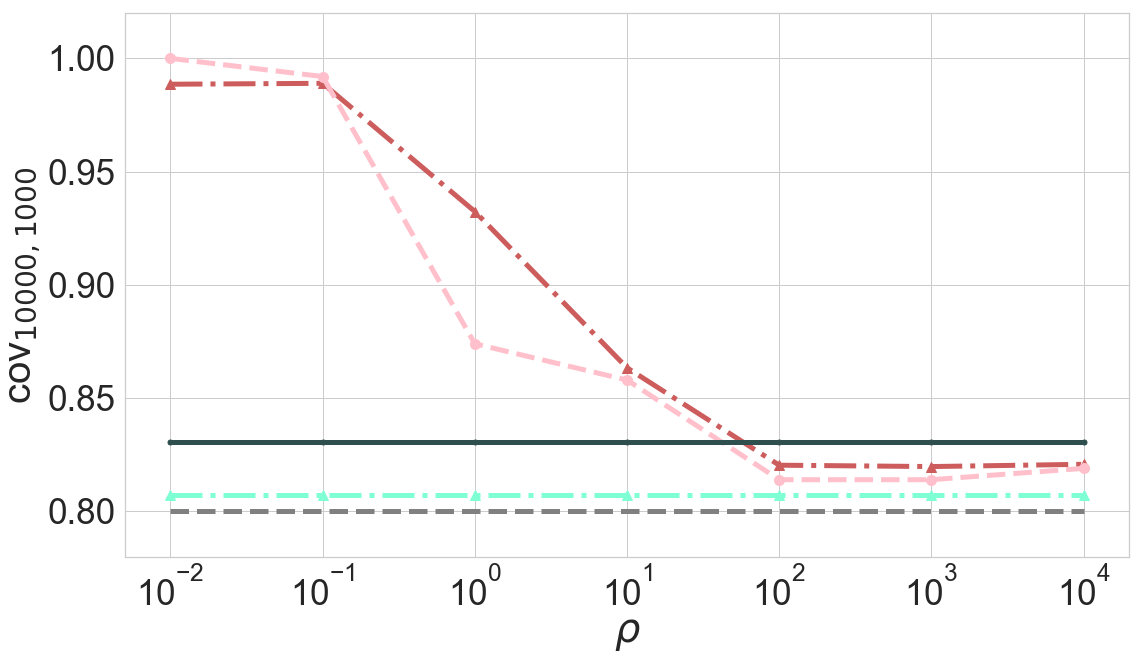

In [420]:
imp.reload(analysis)

title = r"Varying $\rho$ (P=LN(ln(%.1f),%.1f), $n$=%s, $\alpha$=%.2f, $\theta$=%.2f, $\mathcal{R}$=[%s,%s])" % (true_median, data_scale, n, alpha, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$\rho$"
save_paths = coverage_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save=True
save_path = save_paths[1]
plt = analysis.plotCIs(algs, dataset_name, title, rho, xlabel, alg_names, alpha=alpha,
            param_string=param_string, ratio=False, T=num_trials*num_datasets, n=n, show_title=False,
          log=False, xlog=True, legend_out=False, legend=False, xlim=None, ylim=[0.78, 1.02], sort='byParam', coverage=True, 
            save=save, save_path=save_path, colors=alg_colors, styles=alg_styles, blackwhite=True)

# Coverage - varying n

In [359]:
dataset_name='lognormal_v3'
num_datasets = 10000
n = 1000
data_center = 0.5
data_scale = 5.0
true_median = st.lognorm.median(data_scale, loc=data_center)
print("true median:", true_median)

num_trials = 1
range_center = 5
range_scale = 10
rho = 1.0
alpha = 0.2
beta = 0.01
quantile = 0.5
granularity = 0.01
em_granularity = 0.005

param_string = 'n'
n = [100.,  450.,  800., 1150., 1500., 1850., 5000]
num_params = len(n)
print(param_string, n)

true median: 1.5
n [100.0, 450.0, 800.0, 1150.0, 1500.0, 1850.0, 5000]


In [360]:
imp.reload(run_cis)
imp.reload(exp_median)
imp.reload(wrap)
imp.reload(analysis)
imp.reload(common)

run_indices = [8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)

run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, true_median=true_median, 
                  alpha=alpha, beta=beta, 
                  quantile=quantile, n=n, em_granularity=em_granularity, granularity=granularity,
                  alg_list=algs, data_center=data_center, data_scale=data_scale, data_distribution='lognormal',
                  gen_data=True, rerun_algs=True, gen_preprocess=True, start_param=0)

['Nonpriv_lognormal']
generating datasets


KeyboardInterrupt: 

['Expmedian', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMech', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
../../figs/coverage-n/coverage-80-lognormal_v3-revised-varying-n.pdf
0 ExpMech
1 CDFPostProcess
2 Nonprivate Lognormal
3 Nonprivate Nonparametric
alpha lines: [[100.0, 450.0, 800.0, 1150.0, 1500.0, 1850.0, 5000], [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]]


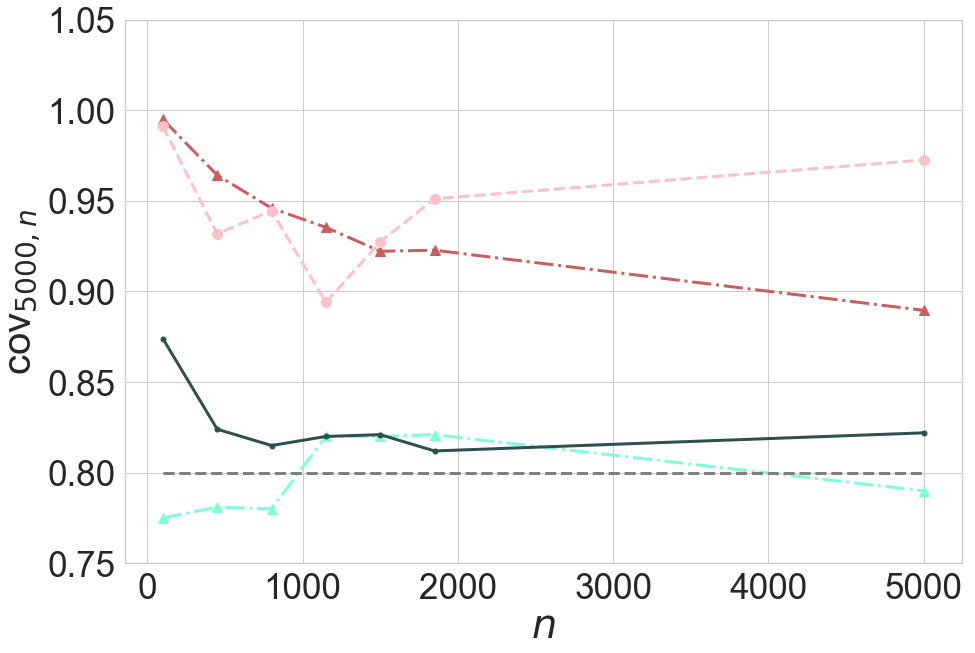

In [347]:
imp.reload(analysis)

title = r"Varying $n$ (P=LN(ln(%.1f),%.1f), $\rho$=%.2f, $\alpha$=%.2f, $\theta$=%.2f, $\mathcal{R}$=[%s,%s])" % (true_median, data_scale, rho, alpha, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$n$"
save_paths = coverage_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save=True
save_path = save_paths[1]
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, n, xlabel, alg_names, alpha=alpha,
            param_string=param_string, ratio=False, T=num_trials*num_datasets, n=n, show_title=False,
          log=False, legend_out=False, legend=False, xlim=None, ylim=[0.75, 1.05], sort='byParam', 
                       dataset_param=True, coverage=True, 
            save=save, save_path=save_path, colors=alg_colors, styles=alg_styles, blackwhite=True)

# Coverage - varying n - v4 (Figure 4b)

In [423]:
dataset_name='lognormal_v4'
num_datasets = 1000
n = 1000
data_center = 0.5
data_scale = 5.0
true_median = st.lognorm.median(data_scale, loc=data_center)
print("true median:", true_median)

num_trials = 5
range_center = 5
range_scale = 10
rho = 1.0
alpha = 0.2
beta = 0.01
quantile = 0.1
granularity = 0.005
em_granularity = 0.005

param_string = 'n'
n = [100.,  500., 1000., 5000, 10000, 50000]
num_params = len(n)
print(param_string, n)

true median: 1.5
n [100.0, 500.0, 1000.0, 5000, 10000, 50000]


In [424]:
imp.reload(run_cis)
imp.reload(exp_median)
imp.reload(wrap)
imp.reload(analysis)
imp.reload(common)
imp.reload(pub)

run_indices = [1]
algs = [alg_index[i][0] for i in run_indices]
print(algs)

run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, true_median=true_median, 
                  alpha=alpha, beta=beta, 
                  quantile=quantile, n=n, em_granularity=em_granularity, granularity=granularity,
                  alg_list=algs, data_center=data_center, data_scale=data_scale, data_distribution='lognormal',
                  gen_data=True, rerun_algs=True, gen_preprocess=True, start_param=5)

['Expmedian']
generating datasets
starting EM
param 5 of 6
Computing coefficients
Finished computing coefficients
n: 50000
Searching for lower quantile
i: 500
i: 1000
i: 1500
i: 2000
i: 2500
i: 3000
i: 3500
i: 4000
i: 4500
i: 5000
i: 5500
i: 6000
i: 6500
i: 7000
i: 7500
i: 8000
i: 8500
i: 9000
i: 9500
i: 10000
i: 10500
i: 11000
i: 11500
i: 12000
i: 12500
i: 13000
i: 13500
i: 14000
i: 14500
i: 15000
i: 15500
i: 16000
i: 16500
i: 17000
i: 17500
i: 18000
i: 18500
i: 19000
i: 19500
i: 20000
i: 20500
i: 21000
i: 21500
i: 22000
i: 22500
i: 23000
i: 23500
i: 24000
i: 24500
i: 25000
Searching for upper quantile
i: 25500
i: 26000
i: 26500
i: 27000
i: 27500
i: 28000
i: 28500
i: 29000
i: 29500
i: 30000
i: 30500
i: 31000
i: 31500
i: 32000
i: 32500
i: 33000
i: 33500
i: 34000
i: 34500
i: 35000
i: 35500
i: 36000
i: 36500
i: 37000
i: 37500
i: 38000
i: 38500
i: 39000
i: 39500
i: 40000
i: 40500
i: 41000
i: 41500
i: 42000
i: 42500
i: 43000
i: 43500
i: 44000
i: 44500
i: 45000
i: 45500
i: 46000
i: 46500
i:

dataset 112 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_106.npy
dataset 113 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_660.npy
dataset 114 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_853.npy
dataset 115 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_847.npy
dataset 116 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_843.npy
dataset 117 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_857.npy
dataset 118 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_658.npy
dataset 119 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_880.npy
dataset 120 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_894.npy
dataset 121 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_664.npy
dataset 122 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_102.npy
dataset 123 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_116.npy
dataset 124 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_670.npy
dataset 125 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_499.npy
dataset 126 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_328.npy
dataset 127 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_300.npy
dataset 

dataset 245 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_588.npy
dataset 246 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_205.npy
dataset 247 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_563.npy
dataset 248 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_577.npy
dataset 249 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_211.npy
dataset 250 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_239.npy
dataset 251 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_38.npy
dataset 252 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_946.npy
dataset 253 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_10.npy
dataset 254 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_952.npy
dataset 255 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_761.npy
dataset 256 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_775.npy
dataset 257 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_985.npy
dataset 258 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_991.npy
dataset 259 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_749.npy
dataset 260 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_748.npy
dataset 26

dataset 378 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_799.npy
dataset 379 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_955.npy
dataset 380 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_17.npy
dataset 381 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_202.npy
dataset 382 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_564.npy
dataset 383 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_570.npy
dataset 384 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_216.npy
dataset 385 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_558.npy
dataset 386 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_376.npy
dataset 387 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_410.npy
dataset 388 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_404.npy
dataset 389 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_362.npy
dataset 390 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_438.npy
dataset 391 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_389.npy
dataset 392 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_612.npy
dataset 393 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_174.npy
dataset 3

dataset 511 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_580.npy
dataset 512 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_379.npy
dataset 513 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_423.npy
dataset 514 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_345.npy
dataset 515 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_351.npy
dataset 516 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_437.npy
dataset 517 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_386.npy
dataset 518 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_392.npy
dataset 519 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_609.npy
dataset 520 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_147.npy
dataset 521 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_621.npy
dataset 522 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_635.npy
dataset 523 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_153.npy
dataset 524 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_806.npy
dataset 525 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_812.npy
dataset 526 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_184.npy
dataset 

dataset 644 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_579.npy
dataset 645 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_586.npy
dataset 646 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_592.npy
dataset 647 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_357.npy
dataset 648 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_431.npy
dataset 649 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_425.npy
dataset 650 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_343.npy
dataset 651 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_419.npy
dataset 652 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_394.npy
dataset 653 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_380.npy
dataset 654 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_633.npy
dataset 655 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_155.npy
dataset 656 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_141.npy
dataset 657 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_627.npy
dataset 658 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_169.npy
dataset 659 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_828.npy
dataset 

dataset 777 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_520.npy
dataset 778 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_246.npy
dataset 779 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_291.npy
dataset 780 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_285.npy
dataset 781 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_468.npy
dataset 782 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_326.npy
dataset 783 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_440.npy
dataset 784 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_454.npy
dataset 785 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_332.npy
dataset 786 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_483.npy
dataset 787 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_497.npy
dataset 788 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_118.npy
dataset 789 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_642.npy
dataset 790 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_124.npy
dataset 791 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_130.npy
dataset 792 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_656.npy
dataset 

dataset 910 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_526.npy
dataset 911 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_240.npy
dataset 912 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_254.npy
dataset 913 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_532.npy
dataset 914 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_268.npy
dataset 915 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_283.npy
dataset 916 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_297.npy
dataset 917 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_452.npy
dataset 918 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_334.npy
dataset 919 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_320.npy
dataset 920 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_446.npy
dataset 921 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_308.npy
dataset 922 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_491.npy
dataset 923 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_485.npy
dataset 924 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_136.npy
dataset 925 of 1000 lognormal_v4_n_5 lognormal_v4_n_5_888.npy
dataset 

['Expmedian', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMech', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
../../figs/coverage-n/coverage-80-lognormal_v4-revised-varying-n.pdf
0 ExpMech
ys: [0.9922, 0.9524, 0.93365, 0.88692, 0.89105]
1 CDFPostProcess
ys: [0.9936, 0.9288, 0.8856, 0.9739, 0.923]
2 Nonprivate Lognormal
ys: [0.7962, 0.7945, 0.7973, 0.8008, 0.799]
3 Nonprivate Nonparametric
ys: [0.865, 0.8376, 0.8254, 0.8059, 0.8101]
alpha lines: [[100.0, 500.0, 1000.0, 5000, 10000], [0.8, 0.8, 0.8, 0.8, 0.8]]


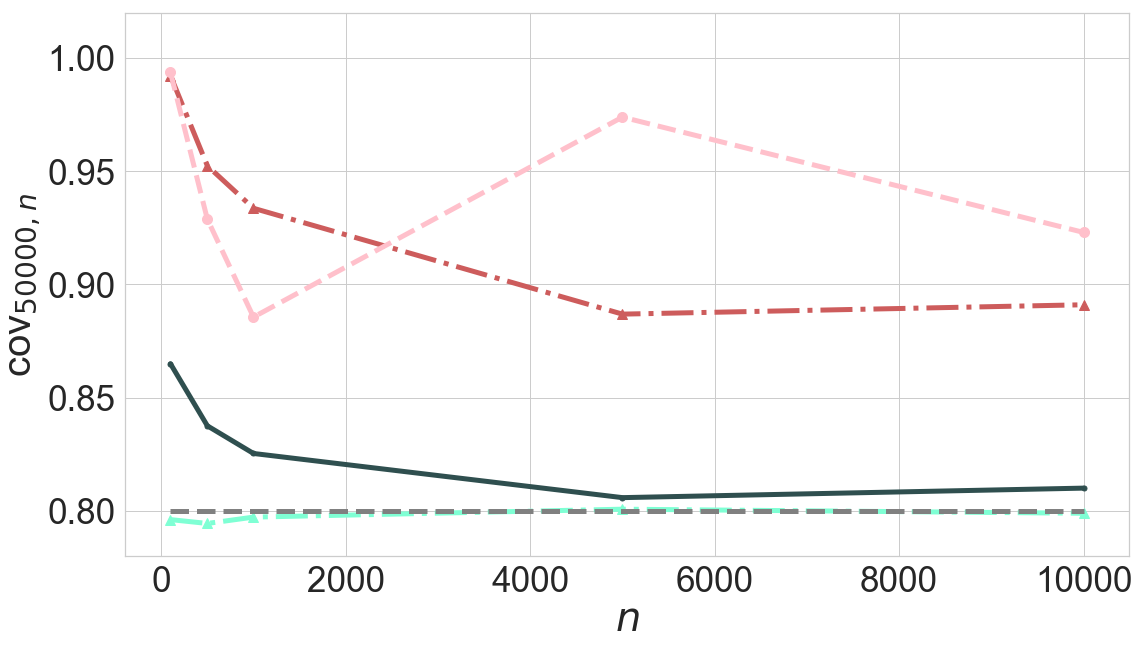

In [418]:
imp.reload(analysis)

title = r"Varying $n$ (P=LN(ln(%.1f),%.1f), $\rho$=%.2f, $\alpha$=%.2f, $\theta$=%.2f, $\mathcal{R}$=[%s,%s])" % (true_median, data_scale, rho, alpha, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$n$"
save_paths = coverage_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save=True
save_path = save_paths[1]
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, n, xlabel, alg_names, alpha=alpha,
            param_string=param_string, ratio=False, T=num_trials*num_datasets, n=n, show_title=False,
          log=False, xlog=False, legend_out=False, legend=False, xlim=None, ylim=[0.78, 1.02], sort='byParam', 
                       dataset_param=True, coverage=True, 
            save=save, save_path=save_path, colors=alg_colors, styles=alg_styles, blackwhite=True)

# Coverage - varying alpha (Figure 2b)

In [351]:
dataset_name='lognormal_flat'
num_datasets = 1000
n = 1000
data_center = 0.5
data_scale = 5.0
true_median = st.lognorm.median(data_scale, loc=data_center)
print("true median:", true_median)

# dataset_name='lognormal_cov'
# num_datasets = 1000
# n = 1000
# data_center = 0.5
# data_scale = 1.0
# true_median = st.lognorm.median(data_scale, loc=data_center)
# print("true median:", true_median)

num_trials = 5
range_center = 5
range_scale = 10
rho = 1.0
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005

alpha = [0.05, 0.1, 0.15, 0.2, 0.25]
num_params = len(alpha)
param_string='alpha'

true median: 1.5


In [205]:
imp.reload(run_cis)
imp.reload(wrap)
imp.reload(analysis)
imp.reload(cdf_median)
imp.reload(bs_cdf_median)

run_indices = [8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, true_median=true_median, 
                  alpha=alpha, beta=beta, 
                  quantile=quantile, n=n, em_granularity=em_granularity, granularity=granularity,
                  alg_list=algs, rerun_algs=True, gen_preprocess=True)

['Nonpriv_lognormal']
starting Nonpriv lognormal
param 0 of 5
n 1000 lb, ub -inf inf gran 0.05 alpha 0.05 rho 1.0
name, hyperparameters Nonpriv_lognormal_alpha_0 {'s': 1, 'loc': 0, 'granularity': 0.05, 'beta': 0.01, 'alpha': 0.05, 'cdp': True}
computing 95% CIs
eps: 1.4142135623730951
dataset 0 of 1000 lognormal_flat lognormal_flat_479.npy
dataset 1 of 1000 lognormal_flat lognormal_flat_323.npy
dataset 2 of 1000 lognormal_flat lognormal_flat_445.npy
dataset 3 of 1000 lognormal_flat lognormal_flat_451.npy
dataset 4 of 1000 lognormal_flat lognormal_flat_337.npy
dataset 5 of 1000 lognormal_flat lognormal_flat_486.npy
dataset 6 of 1000 lognormal_flat lognormal_flat_492.npy
dataset 7 of 1000 lognormal_flat lognormal_flat_109.npy
dataset 8 of 1000 lognormal_flat lognormal_flat_647.npy
dataset 9 of 1000 lognormal_flat lognormal_flat_121.npy
dataset 10 of 1000 lognormal_flat lognormal_flat_135.npy
dataset 11 of 1000 lognormal_flat lognormal_flat_653.npy
dataset 12 of 1000 lognormal_flat lognor

dataset 162 of 1000 lognormal_flat lognormal_flat_536.npy
dataset 163 of 1000 lognormal_flat lognormal_flat_522.npy
dataset 164 of 1000 lognormal_flat lognormal_flat_244.npy
dataset 165 of 1000 lognormal_flat lognormal_flat_913.npy
dataset 166 of 1000 lognormal_flat lognormal_flat_907.npy
dataset 167 of 1000 lognormal_flat lognormal_flat_708.npy
dataset 168 of 1000 lognormal_flat lognormal_flat_734.npy
dataset 169 of 1000 lognormal_flat lognormal_flat_720.npy
dataset 170 of 1000 lognormal_flat lognormal_flat_7.npy
dataset 171 of 1000 lognormal_flat lognormal_flat_867.npy
dataset 172 of 1000 lognormal_flat lognormal_flat_873.npy
dataset 173 of 1000 lognormal_flat lognormal_flat_683.npy
dataset 174 of 1000 lognormal_flat lognormal_flat_697.npy
dataset 175 of 1000 lognormal_flat lognormal_flat_668.npy
dataset 176 of 1000 lognormal_flat lognormal_flat_640.npy
dataset 177 of 1000 lognormal_flat lognormal_flat_898.npy
dataset 178 of 1000 lognormal_flat lognormal_flat_126.npy
dataset 179 of 1

dataset 315 of 1000 lognormal_flat lognormal_flat_355.npy
dataset 316 of 1000 lognormal_flat lognormal_flat_433.npy
dataset 317 of 1000 lognormal_flat lognormal_flat_427.npy
dataset 318 of 1000 lognormal_flat lognormal_flat_341.npy
dataset 319 of 1000 lognormal_flat lognormal_flat_369.npy
dataset 320 of 1000 lognormal_flat lognormal_flat_419.npy
dataset 321 of 1000 lognormal_flat lognormal_flat_431.npy
dataset 322 of 1000 lognormal_flat lognormal_flat_357.npy
dataset 323 of 1000 lognormal_flat lognormal_flat_343.npy
dataset 324 of 1000 lognormal_flat lognormal_flat_425.npy
dataset 325 of 1000 lognormal_flat lognormal_flat_394.npy
dataset 326 of 1000 lognormal_flat lognormal_flat_380.npy
dataset 327 of 1000 lognormal_flat lognormal_flat_169.npy
dataset 328 of 1000 lognormal_flat lognormal_flat_155.npy
dataset 329 of 1000 lognormal_flat lognormal_flat_633.npy
dataset 330 of 1000 lognormal_flat lognormal_flat_627.npy
dataset 331 of 1000 lognormal_flat lognormal_flat_141.npy
dataset 332 of

dataset 477 of 1000 lognormal_flat lognormal_flat_782.npy
dataset 478 of 1000 lognormal_flat lognormal_flat_972.npy
dataset 479 of 1000 lognormal_flat lognormal_flat_966.npy
dataset 480 of 1000 lognormal_flat lognormal_flat_231.npy
dataset 481 of 1000 lognormal_flat lognormal_flat_557.npy
dataset 482 of 1000 lognormal_flat lognormal_flat_543.npy
dataset 483 of 1000 lognormal_flat lognormal_flat_225.npy
dataset 484 of 1000 lognormal_flat lognormal_flat_63.npy
dataset 485 of 1000 lognormal_flat lognormal_flat_219.npy
dataset 486 of 1000 lognormal_flat lognormal_flat_77.npy
dataset 487 of 1000 lognormal_flat lognormal_flat_594.npy
dataset 488 of 1000 lognormal_flat lognormal_flat_580.npy
dataset 489 of 1000 lognormal_flat lognormal_flat_88.npy
dataset 490 of 1000 lognormal_flat lognormal_flat_581.npy
dataset 491 of 1000 lognormal_flat lognormal_flat_89.npy
dataset 492 of 1000 lognormal_flat lognormal_flat_595.npy
dataset 493 of 1000 lognormal_flat lognormal_flat_76.npy
dataset 494 of 1000

dataset 621 of 1000 lognormal_flat lognormal_flat_565.npy
dataset 622 of 1000 lognormal_flat lognormal_flat_203.npy
dataset 623 of 1000 lognormal_flat lognormal_flat_45.npy
dataset 624 of 1000 lognormal_flat lognormal_flat_559.npy
dataset 625 of 1000 lognormal_flat lognormal_flat_51.npy
dataset 626 of 1000 lognormal_flat lognormal_flat_968.npy
dataset 627 of 1000 lognormal_flat lognormal_flat_954.npy
dataset 628 of 1000 lognormal_flat lognormal_flat_798.npy
dataset 629 of 1000 lognormal_flat lognormal_flat_940.npy
dataset 630 of 1000 lognormal_flat lognormal_flat_773.npy
dataset 631 of 1000 lognormal_flat lognormal_flat_767.npy
dataset 632 of 1000 lognormal_flat lognormal_flat_997.npy
dataset 633 of 1000 lognormal_flat lognormal_flat_983.npy
dataset 634 of 1000 lognormal_flat lognormal_flat_808.npy
dataset 635 of 1000 lognormal_flat lognormal_flat_820.npy
dataset 636 of 1000 lognormal_flat lognormal_flat_834.npy
dataset 637 of 1000 lognormal_flat lognormal_flat_607.npy
dataset 638 of 1

dataset 779 of 1000 lognormal_flat lognormal_flat_896.npy
dataset 780 of 1000 lognormal_flat lognormal_flat_666.npy
dataset 781 of 1000 lognormal_flat lognormal_flat_100.npy
dataset 782 of 1000 lognormal_flat lognormal_flat_114.npy
dataset 783 of 1000 lognormal_flat lognormal_flat_672.npy
dataset 784 of 1000 lognormal_flat lognormal_flat_699.npy
dataset 785 of 1000 lognormal_flat lognormal_flat_841.npy
dataset 786 of 1000 lognormal_flat lognormal_flat_855.npy
dataset 787 of 1000 lognormal_flat lognormal_flat_9.npy
dataset 788 of 1000 lognormal_flat lognormal_flat_869.npy
dataset 789 of 1000 lognormal_flat lognormal_flat_712.npy
dataset 790 of 1000 lognormal_flat lognormal_flat_706.npy
dataset 791 of 1000 lognormal_flat lognormal_flat_935.npy
dataset 792 of 1000 lognormal_flat lognormal_flat_921.npy
dataset 793 of 1000 lognormal_flat lognormal_flat_909.npy
dataset 794 of 1000 lognormal_flat lognormal_flat_24.npy
dataset 795 of 1000 lognormal_flat lognormal_flat_538.npy
dataset 796 of 10

dataset 937 of 1000 lognormal_flat lognormal_flat_339.npy
dataset 938 of 1000 lognormal_flat lognormal_flat_305.npy
dataset 939 of 1000 lognormal_flat lognormal_flat_463.npy
dataset 940 of 1000 lognormal_flat lognormal_flat_477.npy
dataset 941 of 1000 lognormal_flat lognormal_flat_311.npy
dataset 942 of 1000 lognormal_flat lognormal_flat_461.npy
dataset 943 of 1000 lognormal_flat lognormal_flat_307.npy
dataset 944 of 1000 lognormal_flat lognormal_flat_313.npy
dataset 945 of 1000 lognormal_flat lognormal_flat_475.npy
dataset 946 of 1000 lognormal_flat lognormal_flat_449.npy
dataset 947 of 1000 lognormal_flat lognormal_flat_105.npy
dataset 948 of 1000 lognormal_flat lognormal_flat_663.npy
dataset 949 of 1000 lognormal_flat lognormal_flat_677.npy
dataset 950 of 1000 lognormal_flat lognormal_flat_111.npy
dataset 951 of 1000 lognormal_flat lognormal_flat_139.npy
dataset 952 of 1000 lognormal_flat lognormal_flat_887.npy
dataset 953 of 1000 lognormal_flat lognormal_flat_893.npy
dataset 954 of

dataset 78 of 1000 lognormal_flat lognormal_flat_863.npy
dataset 79 of 1000 lognormal_flat lognormal_flat_3.npy
dataset 80 of 1000 lognormal_flat lognormal_flat_693.npy
dataset 81 of 1000 lognormal_flat lognormal_flat_687.npy
dataset 82 of 1000 lognormal_flat lognormal_flat_718.npy
dataset 83 of 1000 lognormal_flat lognormal_flat_724.npy
dataset 84 of 1000 lognormal_flat lognormal_flat_730.npy
dataset 85 of 1000 lognormal_flat lognormal_flat_903.npy
dataset 86 of 1000 lognormal_flat lognormal_flat_917.npy
dataset 87 of 1000 lognormal_flat lognormal_flat_12.npy
dataset 88 of 1000 lognormal_flat lognormal_flat_268.npy
dataset 89 of 1000 lognormal_flat lognormal_flat_240.npy
dataset 90 of 1000 lognormal_flat lognormal_flat_526.npy
dataset 91 of 1000 lognormal_flat lognormal_flat_532.npy
dataset 92 of 1000 lognormal_flat lognormal_flat_254.npy
dataset 93 of 1000 lognormal_flat lognormal_flat_283.npy
dataset 94 of 1000 lognormal_flat lognormal_flat_297.npy
dataset 95 of 1000 lognormal_flat 

dataset 221 of 1000 lognormal_flat lognormal_flat_290.npy
dataset 222 of 1000 lognormal_flat lognormal_flat_15.npy
dataset 223 of 1000 lognormal_flat lognormal_flat_509.npy
dataset 224 of 1000 lognormal_flat lognormal_flat_29.npy
dataset 225 of 1000 lognormal_flat lognormal_flat_247.npy
dataset 226 of 1000 lognormal_flat lognormal_flat_521.npy
dataset 227 of 1000 lognormal_flat lognormal_flat_535.npy
dataset 228 of 1000 lognormal_flat lognormal_flat_253.npy
dataset 229 of 1000 lognormal_flat lognormal_flat_904.npy
dataset 230 of 1000 lognormal_flat lognormal_flat_910.npy
dataset 231 of 1000 lognormal_flat lognormal_flat_938.npy
dataset 232 of 1000 lognormal_flat lognormal_flat_723.npy
dataset 233 of 1000 lognormal_flat lognormal_flat_737.npy
dataset 234 of 1000 lognormal_flat lognormal_flat_870.npy
dataset 235 of 1000 lognormal_flat lognormal_flat_864.npy
dataset 236 of 1000 lognormal_flat lognormal_flat_4.npy
dataset 237 of 1000 lognormal_flat lognormal_flat_694.npy
dataset 238 of 100

dataset 397 of 1000 lognormal_flat lognormal_flat_144.npy
dataset 398 of 1000 lognormal_flat lognormal_flat_622.npy
dataset 399 of 1000 lognormal_flat lognormal_flat_178.npy
dataset 400 of 1000 lognormal_flat lognormal_flat_193.npy
dataset 401 of 1000 lognormal_flat lognormal_flat_187.npy
dataset 402 of 1000 lognormal_flat lognormal_flat_839.npy
dataset 403 of 1000 lognormal_flat lognormal_flat_811.npy
dataset 404 of 1000 lognormal_flat lognormal_flat_805.npy
dataset 405 of 1000 lognormal_flat lognormal_flat_742.npy
dataset 406 of 1000 lognormal_flat lognormal_flat_756.npy
dataset 407 of 1000 lognormal_flat lognormal_flat_959.npy
dataset 408 of 1000 lognormal_flat lognormal_flat_781.npy
dataset 409 of 1000 lognormal_flat lognormal_flat_795.npy
dataset 410 of 1000 lognormal_flat lognormal_flat_965.npy
dataset 411 of 1000 lognormal_flat lognormal_flat_971.npy
dataset 412 of 1000 lognormal_flat lognormal_flat_48.npy
dataset 413 of 1000 lognormal_flat lognormal_flat_226.npy
dataset 414 of 

dataset 558 of 1000 lognormal_flat lognormal_flat_566.npy
dataset 559 of 1000 lognormal_flat lognormal_flat_572.npy
dataset 560 of 1000 lognormal_flat lognormal_flat_214.npy
dataset 561 of 1000 lognormal_flat lognormal_flat_52.npy
dataset 562 of 1000 lognormal_flat lognormal_flat_46.npy
dataset 563 of 1000 lognormal_flat lognormal_flat_228.npy
dataset 564 of 1000 lognormal_flat lognormal_flat_943.npy
dataset 565 of 1000 lognormal_flat lognormal_flat_957.npy
dataset 566 of 1000 lognormal_flat lognormal_flat_764.npy
dataset 567 of 1000 lognormal_flat lognormal_flat_770.npy
dataset 568 of 1000 lognormal_flat lognormal_flat_980.npy
dataset 569 of 1000 lognormal_flat lognormal_flat_758.npy
dataset 570 of 1000 lognormal_flat lognormal_flat_994.npy
dataset 571 of 1000 lognormal_flat lognormal_flat_837.npy
dataset 572 of 1000 lognormal_flat lognormal_flat_189.npy
dataset 573 of 1000 lognormal_flat lognormal_flat_823.npy
dataset 574 of 1000 lognormal_flat lognormal_flat_610.npy
dataset 575 of 1

dataset 715 of 1000 lognormal_flat lognormal_flat_370.npy
dataset 716 of 1000 lognormal_flat lognormal_flat_358.npy
dataset 717 of 1000 lognormal_flat lognormal_flat_600.npy
dataset 718 of 1000 lognormal_flat lognormal_flat_166.npy
dataset 719 of 1000 lognormal_flat lognormal_flat_172.npy
dataset 720 of 1000 lognormal_flat lognormal_flat_614.npy
dataset 721 of 1000 lognormal_flat lognormal_flat_628.npy
dataset 722 of 1000 lognormal_flat lognormal_flat_827.npy
dataset 723 of 1000 lognormal_flat lognormal_flat_199.npy
dataset 724 of 1000 lognormal_flat lognormal_flat_833.npy
dataset 725 of 1000 lognormal_flat lognormal_flat_774.npy
dataset 726 of 1000 lognormal_flat lognormal_flat_760.npy
dataset 727 of 1000 lognormal_flat lognormal_flat_748.npy
dataset 728 of 1000 lognormal_flat lognormal_flat_990.npy
dataset 729 of 1000 lognormal_flat lognormal_flat_984.npy
dataset 730 of 1000 lognormal_flat lognormal_flat_953.npy
dataset 731 of 1000 lognormal_flat lognormal_flat_947.npy
dataset 732 of

dataset 864 of 1000 lognormal_flat lognormal_flat_506.npy
dataset 865 of 1000 lognormal_flat lognormal_flat_248.npy
dataset 866 of 1000 lognormal_flat lognormal_flat_26.npy
dataset 867 of 1000 lognormal_flat lognormal_flat_32.npy
dataset 868 of 1000 lognormal_flat lognormal_flat_937.npy
dataset 869 of 1000 lognormal_flat lognormal_flat_923.npy
dataset 870 of 1000 lognormal_flat lognormal_flat_710.npy
dataset 871 of 1000 lognormal_flat lognormal_flat_704.npy
dataset 872 of 1000 lognormal_flat lognormal_flat_738.npy
dataset 873 of 1000 lognormal_flat lognormal_flat_843.npy
dataset 874 of 1000 lognormal_flat lognormal_flat_857.npy
dataset 875 of 1000 lognormal_flat lognormal_flat_102.npy
dataset 876 of 1000 lognormal_flat lognormal_flat_664.npy
dataset 877 of 1000 lognormal_flat lognormal_flat_670.npy
dataset 878 of 1000 lognormal_flat lognormal_flat_116.npy
dataset 879 of 1000 lognormal_flat lognormal_flat_658.npy
dataset 880 of 1000 lognormal_flat lognormal_flat_880.npy
dataset 881 of 1

dataset 9 of 1000 lognormal_flat lognormal_flat_121.npy
dataset 10 of 1000 lognormal_flat lognormal_flat_135.npy
dataset 11 of 1000 lognormal_flat lognormal_flat_653.npy
dataset 12 of 1000 lognormal_flat lognormal_flat_0.npy
dataset 13 of 1000 lognormal_flat lognormal_flat_860.npy
dataset 14 of 1000 lognormal_flat lognormal_flat_874.npy
dataset 15 of 1000 lognormal_flat lognormal_flat_684.npy
dataset 16 of 1000 lognormal_flat lognormal_flat_690.npy
dataset 17 of 1000 lognormal_flat lognormal_flat_848.npy
dataset 18 of 1000 lognormal_flat lognormal_flat_733.npy
dataset 19 of 1000 lognormal_flat lognormal_flat_727.npy
dataset 20 of 1000 lognormal_flat lognormal_flat_914.npy
dataset 21 of 1000 lognormal_flat lognormal_flat_900.npy
dataset 22 of 1000 lognormal_flat lognormal_flat_928.npy
dataset 23 of 1000 lognormal_flat lognormal_flat_519.npy
dataset 24 of 1000 lognormal_flat lognormal_flat_11.npy
dataset 25 of 1000 lognormal_flat lognormal_flat_39.npy
dataset 26 of 1000 lognormal_flat lo

dataset 170 of 1000 lognormal_flat lognormal_flat_7.npy
dataset 171 of 1000 lognormal_flat lognormal_flat_867.npy
dataset 172 of 1000 lognormal_flat lognormal_flat_873.npy
dataset 173 of 1000 lognormal_flat lognormal_flat_683.npy
dataset 174 of 1000 lognormal_flat lognormal_flat_697.npy
dataset 175 of 1000 lognormal_flat lognormal_flat_668.npy
dataset 176 of 1000 lognormal_flat lognormal_flat_640.npy
dataset 177 of 1000 lognormal_flat lognormal_flat_898.npy
dataset 178 of 1000 lognormal_flat lognormal_flat_126.npy
dataset 179 of 1000 lognormal_flat lognormal_flat_132.npy
dataset 180 of 1000 lognormal_flat lognormal_flat_654.npy
dataset 181 of 1000 lognormal_flat lognormal_flat_481.npy
dataset 182 of 1000 lognormal_flat lognormal_flat_495.npy
dataset 183 of 1000 lognormal_flat lognormal_flat_318.npy
dataset 184 of 1000 lognormal_flat lognormal_flat_324.npy
dataset 185 of 1000 lognormal_flat lognormal_flat_442.npy
dataset 186 of 1000 lognormal_flat lognormal_flat_456.npy
dataset 187 of 1

dataset 314 of 1000 lognormal_flat lognormal_flat_382.npy
dataset 315 of 1000 lognormal_flat lognormal_flat_355.npy
dataset 316 of 1000 lognormal_flat lognormal_flat_433.npy
dataset 317 of 1000 lognormal_flat lognormal_flat_427.npy
dataset 318 of 1000 lognormal_flat lognormal_flat_341.npy
dataset 319 of 1000 lognormal_flat lognormal_flat_369.npy
dataset 320 of 1000 lognormal_flat lognormal_flat_419.npy
dataset 321 of 1000 lognormal_flat lognormal_flat_431.npy
dataset 322 of 1000 lognormal_flat lognormal_flat_357.npy
dataset 323 of 1000 lognormal_flat lognormal_flat_343.npy
dataset 324 of 1000 lognormal_flat lognormal_flat_425.npy
dataset 325 of 1000 lognormal_flat lognormal_flat_394.npy
dataset 326 of 1000 lognormal_flat lognormal_flat_380.npy
dataset 327 of 1000 lognormal_flat lognormal_flat_169.npy
dataset 328 of 1000 lognormal_flat lognormal_flat_155.npy
dataset 329 of 1000 lognormal_flat lognormal_flat_633.npy
dataset 330 of 1000 lognormal_flat lognormal_flat_627.npy
dataset 331 of

dataset 465 of 1000 lognormal_flat lognormal_flat_153.npy
dataset 466 of 1000 lognormal_flat lognormal_flat_635.npy
dataset 467 of 1000 lognormal_flat lognormal_flat_609.npy
dataset 468 of 1000 lognormal_flat lognormal_flat_184.npy
dataset 469 of 1000 lognormal_flat lognormal_flat_190.npy
dataset 470 of 1000 lognormal_flat lognormal_flat_806.npy
dataset 471 of 1000 lognormal_flat lognormal_flat_812.npy
dataset 472 of 1000 lognormal_flat lognormal_flat_755.npy
dataset 473 of 1000 lognormal_flat lognormal_flat_741.npy
dataset 474 of 1000 lognormal_flat lognormal_flat_999.npy
dataset 475 of 1000 lognormal_flat lognormal_flat_769.npy
dataset 476 of 1000 lognormal_flat lognormal_flat_796.npy
dataset 477 of 1000 lognormal_flat lognormal_flat_782.npy
dataset 478 of 1000 lognormal_flat lognormal_flat_972.npy
dataset 479 of 1000 lognormal_flat lognormal_flat_966.npy
dataset 480 of 1000 lognormal_flat lognormal_flat_231.npy
dataset 481 of 1000 lognormal_flat lognormal_flat_557.npy
dataset 482 of

dataset 621 of 1000 lognormal_flat lognormal_flat_565.npy
dataset 622 of 1000 lognormal_flat lognormal_flat_203.npy
dataset 623 of 1000 lognormal_flat lognormal_flat_45.npy
dataset 624 of 1000 lognormal_flat lognormal_flat_559.npy
dataset 625 of 1000 lognormal_flat lognormal_flat_51.npy
dataset 626 of 1000 lognormal_flat lognormal_flat_968.npy
dataset 627 of 1000 lognormal_flat lognormal_flat_954.npy
dataset 628 of 1000 lognormal_flat lognormal_flat_798.npy
dataset 629 of 1000 lognormal_flat lognormal_flat_940.npy
dataset 630 of 1000 lognormal_flat lognormal_flat_773.npy
dataset 631 of 1000 lognormal_flat lognormal_flat_767.npy
dataset 632 of 1000 lognormal_flat lognormal_flat_997.npy
dataset 633 of 1000 lognormal_flat lognormal_flat_983.npy
dataset 634 of 1000 lognormal_flat lognormal_flat_808.npy
dataset 635 of 1000 lognormal_flat lognormal_flat_820.npy
dataset 636 of 1000 lognormal_flat lognormal_flat_834.npy
dataset 637 of 1000 lognormal_flat lognormal_flat_607.npy
dataset 638 of 1

dataset 793 of 1000 lognormal_flat lognormal_flat_909.npy
dataset 794 of 1000 lognormal_flat lognormal_flat_24.npy
dataset 795 of 1000 lognormal_flat lognormal_flat_538.npy
dataset 796 of 1000 lognormal_flat lognormal_flat_30.npy
dataset 797 of 1000 lognormal_flat lognormal_flat_276.npy
dataset 798 of 1000 lognormal_flat lognormal_flat_18.npy
dataset 799 of 1000 lognormal_flat lognormal_flat_510.npy
dataset 800 of 1000 lognormal_flat lognormal_flat_504.npy
dataset 801 of 1000 lognormal_flat lognormal_flat_262.npy
dataset 802 of 1000 lognormal_flat lognormal_flat_289.npy
dataset 803 of 1000 lognormal_flat lognormal_flat_288.npy
dataset 804 of 1000 lognormal_flat lognormal_flat_505.npy
dataset 805 of 1000 lognormal_flat lognormal_flat_263.npy
dataset 806 of 1000 lognormal_flat lognormal_flat_19.npy
dataset 807 of 1000 lognormal_flat lognormal_flat_277.npy
dataset 808 of 1000 lognormal_flat lognormal_flat_511.npy
dataset 809 of 1000 lognormal_flat lognormal_flat_539.npy
dataset 810 of 100

dataset 962 of 1000 lognormal_flat lognormal_flat_924.npy
dataset 963 of 1000 lognormal_flat lognormal_flat_515.npy
dataset 964 of 1000 lognormal_flat lognormal_flat_273.npy
dataset 965 of 1000 lognormal_flat lognormal_flat_267.npy
dataset 966 of 1000 lognormal_flat lognormal_flat_501.npy
dataset 967 of 1000 lognormal_flat lognormal_flat_529.npy
dataset 968 of 1000 lognormal_flat lognormal_flat_21.npy
dataset 969 of 1000 lognormal_flat lognormal_flat_35.npy
dataset 970 of 1000 lognormal_flat lognormal_flat_298.npy
dataset 971 of 1000 lognormal_flat lognormal_flat_299.npy
dataset 972 of 1000 lognormal_flat lognormal_flat_34.npy
dataset 973 of 1000 lognormal_flat lognormal_flat_528.npy
dataset 974 of 1000 lognormal_flat lognormal_flat_20.npy
dataset 975 of 1000 lognormal_flat lognormal_flat_266.npy
dataset 976 of 1000 lognormal_flat lognormal_flat_500.npy
dataset 977 of 1000 lognormal_flat lognormal_flat_514.npy
dataset 978 of 1000 lognormal_flat lognormal_flat_272.npy
dataset 979 of 100

dataset 101 of 1000 lognormal_flat lognormal_flat_269.npy
dataset 102 of 1000 lognormal_flat lognormal_flat_13.npy
dataset 103 of 1000 lognormal_flat lognormal_flat_916.npy
dataset 104 of 1000 lognormal_flat lognormal_flat_902.npy
dataset 105 of 1000 lognormal_flat lognormal_flat_731.npy
dataset 106 of 1000 lognormal_flat lognormal_flat_725.npy
dataset 107 of 1000 lognormal_flat lognormal_flat_719.npy
dataset 108 of 1000 lognormal_flat lognormal_flat_686.npy
dataset 109 of 1000 lognormal_flat lognormal_flat_692.npy
dataset 110 of 1000 lognormal_flat lognormal_flat_862.npy
dataset 111 of 1000 lognormal_flat lognormal_flat_2.npy
dataset 112 of 1000 lognormal_flat lognormal_flat_876.npy
dataset 113 of 1000 lognormal_flat lognormal_flat_123.npy
dataset 114 of 1000 lognormal_flat lognormal_flat_645.npy
dataset 115 of 1000 lognormal_flat lognormal_flat_651.npy
dataset 116 of 1000 lognormal_flat lognormal_flat_889.npy
dataset 117 of 1000 lognormal_flat lognormal_flat_137.npy
dataset 118 of 10

dataset 246 of 1000 lognormal_flat lognormal_flat_482.npy
dataset 247 of 1000 lognormal_flat lognormal_flat_469.npy
dataset 248 of 1000 lognormal_flat lognormal_flat_333.npy
dataset 249 of 1000 lognormal_flat lognormal_flat_455.npy
dataset 250 of 1000 lognormal_flat lognormal_flat_441.npy
dataset 251 of 1000 lognormal_flat lognormal_flat_327.npy
dataset 252 of 1000 lognormal_flat lognormal_flat_368.npy
dataset 253 of 1000 lognormal_flat lognormal_flat_426.npy
dataset 254 of 1000 lognormal_flat lognormal_flat_340.npy
dataset 255 of 1000 lognormal_flat lognormal_flat_354.npy
dataset 256 of 1000 lognormal_flat lognormal_flat_432.npy
dataset 257 of 1000 lognormal_flat lognormal_flat_383.npy
dataset 258 of 1000 lognormal_flat lognormal_flat_397.npy
dataset 259 of 1000 lognormal_flat lognormal_flat_618.npy
dataset 260 of 1000 lognormal_flat lognormal_flat_142.npy
dataset 261 of 1000 lognormal_flat lognormal_flat_624.npy
dataset 262 of 1000 lognormal_flat lognormal_flat_630.npy
dataset 263 of

dataset 418 of 1000 lognormal_flat lognormal_flat_568.npy
dataset 419 of 1000 lognormal_flat lognormal_flat_60.npy
dataset 420 of 1000 lognormal_flat lognormal_flat_583.npy
dataset 421 of 1000 lognormal_flat lognormal_flat_597.npy
dataset 422 of 1000 lognormal_flat lognormal_flat_596.npy
dataset 423 of 1000 lognormal_flat lognormal_flat_582.npy
dataset 424 of 1000 lognormal_flat lognormal_flat_569.npy
dataset 425 of 1000 lognormal_flat lognormal_flat_61.npy
dataset 426 of 1000 lognormal_flat lognormal_flat_75.npy
dataset 427 of 1000 lognormal_flat lognormal_flat_555.npy
dataset 428 of 1000 lognormal_flat lognormal_flat_233.npy
dataset 429 of 1000 lognormal_flat lognormal_flat_227.npy
dataset 430 of 1000 lognormal_flat lognormal_flat_49.npy
dataset 431 of 1000 lognormal_flat lognormal_flat_541.npy
dataset 432 of 1000 lognormal_flat lognormal_flat_970.npy
dataset 433 of 1000 lognormal_flat lognormal_flat_964.npy
dataset 434 of 1000 lognormal_flat lognormal_flat_794.npy
dataset 435 of 100

dataset 576 of 1000 lognormal_flat lognormal_flat_162.npy
dataset 577 of 1000 lognormal_flat lognormal_flat_604.npy
dataset 578 of 1000 lognormal_flat lognormal_flat_638.npy
dataset 579 of 1000 lognormal_flat lognormal_flat_374.npy
dataset 580 of 1000 lognormal_flat lognormal_flat_412.npy
dataset 581 of 1000 lognormal_flat lognormal_flat_406.npy
dataset 582 of 1000 lognormal_flat lognormal_flat_360.npy
dataset 583 of 1000 lognormal_flat lognormal_flat_348.npy
dataset 584 of 1000 lognormal_flat lognormal_flat_438.npy
dataset 585 of 1000 lognormal_flat lognormal_flat_410.npy
dataset 586 of 1000 lognormal_flat lognormal_flat_376.npy
dataset 587 of 1000 lognormal_flat lognormal_flat_362.npy
dataset 588 of 1000 lognormal_flat lognormal_flat_404.npy
dataset 589 of 1000 lognormal_flat lognormal_flat_389.npy
dataset 590 of 1000 lognormal_flat lognormal_flat_148.npy
dataset 591 of 1000 lognormal_flat lognormal_flat_174.npy
dataset 592 of 1000 lognormal_flat lognormal_flat_612.npy
dataset 593 of

dataset 743 of 1000 lognormal_flat lognormal_flat_80.npy
dataset 744 of 1000 lognormal_flat lognormal_flat_588.npy
dataset 745 of 1000 lognormal_flat lognormal_flat_239.npy
dataset 746 of 1000 lognormal_flat lognormal_flat_57.npy
dataset 747 of 1000 lognormal_flat lognormal_flat_43.npy
dataset 748 of 1000 lognormal_flat lognormal_flat_563.npy
dataset 749 of 1000 lognormal_flat lognormal_flat_205.npy
dataset 750 of 1000 lognormal_flat lognormal_flat_211.npy
dataset 751 of 1000 lognormal_flat lognormal_flat_577.npy
dataset 752 of 1000 lognormal_flat lognormal_flat_946.npy
dataset 753 of 1000 lognormal_flat lognormal_flat_952.npy
dataset 754 of 1000 lognormal_flat lognormal_flat_985.npy
dataset 755 of 1000 lognormal_flat lognormal_flat_991.npy
dataset 756 of 1000 lognormal_flat lognormal_flat_749.npy
dataset 757 of 1000 lognormal_flat lognormal_flat_761.npy
dataset 758 of 1000 lognormal_flat lognormal_flat_775.npy
dataset 759 of 1000 lognormal_flat lognormal_flat_832.npy
dataset 760 of 10

dataset 887 of 1000 lognormal_flat lognormal_flat_328.npy
dataset 888 of 1000 lognormal_flat lognormal_flat_476.npy
dataset 889 of 1000 lognormal_flat lognormal_flat_310.npy
dataset 890 of 1000 lognormal_flat lognormal_flat_304.npy
dataset 891 of 1000 lognormal_flat lognormal_flat_462.npy
dataset 892 of 1000 lognormal_flat lognormal_flat_338.npy
dataset 893 of 1000 lognormal_flat lognormal_flat_489.npy
dataset 894 of 1000 lognormal_flat lognormal_flat_112.npy
dataset 895 of 1000 lognormal_flat lognormal_flat_674.npy
dataset 896 of 1000 lognormal_flat lognormal_flat_660.npy
dataset 897 of 1000 lognormal_flat lognormal_flat_106.npy
dataset 898 of 1000 lognormal_flat lognormal_flat_890.npy
dataset 899 of 1000 lognormal_flat lognormal_flat_648.npy
dataset 900 of 1000 lognormal_flat lognormal_flat_884.npy
dataset 901 of 1000 lognormal_flat lognormal_flat_853.npy
dataset 902 of 1000 lognormal_flat lognormal_flat_847.npy
dataset 903 of 1000 lognormal_flat lognormal_flat_700.npy
dataset 904 of

dataset 40 of 1000 lognormal_flat lognormal_flat_10.npy
dataset 41 of 1000 lognormal_flat lognormal_flat_929.npy
dataset 42 of 1000 lognormal_flat lognormal_flat_901.npy
dataset 43 of 1000 lognormal_flat lognormal_flat_915.npy
dataset 44 of 1000 lognormal_flat lognormal_flat_726.npy
dataset 45 of 1000 lognormal_flat lognormal_flat_732.npy
dataset 46 of 1000 lognormal_flat lognormal_flat_849.npy
dataset 47 of 1000 lognormal_flat lognormal_flat_691.npy
dataset 48 of 1000 lognormal_flat lognormal_flat_685.npy
dataset 49 of 1000 lognormal_flat lognormal_flat_875.npy
dataset 50 of 1000 lognormal_flat lognormal_flat_1.npy
dataset 51 of 1000 lognormal_flat lognormal_flat_861.npy
dataset 52 of 1000 lognormal_flat lognormal_flat_134.npy
dataset 53 of 1000 lognormal_flat lognormal_flat_652.npy
dataset 54 of 1000 lognormal_flat lognormal_flat_646.npy
dataset 55 of 1000 lognormal_flat lognormal_flat_120.npy
dataset 56 of 1000 lognormal_flat lognormal_flat_108.npy
dataset 57 of 1000 lognormal_flat 

dataset 202 of 1000 lognormal_flat lognormal_flat_695.npy
dataset 203 of 1000 lognormal_flat lognormal_flat_865.npy
dataset 204 of 1000 lognormal_flat lognormal_flat_5.npy
dataset 205 of 1000 lognormal_flat lognormal_flat_871.npy
dataset 206 of 1000 lognormal_flat lognormal_flat_736.npy
dataset 207 of 1000 lognormal_flat lognormal_flat_722.npy
dataset 208 of 1000 lognormal_flat lognormal_flat_939.npy
dataset 209 of 1000 lognormal_flat lognormal_flat_911.npy
dataset 210 of 1000 lognormal_flat lognormal_flat_905.npy
dataset 211 of 1000 lognormal_flat lognormal_flat_534.npy
dataset 212 of 1000 lognormal_flat lognormal_flat_252.npy
dataset 213 of 1000 lognormal_flat lognormal_flat_246.npy
dataset 214 of 1000 lognormal_flat lognormal_flat_28.npy
dataset 215 of 1000 lognormal_flat lognormal_flat_520.npy
dataset 216 of 1000 lognormal_flat lognormal_flat_508.npy
dataset 217 of 1000 lognormal_flat lognormal_flat_14.npy
dataset 218 of 1000 lognormal_flat lognormal_flat_291.npy
dataset 219 of 100

dataset 357 of 1000 lognormal_flat lognormal_flat_236.npy
dataset 358 of 1000 lognormal_flat lognormal_flat_550.npy
dataset 359 of 1000 lognormal_flat lognormal_flat_544.npy
dataset 360 of 1000 lognormal_flat lognormal_flat_222.npy
dataset 361 of 1000 lognormal_flat lognormal_flat_64.npy
dataset 362 of 1000 lognormal_flat lognormal_flat_578.npy
dataset 363 of 1000 lognormal_flat lognormal_flat_70.npy
dataset 364 of 1000 lognormal_flat lognormal_flat_791.npy
dataset 365 of 1000 lognormal_flat lognormal_flat_949.npy
dataset 366 of 1000 lognormal_flat lognormal_flat_785.npy
dataset 367 of 1000 lognormal_flat lognormal_flat_975.npy
dataset 368 of 1000 lognormal_flat lognormal_flat_961.npy
dataset 369 of 1000 lognormal_flat lognormal_flat_752.npy
dataset 370 of 1000 lognormal_flat lognormal_flat_746.npy
dataset 371 of 1000 lognormal_flat lognormal_flat_183.npy
dataset 372 of 1000 lognormal_flat lognormal_flat_197.npy
dataset 373 of 1000 lognormal_flat lognormal_flat_829.npy
dataset 374 of 1

dataset 520 of 1000 lognormal_flat lognormal_flat_436.npy
dataset 521 of 1000 lognormal_flat lognormal_flat_350.npy
dataset 522 of 1000 lognormal_flat lognormal_flat_344.npy
dataset 523 of 1000 lognormal_flat lognormal_flat_422.npy
dataset 524 of 1000 lognormal_flat lognormal_flat_349.npy
dataset 525 of 1000 lognormal_flat lognormal_flat_407.npy
dataset 526 of 1000 lognormal_flat lognormal_flat_361.npy
dataset 527 of 1000 lognormal_flat lognormal_flat_375.npy
dataset 528 of 1000 lognormal_flat lognormal_flat_413.npy
dataset 529 of 1000 lognormal_flat lognormal_flat_639.npy
dataset 530 of 1000 lognormal_flat lognormal_flat_163.npy
dataset 531 of 1000 lognormal_flat lognormal_flat_605.npy
dataset 532 of 1000 lognormal_flat lognormal_flat_611.npy
dataset 533 of 1000 lognormal_flat lognormal_flat_177.npy
dataset 534 of 1000 lognormal_flat lognormal_flat_822.npy
dataset 535 of 1000 lognormal_flat lognormal_flat_836.npy
dataset 536 of 1000 lognormal_flat lognormal_flat_188.npy
dataset 537 of

dataset 676 of 1000 lognormal_flat lognormal_flat_549.npy
dataset 677 of 1000 lognormal_flat lognormal_flat_41.npy
dataset 678 of 1000 lognormal_flat lognormal_flat_96.npy
dataset 679 of 1000 lognormal_flat lognormal_flat_82.npy
dataset 680 of 1000 lognormal_flat lognormal_flat_83.npy
dataset 681 of 1000 lognormal_flat lognormal_flat_97.npy
dataset 682 of 1000 lognormal_flat lognormal_flat_548.npy
dataset 683 of 1000 lognormal_flat lognormal_flat_40.npy
dataset 684 of 1000 lognormal_flat lognormal_flat_54.npy
dataset 685 of 1000 lognormal_flat lognormal_flat_574.npy
dataset 686 of 1000 lognormal_flat lognormal_flat_212.npy
dataset 687 of 1000 lognormal_flat lognormal_flat_68.npy
dataset 688 of 1000 lognormal_flat lognormal_flat_206.npy
dataset 689 of 1000 lognormal_flat lognormal_flat_560.npy
dataset 690 of 1000 lognormal_flat lognormal_flat_789.npy
dataset 691 of 1000 lognormal_flat lognormal_flat_951.npy
dataset 692 of 1000 lognormal_flat lognormal_flat_945.npy
dataset 693 of 1000 lo

dataset 837 of 1000 lognormal_flat lognormal_flat_467.npy
dataset 838 of 1000 lognormal_flat lognormal_flat_301.npy
dataset 839 of 1000 lognormal_flat lognormal_flat_498.npy
dataset 840 of 1000 lognormal_flat lognormal_flat_895.npy
dataset 841 of 1000 lognormal_flat lognormal_flat_881.npy
dataset 842 of 1000 lognormal_flat lognormal_flat_659.npy
dataset 843 of 1000 lognormal_flat lognormal_flat_671.npy
dataset 844 of 1000 lognormal_flat lognormal_flat_117.npy
dataset 845 of 1000 lognormal_flat lognormal_flat_103.npy
dataset 846 of 1000 lognormal_flat lognormal_flat_665.npy
dataset 847 of 1000 lognormal_flat lognormal_flat_856.npy
dataset 848 of 1000 lognormal_flat lognormal_flat_842.npy
dataset 849 of 1000 lognormal_flat lognormal_flat_739.npy
dataset 850 of 1000 lognormal_flat lognormal_flat_705.npy
dataset 851 of 1000 lognormal_flat lognormal_flat_711.npy
dataset 852 of 1000 lognormal_flat lognormal_flat_922.npy
dataset 853 of 1000 lognormal_flat lognormal_flat_936.npy
dataset 854 of

dataset 986 of 1000 lognormal_flat lognormal_flat_845.npy
dataset 987 of 1000 lognormal_flat lognormal_flat_879.npy
dataset 988 of 1000 lognormal_flat lognormal_flat_892.npy
dataset 989 of 1000 lognormal_flat lognormal_flat_138.npy
dataset 990 of 1000 lognormal_flat lognormal_flat_886.npy
dataset 991 of 1000 lognormal_flat lognormal_flat_676.npy
dataset 992 of 1000 lognormal_flat lognormal_flat_110.npy
dataset 993 of 1000 lognormal_flat lognormal_flat_104.npy
dataset 994 of 1000 lognormal_flat lognormal_flat_662.npy
dataset 995 of 1000 lognormal_flat lognormal_flat_448.npy
dataset 996 of 1000 lognormal_flat lognormal_flat_312.npy
dataset 997 of 1000 lognormal_flat lognormal_flat_474.npy
dataset 998 of 1000 lognormal_flat lognormal_flat_460.npy
dataset 999 of 1000 lognormal_flat lognormal_flat_306.npy
results/lognormal_flat_Nonpriv_lognormal_alpha_4_75.npy
running analysis
nonpriv_median: 1.4330932032814125
Coverage - nonpriv: 0.757 priv: 0.756
Save path: analysis/lognormal_flat_sizes_N

['Expmedian', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMech', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
Nonpriv path: analysis/lognormal_flat_sizes_Expmedian_alpha_0.npy
Nonpriv path: analysis/lognormal_flat_sizes_Expmedian_alpha_1.npy
Nonpriv path: analysis/lognormal_flat_sizes_Expmedian_alpha_2.npy
Nonpriv path: analysis/lognormal_flat_sizes_Expmedian_alpha_3.npy
Nonpriv path: analysis/lognormal_flat_sizes_Expmedian_alpha_4.npy
0 ExpMech
1 CDFPostProcess
2 Nonprivate Lognormal
3 Nonprivate Nonparametric
alpha lines: [[0.05, 0.1, 0.15, 0.2, 0.25], [0.95, 0.9, 0.85, 0.8, 0.75]]


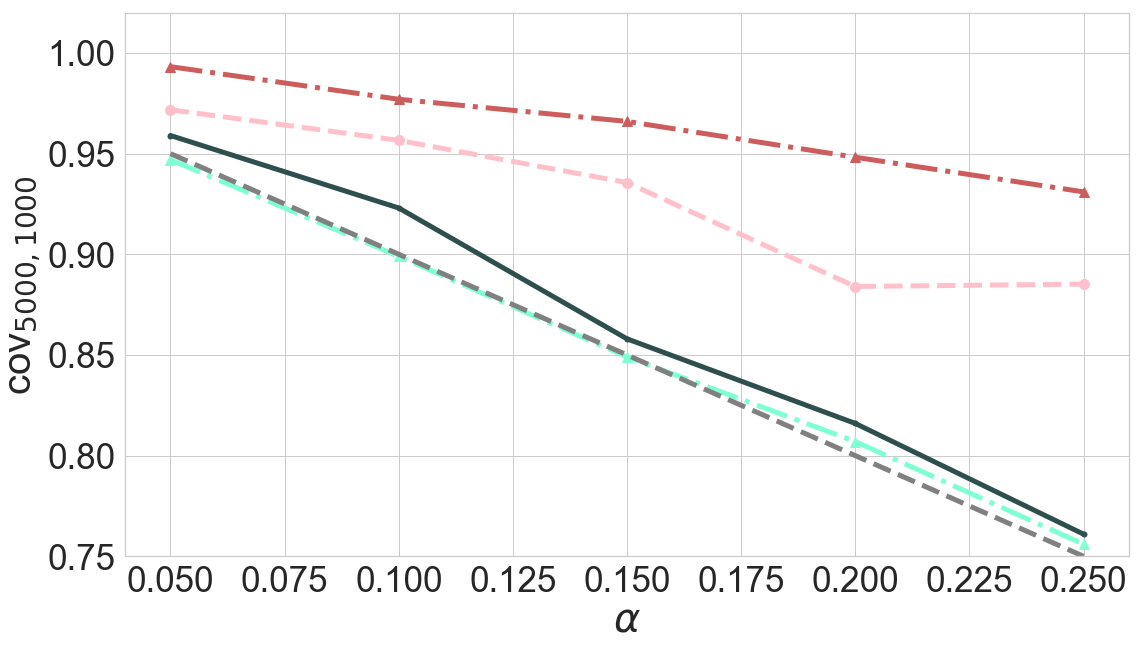

['Expmedian_naive', 'Expmedian', 'CDFmedian_naive', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMechUnion', 'ExpMech', 'CDFPostProcessUnion', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
Nonpriv path: analysis/lognormal_flat_sizes_Expmedian_naive_alpha_0.npy
Nonpriv path: analysis/lognormal_flat_sizes_Expmedian_naive_alpha_1.npy
Nonpriv path: analysis/lognormal_flat_sizes_Expmedian_naive_alpha_2.npy
Nonpriv path: analysis/lognormal_flat_sizes_Expmedian_naive_alpha_3.npy
Nonpriv path: analysis/lognormal_flat_sizes_Expmedian_naive_alpha_4.npy
0 ExpMechUnion
1 ExpMech
2 CDFPostProcessUnion
3 CDFPostProcess
4 Nonprivate Lognormal
5 Nonprivate Nonparametric
alpha lines: [[0.05, 0.1, 0.15, 0.2, 0.25], [0.95, 0.9, 0.85, 0.8, 0.75]]


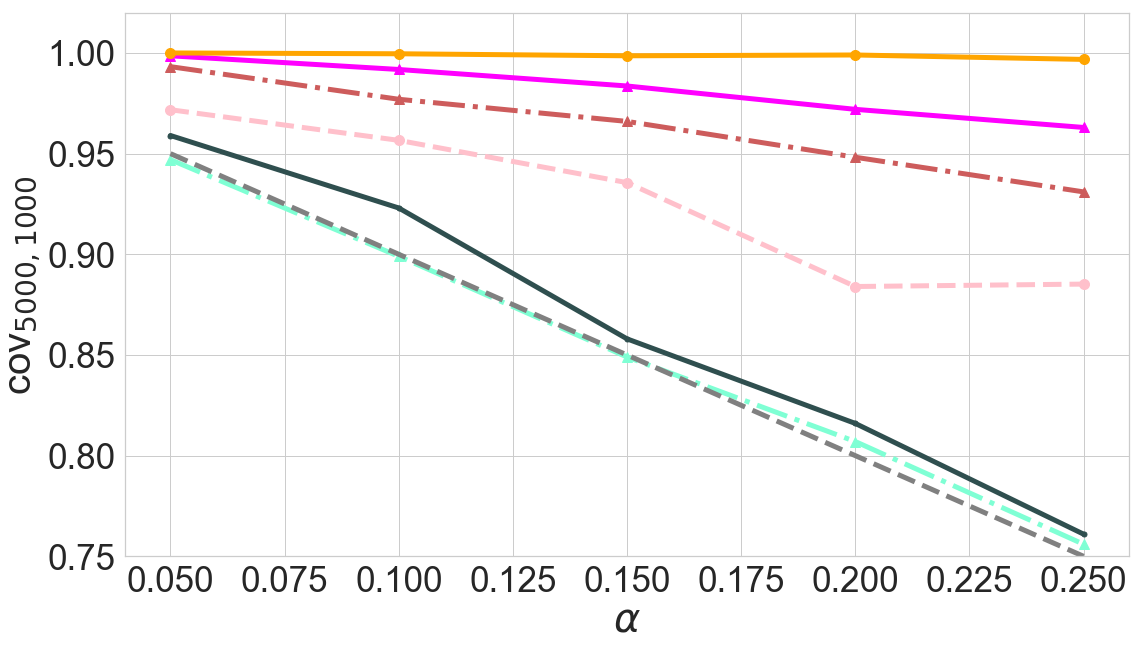

In [353]:
imp.reload(analysis)

title = r"Varying $\alpha$ (P=LN(ln(%.1f),%.1f), $n$=%s, $\rho$=%.1f, $\theta$=%.2f, $\mathcal{R}$=[%s,%s])" % (true_median, data_scale, n, rho, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$\alpha$"
save_paths = coverage_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path=save_paths[1]
save=True

plt = analysis.plotCIs(algs, dataset_name, title, alpha, xlabel, alg_names,
            param_string=param_string, ratio=False, alpha=None, n=n, T= num_trials*num_datasets,
          log=False, legend_out=False, legend=False, xlim=None, ylim=[0.75, 1.02], sort='byParam', coverage=True, 
            show_title=False, blackwhite=True, save=save, save_path=save_path, 
                       colors=alg_colors, styles=alg_styles)


run_indices = [0, 1, 2, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [0, 1, 2, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path=save_paths[2]
save=True

plt = analysis.plotCIs(algs, dataset_name, title, alpha, xlabel, alg_names,
            param_string=param_string, ratio=False, alpha=None, n=n, T= num_trials*num_datasets,
          log=False, legend_out=False, legend=False, xlim=None, ylim=[0.75, 1.02], sort='byParam', coverage=True, 
            show_title=False, blackwhite=True, save=save, save_path=save_path, 
                       colors=alg_colors, styles=alg_styles)

# Width - varying range size (Figure 1d)

In [316]:
num_trials = 5 # changed this from 5
range_center = 5
range_scale = 10
rho = 0.5
true_median = 1.52
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005
num_datasets=200 # changed this from 100

dataset_name='lognormal_v0'
n = 1000
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)

param_string = 'range_scale'
range_scale = [10, 30, 100, 300]
range_center = [range_scale[i]/2.0 for i in range(len(range_scale))]
num_params = len(range_scale)
print(param_string, range_scale, range_center, 
      [(range_center[i]-range_scale[i], range_center[i]+range_scale[i]) for i in range(num_params)])

range_scale [10, 30, 100, 300] [5.0, 15.0, 50.0, 150.0] [(-5.0, 15.0), (-15.0, 45.0), (-50.0, 150.0), (-150.0, 450.0)]


In [211]:
imp.reload(run_cis)
imp.reload(wrap)
imp.reload(bs_cdf_median)

run_indices = [8]
algs = [alg_index[i][0] for i in run_indices]
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, 
                  alpha=alpha, beta=beta, quantile=quantile, 
                  n=n, em_granularity=em_granularity, granularity=granularity, true_median=true_median,
                  alg_list=algs, rerun_algs=True, start_param=0, gen_preprocess=False)

starting Nonpriv lognormal
param 0 of 4
n 1000 lb, ub -inf inf gran 0.05 alpha 0.05 rho 0.5
name, hyperparameters Nonpriv_lognormal_range_scale_0 {'s': 1, 'loc': 0, 'granularity': 0.05, 'beta': 0.01, 'alpha': 0.05, 'cdp': True}
computing 95% CIs
eps: 1.0
dataset 0 of 200 lognormal_v0 lognormal_v0_807.npy
dataset 1 of 200 lognormal_v0 lognormal_v0_813.npy
dataset 2 of 200 lognormal_v0 lognormal_v0_185.npy
dataset 3 of 200 lognormal_v0 lognormal_v0_191.npy
dataset 4 of 200 lognormal_v0 lognormal_v0_608.npy
dataset 5 of 200 lognormal_v0 lognormal_v0_146.npy
dataset 6 of 200 lognormal_v0 lognormal_v0_620.npy
dataset 7 of 200 lognormal_v0 lognormal_v0_634.npy
dataset 8 of 200 lognormal_v0 lognormal_v0_152.npy
dataset 9 of 200 lognormal_v0 lognormal_v0_387.npy
dataset 10 of 200 lognormal_v0 lognormal_v0_56.npy
dataset 11 of 200 lognormal_v0 lognormal_v0_42.npy
dataset 12 of 200 lognormal_v0 lognormal_v0_393.npy
dataset 13 of 200 lognormal_v0 lognormal_v0_378.npy
dataset 14 of 200 lognormal_v

dataset 162 of 200 lognormal_v0 lognormal_v0_342.npy
dataset 163 of 200 lognormal_v0 lognormal_v0_418.npy
dataset 164 of 200 lognormal_v0 lognormal_v0_587.npy
dataset 165 of 200 lognormal_v0 lognormal_v0_593.npy
dataset 166 of 200 lognormal_v0 lognormal_v0_222.npy
dataset 167 of 200 lognormal_v0 lognormal_v0_544.npy
dataset 168 of 200 lognormal_v0 lognormal_v0_550.npy
dataset 169 of 200 lognormal_v0 lognormal_v0_236.npy
dataset 170 of 200 lognormal_v0 lognormal_v0_578.npy
dataset 171 of 200 lognormal_v0 lognormal_v0_785.npy
dataset 172 of 200 lognormal_v0 lognormal_v0_949.npy
dataset 173 of 200 lognormal_v0 lognormal_v0_791.npy
dataset 174 of 200 lognormal_v0 lognormal_v0_961.npy
dataset 175 of 200 lognormal_v0 lognormal_v0_975.npy
dataset 176 of 200 lognormal_v0 lognormal_v0_746.npy
dataset 177 of 200 lognormal_v0 lognormal_v0_752.npy
dataset 178 of 200 lognormal_v0 lognormal_v0_753.npy
dataset 179 of 200 lognormal_v0 lognormal_v0_747.npy
dataset 180 of 200 lognormal_v0 lognormal_v0_9

dataset 139 of 200 lognormal_v0 lognormal_v0_193.npy
dataset 140 of 200 lognormal_v0 lognormal_v0_805.npy
dataset 141 of 200 lognormal_v0 lognormal_v0_811.npy
dataset 142 of 200 lognormal_v0 lognormal_v0_829.npy
dataset 143 of 200 lognormal_v0 lognormal_v0_197.npy
dataset 144 of 200 lognormal_v0 lognormal_v0_183.npy
dataset 145 of 200 lognormal_v0 lognormal_v0_815.npy
dataset 146 of 200 lognormal_v0 lognormal_v0_801.npy
dataset 147 of 200 lognormal_v0 lognormal_v0_632.npy
dataset 148 of 200 lognormal_v0 lognormal_v0_154.npy
dataset 149 of 200 lognormal_v0 lognormal_v0_140.npy
dataset 150 of 200 lognormal_v0 lognormal_v0_626.npy
dataset 151 of 200 lognormal_v0 lognormal_v0_168.npy
dataset 152 of 200 lognormal_v0 lognormal_v0_44.npy
dataset 153 of 200 lognormal_v0 lognormal_v0_395.npy
dataset 154 of 200 lognormal_v0 lognormal_v0_381.npy
dataset 155 of 200 lognormal_v0 lognormal_v0_50.npy
dataset 156 of 200 lognormal_v0 lognormal_v0_78.npy
dataset 157 of 200 lognormal_v0 lognormal_v0_356.

dataset 115 of 200 lognormal_v0 lognormal_v0_540.npy
dataset 116 of 200 lognormal_v0 lognormal_v0_226.npy
dataset 117 of 200 lognormal_v0 lognormal_v0_568.npy
dataset 118 of 200 lognormal_v0 lognormal_v0_597.npy
dataset 119 of 200 lognormal_v0 lognormal_v0_583.npy
dataset 120 of 200 lognormal_v0 lognormal_v0_346.npy
dataset 121 of 200 lognormal_v0 lognormal_v0_97.npy
dataset 122 of 200 lognormal_v0 lognormal_v0_420.npy
dataset 123 of 200 lognormal_v0 lognormal_v0_434.npy
dataset 124 of 200 lognormal_v0 lognormal_v0_83.npy
dataset 125 of 200 lognormal_v0 lognormal_v0_352.npy
dataset 126 of 200 lognormal_v0 lognormal_v0_408.npy
dataset 127 of 200 lognormal_v0 lognormal_v0_54.npy
dataset 128 of 200 lognormal_v0 lognormal_v0_385.npy
dataset 129 of 200 lognormal_v0 lognormal_v0_391.npy
dataset 130 of 200 lognormal_v0 lognormal_v0_40.npy
dataset 131 of 200 lognormal_v0 lognormal_v0_68.npy
dataset 132 of 200 lognormal_v0 lognormal_v0_622.npy
dataset 133 of 200 lognormal_v0 lognormal_v0_144.np

dataset 74 of 200 lognormal_v0 lognormal_v0_186.npy
dataset 75 of 200 lognormal_v0 lognormal_v0_179.npy
dataset 76 of 200 lognormal_v0 lognormal_v0_151.npy
dataset 77 of 200 lognormal_v0 lognormal_v0_637.npy
dataset 78 of 200 lognormal_v0 lognormal_v0_623.npy
dataset 79 of 200 lognormal_v0 lognormal_v0_145.npy
dataset 80 of 200 lognormal_v0 lognormal_v0_69.npy
dataset 81 of 200 lognormal_v0 lognormal_v0_41.npy
dataset 82 of 200 lognormal_v0 lognormal_v0_390.npy
dataset 83 of 200 lognormal_v0 lognormal_v0_384.npy
dataset 84 of 200 lognormal_v0 lognormal_v0_55.npy
dataset 85 of 200 lognormal_v0 lognormal_v0_409.npy
dataset 86 of 200 lognormal_v0 lognormal_v0_435.npy
dataset 87 of 200 lognormal_v0 lognormal_v0_353.npy
dataset 88 of 200 lognormal_v0 lognormal_v0_82.npy
dataset 89 of 200 lognormal_v0 lognormal_v0_96.npy
dataset 90 of 200 lognormal_v0 lognormal_v0_347.npy
dataset 91 of 200 lognormal_v0 lognormal_v0_421.npy
dataset 92 of 200 lognormal_v0 lognormal_v0_582.npy
dataset 93 of 200

['Expmedian', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMech', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
../../figs/widths-range_scale/rel-width-boxplots-95-lognormal_v0-revised-varying-range_scale.pdf
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_range_scale_0.npy
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_range_scale_1.npy
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_range_scale_2.npy
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_range_scale_3.npy
0 ExpMech
[1.4995722594187693, 1.5308464715022625, 1.5959730789314976, 1.6623632316479393]
1 CDFPostProcess
[1.6358514464024903, 1.5529076961081434, 1.8010080509705806, 1.6688673070419995]
2 Nonprivate Lognormal
[0.7999748693786529, 0.7999748693786529, 0.7999748693786529, 0.7999748693786529]
3 Nonprivate Nonparametric
[1.0, 1.0, 1.0, 1.0]
alpha lines: []


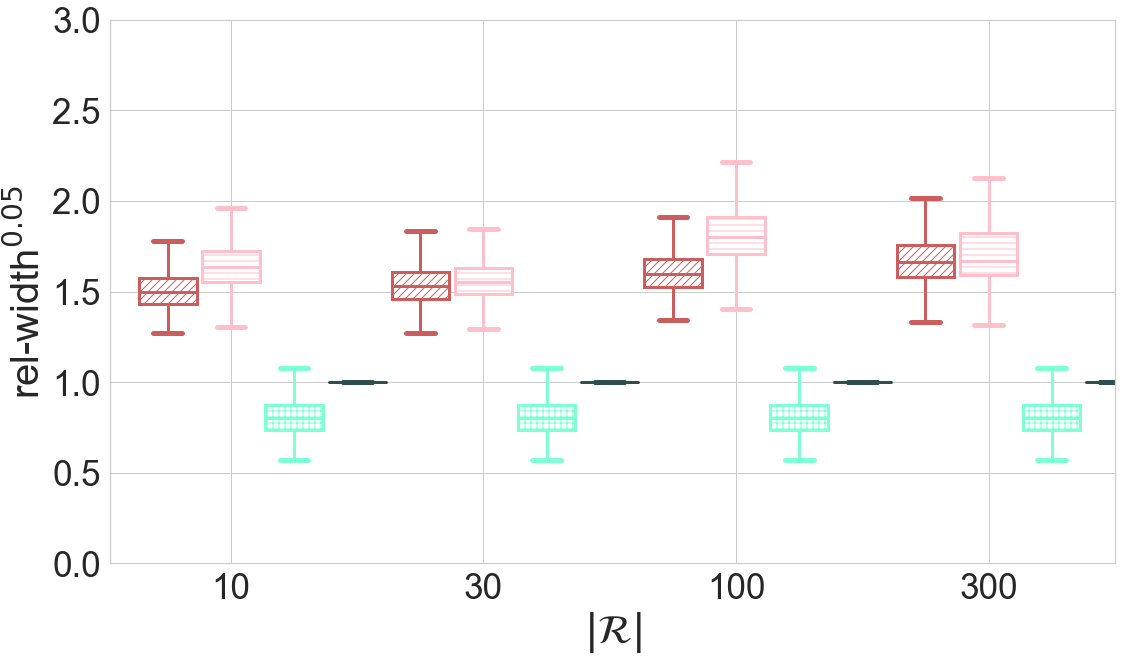

In [327]:
imp.reload(run_cis)
imp.reload(analysis)

title = r"Varying $\mathcal{R}$ (P=LN(ln(%.1f), %.1f), $n$=%s, $\rho$=%s, $\theta$=%.2f)" % (true_median, data_scale, n, rho, granularity)
xlabel = r"$|\mathcal{R}|$"
save_paths = width_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[5]
save=True
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, range_scale, xlabel, alg_names, 
                       param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          log=False, legend_out=False, xlim=None, legend=False, show_title=False, blackwhite=True,
                       ylim=[0, 3], sort='byParam', save=save, save_path=save_path, 
                       colors=alg_colors, styles=alg_styles)

# Width - varying beta

In [328]:
num_trials = 5
range_center = 5
range_scale = 10
rho = 0.5
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005
num_datasets=100

dataset_name = 'lognormal_v0'
n = 1000
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)

param_string = 'beta'
beta = [0.01, 0.02, 0.03, 0.04]
num_params = len(beta)
print(param_string, beta)

beta [0.01, 0.02, 0.03, 0.04]


In [218]:
imp.reload(run_cis)
imp.reload(wrap)
imp.reload(bs_cdf_median)

run_indices = [8]
algs = [alg_index[i][0] for i in run_indices]
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, 
                  alpha=alpha, beta=beta, quantile=quantile, 
                  n=n, em_granularity=em_granularity, granularity=granularity, true_median=true_median,
                  alg_list=algs, rerun_algs=True, gen_preprocess=False)

starting Nonpriv lognormal
param 0 of 4
n 1000 lb, ub -inf inf gran 0.05 alpha 0.05 rho 0.5
name, hyperparameters Nonpriv_lognormal_beta_0 {'s': 1, 'loc': 0, 'granularity': 0.05, 'beta': 0.01, 'alpha': 0.05, 'cdp': True}
computing 95% CIs
eps: 1.0
dataset 0 of 100 lognormal_v0 lognormal_v0_807.npy
dataset 1 of 100 lognormal_v0 lognormal_v0_813.npy
dataset 2 of 100 lognormal_v0 lognormal_v0_185.npy
dataset 3 of 100 lognormal_v0 lognormal_v0_191.npy
dataset 4 of 100 lognormal_v0 lognormal_v0_608.npy
dataset 5 of 100 lognormal_v0 lognormal_v0_146.npy
dataset 6 of 100 lognormal_v0 lognormal_v0_620.npy
dataset 7 of 100 lognormal_v0 lognormal_v0_634.npy
dataset 8 of 100 lognormal_v0 lognormal_v0_152.npy
dataset 9 of 100 lognormal_v0 lognormal_v0_387.npy
dataset 10 of 100 lognormal_v0 lognormal_v0_56.npy
dataset 11 of 100 lognormal_v0 lognormal_v0_42.npy
dataset 12 of 100 lognormal_v0 lognormal_v0_393.npy
dataset 13 of 100 lognormal_v0 lognormal_v0_378.npy
dataset 14 of 100 lognormal_v0 logno

dataset 54 of 100 lognormal_v0 lognormal_v0_345.npy
dataset 55 of 100 lognormal_v0 lognormal_v0_94.npy
dataset 56 of 100 lognormal_v0 lognormal_v0_379.npy
dataset 57 of 100 lognormal_v0 lognormal_v0_392.npy
dataset 58 of 100 lognormal_v0 lognormal_v0_43.npy
dataset 59 of 100 lognormal_v0 lognormal_v0_57.npy
dataset 60 of 100 lognormal_v0 lognormal_v0_386.npy
dataset 61 of 100 lognormal_v0 lognormal_v0_635.npy
dataset 62 of 100 lognormal_v0 lognormal_v0_153.npy
dataset 63 of 100 lognormal_v0 lognormal_v0_147.npy
dataset 64 of 100 lognormal_v0 lognormal_v0_621.npy
dataset 65 of 100 lognormal_v0 lognormal_v0_609.npy
dataset 66 of 100 lognormal_v0 lognormal_v0_190.npy
dataset 67 of 100 lognormal_v0 lognormal_v0_184.npy
dataset 68 of 100 lognormal_v0 lognormal_v0_812.npy
dataset 69 of 100 lognormal_v0 lognormal_v0_806.npy
dataset 70 of 100 lognormal_v0 lognormal_v0_810.npy
dataset 71 of 100 lognormal_v0 lognormal_v0_804.npy
dataset 72 of 100 lognormal_v0 lognormal_v0_192.npy
dataset 73 of 1

dataset 2 of 100 lognormal_v0 lognormal_v0_185.npy
dataset 3 of 100 lognormal_v0 lognormal_v0_191.npy
dataset 4 of 100 lognormal_v0 lognormal_v0_608.npy
dataset 5 of 100 lognormal_v0 lognormal_v0_146.npy
dataset 6 of 100 lognormal_v0 lognormal_v0_620.npy
dataset 7 of 100 lognormal_v0 lognormal_v0_634.npy
dataset 8 of 100 lognormal_v0 lognormal_v0_152.npy
dataset 9 of 100 lognormal_v0 lognormal_v0_387.npy
dataset 10 of 100 lognormal_v0 lognormal_v0_56.npy
dataset 11 of 100 lognormal_v0 lognormal_v0_42.npy
dataset 12 of 100 lognormal_v0 lognormal_v0_393.npy
dataset 13 of 100 lognormal_v0 lognormal_v0_378.npy
dataset 14 of 100 lognormal_v0 lognormal_v0_422.npy
dataset 15 of 100 lognormal_v0 lognormal_v0_95.npy
dataset 16 of 100 lognormal_v0 lognormal_v0_344.npy
dataset 17 of 100 lognormal_v0 lognormal_v0_350.npy
dataset 18 of 100 lognormal_v0 lognormal_v0_81.npy
dataset 19 of 100 lognormal_v0 lognormal_v0_436.npy
dataset 20 of 100 lognormal_v0 lognormal_v0_595.npy
dataset 21 of 100 lognor

['Expmedian', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMech', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
../../figs/widths-beta/rel-width-boxplots-95-lognormal_v0-revised-varying-beta.pdf
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_beta_0.npy
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_beta_1.npy
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_beta_2.npy
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_beta_3.npy
0 ExpMech
[1.5318778456403717, 1.5266717125302223, 1.5192235652090726, 1.5159145606826476]
1 CDFPostProcess
[1.6254009700768328, 1.6497178886160953, 1.6683685357961875, 1.6489648424261625]
2 Nonprivate Lognormal
[0.8100324660029816, 0.8100324660029816, 0.8100324660029816, 0.8100324660029816]
3 Nonprivate Nonparametric
[1.0, 1.0, 1.0, 1.0]
alpha lines: []


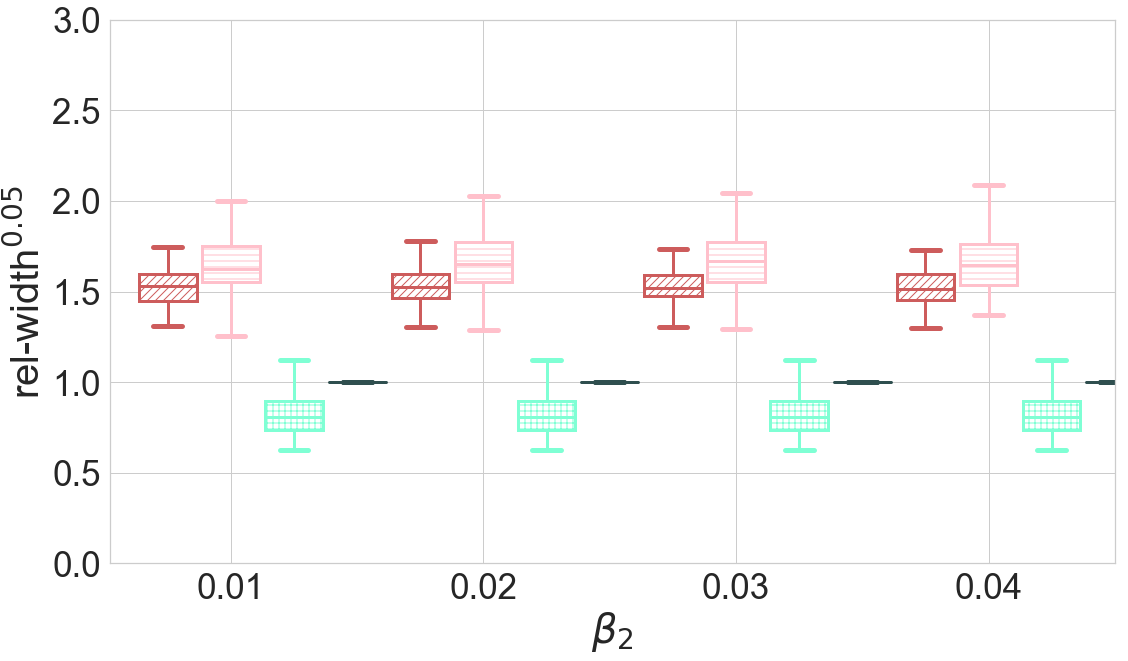

In [329]:
imp.reload(run_cis)
imp.reload(analysis)

title = r"Varying $\beta_2$ (P=LN(ln(%.1f), %.1f), $n$=%s, $\alpha$=%.2f, $\rho$=%.2f, $\theta$=%.2f, $\mathcal{R}$=[%s, %s])" % (true_median, data_scale, n, alpha, rho, granularity, range_center-range_scale, range_center+range_scale)        
xlabel = r"$\beta_2$"
save_paths = width_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[5]
save=True
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, beta, xlabel, alg_names, param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          log=False, legend=False, legend_out=False, xlim=None, show_title=False, blackwhite=True,
                       ylim=[0,3], 
                       sort='byParam', save=save, save_path=save_path, colors=alg_colors, styles=alg_styles)

# Width - varying rho (Figure 1c)

In [330]:
num_trials = 5
range_center = 5
range_scale = 10
rho = 0.5
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05 
em_granularity = 0.005
num_datasets=100

# For main body figure
dataset_name='lognormal_v0'
n = 1000
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)

# For appendix figure, use this instead
# dataset_name='lognormal_flat'
# n = 1000
# data_center = 0.5
# data_scale = 5.0
# true_median = st.lognorm.median(data_scale, loc=data_center)

param_string = 'rho'
num_params = 5
rho = np.logspace(-2.5, 0.5, num=num_params)
print(param_string, rho)

rho [0.00316228 0.01778279 0.1        0.56234133 3.16227766]


In [223]:
imp.reload(run_cis)
imp.reload(common)
imp.reload(analysis)
imp.reload(wrap)

run_indices = [8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, 
                  alpha=alpha, beta=beta, quantile=quantile, 
                  n=n, em_granularity=em_granularity, granularity=granularity, true_median=true_median,
                  alg_list=algs, rerun_algs=True, gen_preprocess=True)

['Nonpriv_lognormal']
starting Nonpriv lognormal
param 0 of 5
n 1000 lb, ub -inf inf gran 0.05 alpha 0.05 rho 0.0031622776601683794
name, hyperparameters Nonpriv_lognormal_rho_0 {'s': 1, 'loc': 0, 'granularity': 0.05, 'beta': 0.01, 'alpha': 0.05, 'cdp': True}
computing 95% CIs
eps: 0.07952707287670507
dataset 0 of 100 lognormal_v0 lognormal_v0_807.npy
dataset 1 of 100 lognormal_v0 lognormal_v0_813.npy
dataset 2 of 100 lognormal_v0 lognormal_v0_185.npy
dataset 3 of 100 lognormal_v0 lognormal_v0_191.npy
dataset 4 of 100 lognormal_v0 lognormal_v0_608.npy
dataset 5 of 100 lognormal_v0 lognormal_v0_146.npy
dataset 6 of 100 lognormal_v0 lognormal_v0_620.npy
dataset 7 of 100 lognormal_v0 lognormal_v0_634.npy
dataset 8 of 100 lognormal_v0 lognormal_v0_152.npy
dataset 9 of 100 lognormal_v0 lognormal_v0_387.npy
dataset 10 of 100 lognormal_v0 lognormal_v0_56.npy
dataset 11 of 100 lognormal_v0 lognormal_v0_42.npy
dataset 12 of 100 lognormal_v0 lognormal_v0_393.npy
dataset 13 of 100 lognormal_v0 lo

dataset 87 of 100 lognormal_v0 lognormal_v0_353.npy
dataset 88 of 100 lognormal_v0 lognormal_v0_82.npy
dataset 89 of 100 lognormal_v0 lognormal_v0_96.npy
dataset 90 of 100 lognormal_v0 lognormal_v0_347.npy
dataset 91 of 100 lognormal_v0 lognormal_v0_421.npy
dataset 92 of 100 lognormal_v0 lognormal_v0_582.npy
dataset 93 of 100 lognormal_v0 lognormal_v0_596.npy
dataset 94 of 100 lognormal_v0 lognormal_v0_569.npy
dataset 95 of 100 lognormal_v0 lognormal_v0_541.npy
dataset 96 of 100 lognormal_v0 lognormal_v0_227.npy
dataset 97 of 100 lognormal_v0 lognormal_v0_233.npy
dataset 98 of 100 lognormal_v0 lognormal_v0_555.npy
dataset 99 of 100 lognormal_v0 lognormal_v0_964.npy
results/lognormal_v0_Nonpriv_lognormal_rho_1_95.npy
running analysis
nonpriv_median: 1.556887680447057
Coverage - nonpriv: 0.95 priv: 0.89
Save path: analysis/lognormal_v0_sizes_Nonpriv_lognormal_rho_1.npy
param 2 of 5
n 1000 lb, ub -inf inf gran 0.05 alpha 0.05 rho 0.1
name, hyperparameters Nonpriv_lognormal_rho_2 {'s': 1, 

dataset 68 of 100 lognormal_v0 lognormal_v0_812.npy
dataset 69 of 100 lognormal_v0 lognormal_v0_806.npy
dataset 70 of 100 lognormal_v0 lognormal_v0_810.npy
dataset 71 of 100 lognormal_v0 lognormal_v0_804.npy
dataset 72 of 100 lognormal_v0 lognormal_v0_192.npy
dataset 73 of 100 lognormal_v0 lognormal_v0_838.npy
dataset 74 of 100 lognormal_v0 lognormal_v0_186.npy
dataset 75 of 100 lognormal_v0 lognormal_v0_179.npy
dataset 76 of 100 lognormal_v0 lognormal_v0_151.npy
dataset 77 of 100 lognormal_v0 lognormal_v0_637.npy
dataset 78 of 100 lognormal_v0 lognormal_v0_623.npy
dataset 79 of 100 lognormal_v0 lognormal_v0_145.npy
dataset 80 of 100 lognormal_v0 lognormal_v0_69.npy
dataset 81 of 100 lognormal_v0 lognormal_v0_41.npy
dataset 82 of 100 lognormal_v0 lognormal_v0_390.npy
dataset 83 of 100 lognormal_v0 lognormal_v0_384.npy
dataset 84 of 100 lognormal_v0 lognormal_v0_55.npy
dataset 85 of 100 lognormal_v0 lognormal_v0_409.npy
dataset 86 of 100 lognormal_v0 lognormal_v0_435.npy
dataset 87 of 1

['Expmedian', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMech', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
../../figs/widths-rho/rel-width-boxplots-95-lognormal_v0-revised-varying-rho.pdf
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_rho_0.npy
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_rho_1.npy
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_rho_2.npy
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_rho_3.npy
Nonpriv path: analysis/lognormal_v0_sizes_Expmedian_rho_4.npy
0 ExpMech
[8.130459821733908, 3.5733292426059102, 2.006028707559258, 1.4887358256757968, 1.2594909595931536]
1 CDFPostProcess
[26.707841903569758, 3.513041020853504, 2.110015491491623, 1.6228704610080298, 1.5942815794136855]
2 Nonprivate Lognormal
[0.8100324660029816, 0.8100324660029816, 0.8100324660029816, 0.8100324660029816, 0.8100324660029816]
3 Nonprivate Nonparametric
[1.0, 1.0, 1.0, 1.0, 1.0]
alpha lines: []


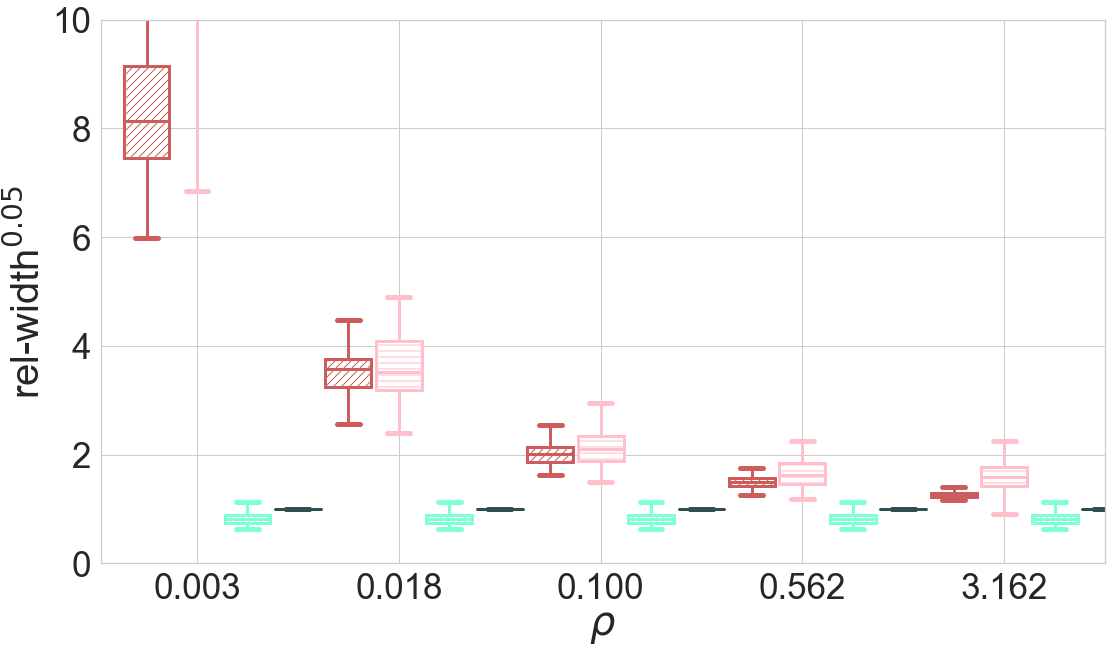

In [331]:
imp.reload(run_cis)
imp.reload(analysis)

title = r"Varying $\rho$ (P=LN(ln(%.1f), %.1f), $n$=%s, $\theta$=%.2f, $\mathcal{R}$=[%s, %s])" % (true_median, data_scale, n, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$\rho$"
xset = ['%.3f' % rho[i] for i in range(len(rho))]
save_paths = width_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[5] 
save=True
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, xset, xlabel, alg_names,
            param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          log=False, legend_out=False, xlim=None, legend=False, show_title=False, blackwhite=True,
                       ylim=[0,10], 
                       sort='byParam', save=save, save_path=save_path, colors=alg_colors, styles=alg_styles)

# Width - varying n (Figures 1a and 2a)

In [332]:
num_trials = 5
range_center = 5
range_scale = 10
rho = 0.5
true_median = 1.5
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005
num_datasets=100

# For main body figure
dataset_name='lognormal_v1'
n = 1000
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)

# For appendix figure, use this instead
# dataset_name='lognormal_flat'
# n = 1000
# data_center = 0.5
# data_scale = 5.0
# true_median = st.lognorm.median(data_scale, loc=data_center)

param_string = 'n'
num_params = 5
n = np.linspace(100, 1500, num=num_params)
print(param_string, n)

n [ 100.  450.  800. 1150. 1500.]


In [227]:
imp.reload(run_cis)
imp.reload(wrap)
imp.reload(bs_cdf_median)

run_indices = [8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, 
                  alpha=alpha, beta=beta, quantile=quantile, 
                  n=n, granularity=granularity, em_granularity=em_granularity, true_median=true_median,
                  alg_list=algs, data_center=data_center, data_scale=data_scale, data_distribution='lognormal',
                  gen_data=True, rerun_algs=True, gen_preprocess=False)

['Nonpriv_lognormal']
generating datasets
starting Nonpriv lognormal
param 0 of 5
n 100 lb, ub -inf inf gran 0.05 alpha 0.05 rho 0.5
name, hyperparameters Nonpriv_lognormal_n_0 {'s': 1.0, 'loc': 0.5, 'granularity': 0.05, 'beta': 0.01, 'alpha': 0.05, 'cdp': True}
computing 95% CIs
eps: 1.0
dataset 0 of 100 lognormal_v1_n_0 lognormal_v1_n_0_4.npy
dataset 1 of 100 lognormal_v1_n_0 lognormal_v1_n_0_91.npy
dataset 2 of 100 lognormal_v1_n_0 lognormal_v1_n_0_85.npy
dataset 3 of 100 lognormal_v1_n_0 lognormal_v1_n_0_52.npy
dataset 4 of 100 lognormal_v1_n_0 lognormal_v1_n_0_46.npy
dataset 5 of 100 lognormal_v1_n_0 lognormal_v1_n_0_47.npy
dataset 6 of 100 lognormal_v1_n_0 lognormal_v1_n_0_53.npy
dataset 7 of 100 lognormal_v1_n_0 lognormal_v1_n_0_84.npy
dataset 8 of 100 lognormal_v1_n_0 lognormal_v1_n_0_90.npy
dataset 9 of 100 lognormal_v1_n_0 lognormal_v1_n_0_5.npy
dataset 10 of 100 lognormal_v1_n_0 lognormal_v1_n_0_7.npy
dataset 11 of 100 lognormal_v1_n_0 lognormal_v1_n_0_86.npy
dataset 12 of 1

dataset 67 of 100 lognormal_v1_n_1 lognormal_v1_n_1_9.npy
dataset 68 of 100 lognormal_v1_n_1 lognormal_v1_n_1_43.npy
dataset 69 of 100 lognormal_v1_n_1 lognormal_v1_n_1_57.npy
dataset 70 of 100 lognormal_v1_n_1 lognormal_v1_n_1_80.npy
dataset 71 of 100 lognormal_v1_n_1 lognormal_v1_n_1_94.npy
dataset 72 of 100 lognormal_v1_n_1 lognormal_v1_n_1_82.npy
dataset 73 of 100 lognormal_v1_n_1 lognormal_v1_n_1_96.npy
dataset 74 of 100 lognormal_v1_n_1 lognormal_v1_n_1_41.npy
dataset 75 of 100 lognormal_v1_n_1 lognormal_v1_n_1_55.npy
dataset 76 of 100 lognormal_v1_n_1 lognormal_v1_n_1_69.npy
dataset 77 of 100 lognormal_v1_n_1 lognormal_v1_n_1_68.npy
dataset 78 of 100 lognormal_v1_n_1 lognormal_v1_n_1_54.npy
dataset 79 of 100 lognormal_v1_n_1 lognormal_v1_n_1_40.npy
dataset 80 of 100 lognormal_v1_n_1 lognormal_v1_n_1_97.npy
dataset 81 of 100 lognormal_v1_n_1 lognormal_v1_n_1_83.npy
dataset 82 of 100 lognormal_v1_n_1 lognormal_v1_n_1_27.npy
dataset 83 of 100 lognormal_v1_n_1 lognormal_v1_n_1_33.np

dataset 1 of 100 lognormal_v1_n_3 lognormal_v1_n_3_16.npy
dataset 2 of 100 lognormal_v1_n_3 lognormal_v1_n_3_28.npy
dataset 3 of 100 lognormal_v1_n_3 lognormal_v1_n_3_14.npy
dataset 4 of 100 lognormal_v1_n_3 lognormal_v1_n_3_15.npy
dataset 5 of 100 lognormal_v1_n_3 lognormal_v1_n_3_29.npy
dataset 6 of 100 lognormal_v1_n_3 lognormal_v1_n_3_11.npy
dataset 7 of 100 lognormal_v1_n_3 lognormal_v1_n_3_39.npy
dataset 8 of 100 lognormal_v1_n_3 lognormal_v1_n_3_38.npy
dataset 9 of 100 lognormal_v1_n_3 lognormal_v1_n_3_10.npy
dataset 10 of 100 lognormal_v1_n_3 lognormal_v1_n_3_12.npy
dataset 11 of 100 lognormal_v1_n_3 lognormal_v1_n_3_13.npy
dataset 12 of 100 lognormal_v1_n_3 lognormal_v1_n_3_5.npy
dataset 13 of 100 lognormal_v1_n_3 lognormal_v1_n_3_48.npy
dataset 14 of 100 lognormal_v1_n_3 lognormal_v1_n_3_60.npy
dataset 15 of 100 lognormal_v1_n_3 lognormal_v1_n_3_74.npy
dataset 16 of 100 lognormal_v1_n_3 lognormal_v1_n_3_75.npy
dataset 17 of 100 lognormal_v1_n_3 lognormal_v1_n_3_61.npy
dataset

dataset 50 of 100 lognormal_v1_n_4 lognormal_v1_n_4_91.npy
dataset 51 of 100 lognormal_v1_n_4 lognormal_v1_n_4_85.npy
dataset 52 of 100 lognormal_v1_n_4 lognormal_v1_n_4_93.npy
dataset 53 of 100 lognormal_v1_n_4 lognormal_v1_n_4_87.npy
dataset 54 of 100 lognormal_v1_n_4 lognormal_v1_n_4_78.npy
dataset 55 of 100 lognormal_v1_n_4 lognormal_v1_n_4_50.npy
dataset 56 of 100 lognormal_v1_n_4 lognormal_v1_n_4_44.npy
dataset 57 of 100 lognormal_v1_n_4 lognormal_v1_n_4_45.npy
dataset 58 of 100 lognormal_v1_n_4 lognormal_v1_n_4_51.npy
dataset 59 of 100 lognormal_v1_n_4 lognormal_v1_n_4_79.npy
dataset 60 of 100 lognormal_v1_n_4 lognormal_v1_n_4_86.npy
dataset 61 of 100 lognormal_v1_n_4 lognormal_v1_n_4_92.npy
dataset 62 of 100 lognormal_v1_n_4 lognormal_v1_n_4_74.npy
dataset 63 of 100 lognormal_v1_n_4 lognormal_v1_n_4_60.npy
dataset 64 of 100 lognormal_v1_n_4 lognormal_v1_n_4_48.npy
dataset 65 of 100 lognormal_v1_n_4 lognormal_v1_n_4_49.npy
dataset 66 of 100 lognormal_v1_n_4 lognormal_v1_n_4_61.n

['Expmedian', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMech', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
../../figs/widths-n/rel-width-boxplots-95-lognormal_v1-revised-varying-n.pdf
0 ExpMech
[2.9760661601039233, 1.7392663047558479, 1.5532960345179938, 1.4742836807128334, 1.4269837454003742]
1 CDFPostProcess
[2.936998316316709, 1.6530152065122274, 1.6276399511455506, 1.643949833405801, 1.7262982834585818]
2 Nonprivate Lognormal
[0.8155951599834297, 0.7691941154458333, 0.7833271428229366, 0.7697031388513229, 0.7729866201312661]
3 Nonprivate Nonparametric
[1.0, 1.0, 1.0, 1.0, 1.0]
alpha lines: []


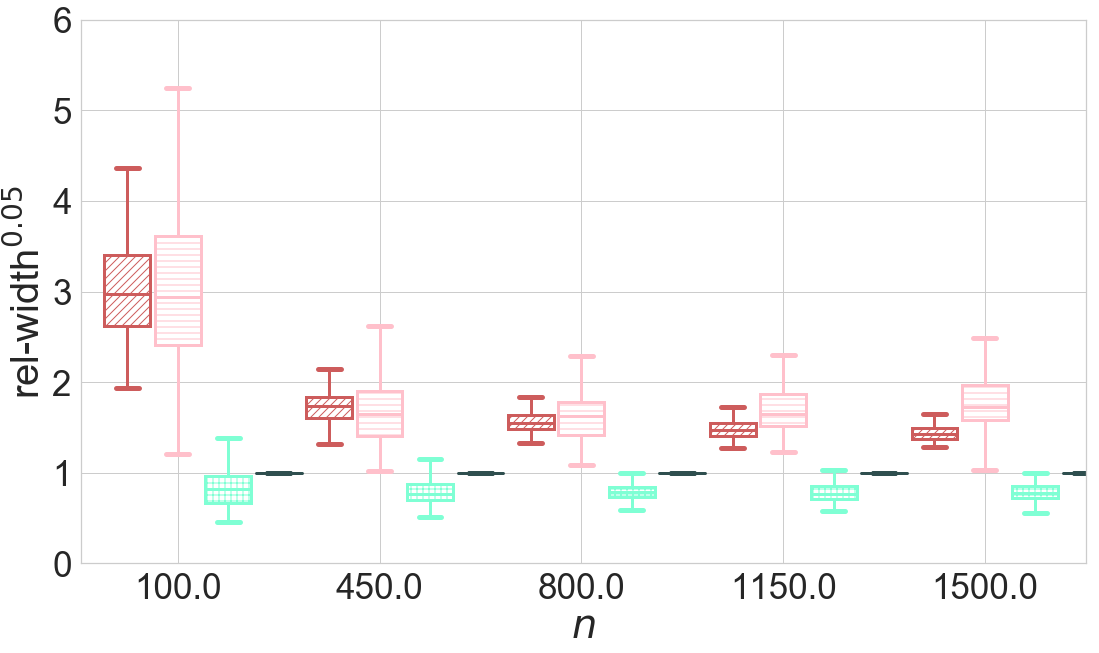

['Expmedian_naive', 'Expmedian', 'CDFmedian_naive', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMechUnion', 'ExpMech', 'CDFPostProcessUnion', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
../../figs/widths-n/rel-width-boxplots-95-lognormal_v1-naive-v-new-revised-varying-n.pdf
0 ExpMechUnion
[3.816063983604514, 2.0112390549907486, 1.75105690417281, 1.6676537875115778, 1.6010592408285769]
1 ExpMech
[2.9760661601039233, 1.7392663047558479, 1.5532960345179938, 1.4742836807128334, 1.4269837454003742]
2 CDFPostProcessUnion
[37.83667974275462, 3.100703456110258, 2.7926378984066167, 2.5994569296052634, 2.5907967070258904]
3 CDFPostProcess
[2.936998316316709, 1.6530152065122274, 1.6276399511455506, 1.643949833405801, 1.7262982834585818]
4 Nonprivate Lognormal
[0.8155951599834297, 0.7691941154458333, 0.7833271428229366, 0.7697031388513229, 0.7729866201312661]
5 Nonprivate Nonparametric
[1.0, 1.0, 1.0, 1.0, 1.0]
alpha lines: []


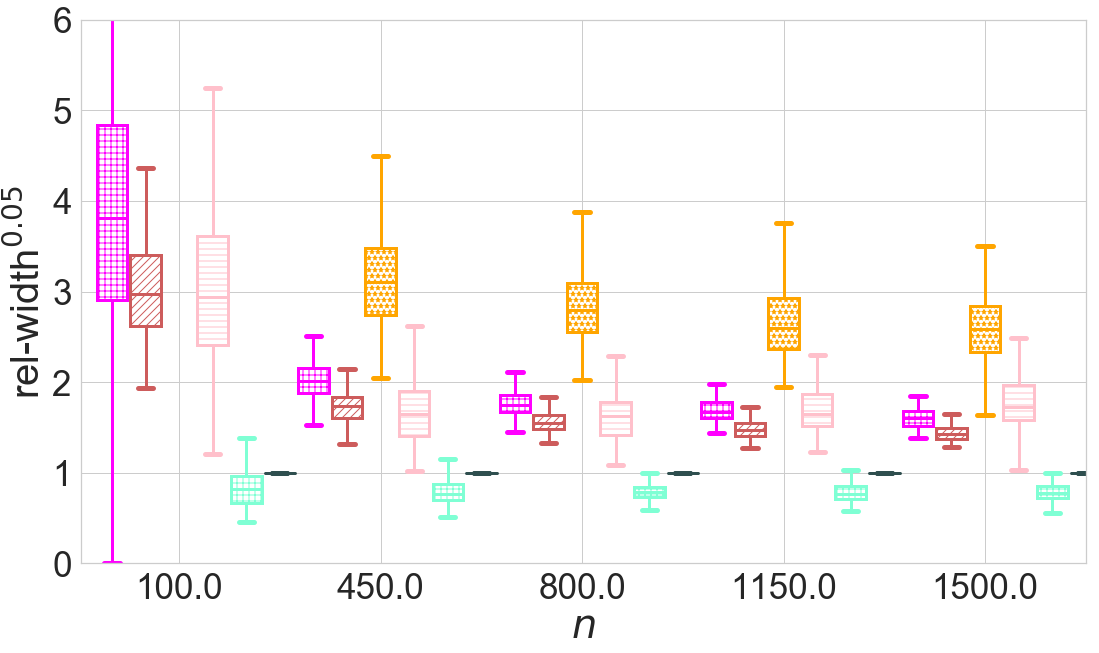

In [333]:
imp.reload(run_cis)
imp.reload(analysis)

save_paths = width_save_paths(dir_path, dataset_name, param_string, alpha)
title = r"Varying $n$ (data=LN(ln(%.1f),%s), $\rho$=%s, $\alpha$=%.2f, $\theta$=%.2f, range=[%s, %s])" % (true_median, data_scale, rho, alpha, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$n$"

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[5]
save=True
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, n, xlabel, alg_names,
          param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          ylim=[0,6], legend=False, show_title=False, blackwhite=True,
          log=False, legend_out=False, xlim=None, sort='byParam', dataset_param=True, 
    save=save, save_path=save_path, colors=alg_colors, styles=alg_styles)

run_indices = [0, 1, 2, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [0, 1, 2, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[6]
save=True
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, n, xlabel, alg_names,
          param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          ylim=[0,6], legend=False, show_title=False, blackwhite=True,
          log=False, legend_out=False, xlim=None, sort='byParam', dataset_param=True, 
    save=save, save_path=save_path, colors=alg_colors, styles=alg_styles)

# Width - varying data scale (Figure 1b)

In [334]:
num_trials = 5
range_center = 5
range_scale = 10
rho = 0.5
true_median = 1.5
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005
num_datasets=100

dataset_name='lognormal_v2'
n = 1000
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)

param_string = 'data_scale'
num_params = 5
data_scale = np.logspace(-2, 0.5, num=num_params)
print(param_string, data_scale)

data_scale [0.01       0.04216965 0.17782794 0.74989421 3.16227766]


In [235]:
imp.reload(run_cis)
imp.reload(wrap)

run_indices = [8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, 
                  alpha=alpha, beta=beta, quantile=quantile, 
                  n=n, granularity=granularity, em_granularity=em_granularity, true_median=true_median,
                  alg_list=algs, data_center=data_center, data_scale=data_scale, data_distribution='lognormal',
                  gen_data=True, rerun_algs=True, gen_preprocess=False)

['Nonpriv_lognormal']
generating datasets
starting Nonpriv lognormal
param 0 of 5
n 1000 lb, ub -inf inf gran 0.05 alpha 0.05 rho 0.5
name, hyperparameters Nonpriv_lognormal_data_scale_0 {'s': array([0.01      , 0.04216965, 0.17782794, 0.74989421, 3.16227766]), 'loc': 0.5, 'granularity': 0.05, 'beta': 0.01, 'alpha': 0.05, 'cdp': True}
computing 95% CIs
eps: 1.0
dataset 0 of 100 lognormal_v2_data_scale_0 lognormal_v2_data_scale_0_97.npy
dataset 1 of 100 lognormal_v2_data_scale_0 lognormal_v2_data_scale_0_83.npy
dataset 2 of 100 lognormal_v2_data_scale_0 lognormal_v2_data_scale_0_54.npy
dataset 3 of 100 lognormal_v2_data_scale_0 lognormal_v2_data_scale_0_40.npy
dataset 4 of 100 lognormal_v2_data_scale_0 lognormal_v2_data_scale_0_68.npy
dataset 5 of 100 lognormal_v2_data_scale_0 lognormal_v2_data_scale_0_69.npy
dataset 6 of 100 lognormal_v2_data_scale_0 lognormal_v2_data_scale_0_41.npy
dataset 7 of 100 lognormal_v2_data_scale_0 lognormal_v2_data_scale_0_55.npy
dataset 8 of 100 lognormal_v

param 1 of 5
n 1000 lb, ub -inf inf gran 0.05 alpha 0.05 rho 0.5
name, hyperparameters Nonpriv_lognormal_data_scale_1 {'s': array([0.01      , 0.04216965, 0.17782794, 0.74989421, 3.16227766]), 'loc': 0.5, 'granularity': 0.05, 'beta': 0.01, 'alpha': 0.05, 'cdp': True}
computing 95% CIs
eps: 1.0
dataset 0 of 100 lognormal_v2_data_scale_1 lognormal_v2_data_scale_1_28.npy
dataset 1 of 100 lognormal_v2_data_scale_1 lognormal_v2_data_scale_1_14.npy
dataset 2 of 100 lognormal_v2_data_scale_1 lognormal_v2_data_scale_1_0.npy
dataset 3 of 100 lognormal_v2_data_scale_1 lognormal_v2_data_scale_1_1.npy
dataset 4 of 100 lognormal_v2_data_scale_1 lognormal_v2_data_scale_1_15.npy
dataset 5 of 100 lognormal_v2_data_scale_1 lognormal_v2_data_scale_1_29.npy
dataset 6 of 100 lognormal_v2_data_scale_1 lognormal_v2_data_scale_1_17.npy
dataset 7 of 100 lognormal_v2_data_scale_1 lognormal_v2_data_scale_1_3.npy
dataset 8 of 100 lognormal_v2_data_scale_1 lognormal_v2_data_scale_1_2.npy
dataset 9 of 100 lognorma

param 2 of 5
n 1000 lb, ub -inf inf gran 0.05 alpha 0.05 rho 0.5
name, hyperparameters Nonpriv_lognormal_data_scale_2 {'s': array([0.01      , 0.04216965, 0.17782794, 0.74989421, 3.16227766]), 'loc': 0.5, 'granularity': 0.05, 'beta': 0.01, 'alpha': 0.05, 'cdp': True}
computing 95% CIs
eps: 1.0
dataset 0 of 100 lognormal_v2_data_scale_2 lognormal_v2_data_scale_2_92.npy
dataset 1 of 100 lognormal_v2_data_scale_2 lognormal_v2_data_scale_2_86.npy
dataset 2 of 100 lognormal_v2_data_scale_2 lognormal_v2_data_scale_2_51.npy
dataset 3 of 100 lognormal_v2_data_scale_2 lognormal_v2_data_scale_2_45.npy
dataset 4 of 100 lognormal_v2_data_scale_2 lognormal_v2_data_scale_2_79.npy
dataset 5 of 100 lognormal_v2_data_scale_2 lognormal_v2_data_scale_2_78.npy
dataset 6 of 100 lognormal_v2_data_scale_2 lognormal_v2_data_scale_2_44.npy
dataset 7 of 100 lognormal_v2_data_scale_2 lognormal_v2_data_scale_2_50.npy
dataset 8 of 100 lognormal_v2_data_scale_2 lognormal_v2_data_scale_2_87.npy
dataset 9 of 100 logn

dataset 10 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_17.npy
dataset 11 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_4.npy
dataset 12 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_5.npy
dataset 13 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_16.npy
dataset 14 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_14.npy
dataset 15 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_28.npy
dataset 16 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_7.npy
dataset 17 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_6.npy
dataset 18 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_29.npy
dataset 19 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_15.npy
dataset 20 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_99.npy
dataset 21 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_66.npy
dataset 22 of 100 lognormal_v2_data_scale_3 lognormal_v2_data_scale_3_72.npy
dat

dataset 33 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_4.npy
dataset 34 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_5.npy
dataset 35 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_79.npy
dataset 36 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_51.npy
dataset 37 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_45.npy
dataset 38 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_92.npy
dataset 39 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_86.npy
dataset 40 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_82.npy
dataset 41 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_96.npy
dataset 42 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_69.npy
dataset 43 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_41.npy
dataset 44 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_55.npy
dataset 45 of 100 lognormal_v2_data_scale_4 lognormal_v2_data_scale_4_1.npy
da

['Expmedian', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMech', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
../../figs/widths-data_scale/rel-width-boxplots-95-lognormal_v2-revised-varying-data_scale.pdf
0 ExpMech
[7.984311904968987, 2.9444597850812624, 1.8010336225954364, 1.537381114098197, 1.4781329382100041]
1 CDFPostProcess
[51.16165687251076, 11.84005082678592, 3.8232712200944743, 1.7653261895063554, 1.350669445474833]
2 Nonprivate Lognormal
[0.8068911619372134, 0.7878342783763823, 0.7925007515921187, 0.7693420319992416, 0.7966009437535087]
3 Nonprivate Nonparametric
[1.0, 1.0, 1.0, 1.0, 1.0]
alpha lines: []


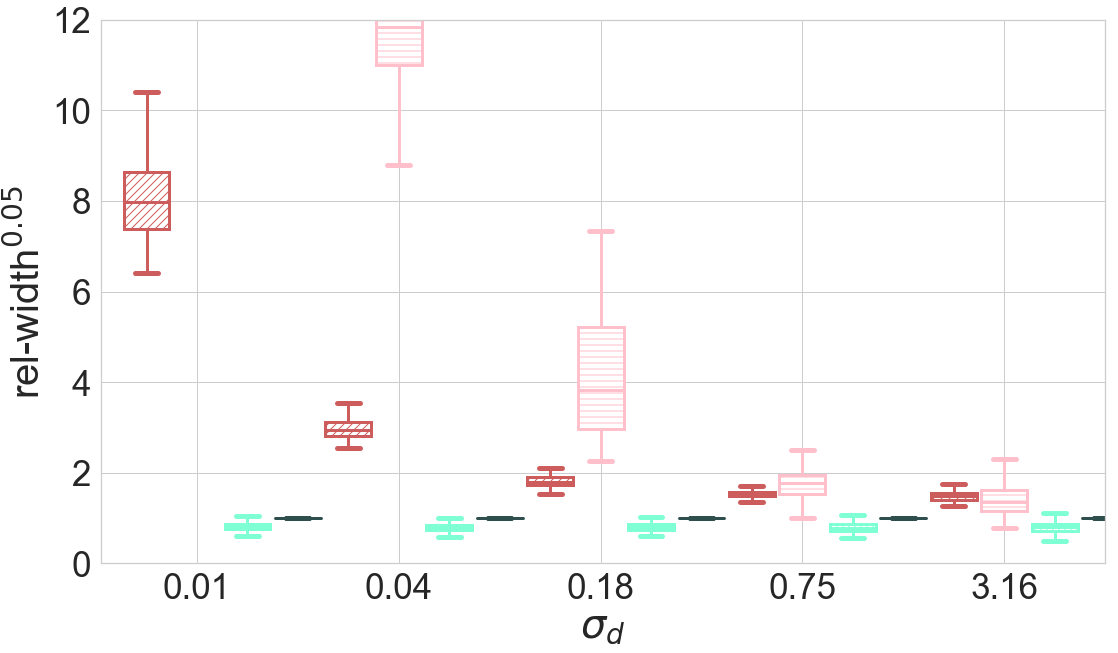

In [335]:
imp.reload(run_cis)
imp.reload(analysis)

save_paths = width_save_paths(dir_path, dataset_name, param_string, alpha)
title = r"Varying $\sigma_y$ (P=LN(ln(%.1f), $\sigma_d^2$), $n$=%s, $\rho$=%s, $\alpha$=%.2f, $\theta$=%.2f, $\mathcal{R}$=[%s, %s])" % (true_median, n, rho, alpha, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$\sigma_y$"
xset = ['%.2f' % data_scale[i] for i in range(len(data_scale))]

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[5]
save=True
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, xset, xlabel, alg_names,
          param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          ylim=[0,12], legend=False, show_title=False, blackwhite=True,
          log=False, legend_out=False, xlim=None, sort='byParam', dataset_param=True, 
    save=save, save_path=save_path, colors=alg_colors, styles=alg_styles)